# SVG-VAE

In [1]:
import pyarrow.parquet as pq
import svg_utils
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from model import VAEModel
from config import ImageVAEConfig

## Prepare dataset

In [2]:
data_train = pq.read_table('data_train.parquet')
data_train = data_train.to_pandas()

data_test = pq.read_table('data_test.parquet')
data_test = data_test.to_pandas()

data_train.head()

,uni,width,vwidth,sfd,id,binary_fp
0,97,649,1000,"SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...",1,12127215344058962203\n
1,98,560,1000,"SplineSet\n535 284 m 0,0,1\n 535 166 535 166 4...",2,12127215344058962203\n
2,99,712,1000,"SplineSet\n693 125 m 1,0,1\n 686 116 686 116 6...",3,12127215344058962203\n
3,100,710,1000,"SplineSet\n678 378 m 0,0,1\n 678 221 678 221 5...",4,12127215344058962203\n
4,101,613,1000,"SplineSet\n586 0 m 1,0,-1\n 28 0 l 1,1,-1\n 28...",5,12127215344058962203\n


In [3]:
len(data_train)

1971326

Взглянем на сэмпл.

In [4]:
from random import randint
i = 1358568 # randint(0, 1971326)

In [5]:
assert svg_utils._is_valid_glyph(data_train.loc[i])
path = svg_utils._convert_to_path(data_train.loc[i])
assert svg_utils._is_valid_path(path)
data = svg_utils._create_example(path)
data.keys()

dict_keys(['rendered', 'seq_len', 'class', 'binary_fp', 'sequence'])

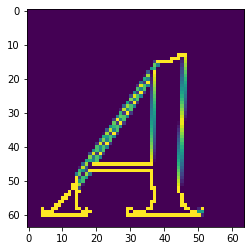

In [6]:
plt.imshow(np.array(data['rendered']).reshape(64, 64))

Подготовим даталоадеры.

In [7]:
data_train.loc[0, :]

uni                                                         97
width                                                      649
vwidth                                                    1000
sfd          SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...
id                                                           1
binary_fp                               12127215344058962203\n
Name: 0, dtype: object

In [78]:
class GlyphDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.map_class = {}
        self.cached = self.__getitem__(0)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            example = np.array(svg_utils._create_example(svg_utils._convert_to_path(self.df.loc[idx, :]))['rendered']
                              , dtype=np.float32)
            
            if not (self.df.loc[idx, "uni"] in self.map_class):
                len_ind = len(self.map_class)
                self.map_class[self.df.loc[idx, "uni"]] = len_ind
                
            return torch.FloatTensor(example.reshape(1, 64, 64)), self.map_class[self.df.loc[idx, "uni"]]
        except Exception as e:
            return self.cached

In [79]:
glyph_train = GlyphDataset(data_train)
glyph_test = GlyphDataset(data_test)

In [80]:
train_loader = DataLoader(glyph_train, batch_size=64)
for X_batch, Y_batch in train_loader:
    print(X_batch.size())
    print(Y_batch)
    break

torch.Size([64, 1, 64, 64])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61,  0,  1])


## Model declaration

In [11]:
%load_ext autoreload
%autoreload 2

In [84]:
config = ImageVAEConfig()

In [85]:
model = VAEModel(config)

In [86]:
from torchsummary import summary

summary(model, [(1, 64, 64), (1, 1, 1)])

tensor([[[[ 0.1975,  0.3291,  0.4104,  ...,  0.1341,  0.2541,  0.2247],
          [ 0.0897,  0.5155,  0.4756,  ...,  0.3540, -0.1822,  0.0089],
          [ 0.2443,  0.2290,  0.3401,  ...,  0.3207, -0.2052, -0.1620],
          ...,
          [ 0.1087,  0.0068,  0.4110,  ...,  0.2598,  0.4035,  0.2694],
          [ 0.0451,  0.4237,  0.1999,  ...,  0.2615,  0.1549,  0.1035],
          [ 0.0411, -0.0244,  0.0435,  ..., -0.0663,  0.0555,  0.0688]]],


        [[[ 0.3602,  0.3773,  0.2678,  ...,  0.1601,  0.3245,  0.2012],
          [ 0.0532,  0.4270,  0.2615,  ...,  0.2901, -0.1620,  0.1228],
          [ 0.0605,  0.3575,  0.5325,  ...,  0.0601, -0.1772,  0.0875],
          ...,
          [ 0.3049, -0.0225,  0.1514,  ...,  0.1026,  0.2966,  0.3306],
          [-0.0227,  0.3084,  0.0512,  ...,  0.2502,  0.0214,  0.2588],
          [ 0.1631,  0.1571,  0.0890,  ..., -0.0401,  0.0904,  0.0699]]]],
       grad_fn=<MkldnnConvolutionBackward>)
-------------------------------------------------------

## Training

In [87]:
opt = torch.optim.Adam(model.parameters(), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, min_lr=0.0001)

In [93]:
import time
from tqdm import tqdm


def train_model(model, opt, scheduler, train_loss, 
                val_accuracy, num_epochs, print_every=5):
    cur_max_acc = None
    for epoch in tqdm(range(num_epochs)):
        print(f'Start epoch {epoch}')
        start_time = time.time()
        model.train()
        epoch_loss = 0
        i = 0
        for X_batch, Y_batch in tqdm(train_loader):
            logits, losses = model(X_batch, Y_batch)
            #print(scores)
            #print(losses)
            loss = model.loss(logits, X_batch)[0]
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss += loss.item()
            if i % print_every == 0:
                print(f'Epoch {epoch}, Batch {i}, loss {loss.item()}')
            i += 1
        cur_val_acc, cur_val_loss = get_accuracy(model, val_batch_gen)
        epoch_loss /= len(train_batch_gen)
        scheduler.step(cur_val_loss)
        
        train_loss.append(epoch_loss)
        val_accuracy.append(cur_val_acc)
        val_loss.append(cur_val_loss)
        
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  lr =', scheduler._last_lr[0])
        print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
        print("  validate loss (in-iteration): \t{:.6f}".format(cur_val_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(cur_val_acc * 100))
        if cur_max_acc is None or cur_val_acc > cur_max_acc:
            cur_max_acc = cur_val_acc
            torch.save(model.state_dict(), 'models/residual.best4')

In [94]:
train_loss = []
val_accuracy = []
train_model(model, opt, scheduler, train_loss, val_accuracy, 3)

  0%|          | 0/30802 [00:00<?, ?it/s]

Start epoch 0



  0%|          | 1/30802 [00:04<40:21:40,  4.72s/it]

Epoch 0, Batch 0, loss 906986368.0



  0%|          | 6/30802 [00:29<42:14:42,  4.94s/it]

Epoch 0, Batch 5, loss 1040534464.0



  0%|          | 11/30802 [00:54<43:14:32,  5.06s/it]

Epoch 0, Batch 10, loss 593731456.0



  0%|          | 16/30802 [01:21<44:20:30,  5.19s/it]

Epoch 0, Batch 15, loss 1113464192.0



  0%|          | 21/30802 [01:46<43:30:33,  5.09s/it]

Epoch 0, Batch 20, loss 610878400.0



  0%|          | 26/30802 [02:13<47:02:27,  5.50s/it]

Epoch 0, Batch 25, loss 613307392.0



  0%|          | 31/30802 [02:39<44:42:49,  5.23s/it]

Epoch 0, Batch 30, loss 939639360.0



  0%|          | 36/30802 [03:03<41:36:44,  4.87s/it]

Epoch 0, Batch 35, loss 690484544.0



  0%|          | 41/30802 [03:29<44:39:25,  5.23s/it]

Epoch 0, Batch 40, loss 525598080.0



  0%|          | 46/30802 [03:54<43:02:26,  5.04s/it]

Epoch 0, Batch 45, loss 696640448.0



  0%|          | 51/30802 [04:20<44:30:35,  5.21s/it]

Epoch 0, Batch 50, loss 419475520.0



  0%|          | 56/30802 [04:47<46:14:30,  5.41s/it]

Epoch 0, Batch 55, loss 859417344.0



  0%|          | 61/30802 [05:13<44:06:52,  5.17s/it]

Epoch 0, Batch 60, loss 443934080.0



  0%|          | 66/30802 [05:39<45:30:30,  5.33s/it]

Epoch 0, Batch 65, loss 622865664.0



  0%|          | 71/30802 [06:04<43:20:45,  5.08s/it]

Epoch 0, Batch 70, loss 386213856.0



  0%|          | 76/30802 [06:30<43:58:36,  5.15s/it]

Epoch 0, Batch 75, loss 392070528.0



  0%|          | 81/30802 [06:58<47:09:33,  5.53s/it]

Epoch 0, Batch 80, loss 710798080.0



  0%|          | 86/30802 [07:24<46:36:13,  5.46s/it]

Epoch 0, Batch 85, loss 375969888.0



  0%|          | 91/30802 [07:50<44:14:42,  5.19s/it]

Epoch 0, Batch 90, loss 952713088.0



  0%|          | 96/30802 [08:16<44:10:48,  5.18s/it]

Epoch 0, Batch 95, loss 570656256.0



  0%|          | 101/30802 [08:42<45:09:45,  5.30s/it]

Epoch 0, Batch 100, loss 361456768.0



  0%|          | 106/30802 [09:07<43:30:55,  5.10s/it]

Epoch 0, Batch 105, loss 480790560.0



  0%|          | 111/30802 [09:33<43:58:52,  5.16s/it]

Epoch 0, Batch 110, loss 707270016.0



  0%|          | 116/30802 [09:58<43:10:41,  5.07s/it]

Epoch 0, Batch 115, loss 653032832.0



  0%|          | 121/30802 [10:24<43:46:23,  5.14s/it]

Epoch 0, Batch 120, loss 772333440.0



  0%|          | 126/30802 [10:49<42:59:32,  5.05s/it]

Epoch 0, Batch 125, loss 402995296.0



  0%|          | 131/30802 [11:16<44:16:05,  5.20s/it]

Epoch 0, Batch 130, loss 660794240.0



  0%|          | 136/30802 [11:44<47:36:26,  5.59s/it]

Epoch 0, Batch 135, loss 388058176.0



  0%|          | 141/30802 [12:10<44:14:41,  5.19s/it]

Epoch 0, Batch 140, loss 745089408.0



  0%|          | 146/30802 [12:36<43:57:57,  5.16s/it]

Epoch 0, Batch 145, loss 580981632.0



  0%|          | 151/30802 [13:02<44:19:34,  5.21s/it]

Epoch 0, Batch 150, loss 881145856.0



  1%|          | 156/30802 [13:29<45:52:03,  5.39s/it]

Epoch 0, Batch 155, loss 515270048.0



  1%|          | 161/30802 [13:56<46:18:28,  5.44s/it]

Epoch 0, Batch 160, loss 448900192.0



  1%|          | 166/30802 [14:21<44:03:33,  5.18s/it]

Epoch 0, Batch 165, loss 308787520.0



  1%|          | 171/30802 [14:48<45:30:50,  5.35s/it]

Epoch 0, Batch 170, loss 467368320.0



  1%|          | 176/30802 [15:15<45:45:43,  5.38s/it]

Epoch 0, Batch 175, loss 399273920.0



  1%|          | 181/30802 [15:40<43:36:20,  5.13s/it]

Epoch 0, Batch 180, loss 667990080.0



  1%|          | 186/30802 [16:07<44:27:52,  5.23s/it]

Epoch 0, Batch 185, loss 929094976.0



  1%|          | 191/30802 [16:33<45:00:37,  5.29s/it]

Epoch 0, Batch 190, loss 664767296.0



  1%|          | 196/30802 [16:59<43:46:20,  5.15s/it]

Epoch 0, Batch 195, loss 363640192.0



  1%|          | 201/30802 [17:24<43:56:16,  5.17s/it]

Epoch 0, Batch 200, loss 610595136.0



  1%|          | 206/30802 [17:52<45:26:15,  5.35s/it]

Epoch 0, Batch 205, loss 363528288.0



  1%|          | 211/30802 [18:18<45:27:56,  5.35s/it]

Epoch 0, Batch 210, loss 291391616.0



  1%|          | 216/30802 [18:46<46:26:29,  5.47s/it]

Epoch 0, Batch 215, loss 919080768.0



  1%|          | 221/30802 [19:13<45:53:11,  5.40s/it]

Epoch 0, Batch 220, loss 478903264.0



  1%|          | 226/30802 [19:40<46:41:47,  5.50s/it]

Epoch 0, Batch 225, loss 845928192.0



  1%|          | 231/30802 [20:07<46:11:25,  5.44s/it]

Epoch 0, Batch 230, loss 565408256.0



  1%|          | 236/30802 [20:34<45:00:07,  5.30s/it]

Epoch 0, Batch 235, loss 806827200.0



  1%|          | 241/30802 [21:01<45:33:35,  5.37s/it]

Epoch 0, Batch 240, loss 273589440.0



  1%|          | 246/30802 [21:28<45:05:39,  5.31s/it]

Epoch 0, Batch 245, loss 740802112.0



  1%|          | 251/30802 [21:55<45:05:00,  5.31s/it]

Epoch 0, Batch 250, loss 542894336.0



  1%|          | 256/30802 [22:21<44:34:50,  5.25s/it]

Epoch 0, Batch 255, loss 285418688.0



  1%|          | 261/30802 [22:47<44:22:20,  5.23s/it]

Epoch 0, Batch 260, loss 658497216.0



  1%|          | 266/30802 [23:15<46:01:32,  5.43s/it]

Epoch 0, Batch 265, loss 268013984.0



  1%|          | 271/30802 [23:41<44:09:36,  5.21s/it]

Epoch 0, Batch 270, loss 701073920.0



  1%|          | 276/30802 [24:08<45:41:48,  5.39s/it]

Epoch 0, Batch 275, loss 649189696.0



  1%|          | 281/30802 [24:34<43:44:59,  5.16s/it]

Epoch 0, Batch 280, loss 543145984.0



  1%|          | 286/30802 [25:00<44:22:44,  5.24s/it]

Epoch 0, Batch 285, loss 389396736.0



  1%|          | 291/30802 [25:26<44:03:37,  5.20s/it]

Epoch 0, Batch 290, loss 545387712.0



  1%|          | 296/30802 [25:53<44:23:59,  5.24s/it]

Epoch 0, Batch 295, loss 662233728.0



  1%|          | 301/30802 [26:18<43:40:08,  5.15s/it]

Epoch 0, Batch 300, loss 652254528.0



  1%|          | 306/30802 [26:46<46:15:24,  5.46s/it]

Epoch 0, Batch 305, loss 355545216.0



  1%|          | 311/30802 [27:12<45:30:53,  5.37s/it]

Epoch 0, Batch 310, loss 370339008.0



  1%|          | 316/30802 [27:38<44:02:10,  5.20s/it]

Epoch 0, Batch 315, loss 313193440.0



  1%|          | 321/30802 [28:04<44:05:09,  5.21s/it]

Epoch 0, Batch 320, loss 534350464.0



  1%|          | 326/30802 [28:30<44:31:08,  5.26s/it]

Epoch 0, Batch 325, loss 686888192.0



  1%|          | 331/30802 [28:57<45:03:32,  5.32s/it]

Epoch 0, Batch 330, loss 254935008.0



  1%|          | 336/30802 [29:23<44:09:19,  5.22s/it]

Epoch 0, Batch 335, loss 608006016.0



  1%|          | 341/30802 [29:50<44:49:09,  5.30s/it]

Epoch 0, Batch 340, loss 462432192.0



  1%|          | 346/30802 [30:17<46:14:46,  5.47s/it]

Epoch 0, Batch 345, loss 339304672.0



  1%|          | 351/30802 [30:44<44:48:51,  5.30s/it]

Epoch 0, Batch 350, loss 856408320.0



  1%|          | 356/30802 [31:10<45:03:44,  5.33s/it]

Epoch 0, Batch 355, loss 245379616.0



  1%|          | 361/30802 [31:37<45:13:08,  5.35s/it]

Epoch 0, Batch 360, loss 621125376.0



  1%|          | 366/30802 [32:04<45:36:40,  5.39s/it]

Epoch 0, Batch 365, loss 501030048.0



  1%|          | 371/30802 [32:31<44:35:05,  5.27s/it]

Epoch 0, Batch 370, loss 572023808.0



  1%|          | 376/30802 [32:58<45:35:00,  5.39s/it]

Epoch 0, Batch 375, loss 629134080.0



  1%|          | 381/30802 [33:23<43:14:36,  5.12s/it]

Epoch 0, Batch 380, loss 1119133312.0



  1%|▏         | 386/30802 [33:50<44:41:12,  5.29s/it]

Epoch 0, Batch 385, loss 580592000.0



  1%|▏         | 391/30802 [34:16<44:14:13,  5.24s/it]

Epoch 0, Batch 390, loss 520049280.0



  1%|▏         | 396/30802 [34:43<45:17:25,  5.36s/it]

Epoch 0, Batch 395, loss 395345408.0



  1%|▏         | 401/30802 [35:09<44:10:22,  5.23s/it]

Epoch 0, Batch 400, loss 685470208.0



  1%|▏         | 406/30802 [35:35<43:49:03,  5.19s/it]

Epoch 0, Batch 405, loss 571838912.0



  1%|▏         | 411/30802 [36:00<42:51:33,  5.08s/it]

Epoch 0, Batch 410, loss 627562560.0



  1%|▏         | 416/30802 [36:27<44:11:26,  5.24s/it]

Epoch 0, Batch 415, loss 664273664.0



  1%|▏         | 421/30802 [36:53<43:45:41,  5.19s/it]

Epoch 0, Batch 420, loss 525164544.0



  1%|▏         | 426/30802 [37:20<45:43:28,  5.42s/it]

Epoch 0, Batch 425, loss 424483904.0



  1%|▏         | 431/30802 [37:47<45:32:51,  5.40s/it]

Epoch 0, Batch 430, loss 363114400.0



  1%|▏         | 436/30802 [38:14<44:44:13,  5.30s/it]

Epoch 0, Batch 435, loss 504679008.0



  1%|▏         | 441/30802 [38:40<44:05:53,  5.23s/it]

Epoch 0, Batch 440, loss 616942656.0



  1%|▏         | 446/30802 [39:08<46:58:55,  5.57s/it]

Epoch 0, Batch 445, loss 285782912.0



  1%|▏         | 451/30802 [39:34<44:03:21,  5.23s/it]

Epoch 0, Batch 450, loss 557092544.0



  1%|▏         | 456/30802 [40:00<43:52:02,  5.20s/it]

Epoch 0, Batch 455, loss 242921856.0



  1%|▏         | 461/30802 [40:26<44:31:55,  5.28s/it]

Epoch 0, Batch 460, loss 239313248.0



  2%|▏         | 466/30802 [40:53<45:07:31,  5.36s/it]

Epoch 0, Batch 465, loss 620393344.0



  2%|▏         | 471/30802 [41:22<46:47:33,  5.55s/it]

Epoch 0, Batch 470, loss 458717216.0



  2%|▏         | 476/30802 [41:48<44:15:35,  5.25s/it]

Epoch 0, Batch 475, loss 430545248.0



  2%|▏         | 481/30802 [42:14<44:14:17,  5.25s/it]

Epoch 0, Batch 480, loss 418368352.0



  2%|▏         | 486/30802 [42:41<45:57:30,  5.46s/it]

Epoch 0, Batch 485, loss 261150528.0



  2%|▏         | 491/30802 [43:07<43:42:32,  5.19s/it]

Epoch 0, Batch 490, loss 258930336.0



  2%|▏         | 496/30802 [43:34<44:19:22,  5.27s/it]

Epoch 0, Batch 495, loss 219031648.0



  2%|▏         | 501/30802 [43:59<43:39:11,  5.19s/it]

Epoch 0, Batch 500, loss 571576768.0



  2%|▏         | 506/30802 [44:26<44:16:59,  5.26s/it]

Epoch 0, Batch 505, loss 629869440.0



  2%|▏         | 511/30802 [44:53<45:23:01,  5.39s/it]

Epoch 0, Batch 510, loss 477963648.0



  2%|▏         | 516/30802 [45:19<44:57:53,  5.34s/it]

Epoch 0, Batch 515, loss 730140544.0



  2%|▏         | 521/30802 [45:45<44:06:10,  5.24s/it]

Epoch 0, Batch 520, loss 349266080.0



  2%|▏         | 526/30802 [46:12<44:59:56,  5.35s/it]

Epoch 0, Batch 525, loss 658383552.0



  2%|▏         | 531/30802 [46:39<45:13:59,  5.38s/it]

Epoch 0, Batch 530, loss 245629408.0



  2%|▏         | 536/30802 [47:07<47:02:11,  5.59s/it]

Epoch 0, Batch 535, loss 204752576.0



  2%|▏         | 541/30802 [47:33<44:00:34,  5.24s/it]

Epoch 0, Batch 540, loss 512370592.0



  2%|▏         | 546/30802 [47:59<43:49:05,  5.21s/it]

Epoch 0, Batch 545, loss 521449536.0



  2%|▏         | 551/30802 [48:26<44:14:28,  5.26s/it]

Epoch 0, Batch 550, loss 501388544.0



  2%|▏         | 556/30802 [48:52<43:33:37,  5.18s/it]

Epoch 0, Batch 555, loss 404926816.0



  2%|▏         | 561/30802 [49:18<43:46:19,  5.21s/it]

Epoch 0, Batch 560, loss 397197216.0



  2%|▏         | 566/30802 [49:44<43:56:32,  5.23s/it]

Epoch 0, Batch 565, loss 604162496.0



  2%|▏         | 571/30802 [50:11<44:24:05,  5.29s/it]

Epoch 0, Batch 570, loss 434874432.0



  2%|▏         | 576/30802 [50:37<44:42:23,  5.32s/it]

Epoch 0, Batch 575, loss 216865424.0



  2%|▏         | 581/30802 [51:04<43:49:23,  5.22s/it]

Epoch 0, Batch 580, loss 313133088.0



  2%|▏         | 586/30802 [51:30<44:21:37,  5.29s/it]

Epoch 0, Batch 585, loss 410021760.0



  2%|▏         | 591/30802 [51:56<44:49:53,  5.34s/it]

Epoch 0, Batch 590, loss 681424256.0



  2%|▏         | 596/30802 [52:24<45:10:36,  5.38s/it]

Epoch 0, Batch 595, loss 149789888.0



  2%|▏         | 601/30802 [52:50<43:26:06,  5.18s/it]

Epoch 0, Batch 600, loss 586336832.0



  2%|▏         | 606/30802 [53:15<43:21:01,  5.17s/it]

Epoch 0, Batch 605, loss 450744288.0



  2%|▏         | 611/30802 [53:43<46:02:48,  5.49s/it]

Epoch 0, Batch 610, loss 405668256.0



  2%|▏         | 616/30802 [54:09<44:02:01,  5.25s/it]

Epoch 0, Batch 615, loss 465070048.0



  2%|▏         | 621/30802 [54:35<43:29:50,  5.19s/it]

Epoch 0, Batch 620, loss 230310656.0



  2%|▏         | 626/30802 [55:01<43:50:14,  5.23s/it]

Epoch 0, Batch 625, loss 573032384.0



  2%|▏         | 631/30802 [55:28<44:35:31,  5.32s/it]

Epoch 0, Batch 630, loss 588564224.0



  2%|▏         | 636/30802 [55:54<43:58:49,  5.25s/it]

Epoch 0, Batch 635, loss 579667584.0



  2%|▏         | 641/30802 [56:21<45:15:32,  5.40s/it]

Epoch 0, Batch 640, loss 305237792.0



  2%|▏         | 646/30802 [56:47<45:05:51,  5.38s/it]

Epoch 0, Batch 645, loss 644057728.0



  2%|▏         | 651/30802 [57:13<43:25:38,  5.19s/it]

Epoch 0, Batch 650, loss 690283712.0



  2%|▏         | 656/30802 [57:39<44:27:54,  5.31s/it]

Epoch 0, Batch 655, loss 683444928.0



  2%|▏         | 661/30802 [58:06<44:20:53,  5.30s/it]

Epoch 0, Batch 660, loss 593033280.0



  2%|▏         | 666/30802 [58:32<44:02:47,  5.26s/it]

Epoch 0, Batch 665, loss 610257792.0



  2%|▏         | 671/30802 [59:02<51:10:09,  6.11s/it]

Epoch 0, Batch 670, loss 609869760.0



  2%|▏         | 676/30802 [59:34<53:55:51,  6.44s/it]

Epoch 0, Batch 675, loss 641147456.0



  2%|▏         | 681/30802 [1:00:07<53:20:04,  6.37s/it]

Epoch 0, Batch 680, loss 363055840.0



  2%|▏         | 686/30802 [1:00:39<54:16:02,  6.49s/it]

Epoch 0, Batch 685, loss 494661376.0



  2%|▏         | 691/30802 [1:01:12<53:19:42,  6.38s/it]

Epoch 0, Batch 690, loss 642024832.0



  2%|▏         | 696/30802 [1:01:42<49:21:34,  5.90s/it]

Epoch 0, Batch 695, loss 110278752.0



  2%|▏         | 701/30802 [1:02:09<44:35:42,  5.33s/it]

Epoch 0, Batch 700, loss 554037952.0



  2%|▏         | 706/30802 [1:02:35<43:53:55,  5.25s/it]

Epoch 0, Batch 705, loss 624094080.0



  2%|▏         | 711/30802 [1:03:02<44:42:35,  5.35s/it]

Epoch 0, Batch 710, loss 312063136.0



  2%|▏         | 716/30802 [1:03:28<44:03:00,  5.27s/it]

Epoch 0, Batch 715, loss 408466432.0



  2%|▏         | 721/30802 [1:03:54<43:08:43,  5.16s/it]

Epoch 0, Batch 720, loss 396039648.0



  2%|▏         | 726/30802 [1:04:23<47:33:49,  5.69s/it]

Epoch 0, Batch 725, loss 936625024.0



  2%|▏         | 731/30802 [1:04:50<45:15:51,  5.42s/it]

Epoch 0, Batch 730, loss 573741632.0



  2%|▏         | 736/30802 [1:05:18<47:07:50,  5.64s/it]

Epoch 0, Batch 735, loss 53728992.0



  2%|▏         | 741/30802 [1:05:43<43:13:42,  5.18s/it]

Epoch 0, Batch 740, loss 856541056.0



  2%|▏         | 746/30802 [1:06:09<43:16:22,  5.18s/it]

Epoch 0, Batch 745, loss 429081920.0



  2%|▏         | 751/30802 [1:06:36<44:50:33,  5.37s/it]

Epoch 0, Batch 750, loss 356937184.0



  2%|▏         | 756/30802 [1:07:02<43:30:48,  5.21s/it]

Epoch 0, Batch 755, loss 494516640.0



  2%|▏         | 761/30802 [1:07:28<44:05:02,  5.28s/it]

Epoch 0, Batch 760, loss 502547648.0



  2%|▏         | 766/30802 [1:07:56<45:55:48,  5.51s/it]

Epoch 0, Batch 765, loss 690652928.0



  3%|▎         | 771/30802 [1:08:23<44:52:05,  5.38s/it]

Epoch 0, Batch 770, loss 714929664.0



  3%|▎         | 776/30802 [1:08:50<44:24:28,  5.32s/it]

Epoch 0, Batch 775, loss 648113792.0



  3%|▎         | 781/30802 [1:09:18<48:58:57,  5.87s/it]

Epoch 0, Batch 780, loss 609817792.0



  3%|▎         | 786/30802 [1:09:50<51:00:42,  6.12s/it]

Epoch 0, Batch 785, loss 519039968.0



  3%|▎         | 791/30802 [1:10:22<53:06:20,  6.37s/it]

Epoch 0, Batch 790, loss 459204992.0



  3%|▎         | 796/30802 [1:10:54<54:31:22,  6.54s/it]

Epoch 0, Batch 795, loss 381028864.0



  3%|▎         | 801/30802 [1:11:28<56:24:19,  6.77s/it]

Epoch 0, Batch 800, loss 96536576.0



  3%|▎         | 806/30802 [1:12:02<56:30:08,  6.78s/it]

Epoch 0, Batch 805, loss 429444992.0



  3%|▎         | 811/30802 [1:12:35<55:53:57,  6.71s/it]

Epoch 0, Batch 810, loss 125569760.0



  3%|▎         | 816/30802 [1:13:09<55:57:54,  6.72s/it]

Epoch 0, Batch 815, loss 420485664.0



  3%|▎         | 821/30802 [1:13:42<56:18:05,  6.76s/it]

Epoch 0, Batch 820, loss 743937152.0



  3%|▎         | 826/30802 [1:14:17<57:03:10,  6.85s/it]

Epoch 0, Batch 825, loss 529878784.0



  3%|▎         | 831/30802 [1:14:51<57:47:32,  6.94s/it]

Epoch 0, Batch 830, loss 126969856.0



  3%|▎         | 836/30802 [1:15:23<55:17:34,  6.64s/it]

Epoch 0, Batch 835, loss 649710720.0



  3%|▎         | 841/30802 [1:15:55<54:14:33,  6.52s/it]

Epoch 0, Batch 840, loss 717655296.0



  3%|▎         | 846/30802 [1:16:29<56:19:10,  6.77s/it]

Epoch 0, Batch 845, loss 163870096.0



  3%|▎         | 851/30802 [1:17:03<56:23:56,  6.78s/it]

Epoch 0, Batch 850, loss 614467584.0



  3%|▎         | 856/30802 [1:17:36<56:51:29,  6.84s/it]

Epoch 0, Batch 855, loss 196083904.0



  3%|▎         | 861/30802 [1:18:09<55:12:03,  6.64s/it]

Epoch 0, Batch 860, loss 390890464.0



  3%|▎         | 866/30802 [1:18:44<58:12:56,  7.00s/it]

Epoch 0, Batch 865, loss 351156192.0



  3%|▎         | 871/30802 [1:19:17<55:12:48,  6.64s/it]

Epoch 0, Batch 870, loss 673037760.0



  3%|▎         | 876/30802 [1:19:51<57:00:03,  6.86s/it]

Epoch 0, Batch 875, loss 227176272.0



  3%|▎         | 881/30802 [1:20:26<57:58:49,  6.98s/it]

Epoch 0, Batch 880, loss 162949104.0



  3%|▎         | 886/30802 [1:20:59<54:38:03,  6.57s/it]

Epoch 0, Batch 885, loss 589083392.0



  3%|▎         | 891/30802 [1:21:32<55:41:29,  6.70s/it]

Epoch 0, Batch 890, loss 90425320.0



  3%|▎         | 896/30802 [1:22:05<55:02:20,  6.63s/it]

Epoch 0, Batch 895, loss 552265344.0



  3%|▎         | 901/30802 [1:22:38<54:01:34,  6.50s/it]

Epoch 0, Batch 900, loss 584995904.0



  3%|▎         | 906/30802 [1:23:11<55:18:40,  6.66s/it]

Epoch 0, Batch 905, loss 649878144.0



  3%|▎         | 911/30802 [1:23:44<54:54:34,  6.61s/it]

Epoch 0, Batch 910, loss 581576704.0



  3%|▎         | 916/30802 [1:24:17<55:17:36,  6.66s/it]

Epoch 0, Batch 915, loss 326670592.0



  3%|▎         | 921/30802 [1:24:49<53:14:27,  6.41s/it]

Epoch 0, Batch 920, loss 594078208.0



  3%|▎         | 926/30802 [1:25:21<53:26:20,  6.44s/it]

Epoch 0, Batch 925, loss 183043472.0



  3%|▎         | 931/30802 [1:25:55<54:34:47,  6.58s/it]

Epoch 0, Batch 930, loss 671747008.0



  3%|▎         | 936/30802 [1:26:28<55:08:04,  6.65s/it]

Epoch 0, Batch 935, loss 533680512.0



  3%|▎         | 941/30802 [1:27:02<56:29:08,  6.81s/it]

Epoch 0, Batch 940, loss 524352384.0



  3%|▎         | 946/30802 [1:27:35<56:09:53,  6.77s/it]

Epoch 0, Batch 945, loss 38164740.0



  3%|▎         | 951/30802 [1:28:08<54:17:58,  6.55s/it]

Epoch 0, Batch 950, loss 421185792.0



  3%|▎         | 956/30802 [1:28:42<56:17:40,  6.79s/it]

Epoch 0, Batch 955, loss 504331456.0



  3%|▎         | 961/30802 [1:29:15<55:31:26,  6.70s/it]

Epoch 0, Batch 960, loss 205563488.0



  3%|▎         | 966/30802 [1:29:48<53:05:07,  6.41s/it]

Epoch 0, Batch 965, loss 396521024.0



  3%|▎         | 971/30802 [1:30:15<46:13:00,  5.58s/it]

Epoch 0, Batch 970, loss 513130720.0



  3%|▎         | 976/30802 [1:30:45<51:22:25,  6.20s/it]

Epoch 0, Batch 975, loss 69475504.0



  3%|▎         | 981/30802 [1:31:18<53:54:25,  6.51s/it]

Epoch 0, Batch 980, loss 439004416.0



  3%|▎         | 986/30802 [1:31:50<53:30:03,  6.46s/it]

Epoch 0, Batch 985, loss 305488448.0



  3%|▎         | 991/30802 [1:32:23<55:31:36,  6.71s/it]

Epoch 0, Batch 990, loss 122754976.0



  3%|▎         | 996/30802 [1:32:51<46:38:05,  5.63s/it]

Epoch 0, Batch 995, loss 136344528.0



  3%|▎         | 1001/30802 [1:33:17<43:38:39,  5.27s/it]

Epoch 0, Batch 1000, loss 660655552.0



  3%|▎         | 1006/30802 [1:33:45<46:43:25,  5.65s/it]

Epoch 0, Batch 1005, loss 292087648.0



  3%|▎         | 1011/30802 [1:34:12<44:33:55,  5.39s/it]

Epoch 0, Batch 1010, loss 699850048.0



  3%|▎         | 1016/30802 [1:34:38<42:18:32,  5.11s/it]

Epoch 0, Batch 1015, loss 297631424.0



  3%|▎         | 1021/30802 [1:35:04<43:51:03,  5.30s/it]

Epoch 0, Batch 1020, loss 70375664.0



  3%|▎         | 1026/30802 [1:35:30<42:45:41,  5.17s/it]

Epoch 0, Batch 1025, loss 472614048.0



  3%|▎         | 1031/30802 [1:35:56<43:18:37,  5.24s/it]

Epoch 0, Batch 1030, loss 104534480.0



  3%|▎         | 1036/30802 [1:36:21<41:58:09,  5.08s/it]

Epoch 0, Batch 1035, loss 396227584.0



  3%|▎         | 1041/30802 [1:36:47<42:35:11,  5.15s/it]

Epoch 0, Batch 1040, loss 396707168.0



  3%|▎         | 1046/30802 [1:37:19<51:04:14,  6.18s/it]

Epoch 0, Batch 1045, loss 290548896.0



  3%|▎         | 1051/30802 [1:37:51<52:12:34,  6.32s/it]

Epoch 0, Batch 1050, loss 194119760.0



  3%|▎         | 1056/30802 [1:38:25<55:34:02,  6.73s/it]

Epoch 0, Batch 1055, loss 648126784.0



  3%|▎         | 1061/30802 [1:38:59<55:33:24,  6.72s/it]

Epoch 0, Batch 1060, loss 285915200.0



  3%|▎         | 1066/30802 [1:39:32<54:57:58,  6.65s/it]

Epoch 0, Batch 1065, loss 233514496.0



  3%|▎         | 1071/30802 [1:40:04<52:50:54,  6.40s/it]

Epoch 0, Batch 1070, loss 687816768.0



  3%|▎         | 1076/30802 [1:40:36<53:53:02,  6.53s/it]

Epoch 0, Batch 1075, loss 33466788.0



  4%|▎         | 1081/30802 [1:41:08<52:48:24,  6.40s/it]

Epoch 0, Batch 1080, loss 492297056.0



  4%|▎         | 1086/30802 [1:41:41<53:29:43,  6.48s/it]

Epoch 0, Batch 1085, loss 520010656.0



  4%|▎         | 1091/30802 [1:42:14<54:07:46,  6.56s/it]

Epoch 0, Batch 1090, loss 607415680.0



  4%|▎         | 1096/30802 [1:42:46<52:30:05,  6.36s/it]

Epoch 0, Batch 1095, loss 455145728.0



  4%|▎         | 1101/30802 [1:43:19<55:03:28,  6.67s/it]

Epoch 0, Batch 1100, loss 315406144.0



  4%|▎         | 1106/30802 [1:43:53<54:54:23,  6.66s/it]

Epoch 0, Batch 1105, loss 631123840.0



  4%|▎         | 1111/30802 [1:44:25<54:45:48,  6.64s/it]

Epoch 0, Batch 1110, loss 404383296.0



  4%|▎         | 1116/30802 [1:44:58<54:10:10,  6.57s/it]

Epoch 0, Batch 1115, loss 485156384.0



  4%|▎         | 1121/30802 [1:45:32<56:10:19,  6.81s/it]

Epoch 0, Batch 1120, loss 67308264.0



  4%|▎         | 1126/30802 [1:46:06<56:17:15,  6.83s/it]

Epoch 0, Batch 1125, loss 322016736.0



  4%|▎         | 1131/30802 [1:46:39<55:38:19,  6.75s/it]

Epoch 0, Batch 1130, loss 171268416.0



  4%|▎         | 1136/30802 [1:47:12<54:44:16,  6.64s/it]

Epoch 0, Batch 1135, loss 745912576.0



  4%|▎         | 1141/30802 [1:47:45<53:36:50,  6.51s/it]

Epoch 0, Batch 1140, loss 347901856.0



  4%|▎         | 1146/30802 [1:48:18<54:35:08,  6.63s/it]

Epoch 0, Batch 1145, loss 653103424.0



  4%|▎         | 1151/30802 [1:48:53<56:25:41,  6.85s/it]

Epoch 0, Batch 1150, loss 139735136.0



  4%|▍         | 1156/30802 [1:49:25<52:39:48,  6.40s/it]

Epoch 0, Batch 1155, loss 828244992.0



  4%|▍         | 1161/30802 [1:49:57<53:43:30,  6.53s/it]

Epoch 0, Batch 1160, loss 359498624.0



  4%|▍         | 1166/30802 [1:50:29<52:51:53,  6.42s/it]

Epoch 0, Batch 1165, loss 444566240.0



  4%|▍         | 1171/30802 [1:51:01<52:48:18,  6.42s/it]

Epoch 0, Batch 1170, loss 501938816.0



  4%|▍         | 1176/30802 [1:51:35<55:48:39,  6.78s/it]

Epoch 0, Batch 1175, loss 758049408.0



  4%|▍         | 1181/30802 [1:52:07<53:08:42,  6.46s/it]

Epoch 0, Batch 1180, loss 538199616.0



  4%|▍         | 1186/30802 [1:52:39<53:15:33,  6.47s/it]

Epoch 0, Batch 1185, loss 563362368.0



  4%|▍         | 1191/30802 [1:53:12<52:15:00,  6.35s/it]

Epoch 0, Batch 1190, loss 523982528.0



  4%|▍         | 1196/30802 [1:53:44<52:45:18,  6.41s/it]

Epoch 0, Batch 1195, loss 592658880.0



  4%|▍         | 1201/30802 [1:54:17<52:48:06,  6.42s/it]

Epoch 0, Batch 1200, loss 634877376.0



  4%|▍         | 1206/30802 [1:54:49<52:48:46,  6.42s/it]

Epoch 0, Batch 1205, loss 169396464.0



  4%|▍         | 1211/30802 [1:55:21<52:46:10,  6.42s/it]

Epoch 0, Batch 1210, loss 70683368.0



  4%|▍         | 1216/30802 [1:55:52<51:32:14,  6.27s/it]

Epoch 0, Batch 1215, loss 177281056.0



  4%|▍         | 1221/30802 [1:56:24<51:52:47,  6.31s/it]

Epoch 0, Batch 1220, loss 466279616.0



  4%|▍         | 1226/30802 [1:56:59<56:21:35,  6.86s/it]

Epoch 0, Batch 1225, loss 583917056.0



  4%|▍         | 1231/30802 [1:57:32<54:41:57,  6.66s/it]

Epoch 0, Batch 1230, loss 434527520.0



  4%|▍         | 1236/30802 [1:58:05<54:16:02,  6.61s/it]

Epoch 0, Batch 1235, loss 676486912.0



  4%|▍         | 1241/30802 [1:58:38<54:02:04,  6.58s/it]

Epoch 0, Batch 1240, loss 419888096.0



  4%|▍         | 1246/30802 [1:59:10<53:19:50,  6.50s/it]

Epoch 0, Batch 1245, loss 447891360.0



  4%|▍         | 1251/30802 [1:59:43<53:01:18,  6.46s/it]

Epoch 0, Batch 1250, loss 644655360.0



  4%|▍         | 1256/30802 [2:00:16<53:09:51,  6.48s/it]

Epoch 0, Batch 1255, loss 619577088.0



  4%|▍         | 1261/30802 [2:00:48<53:02:36,  6.46s/it]

Epoch 0, Batch 1260, loss 414728896.0



  4%|▍         | 1266/30802 [2:01:19<51:57:39,  6.33s/it]

Epoch 0, Batch 1265, loss 732366784.0



  4%|▍         | 1271/30802 [2:01:51<52:10:45,  6.36s/it]

Epoch 0, Batch 1270, loss 339411840.0



  4%|▍         | 1276/30802 [2:02:22<51:02:00,  6.22s/it]

Epoch 0, Batch 1275, loss 486490112.0



  4%|▍         | 1281/30802 [2:02:52<47:59:11,  5.85s/it]

Epoch 0, Batch 1280, loss 538658880.0



  4%|▍         | 1286/30802 [2:03:18<42:40:31,  5.21s/it]

Epoch 0, Batch 1285, loss 565794176.0



  4%|▍         | 1291/30802 [2:03:45<43:56:15,  5.36s/it]

Epoch 0, Batch 1290, loss 452766944.0



  4%|▍         | 1296/30802 [2:04:10<42:26:33,  5.18s/it]

Epoch 0, Batch 1295, loss 360499648.0



  4%|▍         | 1301/30802 [2:04:36<42:18:42,  5.16s/it]

Epoch 0, Batch 1300, loss 463301344.0



  4%|▍         | 1306/30802 [2:05:03<44:22:43,  5.42s/it]

Epoch 0, Batch 1305, loss 110985936.0



  4%|▍         | 1311/30802 [2:05:31<45:14:56,  5.52s/it]

Epoch 0, Batch 1310, loss 406104576.0



  4%|▍         | 1316/30802 [2:05:56<42:09:29,  5.15s/it]

Epoch 0, Batch 1315, loss 512982624.0



  4%|▍         | 1321/30802 [2:06:22<42:08:50,  5.15s/it]

Epoch 0, Batch 1320, loss 60619104.0



  4%|▍         | 1326/30802 [2:06:49<44:27:55,  5.43s/it]

Epoch 0, Batch 1325, loss 52656004.0



  4%|▍         | 1331/30802 [2:07:15<42:46:41,  5.23s/it]

Epoch 0, Batch 1330, loss 253441088.0



  4%|▍         | 1336/30802 [2:07:41<42:41:13,  5.22s/it]

Epoch 0, Batch 1335, loss 661810176.0



  4%|▍         | 1341/30802 [2:08:07<42:05:08,  5.14s/it]

Epoch 0, Batch 1340, loss 656622208.0



  4%|▍         | 1346/30802 [2:08:33<43:25:02,  5.31s/it]

Epoch 0, Batch 1345, loss 61799636.0



  4%|▍         | 1351/30802 [2:09:01<44:36:21,  5.45s/it]

Epoch 0, Batch 1350, loss 100483248.0



  4%|▍         | 1356/30802 [2:09:26<42:17:56,  5.17s/it]

Epoch 0, Batch 1355, loss 343317888.0



  4%|▍         | 1361/30802 [2:09:53<42:55:23,  5.25s/it]

Epoch 0, Batch 1360, loss 352573536.0



  4%|▍         | 1366/30802 [2:10:19<43:37:21,  5.34s/it]

Epoch 0, Batch 1365, loss 190078944.0



  4%|▍         | 1371/30802 [2:10:47<44:16:15,  5.42s/it]

Epoch 0, Batch 1370, loss 378673152.0



  4%|▍         | 1376/30802 [2:11:13<42:24:27,  5.19s/it]

Epoch 0, Batch 1375, loss 95165792.0



  4%|▍         | 1381/30802 [2:11:40<44:06:59,  5.40s/it]

Epoch 0, Batch 1380, loss 98458624.0



  4%|▍         | 1386/30802 [2:12:06<43:13:27,  5.29s/it]

Epoch 0, Batch 1385, loss 350043968.0



  5%|▍         | 1391/30802 [2:12:32<42:26:00,  5.19s/it]

Epoch 0, Batch 1390, loss 59264604.0



  5%|▍         | 1396/30802 [2:12:58<42:31:34,  5.21s/it]

Epoch 0, Batch 1395, loss 345506496.0



  5%|▍         | 1401/30802 [2:13:25<43:49:32,  5.37s/it]

Epoch 0, Batch 1400, loss 152195648.0



  5%|▍         | 1406/30802 [2:13:52<43:49:38,  5.37s/it]

Epoch 0, Batch 1405, loss 203310240.0



  5%|▍         | 1411/30802 [2:14:17<41:32:28,  5.09s/it]

Epoch 0, Batch 1410, loss 60799404.0



  5%|▍         | 1416/30802 [2:14:43<42:54:31,  5.26s/it]

Epoch 0, Batch 1415, loss 642581696.0



  5%|▍         | 1421/30802 [2:15:09<42:14:45,  5.18s/it]

Epoch 0, Batch 1420, loss 239298544.0



  5%|▍         | 1426/30802 [2:15:35<41:34:04,  5.09s/it]

Epoch 0, Batch 1425, loss 523718528.0



  5%|▍         | 1431/30802 [2:16:00<42:04:48,  5.16s/it]

Epoch 0, Batch 1430, loss 426015232.0



  5%|▍         | 1436/30802 [2:16:27<42:55:21,  5.26s/it]

Epoch 0, Batch 1435, loss 241327088.0



  5%|▍         | 1441/30802 [2:16:54<42:30:08,  5.21s/it]

Epoch 0, Batch 1440, loss 503579264.0



  5%|▍         | 1446/30802 [2:17:19<42:01:30,  5.15s/it]

Epoch 0, Batch 1445, loss 419842400.0



  5%|▍         | 1451/30802 [2:17:45<42:10:18,  5.17s/it]

Epoch 0, Batch 1450, loss 667380416.0



  5%|▍         | 1456/30802 [2:18:12<42:42:25,  5.24s/it]

Epoch 0, Batch 1455, loss 331561728.0



  5%|▍         | 1461/30802 [2:18:38<42:48:58,  5.25s/it]

Epoch 0, Batch 1460, loss 115213808.0



  5%|▍         | 1466/30802 [2:19:04<42:52:31,  5.26s/it]

Epoch 0, Batch 1465, loss 449802848.0



  5%|▍         | 1471/30802 [2:19:30<42:52:43,  5.26s/it]

Epoch 0, Batch 1470, loss 383792224.0



  5%|▍         | 1476/30802 [2:19:56<41:42:43,  5.12s/it]

Epoch 0, Batch 1475, loss 927951872.0



  5%|▍         | 1481/30802 [2:20:22<42:55:03,  5.27s/it]

Epoch 0, Batch 1480, loss 487029536.0



  5%|▍         | 1486/30802 [2:20:49<43:19:47,  5.32s/it]

Epoch 0, Batch 1485, loss 197212960.0



  5%|▍         | 1491/30802 [2:21:15<42:46:07,  5.25s/it]

Epoch 0, Batch 1490, loss 317140768.0



  5%|▍         | 1496/30802 [2:21:40<42:06:41,  5.17s/it]

Epoch 0, Batch 1495, loss 308957024.0



  5%|▍         | 1501/30802 [2:22:07<43:19:10,  5.32s/it]

Epoch 0, Batch 1500, loss 518453472.0



  5%|▍         | 1506/30802 [2:22:33<41:32:15,  5.10s/it]

Epoch 0, Batch 1505, loss 526361472.0



  5%|▍         | 1511/30802 [2:22:58<42:01:17,  5.16s/it]

Epoch 0, Batch 1510, loss 573753984.0



  5%|▍         | 1516/30802 [2:23:25<42:45:34,  5.26s/it]

Epoch 0, Batch 1515, loss 504025440.0



  5%|▍         | 1521/30802 [2:23:53<45:44:29,  5.62s/it]

Epoch 0, Batch 1520, loss 64874324.0



  5%|▍         | 1526/30802 [2:24:19<41:57:14,  5.16s/it]

Epoch 0, Batch 1525, loss 396800320.0



  5%|▍         | 1531/30802 [2:24:45<42:25:16,  5.22s/it]

Epoch 0, Batch 1530, loss 411328960.0



  5%|▍         | 1536/30802 [2:25:12<43:10:12,  5.31s/it]

Epoch 0, Batch 1535, loss 469853984.0



  5%|▌         | 1541/30802 [2:25:37<41:25:44,  5.10s/it]

Epoch 0, Batch 1540, loss 375099840.0



  5%|▌         | 1546/30802 [2:26:03<41:59:47,  5.17s/it]

Epoch 0, Batch 1545, loss 863983296.0



  5%|▌         | 1551/30802 [2:26:29<42:25:26,  5.22s/it]

Epoch 0, Batch 1550, loss 63410608.0



  5%|▌         | 1556/30802 [2:26:55<41:43:47,  5.14s/it]

Epoch 0, Batch 1555, loss 66580724.0



  5%|▌         | 1561/30802 [2:27:22<42:36:46,  5.25s/it]

Epoch 0, Batch 1560, loss 405943072.0



  5%|▌         | 1566/30802 [2:27:49<43:41:30,  5.38s/it]

Epoch 0, Batch 1565, loss 58103504.0



  5%|▌         | 1571/30802 [2:28:15<42:49:08,  5.27s/it]

Epoch 0, Batch 1570, loss 143490976.0



  5%|▌         | 1576/30802 [2:28:41<42:15:58,  5.21s/it]

Epoch 0, Batch 1575, loss 1116161792.0



  5%|▌         | 1581/30802 [2:29:07<42:15:37,  5.21s/it]

Epoch 0, Batch 1580, loss 531353856.0



  5%|▌         | 1586/30802 [2:29:34<43:08:03,  5.32s/it]

Epoch 0, Batch 1585, loss 276685376.0



  5%|▌         | 1591/30802 [2:30:02<45:21:10,  5.59s/it]

Epoch 0, Batch 1590, loss 256174624.0



  5%|▌         | 1596/30802 [2:30:29<43:35:27,  5.37s/it]

Epoch 0, Batch 1595, loss 426925088.0



  5%|▌         | 1601/30802 [2:30:55<42:00:53,  5.18s/it]

Epoch 0, Batch 1600, loss 57044508.0



  5%|▌         | 1606/30802 [2:31:21<41:39:36,  5.14s/it]

Epoch 0, Batch 1605, loss 423814560.0



  5%|▌         | 1611/30802 [2:31:47<42:29:55,  5.24s/it]

Epoch 0, Batch 1610, loss 465563264.0



  5%|▌         | 1616/30802 [2:32:13<42:29:15,  5.24s/it]

Epoch 0, Batch 1615, loss 539420032.0



  5%|▌         | 1621/30802 [2:32:39<42:19:49,  5.22s/it]

Epoch 0, Batch 1620, loss 263168160.0



  5%|▌         | 1626/30802 [2:33:06<42:15:36,  5.21s/it]

Epoch 0, Batch 1625, loss 465893376.0



  5%|▌         | 1631/30802 [2:33:32<42:54:18,  5.29s/it]

Epoch 0, Batch 1630, loss 443388192.0



  5%|▌         | 1636/30802 [2:33:58<41:58:09,  5.18s/it]

Epoch 0, Batch 1635, loss 289217344.0



  5%|▌         | 1641/30802 [2:34:26<44:06:36,  5.45s/it]

Epoch 0, Batch 1640, loss 454059648.0



  5%|▌         | 1646/30802 [2:34:52<42:24:38,  5.24s/it]

Epoch 0, Batch 1645, loss 348586848.0



  5%|▌         | 1651/30802 [2:35:18<42:15:25,  5.22s/it]

Epoch 0, Batch 1650, loss 126955736.0



  5%|▌         | 1656/30802 [2:35:45<42:51:39,  5.29s/it]

Epoch 0, Batch 1655, loss 312730592.0



  5%|▌         | 1661/30802 [2:36:11<42:51:43,  5.30s/it]

Epoch 0, Batch 1660, loss 103400600.0



  5%|▌         | 1666/30802 [2:36:37<41:54:10,  5.18s/it]

Epoch 0, Batch 1665, loss 277815072.0



  5%|▌         | 1671/30802 [2:37:03<42:54:29,  5.30s/it]

Epoch 0, Batch 1670, loss 214841088.0



  5%|▌         | 1676/30802 [2:37:29<41:50:52,  5.17s/it]

Epoch 0, Batch 1675, loss 881374720.0



  5%|▌         | 1681/30802 [2:37:55<41:39:44,  5.15s/it]

Epoch 0, Batch 1680, loss 423233696.0



  5%|▌         | 1686/30802 [2:38:21<42:26:48,  5.25s/it]

Epoch 0, Batch 1685, loss 598764288.0



  5%|▌         | 1691/30802 [2:38:47<41:50:53,  5.18s/it]

Epoch 0, Batch 1690, loss 353523072.0



  6%|▌         | 1696/30802 [2:39:13<41:17:56,  5.11s/it]

Epoch 0, Batch 1695, loss 211169440.0



  6%|▌         | 1701/30802 [2:39:40<43:15:07,  5.35s/it]

Epoch 0, Batch 1700, loss 229057952.0



  6%|▌         | 1706/30802 [2:40:07<43:29:45,  5.38s/it]

Epoch 0, Batch 1705, loss 516733984.0



  6%|▌         | 1711/30802 [2:40:34<42:44:55,  5.29s/it]

Epoch 0, Batch 1710, loss 524462784.0



  6%|▌         | 1716/30802 [2:41:00<42:16:37,  5.23s/it]

Epoch 0, Batch 1715, loss 530197408.0



  6%|▌         | 1721/30802 [2:41:26<43:20:40,  5.37s/it]

Epoch 0, Batch 1720, loss 120059312.0



  6%|▌         | 1726/30802 [2:41:53<42:43:29,  5.29s/it]

Epoch 0, Batch 1725, loss 535359040.0



  6%|▌         | 1731/30802 [2:42:18<40:57:09,  5.07s/it]

Epoch 0, Batch 1730, loss 423791008.0



  6%|▌         | 1736/30802 [2:42:45<43:13:14,  5.35s/it]

Epoch 0, Batch 1735, loss 258064384.0



  6%|▌         | 1741/30802 [2:43:11<42:46:40,  5.30s/it]

Epoch 0, Batch 1740, loss 391430944.0



  6%|▌         | 1746/30802 [2:43:37<42:01:07,  5.21s/it]

Epoch 0, Batch 1745, loss 593519360.0



  6%|▌         | 1751/30802 [2:44:03<41:16:39,  5.12s/it]

Epoch 0, Batch 1750, loss 154025152.0



  6%|▌         | 1756/30802 [2:44:29<42:10:48,  5.23s/it]

Epoch 0, Batch 1755, loss 111579576.0



  6%|▌         | 1761/30802 [2:44:55<42:12:21,  5.23s/it]

Epoch 0, Batch 1760, loss 52302684.0



  6%|▌         | 1766/30802 [2:45:22<42:14:21,  5.24s/it]

Epoch 0, Batch 1765, loss 454458400.0



  6%|▌         | 1771/30802 [2:45:48<42:17:14,  5.24s/it]

Epoch 0, Batch 1770, loss 603722624.0



  6%|▌         | 1776/30802 [2:46:14<41:38:51,  5.17s/it]

Epoch 0, Batch 1775, loss 515263040.0



  6%|▌         | 1781/30802 [2:46:40<42:21:27,  5.25s/it]

Epoch 0, Batch 1780, loss 449580608.0



  6%|▌         | 1786/30802 [2:47:07<42:57:08,  5.33s/it]

Epoch 0, Batch 1785, loss 365591008.0



  6%|▌         | 1791/30802 [2:47:33<42:16:57,  5.25s/it]

Epoch 0, Batch 1790, loss 509118464.0



  6%|▌         | 1796/30802 [2:47:59<41:36:36,  5.16s/it]

Epoch 0, Batch 1795, loss 525579680.0



  6%|▌         | 1801/30802 [2:48:25<41:46:30,  5.19s/it]

Epoch 0, Batch 1800, loss 374899680.0



  6%|▌         | 1806/30802 [2:48:50<41:54:30,  5.20s/it]

Epoch 0, Batch 1805, loss 605420032.0



  6%|▌         | 1811/30802 [2:49:18<44:33:22,  5.53s/it]

Epoch 0, Batch 1810, loss 326284064.0



  6%|▌         | 1816/30802 [2:49:44<41:32:41,  5.16s/it]

Epoch 0, Batch 1815, loss 453057664.0



  6%|▌         | 1821/30802 [2:50:10<41:18:46,  5.13s/it]

Epoch 0, Batch 1820, loss 73585864.0



  6%|▌         | 1826/30802 [2:50:36<42:56:18,  5.33s/it]

Epoch 0, Batch 1825, loss 621034496.0



  6%|▌         | 1831/30802 [2:51:04<43:22:13,  5.39s/it]

Epoch 0, Batch 1830, loss 168168656.0



  6%|▌         | 1836/30802 [2:51:30<42:01:06,  5.22s/it]

Epoch 0, Batch 1835, loss 293088128.0



  6%|▌         | 1841/30802 [2:51:56<42:12:48,  5.25s/it]

Epoch 0, Batch 1840, loss 518092576.0



  6%|▌         | 1846/30802 [2:52:23<43:53:35,  5.46s/it]

Epoch 0, Batch 1845, loss 482927360.0



  6%|▌         | 1851/30802 [2:52:50<42:03:13,  5.23s/it]

Epoch 0, Batch 1850, loss 273540288.0



  6%|▌         | 1856/30802 [2:53:16<42:12:42,  5.25s/it]

Epoch 0, Batch 1855, loss 384668864.0



  6%|▌         | 1861/30802 [2:53:42<42:15:09,  5.26s/it]

Epoch 0, Batch 1860, loss 405226944.0



  6%|▌         | 1866/30802 [2:54:08<42:01:24,  5.23s/it]

Epoch 0, Batch 1865, loss 556024960.0



  6%|▌         | 1871/30802 [2:54:34<41:19:22,  5.14s/it]

Epoch 0, Batch 1870, loss 546859072.0



  6%|▌         | 1876/30802 [2:55:00<41:34:34,  5.17s/it]

Epoch 0, Batch 1875, loss 48675900.0



  6%|▌         | 1881/30802 [2:55:27<42:47:53,  5.33s/it]

Epoch 0, Batch 1880, loss 644451968.0



  6%|▌         | 1886/30802 [2:55:58<49:44:19,  6.19s/it]

Epoch 0, Batch 1885, loss 567246592.0



  6%|▌         | 1891/30802 [2:56:30<51:42:17,  6.44s/it]

Epoch 0, Batch 1890, loss 630384128.0



  6%|▌         | 1896/30802 [2:57:04<53:18:16,  6.64s/it]

Epoch 0, Batch 1895, loss 388502656.0



  6%|▌         | 1901/30802 [2:57:36<51:56:48,  6.47s/it]

Epoch 0, Batch 1900, loss 451877024.0



  6%|▌         | 1906/30802 [2:58:10<53:13:42,  6.63s/it]

Epoch 0, Batch 1905, loss 454079168.0



  6%|▌         | 1911/30802 [2:58:42<51:14:52,  6.39s/it]

Epoch 0, Batch 1910, loss 392316672.0



  6%|▌         | 1916/30802 [2:59:15<52:32:32,  6.55s/it]

Epoch 0, Batch 1915, loss 227212112.0



  6%|▌         | 1921/30802 [2:59:48<51:50:43,  6.46s/it]

Epoch 0, Batch 1920, loss 398750816.0



  6%|▋         | 1926/30802 [3:00:20<50:44:35,  6.33s/it]

Epoch 0, Batch 1925, loss 371173056.0



  6%|▋         | 1931/30802 [3:00:53<52:53:37,  6.60s/it]

Epoch 0, Batch 1930, loss 646323264.0



  6%|▋         | 1936/30802 [3:01:26<53:29:26,  6.67s/it]

Epoch 0, Batch 1935, loss 393389888.0



  6%|▋         | 1941/30802 [3:01:58<51:52:03,  6.47s/it]

Epoch 0, Batch 1940, loss 330042368.0



  6%|▋         | 1946/30802 [3:02:30<50:43:50,  6.33s/it]

Epoch 0, Batch 1945, loss 223473408.0



  6%|▋         | 1951/30802 [3:03:01<51:10:48,  6.39s/it]

Epoch 0, Batch 1950, loss 133388272.0



  6%|▋         | 1956/30802 [3:03:35<53:08:34,  6.63s/it]

Epoch 0, Batch 1955, loss 134439392.0



  6%|▋         | 1961/30802 [3:04:06<51:01:24,  6.37s/it]

Epoch 0, Batch 1960, loss 280432736.0



  6%|▋         | 1966/30802 [3:04:39<52:56:37,  6.61s/it]

Epoch 0, Batch 1965, loss 522386304.0



  6%|▋         | 1971/30802 [3:05:11<51:41:15,  6.45s/it]

Epoch 0, Batch 1970, loss 239233568.0



  6%|▋         | 1976/30802 [3:05:43<51:20:00,  6.41s/it]

Epoch 0, Batch 1975, loss 531205952.0



  6%|▋         | 1981/30802 [3:06:16<52:59:52,  6.62s/it]

Epoch 0, Batch 1980, loss 297900608.0



  6%|▋         | 1986/30802 [3:06:50<53:10:10,  6.64s/it]

Epoch 0, Batch 1985, loss 484140928.0



  6%|▋         | 1991/30802 [3:07:22<52:30:28,  6.56s/it]

Epoch 0, Batch 1990, loss 399358048.0



  6%|▋         | 1996/30802 [3:07:54<50:41:01,  6.33s/it]

Epoch 0, Batch 1995, loss 217276048.0



  6%|▋         | 2001/30802 [3:08:25<49:45:25,  6.22s/it]

Epoch 0, Batch 2000, loss 656257984.0



  7%|▋         | 2006/30802 [3:08:58<52:10:31,  6.52s/it]

Epoch 0, Batch 2005, loss 719840128.0



  7%|▋         | 2011/30802 [3:09:31<52:37:15,  6.58s/it]

Epoch 0, Batch 2010, loss 472848160.0



  7%|▋         | 2016/30802 [3:10:04<52:43:21,  6.59s/it]

Epoch 0, Batch 2015, loss 582664768.0



  7%|▋         | 2021/30802 [3:10:37<53:49:08,  6.73s/it]

Epoch 0, Batch 2020, loss 293258560.0



  7%|▋         | 2026/30802 [3:11:09<51:03:51,  6.39s/it]

Epoch 0, Batch 2025, loss 204475344.0



  7%|▋         | 2031/30802 [3:11:43<52:49:42,  6.61s/it]

Epoch 0, Batch 2030, loss 593375360.0



  7%|▋         | 2036/30802 [3:12:16<53:36:21,  6.71s/it]

Epoch 0, Batch 2035, loss 484025280.0



  7%|▋         | 2041/30802 [3:12:48<51:01:10,  6.39s/it]

Epoch 0, Batch 2040, loss 461746816.0



  7%|▋         | 2046/30802 [3:13:21<53:01:50,  6.64s/it]

Epoch 0, Batch 2045, loss 186440576.0



  7%|▋         | 2051/30802 [3:13:53<50:57:55,  6.38s/it]

Epoch 0, Batch 2050, loss 436887808.0



  7%|▋         | 2056/30802 [3:14:26<53:05:33,  6.65s/it]

Epoch 0, Batch 2055, loss 114692360.0



  7%|▋         | 2061/30802 [3:14:58<50:30:22,  6.33s/it]

Epoch 0, Batch 2060, loss 483629792.0



  7%|▋         | 2066/30802 [3:15:31<53:31:10,  6.70s/it]

Epoch 0, Batch 2065, loss 305752640.0



  7%|▋         | 2071/30802 [3:16:03<50:54:09,  6.38s/it]

Epoch 0, Batch 2070, loss 326869440.0



  7%|▋         | 2076/30802 [3:16:36<51:39:24,  6.47s/it]

Epoch 0, Batch 2075, loss 351275840.0



  7%|▋         | 2081/30802 [3:17:07<51:09:07,  6.41s/it]

Epoch 0, Batch 2080, loss 416349024.0



  7%|▋         | 2086/30802 [3:17:40<51:33:54,  6.46s/it]

Epoch 0, Batch 2085, loss 887864896.0



  7%|▋         | 2091/30802 [3:18:13<53:01:49,  6.65s/it]

Epoch 0, Batch 2090, loss 251006816.0



  7%|▋         | 2096/30802 [3:18:47<52:52:26,  6.63s/it]

Epoch 0, Batch 2095, loss 647817728.0



  7%|▋         | 2101/30802 [3:19:20<54:02:17,  6.78s/it]

Epoch 0, Batch 2100, loss 39916604.0



  7%|▋         | 2106/30802 [3:19:53<52:01:56,  6.53s/it]

Epoch 0, Batch 2105, loss 59755780.0



  7%|▋         | 2111/30802 [3:20:25<51:26:58,  6.46s/it]

Epoch 0, Batch 2110, loss 42345160.0



  7%|▋         | 2116/30802 [3:20:59<54:08:51,  6.80s/it]

Epoch 0, Batch 2115, loss 223013888.0



  7%|▋         | 2121/30802 [3:21:32<53:11:07,  6.68s/it]

Epoch 0, Batch 2120, loss 748842688.0



  7%|▋         | 2126/30802 [3:22:04<51:11:54,  6.43s/it]

Epoch 0, Batch 2125, loss 297070304.0



  7%|▋         | 2131/30802 [3:22:36<50:35:58,  6.35s/it]

Epoch 0, Batch 2130, loss 562786496.0



  7%|▋         | 2136/30802 [3:23:08<51:28:43,  6.46s/it]

Epoch 0, Batch 2135, loss 123794472.0



  7%|▋         | 2141/30802 [3:23:42<54:52:00,  6.89s/it]

Epoch 0, Batch 2140, loss 117690776.0



  7%|▋         | 2146/30802 [3:24:11<47:00:07,  5.90s/it]

Epoch 0, Batch 2145, loss 376014400.0



  7%|▋         | 2151/30802 [3:24:38<43:05:45,  5.41s/it]

Epoch 0, Batch 2150, loss 132798704.0



  7%|▋         | 2156/30802 [3:25:04<41:37:35,  5.23s/it]

Epoch 0, Batch 2155, loss 575161408.0



  7%|▋         | 2161/30802 [3:25:30<42:09:34,  5.30s/it]

Epoch 0, Batch 2160, loss 270115968.0



  7%|▋         | 2166/30802 [3:25:56<41:50:06,  5.26s/it]

Epoch 0, Batch 2165, loss 478408864.0



  7%|▋         | 2171/30802 [3:26:23<41:48:14,  5.26s/it]

Epoch 0, Batch 2170, loss 124728496.0



  7%|▋         | 2176/30802 [3:26:49<41:13:19,  5.18s/it]

Epoch 0, Batch 2175, loss 296482496.0



  7%|▋         | 2181/30802 [3:27:16<43:14:01,  5.44s/it]

Epoch 0, Batch 2180, loss 225606704.0



  7%|▋         | 2186/30802 [3:27:43<41:53:29,  5.27s/it]

Epoch 0, Batch 2185, loss 132813600.0



  7%|▋         | 2191/30802 [3:28:10<42:09:27,  5.30s/it]

Epoch 0, Batch 2190, loss 392691328.0



  7%|▋         | 2196/30802 [3:28:36<41:06:59,  5.17s/it]

Epoch 0, Batch 2195, loss 302642080.0



  7%|▋         | 2201/30802 [3:29:02<41:59:18,  5.29s/it]

Epoch 0, Batch 2200, loss 486609568.0



  7%|▋         | 2206/30802 [3:29:29<42:43:53,  5.38s/it]

Epoch 0, Batch 2205, loss 301172160.0



  7%|▋         | 2211/30802 [3:29:56<42:44:03,  5.38s/it]

Epoch 0, Batch 2210, loss 37104244.0



  7%|▋         | 2216/30802 [3:30:22<41:37:08,  5.24s/it]

Epoch 0, Batch 2215, loss 368858656.0



  7%|▋         | 2221/30802 [3:30:49<42:52:06,  5.40s/it]

Epoch 0, Batch 2220, loss 40333448.0



  7%|▋         | 2226/30802 [3:31:16<42:15:35,  5.32s/it]

Epoch 0, Batch 2225, loss 260682352.0



  7%|▋         | 2231/30802 [3:31:43<42:39:08,  5.37s/it]

Epoch 0, Batch 2230, loss 195053696.0



  7%|▋         | 2236/30802 [3:32:08<41:05:00,  5.18s/it]

Epoch 0, Batch 2235, loss 427837600.0



  7%|▋         | 2241/30802 [3:32:34<40:40:37,  5.13s/it]

Epoch 0, Batch 2240, loss 389393056.0



  7%|▋         | 2246/30802 [3:33:01<42:34:42,  5.37s/it]

Epoch 0, Batch 2245, loss 437609344.0



  7%|▋         | 2251/30802 [3:33:27<40:55:16,  5.16s/it]

Epoch 0, Batch 2250, loss 478479424.0



  7%|▋         | 2256/30802 [3:33:53<41:39:39,  5.25s/it]

Epoch 0, Batch 2255, loss 245333184.0



  7%|▋         | 2261/30802 [3:34:20<41:37:27,  5.25s/it]

Epoch 0, Batch 2260, loss 399672320.0



  7%|▋         | 2266/30802 [3:34:46<42:33:51,  5.37s/it]

Epoch 0, Batch 2265, loss 115709640.0



  7%|▋         | 2271/30802 [3:35:12<41:32:46,  5.24s/it]

Epoch 0, Batch 2270, loss 407710976.0



  7%|▋         | 2276/30802 [3:35:39<41:36:49,  5.25s/it]

Epoch 0, Batch 2275, loss 267686208.0



  7%|▋         | 2281/30802 [3:36:05<42:26:06,  5.36s/it]

Epoch 0, Batch 2280, loss 401984832.0



  7%|▋         | 2286/30802 [3:36:33<42:54:09,  5.42s/it]

Epoch 0, Batch 2285, loss 89924760.0



  7%|▋         | 2291/30802 [3:36:59<41:16:43,  5.21s/it]

Epoch 0, Batch 2290, loss 367665344.0



  7%|▋         | 2296/30802 [3:37:25<41:23:37,  5.23s/it]

Epoch 0, Batch 2295, loss 425730816.0



  7%|▋         | 2301/30802 [3:37:51<41:26:04,  5.23s/it]

Epoch 0, Batch 2300, loss 431651392.0



  7%|▋         | 2306/30802 [3:38:17<40:37:03,  5.13s/it]

Epoch 0, Batch 2305, loss 334436864.0



  8%|▊         | 2311/30802 [3:38:43<41:08:58,  5.20s/it]

Epoch 0, Batch 2310, loss 687792576.0



  8%|▊         | 2316/30802 [3:39:11<43:14:19,  5.46s/it]

Epoch 0, Batch 2315, loss 403853120.0



  8%|▊         | 2321/30802 [3:39:38<43:54:27,  5.55s/it]

Epoch 0, Batch 2320, loss 114639864.0



  8%|▊         | 2326/30802 [3:40:03<40:44:54,  5.15s/it]

Epoch 0, Batch 2325, loss 475750528.0



  8%|▊         | 2331/30802 [3:40:30<41:26:23,  5.24s/it]

Epoch 0, Batch 2330, loss 274134848.0



  8%|▊         | 2336/30802 [3:40:56<41:20:50,  5.23s/it]

Epoch 0, Batch 2335, loss 382703776.0



  8%|▊         | 2341/30802 [3:41:21<40:44:17,  5.15s/it]

Epoch 0, Batch 2340, loss 499922016.0



  8%|▊         | 2346/30802 [3:41:49<44:01:03,  5.57s/it]

Epoch 0, Batch 2345, loss 129104576.0



  8%|▊         | 2351/30802 [3:42:16<42:48:27,  5.42s/it]

Epoch 0, Batch 2350, loss 807149312.0



  8%|▊         | 2356/30802 [3:42:43<42:49:01,  5.42s/it]

Epoch 0, Batch 2355, loss 67104228.0



  8%|▊         | 2361/30802 [3:43:09<41:12:33,  5.22s/it]

Epoch 0, Batch 2360, loss 257031296.0



  8%|▊         | 2366/30802 [3:43:35<41:51:08,  5.30s/it]

Epoch 0, Batch 2365, loss 134279136.0



  8%|▊         | 2371/30802 [3:44:01<41:10:22,  5.21s/it]

Epoch 0, Batch 2370, loss 536622784.0



  8%|▊         | 2376/30802 [3:44:29<42:16:55,  5.35s/it]

Epoch 0, Batch 2375, loss 425649536.0



  8%|▊         | 2381/30802 [3:44:54<40:38:14,  5.15s/it]

Epoch 0, Batch 2380, loss 359406048.0



  8%|▊         | 2386/30802 [3:45:20<41:21:18,  5.24s/it]

Epoch 0, Batch 2385, loss 417387648.0



  8%|▊         | 2391/30802 [3:45:47<40:55:43,  5.19s/it]

Epoch 0, Batch 2390, loss 253508416.0



  8%|▊         | 2396/30802 [3:46:12<40:41:30,  5.16s/it]

Epoch 0, Batch 2395, loss 521532704.0



  8%|▊         | 2401/30802 [3:46:39<41:48:38,  5.30s/it]

Epoch 0, Batch 2400, loss 247741504.0



  8%|▊         | 2406/30802 [3:47:04<40:22:01,  5.12s/it]

Epoch 0, Batch 2405, loss 285716320.0



  8%|▊         | 2411/30802 [3:47:30<40:59:28,  5.20s/it]

Epoch 0, Batch 2410, loss 516401280.0



  8%|▊         | 2416/30802 [3:47:57<42:10:53,  5.35s/it]

Epoch 0, Batch 2415, loss 404976640.0



  8%|▊         | 2421/30802 [3:48:24<41:36:57,  5.28s/it]

Epoch 0, Batch 2420, loss 393114208.0



  8%|▊         | 2426/30802 [3:49:07<54:02:35,  6.86s/it]

Epoch 0, Batch 2425, loss 372037312.0



  8%|▊         | 2431/30802 [3:49:33<42:34:12,  5.40s/it]

Epoch 0, Batch 2430, loss 540132672.0



  8%|▊         | 2436/30802 [3:50:00<41:32:50,  5.27s/it]

Epoch 0, Batch 2435, loss 159745664.0



  8%|▊         | 2441/30802 [3:50:26<41:53:45,  5.32s/it]

Epoch 0, Batch 2440, loss 347054560.0



  8%|▊         | 2446/30802 [3:50:52<41:02:21,  5.21s/it]

Epoch 0, Batch 2445, loss 190278256.0



  8%|▊         | 2451/30802 [3:51:20<43:37:27,  5.54s/it]

Epoch 0, Batch 2450, loss 227979120.0



  8%|▊         | 2456/30802 [3:51:47<43:34:27,  5.53s/it]

Epoch 0, Batch 2455, loss 1091191552.0



  8%|▊         | 2461/30802 [3:52:15<44:18:47,  5.63s/it]

Epoch 0, Batch 2460, loss 472497824.0



  8%|▊         | 2466/30802 [3:52:42<41:27:24,  5.27s/it]

Epoch 0, Batch 2465, loss 661854848.0



  8%|▊         | 2471/30802 [3:53:08<42:25:07,  5.39s/it]

Epoch 0, Batch 2470, loss 363423808.0



  8%|▊         | 2476/30802 [3:53:35<41:16:06,  5.24s/it]

Epoch 0, Batch 2475, loss 302126848.0



  8%|▊         | 2481/30802 [3:54:00<40:47:18,  5.18s/it]

Epoch 0, Batch 2480, loss 573254912.0



  8%|▊         | 2486/30802 [3:54:26<40:34:01,  5.16s/it]

Epoch 0, Batch 2485, loss 549295424.0



  8%|▊         | 2491/30802 [3:54:53<41:40:59,  5.30s/it]

Epoch 0, Batch 2490, loss 320908256.0



  8%|▊         | 2496/30802 [3:55:19<41:47:53,  5.32s/it]

Epoch 0, Batch 2495, loss 311657760.0



  8%|▊         | 2501/30802 [3:55:45<41:00:28,  5.22s/it]

Epoch 0, Batch 2500, loss 34869632.0



  8%|▊         | 2506/30802 [3:56:12<41:47:09,  5.32s/it]

Epoch 0, Batch 2505, loss 107193384.0



  8%|▊         | 2511/30802 [3:56:38<41:15:26,  5.25s/it]

Epoch 0, Batch 2510, loss 366515072.0



  8%|▊         | 2516/30802 [3:57:04<40:32:43,  5.16s/it]

Epoch 0, Batch 2515, loss 284629952.0



  8%|▊         | 2521/30802 [3:57:30<41:10:27,  5.24s/it]

Epoch 0, Batch 2520, loss 482102912.0



  8%|▊         | 2526/30802 [3:57:56<40:54:28,  5.21s/it]

Epoch 0, Batch 2525, loss 517846976.0



  8%|▊         | 2531/30802 [3:58:22<40:39:58,  5.18s/it]

Epoch 0, Batch 2530, loss 132765576.0



  8%|▊         | 2536/30802 [3:58:47<40:13:21,  5.12s/it]

Epoch 0, Batch 2535, loss 258797184.0



  8%|▊         | 2541/30802 [3:59:14<41:31:14,  5.29s/it]

Epoch 0, Batch 2540, loss 586854784.0



  8%|▊         | 2546/30802 [3:59:41<41:48:48,  5.33s/it]

Epoch 0, Batch 2545, loss 87704072.0



  8%|▊         | 2551/30802 [4:00:08<40:58:54,  5.22s/it]

Epoch 0, Batch 2550, loss 689520512.0



  8%|▊         | 2556/30802 [4:00:34<42:07:50,  5.37s/it]

Epoch 0, Batch 2555, loss 89841968.0



  8%|▊         | 2561/30802 [4:01:01<42:48:41,  5.46s/it]

Epoch 0, Batch 2560, loss 528573024.0



  8%|▊         | 2566/30802 [4:01:27<41:00:22,  5.23s/it]

Epoch 0, Batch 2565, loss 355728288.0



  8%|▊         | 2571/30802 [4:01:54<41:34:03,  5.30s/it]

Epoch 0, Batch 2570, loss 186813936.0



  8%|▊         | 2576/30802 [4:02:20<40:35:21,  5.18s/it]

Epoch 0, Batch 2575, loss 294646208.0



  8%|▊         | 2581/30802 [4:02:46<40:46:47,  5.20s/it]

Epoch 0, Batch 2580, loss 33652396.0



  8%|▊         | 2586/30802 [4:03:12<41:45:27,  5.33s/it]

Epoch 0, Batch 2585, loss 583019712.0



  8%|▊         | 2591/30802 [4:03:40<43:09:18,  5.51s/it]

Epoch 0, Batch 2590, loss 543622720.0



  8%|▊         | 2596/30802 [4:04:06<40:41:04,  5.19s/it]

Epoch 0, Batch 2595, loss 416257440.0



  8%|▊         | 2601/30802 [4:04:32<41:22:35,  5.28s/it]

Epoch 0, Batch 2600, loss 389282784.0



  8%|▊         | 2606/30802 [4:04:58<40:29:00,  5.17s/it]

Epoch 0, Batch 2605, loss 472951360.0



  8%|▊         | 2611/30802 [4:05:24<41:27:25,  5.29s/it]

Epoch 0, Batch 2610, loss 466178720.0



  8%|▊         | 2616/30802 [4:05:50<39:57:34,  5.10s/it]

Epoch 0, Batch 2615, loss 475920224.0



  9%|▊         | 2621/30802 [4:06:16<41:36:30,  5.32s/it]

Epoch 0, Batch 2620, loss 380368320.0



  9%|▊         | 2626/30802 [4:06:44<42:12:27,  5.39s/it]

Epoch 0, Batch 2625, loss 507968384.0



  9%|▊         | 2631/30802 [4:07:09<40:47:48,  5.21s/it]

Epoch 0, Batch 2630, loss 203218704.0



  9%|▊         | 2636/30802 [4:07:35<40:26:10,  5.17s/it]

Epoch 0, Batch 2635, loss 505403104.0



  9%|▊         | 2641/30802 [4:08:02<42:19:59,  5.41s/it]

Epoch 0, Batch 2640, loss 40960152.0



  9%|▊         | 2646/30802 [4:08:28<41:11:18,  5.27s/it]

Epoch 0, Batch 2645, loss 262191168.0



  9%|▊         | 2651/30802 [4:08:54<40:42:55,  5.21s/it]

Epoch 0, Batch 2650, loss 584356096.0



  9%|▊         | 2656/30802 [4:09:20<40:31:41,  5.18s/it]

Epoch 0, Batch 2655, loss 465528768.0



  9%|▊         | 2661/30802 [4:09:48<43:05:26,  5.51s/it]

Epoch 0, Batch 2660, loss 231670416.0



  9%|▊         | 2666/30802 [4:10:14<40:55:52,  5.24s/it]

Epoch 0, Batch 2665, loss 151611472.0



  9%|▊         | 2671/30802 [4:10:40<40:29:52,  5.18s/it]

Epoch 0, Batch 2670, loss 571453184.0



  9%|▊         | 2676/30802 [4:11:07<42:08:35,  5.39s/it]

Epoch 0, Batch 2675, loss 288304000.0



  9%|▊         | 2681/30802 [4:11:33<40:53:49,  5.24s/it]

Epoch 0, Batch 2680, loss 512937152.0



  9%|▊         | 2686/30802 [4:12:01<43:17:21,  5.54s/it]

Epoch 0, Batch 2685, loss 78550848.0



  9%|▊         | 2691/30802 [4:12:29<43:45:01,  5.60s/it]

Epoch 0, Batch 2690, loss 277061120.0



  9%|▉         | 2696/30802 [4:12:55<41:54:44,  5.37s/it]

Epoch 0, Batch 2695, loss 441465408.0



  9%|▉         | 2701/30802 [4:13:21<40:08:30,  5.14s/it]

Epoch 0, Batch 2700, loss 378473248.0



  9%|▉         | 2706/30802 [4:13:48<40:53:04,  5.24s/it]

Epoch 0, Batch 2705, loss 514232416.0



  9%|▉         | 2711/30802 [4:14:15<42:51:46,  5.49s/it]

Epoch 0, Batch 2710, loss 392783296.0



  9%|▉         | 2716/30802 [4:14:41<40:02:59,  5.13s/it]

Epoch 0, Batch 2715, loss 409817888.0



  9%|▉         | 2721/30802 [4:15:07<40:31:47,  5.20s/it]

Epoch 0, Batch 2720, loss 633235648.0



  9%|▉         | 2726/30802 [4:15:34<42:20:55,  5.43s/it]

Epoch 0, Batch 2725, loss 51885104.0



  9%|▉         | 2731/30802 [4:16:00<40:08:42,  5.15s/it]

Epoch 0, Batch 2730, loss 248617440.0



  9%|▉         | 2736/30802 [4:16:26<40:34:26,  5.20s/it]

Epoch 0, Batch 2735, loss 707295168.0



  9%|▉         | 2741/30802 [4:16:53<41:46:57,  5.36s/it]

Epoch 0, Batch 2740, loss 402259424.0



  9%|▉         | 2746/30802 [4:17:20<42:00:37,  5.39s/it]

Epoch 0, Batch 2745, loss 603408704.0



  9%|▉         | 2751/30802 [4:17:45<40:14:31,  5.16s/it]

Epoch 0, Batch 2750, loss 708100032.0



  9%|▉         | 2756/30802 [4:18:11<40:43:35,  5.23s/it]

Epoch 0, Batch 2755, loss 708146048.0



  9%|▉         | 2761/30802 [4:18:38<41:41:06,  5.35s/it]

Epoch 0, Batch 2760, loss 990719040.0



  9%|▉         | 2766/30802 [4:19:05<40:51:13,  5.25s/it]

Epoch 0, Batch 2765, loss 104732472.0



  9%|▉         | 2771/30802 [4:19:32<42:09:02,  5.41s/it]

Epoch 0, Batch 2770, loss 140558400.0



  9%|▉         | 2776/30802 [4:19:59<41:50:21,  5.37s/it]

Epoch 0, Batch 2775, loss 116134112.0



  9%|▉         | 2781/30802 [4:20:25<41:05:40,  5.28s/it]

Epoch 0, Batch 2780, loss 377817344.0



  9%|▉         | 2786/30802 [4:20:51<39:53:16,  5.13s/it]

Epoch 0, Batch 2785, loss 240272848.0



  9%|▉         | 2791/30802 [4:21:17<40:35:27,  5.22s/it]

Epoch 0, Batch 2790, loss 376347200.0



  9%|▉         | 2796/30802 [4:21:44<41:07:20,  5.29s/it]

Epoch 0, Batch 2795, loss 951572160.0



  9%|▉         | 2801/30802 [4:22:09<40:05:14,  5.15s/it]

Epoch 0, Batch 2800, loss 281333408.0



  9%|▉         | 2806/30802 [4:22:37<42:30:28,  5.47s/it]

Epoch 0, Batch 2805, loss 238663744.0



  9%|▉         | 2811/30802 [4:23:03<40:11:15,  5.17s/it]

Epoch 0, Batch 2810, loss 465117696.0



  9%|▉         | 2816/30802 [4:23:29<41:07:35,  5.29s/it]

Epoch 0, Batch 2815, loss 277242368.0



  9%|▉         | 2821/30802 [4:23:56<41:11:22,  5.30s/it]

Epoch 0, Batch 2820, loss 406186752.0



  9%|▉         | 2826/30802 [4:24:24<44:00:52,  5.66s/it]

Epoch 0, Batch 2825, loss 88620288.0



  9%|▉         | 2831/30802 [4:24:51<42:02:33,  5.41s/it]

Epoch 0, Batch 2830, loss 268062272.0



  9%|▉         | 2836/30802 [4:25:18<42:15:04,  5.44s/it]

Epoch 0, Batch 2835, loss 170898768.0



  9%|▉         | 2841/30802 [4:25:44<40:48:24,  5.25s/it]

Epoch 0, Batch 2840, loss 494069248.0



  9%|▉         | 2846/30802 [4:26:09<39:47:22,  5.12s/it]

Epoch 0, Batch 2845, loss 428908672.0



  9%|▉         | 2851/30802 [4:26:35<39:53:30,  5.14s/it]

Epoch 0, Batch 2850, loss 94511728.0



  9%|▉         | 2856/30802 [4:27:02<41:16:48,  5.32s/it]

Epoch 0, Batch 2855, loss 373392928.0



  9%|▉         | 2861/30802 [4:27:28<40:43:37,  5.25s/it]

Epoch 0, Batch 2860, loss 400568384.0



  9%|▉         | 2866/30802 [4:27:54<40:04:15,  5.16s/it]

Epoch 0, Batch 2865, loss 157306432.0



  9%|▉         | 2871/30802 [4:28:20<40:52:50,  5.27s/it]

Epoch 0, Batch 2870, loss 221264224.0



  9%|▉         | 2876/30802 [4:28:48<41:54:04,  5.40s/it]

Epoch 0, Batch 2875, loss 243256640.0



  9%|▉         | 2881/30802 [4:29:13<39:40:24,  5.12s/it]

Epoch 0, Batch 2880, loss 435309344.0



  9%|▉         | 2886/30802 [4:29:39<40:24:43,  5.21s/it]

Epoch 0, Batch 2885, loss 338616320.0



  9%|▉         | 2891/30802 [4:30:07<43:28:36,  5.61s/it]

Epoch 0, Batch 2890, loss 103734112.0



  9%|▉         | 2896/30802 [4:30:33<40:02:51,  5.17s/it]

Epoch 0, Batch 2895, loss 603714880.0



  9%|▉         | 2901/30802 [4:30:59<40:23:10,  5.21s/it]

Epoch 0, Batch 2900, loss 191036352.0



  9%|▉         | 2906/30802 [4:31:25<40:10:07,  5.18s/it]

Epoch 0, Batch 2905, loss 372190400.0



  9%|▉         | 2911/30802 [4:31:52<41:36:22,  5.37s/it]

Epoch 0, Batch 2910, loss 732606336.0



  9%|▉         | 2916/30802 [4:32:19<41:02:15,  5.30s/it]

Epoch 0, Batch 2915, loss 141708192.0



  9%|▉         | 2921/30802 [4:32:45<40:20:04,  5.21s/it]

Epoch 0, Batch 2920, loss 30670528.0



  9%|▉         | 2926/30802 [4:33:11<40:53:18,  5.28s/it]

Epoch 0, Batch 2925, loss 87641360.0



 10%|▉         | 2931/30802 [4:33:39<42:24:44,  5.48s/it]

Epoch 0, Batch 2930, loss 558809408.0



 10%|▉         | 2936/30802 [4:34:05<40:05:05,  5.18s/it]

Epoch 0, Batch 2935, loss 405117600.0



 10%|▉         | 2941/30802 [4:34:31<40:34:08,  5.24s/it]

Epoch 0, Batch 2940, loss 734024640.0



 10%|▉         | 2946/30802 [4:34:57<39:25:08,  5.09s/it]

Epoch 0, Batch 2945, loss 372673728.0



 10%|▉         | 2951/30802 [4:35:22<39:58:59,  5.17s/it]

Epoch 0, Batch 2950, loss 40525416.0



 10%|▉         | 2956/30802 [4:35:49<41:37:31,  5.38s/it]

Epoch 0, Batch 2955, loss 33514268.0



 10%|▉         | 2961/30802 [4:36:15<39:58:12,  5.17s/it]

Epoch 0, Batch 2960, loss 292507232.0



 10%|▉         | 2966/30802 [4:36:41<40:00:46,  5.17s/it]

Epoch 0, Batch 2965, loss 229157440.0



 10%|▉         | 2971/30802 [4:37:08<42:00:06,  5.43s/it]

Epoch 0, Batch 2970, loss 130741920.0



 10%|▉         | 2976/30802 [4:37:36<43:07:10,  5.58s/it]

Epoch 0, Batch 2975, loss 34120400.0



 10%|▉         | 2981/30802 [4:38:02<40:35:56,  5.25s/it]

Epoch 0, Batch 2980, loss 31688938.0



 10%|▉         | 2986/30802 [4:38:29<40:55:38,  5.30s/it]

Epoch 0, Batch 2985, loss 431099776.0



 10%|▉         | 2991/30802 [4:38:55<40:12:43,  5.21s/it]

Epoch 0, Batch 2990, loss 301608352.0



 10%|▉         | 2996/30802 [4:39:23<41:57:53,  5.43s/it]

Epoch 0, Batch 2995, loss 645830336.0



 10%|▉         | 3001/30802 [4:39:49<40:21:23,  5.23s/it]

Epoch 0, Batch 3000, loss 183606576.0



 10%|▉         | 3006/30802 [4:40:15<40:07:49,  5.20s/it]

Epoch 0, Batch 3005, loss 427098560.0



 10%|▉         | 3011/30802 [4:40:41<40:35:19,  5.26s/it]

Epoch 0, Batch 3010, loss 508053024.0



 10%|▉         | 3016/30802 [4:41:08<41:26:57,  5.37s/it]

Epoch 0, Batch 3015, loss 631979840.0



 10%|▉         | 3021/30802 [4:41:35<41:02:07,  5.32s/it]

Epoch 0, Batch 3020, loss 348319488.0



 10%|▉         | 3026/30802 [4:42:01<40:18:16,  5.22s/it]

Epoch 0, Batch 3025, loss 471959776.0



 10%|▉         | 3031/30802 [4:42:28<41:20:56,  5.36s/it]

Epoch 0, Batch 3030, loss 399029184.0



 10%|▉         | 3036/30802 [4:42:56<43:44:18,  5.67s/it]

Epoch 0, Batch 3035, loss 107802720.0



 10%|▉         | 3041/30802 [4:43:24<42:51:21,  5.56s/it]

Epoch 0, Batch 3040, loss 366379936.0



 10%|▉         | 3046/30802 [4:43:50<40:34:02,  5.26s/it]

Epoch 0, Batch 3045, loss 124916192.0



 10%|▉         | 3051/30802 [4:44:20<46:18:34,  6.01s/it]

Epoch 0, Batch 3050, loss 370986080.0



 10%|▉         | 3056/30802 [4:44:48<42:37:32,  5.53s/it]

Epoch 0, Batch 3055, loss 473155296.0



 10%|▉         | 3061/30802 [4:45:16<42:08:58,  5.47s/it]

Epoch 0, Batch 3060, loss 260740896.0



 10%|▉         | 3066/30802 [4:45:42<40:45:39,  5.29s/it]

Epoch 0, Batch 3065, loss 613540800.0



 10%|▉         | 3071/30802 [4:46:08<40:27:28,  5.25s/it]

Epoch 0, Batch 3070, loss 589464064.0



 10%|▉         | 3076/30802 [4:46:33<38:35:07,  5.01s/it]

Epoch 0, Batch 3075, loss 31926492.0



 10%|█         | 3081/30802 [4:47:01<42:04:49,  5.46s/it]

Epoch 0, Batch 3080, loss 816310528.0



 10%|█         | 3086/30802 [4:47:27<40:33:41,  5.27s/it]

Epoch 0, Batch 3085, loss 591255872.0



 10%|█         | 3091/30802 [4:47:52<39:40:41,  5.15s/it]

Epoch 0, Batch 3090, loss 201954672.0



 10%|█         | 3096/30802 [4:48:26<51:12:47,  6.65s/it]

Epoch 0, Batch 3095, loss 1060750464.0



 10%|█         | 3101/30802 [4:48:55<46:44:18,  6.07s/it]

Epoch 0, Batch 3100, loss 426833120.0



 10%|█         | 3106/30802 [4:49:29<51:29:39,  6.69s/it]

Epoch 0, Batch 3105, loss 403609888.0



 10%|█         | 3111/30802 [4:50:02<51:10:56,  6.65s/it]

Epoch 0, Batch 3110, loss 511329536.0



 10%|█         | 3116/30802 [4:50:36<51:57:32,  6.76s/it]

Epoch 0, Batch 3115, loss 473661696.0



 10%|█         | 3121/30802 [4:51:11<53:45:07,  6.99s/it]

Epoch 0, Batch 3120, loss 489894624.0



 10%|█         | 3126/30802 [4:51:45<53:17:52,  6.93s/it]

Epoch 0, Batch 3125, loss 311920224.0



 10%|█         | 3131/30802 [4:52:21<53:58:58,  7.02s/it]

Epoch 0, Batch 3130, loss 392791744.0



 10%|█         | 3136/30802 [4:52:57<54:40:22,  7.11s/it]

Epoch 0, Batch 3135, loss 600383744.0



 10%|█         | 3141/30802 [4:53:33<55:30:49,  7.22s/it]

Epoch 0, Batch 3140, loss 384505824.0



 10%|█         | 3146/30802 [4:54:08<53:21:10,  6.94s/it]

Epoch 0, Batch 3145, loss 528044064.0



 10%|█         | 3151/30802 [4:54:45<58:05:42,  7.56s/it]

Epoch 0, Batch 3150, loss 14069154.0



 10%|█         | 3156/30802 [4:55:17<49:16:40,  6.42s/it]

Epoch 0, Batch 3155, loss 245024256.0



 10%|█         | 3161/30802 [4:55:50<50:38:33,  6.60s/it]

Epoch 0, Batch 3160, loss 463964608.0



 10%|█         | 3166/30802 [4:56:24<52:12:02,  6.80s/it]

Epoch 0, Batch 3165, loss 765455360.0



 10%|█         | 3171/30802 [4:56:52<45:07:45,  5.88s/it]

Epoch 0, Batch 3170, loss 29120994.0



 10%|█         | 3176/30802 [4:57:21<44:21:13,  5.78s/it]

Epoch 0, Batch 3175, loss 402711296.0



 10%|█         | 3181/30802 [4:57:50<43:54:56,  5.72s/it]

Epoch 0, Batch 3180, loss 408006816.0



 10%|█         | 3186/30802 [4:58:17<40:50:40,  5.32s/it]

Epoch 0, Batch 3185, loss 388713472.0



 10%|█         | 3191/30802 [4:58:43<41:05:03,  5.36s/it]

Epoch 0, Batch 3190, loss 159410800.0



 10%|█         | 3196/30802 [4:59:11<42:28:21,  5.54s/it]

Epoch 0, Batch 3195, loss 88545808.0



 10%|█         | 3201/30802 [4:59:37<41:41:38,  5.44s/it]

Epoch 0, Batch 3200, loss 104450104.0



 10%|█         | 3206/30802 [5:00:05<41:32:55,  5.42s/it]

Epoch 0, Batch 3205, loss 414062528.0



 10%|█         | 3211/30802 [5:00:31<40:40:16,  5.31s/it]

Epoch 0, Batch 3210, loss 455235904.0



 10%|█         | 3216/30802 [5:00:58<40:44:07,  5.32s/it]

Epoch 0, Batch 3215, loss 321011360.0



 10%|█         | 3221/30802 [5:01:26<43:03:03,  5.62s/it]

Epoch 0, Batch 3220, loss 738077632.0



 10%|█         | 3226/30802 [5:01:52<40:49:48,  5.33s/it]

Epoch 0, Batch 3225, loss 241326528.0



 10%|█         | 3231/30802 [5:02:19<40:52:29,  5.34s/it]

Epoch 0, Batch 3230, loss 375208864.0



 11%|█         | 3236/30802 [5:02:46<41:24:26,  5.41s/it]

Epoch 0, Batch 3235, loss 665338240.0



 11%|█         | 3241/30802 [5:03:13<42:14:16,  5.52s/it]

Epoch 0, Batch 3240, loss 114668912.0



 11%|█         | 3246/30802 [5:03:40<41:11:04,  5.38s/it]

Epoch 0, Batch 3245, loss 308924288.0



 11%|█         | 3251/30802 [5:04:07<40:59:53,  5.36s/it]

Epoch 0, Batch 3250, loss 216269488.0



 11%|█         | 3256/30802 [5:04:34<41:37:57,  5.44s/it]

Epoch 0, Batch 3255, loss 208946384.0



 11%|█         | 3261/30802 [5:05:01<41:19:42,  5.40s/it]

Epoch 0, Batch 3260, loss 28280366.0



 11%|█         | 3266/30802 [5:05:28<40:57:24,  5.35s/it]

Epoch 0, Batch 3265, loss 630748864.0



 11%|█         | 3271/30802 [5:05:56<43:15:22,  5.66s/it]

Epoch 0, Batch 3270, loss 115904832.0



 11%|█         | 3276/30802 [5:06:23<41:40:34,  5.45s/it]

Epoch 0, Batch 3275, loss 171249584.0



 11%|█         | 3281/30802 [5:06:50<42:45:41,  5.59s/it]

Epoch 0, Batch 3280, loss 32748324.0



 11%|█         | 3286/30802 [5:07:18<42:30:36,  5.56s/it]

Epoch 0, Batch 3285, loss 445624192.0



 11%|█         | 3291/30802 [5:07:45<40:31:53,  5.30s/it]

Epoch 0, Batch 3290, loss 460841408.0



 11%|█         | 3296/30802 [5:08:12<41:45:13,  5.46s/it]

Epoch 0, Batch 3295, loss 175070880.0



 11%|█         | 3301/30802 [5:08:39<40:56:27,  5.36s/it]

Epoch 0, Batch 3300, loss 408240192.0



 11%|█         | 3306/30802 [5:09:07<43:40:29,  5.72s/it]

Epoch 0, Batch 3305, loss 104410728.0



 11%|█         | 3311/30802 [5:09:35<41:48:19,  5.47s/it]

Epoch 0, Batch 3310, loss 483871488.0



 11%|█         | 3316/30802 [5:10:02<40:50:55,  5.35s/it]

Epoch 0, Batch 3315, loss 224368384.0



 11%|█         | 3321/30802 [5:10:28<40:41:30,  5.33s/it]

Epoch 0, Batch 3320, loss 649746496.0



 11%|█         | 3326/30802 [5:10:56<42:19:35,  5.55s/it]

Epoch 0, Batch 3325, loss 388163936.0



 11%|█         | 3331/30802 [5:11:24<42:07:31,  5.52s/it]

Epoch 0, Batch 3330, loss 443328736.0



 11%|█         | 3336/30802 [5:11:52<42:22:21,  5.55s/it]

Epoch 0, Batch 3335, loss 215826992.0



 11%|█         | 3341/30802 [5:12:19<42:08:10,  5.52s/it]

Epoch 0, Batch 3340, loss 647704704.0



 11%|█         | 3346/30802 [5:12:47<41:42:41,  5.47s/it]

Epoch 0, Batch 3345, loss 362445280.0



 11%|█         | 3351/30802 [5:13:14<41:27:12,  5.44s/it]

Epoch 0, Batch 3350, loss 29656154.0



 11%|█         | 3356/30802 [5:13:40<41:07:08,  5.39s/it]

Epoch 0, Batch 3355, loss 35847036.0



 11%|█         | 3361/30802 [5:14:07<41:07:38,  5.40s/it]

Epoch 0, Batch 3360, loss 479902304.0



 11%|█         | 3366/30802 [5:14:36<42:54:37,  5.63s/it]

Epoch 0, Batch 3365, loss 152215696.0



 11%|█         | 3371/30802 [5:15:02<40:51:36,  5.36s/it]

Epoch 0, Batch 3370, loss 337958048.0



 11%|█         | 3376/30802 [5:15:29<41:31:32,  5.45s/it]

Epoch 0, Batch 3375, loss 245174192.0



 11%|█         | 3381/30802 [5:15:56<41:04:20,  5.39s/it]

Epoch 0, Batch 3380, loss 217076672.0



 11%|█         | 3386/30802 [5:16:23<40:19:59,  5.30s/it]

Epoch 0, Batch 3385, loss 469236832.0



 11%|█         | 3391/30802 [5:16:50<41:33:15,  5.46s/it]

Epoch 0, Batch 3390, loss 41936028.0



 11%|█         | 3396/30802 [5:17:18<42:20:55,  5.56s/it]

Epoch 0, Batch 3395, loss 344481344.0



 11%|█         | 3401/30802 [5:17:45<41:17:09,  5.42s/it]

Epoch 0, Batch 3400, loss 701626880.0



 11%|█         | 3406/30802 [5:18:13<41:55:00,  5.51s/it]

Epoch 0, Batch 3405, loss 270752288.0



 11%|█         | 3411/30802 [5:18:40<40:44:29,  5.35s/it]

Epoch 0, Batch 3410, loss 523363072.0



 11%|█         | 3416/30802 [5:19:07<41:07:42,  5.41s/it]

Epoch 0, Batch 3415, loss 295242560.0



 11%|█         | 3421/30802 [5:19:35<42:28:32,  5.58s/it]

Epoch 0, Batch 3420, loss 325580416.0



 11%|█         | 3426/30802 [5:20:02<41:30:55,  5.46s/it]

Epoch 0, Batch 3425, loss 377078112.0



 11%|█         | 3431/30802 [5:20:33<47:54:14,  6.30s/it]

Epoch 0, Batch 3430, loss 286192576.0



 11%|█         | 3436/30802 [5:21:01<41:54:26,  5.51s/it]

Epoch 0, Batch 3435, loss 341333888.0



 11%|█         | 3441/30802 [5:21:28<42:10:25,  5.55s/it]

Epoch 0, Batch 3440, loss 154667712.0



 11%|█         | 3446/30802 [5:21:55<40:58:47,  5.39s/it]

Epoch 0, Batch 3445, loss 496816832.0



 11%|█         | 3451/30802 [5:22:22<41:17:59,  5.44s/it]

Epoch 0, Batch 3450, loss 615218048.0



 11%|█         | 3456/30802 [5:22:51<43:34:58,  5.74s/it]

Epoch 0, Batch 3455, loss 535852512.0



 11%|█         | 3461/30802 [5:23:18<40:31:57,  5.34s/it]

Epoch 0, Batch 3460, loss 432943648.0



 11%|█▏        | 3466/30802 [5:23:46<41:32:34,  5.47s/it]

Epoch 0, Batch 3465, loss 302285568.0



 11%|█▏        | 3471/30802 [5:24:14<42:59:42,  5.66s/it]

Epoch 0, Batch 3470, loss 194073664.0



 11%|█▏        | 3476/30802 [5:24:42<41:29:24,  5.47s/it]

Epoch 0, Batch 3475, loss 169784208.0



 11%|█▏        | 3481/30802 [5:25:08<40:19:19,  5.31s/it]

Epoch 0, Batch 3480, loss 141406864.0



 11%|█▏        | 3486/30802 [5:25:36<41:25:16,  5.46s/it]

Epoch 0, Batch 3485, loss 552289152.0



 11%|█▏        | 3491/30802 [5:26:02<41:11:07,  5.43s/it]

Epoch 0, Batch 3490, loss 457292096.0



 11%|█▏        | 3496/30802 [5:26:29<41:05:34,  5.42s/it]

Epoch 0, Batch 3495, loss 103741336.0



 11%|█▏        | 3501/30802 [5:26:56<40:12:06,  5.30s/it]

Epoch 0, Batch 3500, loss 446600352.0



 11%|█▏        | 3506/30802 [5:27:22<40:14:02,  5.31s/it]

Epoch 0, Batch 3505, loss 472518112.0



 11%|█▏        | 3511/30802 [5:27:50<40:58:51,  5.41s/it]

Epoch 0, Batch 3510, loss 270341376.0



 11%|█▏        | 3516/30802 [5:28:18<41:53:32,  5.53s/it]

Epoch 0, Batch 3515, loss 321438912.0



 11%|█▏        | 3521/30802 [5:28:46<42:29:48,  5.61s/it]

Epoch 0, Batch 3520, loss 33747008.0



 11%|█▏        | 3526/30802 [5:29:13<41:08:18,  5.43s/it]

Epoch 0, Batch 3525, loss 180581376.0



 11%|█▏        | 3531/30802 [5:29:41<41:23:18,  5.46s/it]

Epoch 0, Batch 3530, loss 146085056.0



 11%|█▏        | 3536/30802 [5:30:08<41:31:05,  5.48s/it]

Epoch 0, Batch 3535, loss 421120704.0



 11%|█▏        | 3541/30802 [5:30:35<41:27:31,  5.47s/it]

Epoch 0, Batch 3540, loss 340085440.0



 12%|█▏        | 3546/30802 [5:31:02<40:29:58,  5.35s/it]

Epoch 0, Batch 3545, loss 405768512.0



 12%|█▏        | 3551/30802 [5:31:29<41:36:38,  5.50s/it]

Epoch 0, Batch 3550, loss 310669728.0



 12%|█▏        | 3556/30802 [5:31:57<42:06:29,  5.56s/it]

Epoch 0, Batch 3555, loss 679945536.0



 12%|█▏        | 3561/30802 [5:32:24<40:36:50,  5.37s/it]

Epoch 0, Batch 3560, loss 456358048.0



 12%|█▏        | 3566/30802 [5:32:51<41:09:23,  5.44s/it]

Epoch 0, Batch 3565, loss 330101952.0



 12%|█▏        | 3571/30802 [5:33:19<41:28:04,  5.48s/it]

Epoch 0, Batch 3570, loss 865972352.0



 12%|█▏        | 3576/30802 [5:33:57<56:39:36,  7.49s/it]

Epoch 0, Batch 3575, loss 283369216.0



 12%|█▏        | 3581/30802 [5:34:33<54:30:27,  7.21s/it]

Epoch 0, Batch 3580, loss 299857728.0



 12%|█▏        | 3586/30802 [5:35:08<54:19:21,  7.19s/it]

Epoch 0, Batch 3585, loss 412713984.0



 12%|█▏        | 3591/30802 [5:35:47<55:47:53,  7.38s/it]

Epoch 0, Batch 3590, loss 147799984.0



 12%|█▏        | 3596/30802 [5:36:25<55:09:59,  7.30s/it]

Epoch 0, Batch 3595, loss 325635872.0



 12%|█▏        | 3601/30802 [5:37:03<54:14:08,  7.18s/it]

Epoch 0, Batch 3600, loss 204351488.0



 12%|█▏        | 3606/30802 [5:37:35<50:10:00,  6.64s/it]

Epoch 0, Batch 3605, loss 115968800.0



 12%|█▏        | 3611/30802 [5:38:07<49:32:08,  6.56s/it]

Epoch 0, Batch 3610, loss 261839360.0



 12%|█▏        | 3616/30802 [5:38:42<51:10:31,  6.78s/it]

Epoch 0, Batch 3615, loss 754351104.0



 12%|█▏        | 3621/30802 [5:39:16<52:06:15,  6.90s/it]

Epoch 0, Batch 3620, loss 447623648.0



 12%|█▏        | 3626/30802 [5:39:48<48:09:10,  6.38s/it]

Epoch 0, Batch 3625, loss 51704868.0



 12%|█▏        | 3631/30802 [5:40:20<46:37:21,  6.18s/it]

Epoch 0, Batch 3630, loss 406303872.0



 12%|█▏        | 3636/30802 [5:40:52<48:48:37,  6.47s/it]

Epoch 0, Batch 3635, loss 356881728.0



 12%|█▏        | 3641/30802 [5:41:25<50:50:18,  6.74s/it]

Epoch 0, Batch 3640, loss 205607648.0



 12%|█▏        | 3646/30802 [5:42:00<50:25:02,  6.68s/it]

Epoch 0, Batch 3645, loss 444546560.0



 12%|█▏        | 3651/30802 [5:42:37<57:12:01,  7.58s/it]

Epoch 0, Batch 3650, loss 435989568.0



 12%|█▏        | 3656/30802 [5:43:10<49:02:32,  6.50s/it]

Epoch 0, Batch 3655, loss 317288992.0



 12%|█▏        | 3661/30802 [5:43:45<50:23:52,  6.68s/it]

Epoch 0, Batch 3660, loss 78786568.0



 12%|█▏        | 3666/30802 [5:44:20<51:06:12,  6.78s/it]

Epoch 0, Batch 3665, loss 178678128.0



 12%|█▏        | 3671/30802 [5:44:52<47:23:16,  6.29s/it]

Epoch 0, Batch 3670, loss 292074016.0



 12%|█▏        | 3676/30802 [5:45:23<46:49:07,  6.21s/it]

Epoch 0, Batch 3675, loss 360007424.0



 12%|█▏        | 3681/30802 [5:45:54<48:05:14,  6.38s/it]

Epoch 0, Batch 3680, loss 64796716.0



 12%|█▏        | 3686/30802 [5:46:27<50:11:05,  6.66s/it]

Epoch 0, Batch 3685, loss 262698640.0



 12%|█▏        | 3691/30802 [5:47:01<50:16:27,  6.68s/it]

Epoch 0, Batch 3690, loss 27176110.0



 12%|█▏        | 3696/30802 [5:47:37<54:17:30,  7.21s/it]

Epoch 0, Batch 3695, loss 56286276.0



 12%|█▏        | 3701/30802 [5:48:14<53:50:38,  7.15s/it]

Epoch 0, Batch 3700, loss 39484608.0



 12%|█▏        | 3706/30802 [5:48:47<49:01:32,  6.51s/it]

Epoch 0, Batch 3705, loss 27961750.0



 12%|█▏        | 3711/30802 [5:49:21<54:55:49,  7.30s/it]

Epoch 0, Batch 3710, loss 70840080.0



 12%|█▏        | 3716/30802 [5:50:03<61:39:10,  8.19s/it]

Epoch 0, Batch 3715, loss 199740304.0



 12%|█▏        | 3721/30802 [5:50:45<63:35:43,  8.45s/it]

Epoch 0, Batch 3720, loss 377667968.0



 12%|█▏        | 3726/30802 [5:51:33<73:57:47,  9.83s/it]

Epoch 0, Batch 3725, loss 89005536.0



 12%|█▏        | 3731/30802 [5:52:12<57:58:48,  7.71s/it]

Epoch 0, Batch 3730, loss 199507360.0



 12%|█▏        | 3736/30802 [5:52:45<50:00:21,  6.65s/it]

Epoch 0, Batch 3735, loss 321717152.0



 12%|█▏        | 3741/30802 [5:53:16<46:24:07,  6.17s/it]

Epoch 0, Batch 3740, loss 63984840.0



 12%|█▏        | 3746/30802 [5:53:46<45:31:36,  6.06s/it]

Epoch 0, Batch 3745, loss 243323040.0



 12%|█▏        | 3751/30802 [5:54:15<43:15:33,  5.76s/it]

Epoch 0, Batch 3750, loss 410802208.0



 12%|█▏        | 3756/30802 [5:54:42<41:27:11,  5.52s/it]

Epoch 0, Batch 3755, loss 148810992.0



 12%|█▏        | 3761/30802 [5:55:09<40:48:11,  5.43s/it]

Epoch 0, Batch 3760, loss 112763384.0



 12%|█▏        | 3766/30802 [5:55:36<40:48:24,  5.43s/it]

Epoch 0, Batch 3765, loss 140556912.0



 12%|█▏        | 3771/30802 [5:56:06<46:49:52,  6.24s/it]

Epoch 0, Batch 3770, loss 143888496.0



 12%|█▏        | 3776/30802 [5:56:34<42:07:03,  5.61s/it]

Epoch 0, Batch 3775, loss 205265248.0



 12%|█▏        | 3781/30802 [5:57:01<42:02:57,  5.60s/it]

Epoch 0, Batch 3780, loss 198459424.0



 12%|█▏        | 3786/30802 [5:57:28<41:17:10,  5.50s/it]

Epoch 0, Batch 3785, loss 36854064.0



 12%|█▏        | 3791/30802 [5:57:56<41:28:49,  5.53s/it]

Epoch 0, Batch 3790, loss 311659680.0



 12%|█▏        | 3796/30802 [5:58:23<40:19:25,  5.38s/it]

Epoch 0, Batch 3795, loss 392547200.0



 12%|█▏        | 3801/30802 [5:58:52<43:20:33,  5.78s/it]

Epoch 0, Batch 3800, loss 167944544.0



 12%|█▏        | 3806/30802 [5:59:19<40:32:30,  5.41s/it]

Epoch 0, Batch 3805, loss 516959744.0



 12%|█▏        | 3811/30802 [5:59:46<41:08:42,  5.49s/it]

Epoch 0, Batch 3810, loss 315856000.0



 12%|█▏        | 3816/30802 [6:00:13<40:34:36,  5.41s/it]

Epoch 0, Batch 3815, loss 311682240.0



 12%|█▏        | 3821/30802 [6:00:41<41:02:54,  5.48s/it]

Epoch 0, Batch 3820, loss 392317664.0



 12%|█▏        | 3826/30802 [6:01:09<41:32:23,  5.54s/it]

Epoch 0, Batch 3825, loss 79036504.0



 12%|█▏        | 3831/30802 [6:01:36<40:56:31,  5.46s/it]

Epoch 0, Batch 3830, loss 316358048.0



 12%|█▏        | 3836/30802 [6:02:03<41:02:21,  5.48s/it]

Epoch 0, Batch 3835, loss 29041056.0



 12%|█▏        | 3841/30802 [6:02:31<41:42:04,  5.57s/it]

Epoch 0, Batch 3840, loss 394947456.0



 12%|█▏        | 3846/30802 [6:02:58<40:17:44,  5.38s/it]

Epoch 0, Batch 3845, loss 545606528.0



 13%|█▎        | 3851/30802 [6:03:26<42:59:02,  5.74s/it]

Epoch 0, Batch 3850, loss 386838720.0



 13%|█▎        | 3856/30802 [6:04:00<49:32:58,  6.62s/it]

Epoch 0, Batch 3855, loss 504766720.0



 13%|█▎        | 3861/30802 [6:04:32<46:46:01,  6.25s/it]

Epoch 0, Batch 3860, loss 363583392.0



 13%|█▎        | 3866/30802 [6:04:59<41:40:02,  5.57s/it]

Epoch 0, Batch 3865, loss 426169760.0



 13%|█▎        | 3871/30802 [6:05:27<41:21:32,  5.53s/it]

Epoch 0, Batch 3870, loss 368024032.0



 13%|█▎        | 3876/30802 [6:05:53<39:35:50,  5.29s/it]

Epoch 0, Batch 3875, loss 285500032.0



 13%|█▎        | 3881/30802 [6:06:19<39:05:11,  5.23s/it]

Epoch 0, Batch 3880, loss 390319232.0



 13%|█▎        | 3886/30802 [6:06:46<40:13:54,  5.38s/it]

Epoch 0, Batch 3885, loss 500118656.0



 13%|█▎        | 3891/30802 [6:07:14<40:59:06,  5.48s/it]

Epoch 0, Batch 3890, loss 742014016.0



 13%|█▎        | 3896/30802 [6:07:41<40:37:41,  5.44s/it]

Epoch 0, Batch 3895, loss 326298336.0



 13%|█▎        | 3901/30802 [6:08:09<40:38:26,  5.44s/it]

Epoch 0, Batch 3900, loss 978237056.0



 13%|█▎        | 3906/30802 [6:08:35<40:15:34,  5.39s/it]

Epoch 0, Batch 3905, loss 290729760.0



 13%|█▎        | 3911/30802 [6:09:02<39:31:21,  5.29s/it]

Epoch 0, Batch 3910, loss 444634432.0



 13%|█▎        | 3916/30802 [6:09:28<39:28:55,  5.29s/it]

Epoch 0, Batch 3915, loss 477778048.0



 13%|█▎        | 3921/30802 [6:09:56<41:15:03,  5.52s/it]

Epoch 0, Batch 3920, loss 290133856.0



 13%|█▎        | 3926/30802 [6:10:23<39:52:35,  5.34s/it]

Epoch 0, Batch 3925, loss 502684064.0



 13%|█▎        | 3931/30802 [6:10:50<40:43:28,  5.46s/it]

Epoch 0, Batch 3930, loss 365381024.0



 13%|█▎        | 3936/30802 [6:11:16<39:33:29,  5.30s/it]

Epoch 0, Batch 3935, loss 321257312.0



 13%|█▎        | 3941/30802 [6:11:44<41:09:38,  5.52s/it]

Epoch 0, Batch 3940, loss 364697376.0



 13%|█▎        | 3946/30802 [6:12:12<40:57:32,  5.49s/it]

Epoch 0, Batch 3945, loss 284578240.0



 13%|█▎        | 3951/30802 [6:12:38<39:26:10,  5.29s/it]

Epoch 0, Batch 3950, loss 422779616.0



 13%|█▎        | 3956/30802 [6:13:06<41:24:03,  5.55s/it]

Epoch 0, Batch 3955, loss 621563904.0



 13%|█▎        | 3961/30802 [6:13:33<40:33:59,  5.44s/it]

Epoch 0, Batch 3960, loss 346621376.0



 13%|█▎        | 3966/30802 [6:14:00<40:36:45,  5.45s/it]

Epoch 0, Batch 3965, loss 432571328.0



 13%|█▎        | 3971/30802 [6:14:28<39:43:49,  5.33s/it]

Epoch 0, Batch 3970, loss 382257376.0



 13%|█▎        | 3976/30802 [6:14:54<39:50:58,  5.35s/it]

Epoch 0, Batch 3975, loss 75099528.0



 13%|█▎        | 3981/30802 [6:15:21<40:03:01,  5.38s/it]

Epoch 0, Batch 3980, loss 624912768.0



 13%|█▎        | 3986/30802 [6:15:48<40:05:27,  5.38s/it]

Epoch 0, Batch 3985, loss 431556608.0



 13%|█▎        | 3991/30802 [6:16:15<39:57:43,  5.37s/it]

Epoch 0, Batch 3990, loss 210778208.0



 13%|█▎        | 3996/30802 [6:16:42<40:04:36,  5.38s/it]

Epoch 0, Batch 3995, loss 262162736.0



 13%|█▎        | 4001/30802 [6:17:10<40:22:28,  5.42s/it]

Epoch 0, Batch 4000, loss 139998816.0



 13%|█▎        | 4006/30802 [6:17:37<40:04:58,  5.39s/it]

Epoch 0, Batch 4005, loss 557884608.0



 13%|█▎        | 4011/30802 [6:18:04<40:46:14,  5.48s/it]

Epoch 0, Batch 4010, loss 262857024.0



 13%|█▎        | 4016/30802 [6:18:38<53:33:29,  7.20s/it]

Epoch 0, Batch 4015, loss 551048896.0



 13%|█▎        | 4021/30802 [6:19:15<52:05:33,  7.00s/it]

Epoch 0, Batch 4020, loss 319164960.0



 13%|█▎        | 4026/30802 [6:19:49<48:57:30,  6.58s/it]

Epoch 0, Batch 4025, loss 529223072.0



 13%|█▎        | 4031/30802 [6:20:20<46:42:23,  6.28s/it]

Epoch 0, Batch 4030, loss 157798720.0



 13%|█▎        | 4036/30802 [6:20:51<46:26:31,  6.25s/it]

Epoch 0, Batch 4035, loss 170192752.0



 13%|█▎        | 4041/30802 [6:21:27<51:41:42,  6.95s/it]

Epoch 0, Batch 4040, loss 400998560.0



 13%|█▎        | 4046/30802 [6:22:03<53:12:36,  7.16s/it]

Epoch 0, Batch 4045, loss 71055320.0



 13%|█▎        | 4051/30802 [6:22:34<49:47:09,  6.70s/it]

Epoch 0, Batch 4050, loss 354352896.0



 13%|█▎        | 4056/30802 [6:23:05<45:50:08,  6.17s/it]

Epoch 0, Batch 4055, loss 565861248.0



 13%|█▎        | 4061/30802 [6:23:36<46:54:21,  6.31s/it]

Epoch 0, Batch 4060, loss 115154808.0



 13%|█▎        | 4066/30802 [6:24:13<50:18:13,  6.77s/it]

Epoch 0, Batch 4065, loss 542280128.0



 13%|█▎        | 4071/30802 [6:24:42<45:26:19,  6.12s/it]

Epoch 0, Batch 4070, loss 474736416.0



 13%|█▎        | 4076/30802 [6:25:16<46:47:40,  6.30s/it]

Epoch 0, Batch 4075, loss 98162232.0



 13%|█▎        | 4081/30802 [6:25:47<46:20:47,  6.24s/it]

Epoch 0, Batch 4080, loss 82035472.0



 13%|█▎        | 4086/30802 [6:26:17<44:08:53,  5.95s/it]

Epoch 0, Batch 4085, loss 426839392.0



 13%|█▎        | 4091/30802 [6:26:46<43:05:53,  5.81s/it]

Epoch 0, Batch 4090, loss 508514336.0



 13%|█▎        | 4096/30802 [6:27:14<42:37:20,  5.75s/it]

Epoch 0, Batch 4095, loss 301301728.0



 13%|█▎        | 4101/30802 [6:27:44<43:58:20,  5.93s/it]

Epoch 0, Batch 4100, loss 207182784.0



 13%|█▎        | 4106/30802 [6:28:15<46:03:24,  6.21s/it]

Epoch 0, Batch 4105, loss 117302912.0



 13%|█▎        | 4111/30802 [6:28:46<47:35:22,  6.42s/it]

Epoch 0, Batch 4110, loss 297751040.0



 13%|█▎        | 4116/30802 [6:29:19<50:09:00,  6.77s/it]

Epoch 0, Batch 4115, loss 323474016.0



 13%|█▎        | 4121/30802 [6:29:53<49:55:17,  6.74s/it]

Epoch 0, Batch 4120, loss 394856672.0



 13%|█▎        | 4126/30802 [6:30:25<46:12:47,  6.24s/it]

Epoch 0, Batch 4125, loss 763351744.0



 13%|█▎        | 4131/30802 [6:30:53<42:16:43,  5.71s/it]

Epoch 0, Batch 4130, loss 365019200.0



 13%|█▎        | 4136/30802 [6:31:26<46:56:06,  6.34s/it]

Epoch 0, Batch 4135, loss 187660512.0



 13%|█▎        | 4141/30802 [6:31:55<43:15:36,  5.84s/it]

Epoch 0, Batch 4140, loss 357410560.0



 13%|█▎        | 4146/30802 [6:32:24<42:41:28,  5.77s/it]

Epoch 0, Batch 4145, loss 544453632.0



 13%|█▎        | 4151/30802 [6:32:52<41:46:03,  5.64s/it]

Epoch 0, Batch 4150, loss 436477120.0



 13%|█▎        | 4156/30802 [6:33:20<41:01:09,  5.54s/it]

Epoch 0, Batch 4155, loss 437224576.0



 14%|█▎        | 4161/30802 [6:33:49<43:06:04,  5.82s/it]

Epoch 0, Batch 4160, loss 415414624.0



 14%|█▎        | 4166/30802 [6:34:19<43:18:51,  5.85s/it]

Epoch 0, Batch 4165, loss 532552640.0



 14%|█▎        | 4171/30802 [6:34:49<43:18:21,  5.85s/it]

Epoch 0, Batch 4170, loss 116634152.0



 14%|█▎        | 4176/30802 [6:35:17<42:12:22,  5.71s/it]

Epoch 0, Batch 4175, loss 549776640.0



 14%|█▎        | 4181/30802 [6:35:46<42:03:32,  5.69s/it]

Epoch 0, Batch 4180, loss 61583208.0



 14%|█▎        | 4186/30802 [6:36:14<41:54:51,  5.67s/it]

Epoch 0, Batch 4185, loss 264459408.0



 14%|█▎        | 4191/30802 [6:36:44<42:52:29,  5.80s/it]

Epoch 0, Batch 4190, loss 421125888.0



 14%|█▎        | 4196/30802 [6:37:13<44:28:13,  6.02s/it]

Epoch 0, Batch 4195, loss 208400240.0



 14%|█▎        | 4201/30802 [6:37:46<48:02:27,  6.50s/it]

Epoch 0, Batch 4200, loss 84341008.0



 14%|█▎        | 4206/30802 [6:38:18<46:34:59,  6.31s/it]

Epoch 0, Batch 4205, loss 325033952.0



 14%|█▎        | 4211/30802 [6:38:50<47:08:33,  6.38s/it]

Epoch 0, Batch 4210, loss 393472736.0



 14%|█▎        | 4216/30802 [6:39:20<44:44:03,  6.06s/it]

Epoch 0, Batch 4215, loss 266478848.0



 14%|█▎        | 4221/30802 [6:39:50<44:04:22,  5.97s/it]

Epoch 0, Batch 4220, loss 203263152.0



 14%|█▎        | 4226/30802 [6:40:18<43:34:21,  5.90s/it]

Epoch 0, Batch 4225, loss 335648896.0



 14%|█▎        | 4231/30802 [6:40:48<43:48:05,  5.93s/it]

Epoch 0, Batch 4230, loss 417746112.0



 14%|█▍        | 4236/30802 [6:41:17<43:20:37,  5.87s/it]

Epoch 0, Batch 4235, loss 400397824.0



 14%|█▍        | 4241/30802 [6:41:47<43:02:31,  5.83s/it]

Epoch 0, Batch 4240, loss 356153888.0



 14%|█▍        | 4246/30802 [6:42:16<42:56:28,  5.82s/it]

Epoch 0, Batch 4245, loss 367735200.0



 14%|█▍        | 4251/30802 [6:42:44<41:22:00,  5.61s/it]

Epoch 0, Batch 4250, loss 497984384.0



 14%|█▍        | 4256/30802 [6:43:13<43:13:45,  5.86s/it]

Epoch 0, Batch 4255, loss 58389692.0



 14%|█▍        | 4261/30802 [6:43:42<42:47:25,  5.80s/it]

Epoch 0, Batch 4260, loss 325881120.0



 14%|█▍        | 4266/30802 [6:44:11<41:49:01,  5.67s/it]

Epoch 0, Batch 4265, loss 688196800.0



 14%|█▍        | 4271/30802 [6:44:41<43:47:14,  5.94s/it]

Epoch 0, Batch 4270, loss 113848368.0



 14%|█▍        | 4276/30802 [6:45:12<43:25:48,  5.89s/it]

Epoch 0, Batch 4275, loss 574849600.0



 14%|█▍        | 4281/30802 [6:45:45<51:02:15,  6.93s/it]

Epoch 0, Batch 4280, loss 327198080.0



 14%|█▍        | 4286/30802 [6:46:19<50:16:51,  6.83s/it]

Epoch 0, Batch 4285, loss 427825440.0



 14%|█▍        | 4291/30802 [6:46:54<50:50:13,  6.90s/it]

Epoch 0, Batch 4290, loss 271075232.0



 14%|█▍        | 4296/30802 [6:47:27<47:55:17,  6.51s/it]

Epoch 0, Batch 4295, loss 38388680.0



 14%|█▍        | 4301/30802 [6:47:59<46:21:33,  6.30s/it]

Epoch 0, Batch 4300, loss 242444240.0



 14%|█▍        | 4306/30802 [6:48:37<57:32:52,  7.82s/it]

Epoch 0, Batch 4305, loss 278577376.0



 14%|█▍        | 4311/30802 [6:49:09<49:14:13,  6.69s/it]

Epoch 0, Batch 4310, loss 18874832.0



 14%|█▍        | 4316/30802 [6:49:41<46:18:55,  6.30s/it]

Epoch 0, Batch 4315, loss 37870496.0



 14%|█▍        | 4321/30802 [6:50:12<46:31:51,  6.33s/it]

Epoch 0, Batch 4320, loss 417992992.0



 14%|█▍        | 4326/30802 [6:50:44<46:39:40,  6.34s/it]

Epoch 0, Batch 4325, loss 240217920.0



 14%|█▍        | 4331/30802 [6:51:17<48:18:57,  6.57s/it]

Epoch 0, Batch 4330, loss 216287168.0



 14%|█▍        | 4336/30802 [6:51:48<45:40:13,  6.21s/it]

Epoch 0, Batch 4335, loss 318754016.0



 14%|█▍        | 4341/30802 [6:52:26<55:45:00,  7.58s/it]

Epoch 0, Batch 4340, loss 368804704.0



 14%|█▍        | 4346/30802 [6:53:02<52:23:54,  7.13s/it]

Epoch 0, Batch 4345, loss 427366336.0



 14%|█▍        | 4351/30802 [6:53:34<47:26:13,  6.46s/it]

Epoch 0, Batch 4350, loss 597192128.0



 14%|█▍        | 4356/30802 [6:54:08<50:26:41,  6.87s/it]

Epoch 0, Batch 4355, loss 468474336.0



 14%|█▍        | 4361/30802 [6:54:43<52:20:04,  7.13s/it]

Epoch 0, Batch 4360, loss 265872416.0



 14%|█▍        | 4366/30802 [6:55:18<50:50:24,  6.92s/it]

Epoch 0, Batch 4365, loss 266342800.0



 14%|█▍        | 4371/30802 [6:55:49<45:51:07,  6.25s/it]

Epoch 0, Batch 4370, loss 449479264.0



 14%|█▍        | 4376/30802 [6:56:21<46:39:46,  6.36s/it]

Epoch 0, Batch 4375, loss 216299616.0



 14%|█▍        | 4381/30802 [6:56:50<43:42:57,  5.96s/it]

Epoch 0, Batch 4380, loss 508989632.0



 14%|█▍        | 4386/30802 [6:57:22<47:43:48,  6.50s/it]

Epoch 0, Batch 4385, loss 403622528.0



 14%|█▍        | 4391/30802 [6:57:53<45:34:18,  6.21s/it]

Epoch 0, Batch 4390, loss 33375848.0



 14%|█▍        | 4396/30802 [6:58:26<48:21:23,  6.59s/it]

Epoch 0, Batch 4395, loss 324958432.0



 14%|█▍        | 4401/30802 [6:58:59<48:12:12,  6.57s/it]

Epoch 0, Batch 4400, loss 40134628.0



 14%|█▍        | 4406/30802 [6:59:31<47:13:46,  6.44s/it]

Epoch 0, Batch 4405, loss 18334794.0



 14%|█▍        | 4411/30802 [7:00:02<45:08:15,  6.16s/it]

Epoch 0, Batch 4410, loss 457786720.0



 14%|█▍        | 4416/30802 [7:00:35<47:08:22,  6.43s/it]

Epoch 0, Batch 4415, loss 420622880.0



 14%|█▍        | 4421/30802 [7:01:09<50:24:55,  6.88s/it]

Epoch 0, Batch 4420, loss 590738496.0



 14%|█▍        | 4426/30802 [7:01:51<59:31:12,  8.12s/it]

Epoch 0, Batch 4425, loss 358336992.0



 14%|█▍        | 4431/30802 [7:02:30<56:26:42,  7.71s/it]

Epoch 0, Batch 4430, loss 161251552.0



 14%|█▍        | 4436/30802 [7:03:06<55:41:21,  7.60s/it]

Epoch 0, Batch 4435, loss 393978144.0



 14%|█▍        | 4441/30802 [7:03:46<57:15:38,  7.82s/it]

Epoch 0, Batch 4440, loss 264228912.0



 14%|█▍        | 4446/30802 [7:04:19<48:49:15,  6.67s/it]

Epoch 0, Batch 4445, loss 582260224.0



 14%|█▍        | 4451/30802 [7:04:57<54:02:37,  7.38s/it]

Epoch 0, Batch 4450, loss 404896096.0



 14%|█▍        | 4456/30802 [7:05:39<62:14:38,  8.51s/it]

Epoch 0, Batch 4455, loss 385437344.0



 14%|█▍        | 4461/30802 [7:06:13<49:06:06,  6.71s/it]

Epoch 0, Batch 4460, loss 368713440.0



 14%|█▍        | 4466/30802 [7:06:43<46:07:45,  6.31s/it]

Epoch 0, Batch 4465, loss 214792288.0



 15%|█▍        | 4471/30802 [7:07:17<49:14:17,  6.73s/it]

Epoch 0, Batch 4470, loss 470660768.0



 15%|█▍        | 4476/30802 [7:07:51<49:10:37,  6.72s/it]

Epoch 0, Batch 4475, loss 539383872.0



 15%|█▍        | 4481/30802 [7:08:30<54:16:02,  7.42s/it]

Epoch 0, Batch 4480, loss 390926944.0



 15%|█▍        | 4486/30802 [7:09:06<51:58:43,  7.11s/it]

Epoch 0, Batch 4485, loss 190861440.0



 15%|█▍        | 4491/30802 [7:09:40<49:53:23,  6.83s/it]

Epoch 0, Batch 4490, loss 480435328.0



 15%|█▍        | 4496/30802 [7:10:14<48:25:10,  6.63s/it]

Epoch 0, Batch 4495, loss 354403040.0



 15%|█▍        | 4501/30802 [7:10:46<48:08:55,  6.59s/it]

Epoch 0, Batch 4500, loss 62344800.0



 15%|█▍        | 4506/30802 [7:11:19<49:35:49,  6.79s/it]

Epoch 0, Batch 4505, loss 82378464.0



 15%|█▍        | 4511/30802 [7:11:57<53:48:00,  7.37s/it]

Epoch 0, Batch 4510, loss 243822560.0



 15%|█▍        | 4516/30802 [7:12:35<53:27:54,  7.32s/it]

Epoch 0, Batch 4515, loss 94495568.0



 15%|█▍        | 4521/30802 [7:13:08<50:41:26,  6.94s/it]

Epoch 0, Batch 4520, loss 376394208.0



 15%|█▍        | 4526/30802 [7:13:45<55:22:36,  7.59s/it]

Epoch 0, Batch 4525, loss 41634232.0



 15%|█▍        | 4531/30802 [7:14:21<53:05:22,  7.28s/it]

Epoch 0, Batch 4530, loss 18509652.0



 15%|█▍        | 4536/30802 [7:15:01<57:04:23,  7.82s/it]

Epoch 0, Batch 4535, loss 214052304.0



 15%|█▍        | 4541/30802 [7:15:37<51:43:56,  7.09s/it]

Epoch 0, Batch 4540, loss 9024875.0



 15%|█▍        | 4546/30802 [7:16:10<50:46:52,  6.96s/it]

Epoch 0, Batch 4545, loss 161794912.0



 15%|█▍        | 4551/30802 [7:16:45<50:32:40,  6.93s/it]

Epoch 0, Batch 4550, loss 65098380.0



 15%|█▍        | 4556/30802 [7:17:19<49:34:47,  6.80s/it]

Epoch 0, Batch 4555, loss 677739264.0



 15%|█▍        | 4561/30802 [7:17:54<48:22:38,  6.64s/it]

Epoch 0, Batch 4560, loss 451000320.0



 15%|█▍        | 4566/30802 [7:18:28<47:57:18,  6.58s/it]

Epoch 0, Batch 4565, loss 119181536.0



 15%|█▍        | 4571/30802 [7:18:57<44:18:41,  6.08s/it]

Epoch 0, Batch 4570, loss 258070816.0



 15%|█▍        | 4576/30802 [7:19:32<51:13:17,  7.03s/it]

Epoch 0, Batch 4575, loss 328798208.0



 15%|█▍        | 4581/30802 [7:20:02<44:04:24,  6.05s/it]

Epoch 0, Batch 4580, loss 110202000.0



 15%|█▍        | 4586/30802 [7:20:32<42:58:27,  5.90s/it]

Epoch 0, Batch 4585, loss 204268416.0



 15%|█▍        | 4591/30802 [7:21:04<46:08:39,  6.34s/it]

Epoch 0, Batch 4590, loss 30221524.0



 15%|█▍        | 4596/30802 [7:21:39<50:26:49,  6.93s/it]

Epoch 0, Batch 4595, loss 511286528.0



 15%|█▍        | 4601/30802 [7:22:10<45:06:16,  6.20s/it]

Epoch 0, Batch 4600, loss 67296088.0



 15%|█▍        | 4606/30802 [7:22:40<44:51:54,  6.17s/it]

Epoch 0, Batch 4605, loss 202661056.0



 15%|█▍        | 4611/30802 [7:23:13<48:07:19,  6.61s/it]

Epoch 0, Batch 4610, loss 22533976.0



 15%|█▍        | 4616/30802 [7:23:49<51:13:52,  7.04s/it]

Epoch 0, Batch 4615, loss 362474368.0



 15%|█▌        | 4621/30802 [7:24:25<53:24:21,  7.34s/it]

Epoch 0, Batch 4620, loss 170240496.0



 15%|█▌        | 4626/30802 [7:25:00<51:18:08,  7.06s/it]

Epoch 0, Batch 4625, loss 321619136.0



 15%|█▌        | 4631/30802 [7:25:33<47:43:20,  6.56s/it]

Epoch 0, Batch 4630, loss 338694880.0



 15%|█▌        | 4636/30802 [7:26:04<47:54:20,  6.59s/it]

Epoch 0, Batch 4635, loss 511460544.0



 15%|█▌        | 4641/30802 [7:26:36<46:38:28,  6.42s/it]

Epoch 0, Batch 4640, loss 18464248.0



 15%|█▌        | 4646/30802 [7:27:12<50:33:00,  6.96s/it]

Epoch 0, Batch 4645, loss 494668128.0



 15%|█▌        | 4651/30802 [7:27:44<46:51:01,  6.45s/it]

Epoch 0, Batch 4650, loss 453989696.0



 15%|█▌        | 4656/30802 [7:28:20<51:22:31,  7.07s/it]

Epoch 0, Batch 4655, loss 112122672.0



 15%|█▌        | 4661/30802 [7:28:55<50:30:34,  6.96s/it]

Epoch 0, Batch 4660, loss 427504000.0



 15%|█▌        | 4666/30802 [7:29:34<54:47:11,  7.55s/it]

Epoch 0, Batch 4665, loss 235247296.0



 15%|█▌        | 4671/30802 [7:30:15<62:04:11,  8.55s/it]

Epoch 0, Batch 4670, loss 194010672.0



 15%|█▌        | 4676/30802 [7:30:48<50:45:31,  6.99s/it]

Epoch 0, Batch 4675, loss 295604832.0



 15%|█▌        | 4681/30802 [7:31:20<46:35:01,  6.42s/it]

Epoch 0, Batch 4680, loss 339992576.0



 15%|█▌        | 4686/30802 [7:31:54<49:20:18,  6.80s/it]

Epoch 0, Batch 4685, loss 146984368.0



 15%|█▌        | 4691/30802 [7:32:27<48:24:55,  6.68s/it]

Epoch 0, Batch 4690, loss 342903136.0



 15%|█▌        | 4696/30802 [7:33:05<53:29:58,  7.38s/it]

Epoch 0, Batch 4695, loss 167665824.0



 15%|█▌        | 4701/30802 [7:33:38<48:53:29,  6.74s/it]

Epoch 0, Batch 4700, loss 425339392.0



 15%|█▌        | 4706/30802 [7:34:13<50:11:23,  6.92s/it]

Epoch 0, Batch 4705, loss 136227104.0



 15%|█▌        | 4711/30802 [7:34:47<49:44:19,  6.86s/it]

Epoch 0, Batch 4710, loss 24822396.0



 15%|█▌        | 4716/30802 [7:35:20<49:07:22,  6.78s/it]

Epoch 0, Batch 4715, loss 393946080.0



 15%|█▌        | 4721/30802 [7:35:55<50:06:42,  6.92s/it]

Epoch 0, Batch 4720, loss 57962480.0



 15%|█▌        | 4726/30802 [7:36:29<48:18:54,  6.67s/it]

Epoch 0, Batch 4725, loss 323262880.0



 15%|█▌        | 4731/30802 [7:37:02<47:58:34,  6.62s/it]

Epoch 0, Batch 4730, loss 284663296.0



 15%|█▌        | 4736/30802 [7:37:35<48:53:04,  6.75s/it]

Epoch 0, Batch 4735, loss 337238816.0



 15%|█▌        | 4741/30802 [7:38:09<48:10:54,  6.66s/it]

Epoch 0, Batch 4740, loss 493445536.0



 15%|█▌        | 4746/30802 [7:38:42<47:23:06,  6.55s/it]

Epoch 0, Batch 4745, loss 250268368.0



 15%|█▌        | 4751/30802 [7:39:17<49:47:44,  6.88s/it]

Epoch 0, Batch 4750, loss 164886544.0



 15%|█▌        | 4756/30802 [7:39:52<51:54:37,  7.17s/it]

Epoch 0, Batch 4755, loss 201222928.0



 15%|█▌        | 4761/30802 [7:40:26<48:52:28,  6.76s/it]

Epoch 0, Batch 4760, loss 157506576.0



 15%|█▌        | 4766/30802 [7:40:59<48:05:43,  6.65s/it]

Epoch 0, Batch 4765, loss 382439488.0



 15%|█▌        | 4771/30802 [7:41:34<50:21:44,  6.96s/it]

Epoch 0, Batch 4770, loss 242816960.0



 16%|█▌        | 4776/30802 [7:42:09<50:57:07,  7.05s/it]

Epoch 0, Batch 4775, loss 136784288.0



 16%|█▌        | 4781/30802 [7:42:44<49:40:51,  6.87s/it]

Epoch 0, Batch 4780, loss 210343552.0



 16%|█▌        | 4786/30802 [7:43:16<47:48:25,  6.62s/it]

Epoch 0, Batch 4785, loss 436262240.0



 16%|█▌        | 4791/30802 [7:43:50<49:23:48,  6.84s/it]

Epoch 0, Batch 4790, loss 18767412.0



 16%|█▌        | 4796/30802 [7:44:25<49:33:01,  6.86s/it]

Epoch 0, Batch 4795, loss 359668096.0



 16%|█▌        | 4801/30802 [7:44:58<47:59:53,  6.65s/it]

Epoch 0, Batch 4800, loss 359811104.0



 16%|█▌        | 4806/30802 [7:45:31<48:31:24,  6.72s/it]

Epoch 0, Batch 4805, loss 371191040.0



 16%|█▌        | 4811/30802 [7:46:06<49:35:38,  6.87s/it]

Epoch 0, Batch 4810, loss 334267168.0



 16%|█▌        | 4816/30802 [7:46:41<49:19:08,  6.83s/it]

Epoch 0, Batch 4815, loss 561230208.0



 16%|█▌        | 4821/30802 [7:47:14<47:54:44,  6.64s/it]

Epoch 0, Batch 4820, loss 461505888.0



 16%|█▌        | 4826/30802 [7:47:48<48:54:00,  6.78s/it]

Epoch 0, Batch 4825, loss 404960640.0



 16%|█▌        | 4831/30802 [7:48:23<50:07:37,  6.95s/it]

Epoch 0, Batch 4830, loss 455820704.0



 16%|█▌        | 4836/30802 [7:48:51<42:48:26,  5.93s/it]

Epoch 0, Batch 4835, loss 242873408.0



 16%|█▌        | 4841/30802 [7:49:20<41:34:32,  5.77s/it]

Epoch 0, Batch 4840, loss 178133376.0



 16%|█▌        | 4846/30802 [7:49:49<41:00:02,  5.69s/it]

Epoch 0, Batch 4845, loss 72417568.0



 16%|█▌        | 4851/30802 [7:50:18<41:11:47,  5.71s/it]

Epoch 0, Batch 4850, loss 15624929.0



 16%|█▌        | 4856/30802 [7:50:46<41:09:02,  5.71s/it]

Epoch 0, Batch 4855, loss 190448144.0



 16%|█▌        | 4861/30802 [7:51:15<41:15:27,  5.73s/it]

Epoch 0, Batch 4860, loss 488517376.0



 16%|█▌        | 4866/30802 [7:51:43<40:26:15,  5.61s/it]

Epoch 0, Batch 4865, loss 242666752.0



 16%|█▌        | 4871/30802 [7:52:11<39:56:05,  5.54s/it]

Epoch 0, Batch 4870, loss 347193024.0



 16%|█▌        | 4876/30802 [7:52:39<39:59:51,  5.55s/it]

Epoch 0, Batch 4875, loss 276648256.0



 16%|█▌        | 4881/30802 [7:53:07<39:48:14,  5.53s/it]

Epoch 0, Batch 4880, loss 433829440.0



 16%|█▌        | 4886/30802 [7:53:35<39:49:56,  5.53s/it]

Epoch 0, Batch 4885, loss 405887936.0



 16%|█▌        | 4891/30802 [7:54:02<39:43:12,  5.52s/it]

Epoch 0, Batch 4890, loss 296474176.0



 16%|█▌        | 4896/30802 [7:54:29<38:56:35,  5.41s/it]

Epoch 0, Batch 4895, loss 287777376.0



 16%|█▌        | 4901/30802 [7:54:56<38:52:38,  5.40s/it]

Epoch 0, Batch 4900, loss 463724800.0



 16%|█▌        | 4906/30802 [7:55:25<39:54:07,  5.55s/it]

Epoch 0, Batch 4905, loss 705645440.0



 16%|█▌        | 4911/30802 [7:55:55<41:55:57,  5.83s/it]

Epoch 0, Batch 4910, loss 312304352.0



 16%|█▌        | 4916/30802 [7:56:23<40:27:15,  5.63s/it]

Epoch 0, Batch 4915, loss 126729376.0



 16%|█▌        | 4921/30802 [7:56:51<40:51:56,  5.68s/it]

Epoch 0, Batch 4920, loss 390547072.0



 16%|█▌        | 4926/30802 [7:57:19<39:53:57,  5.55s/it]

Epoch 0, Batch 4925, loss 683157952.0



 16%|█▌        | 4931/30802 [7:57:46<39:44:21,  5.53s/it]

Epoch 0, Batch 4930, loss 26980800.0



 16%|█▌        | 4936/30802 [7:58:15<41:25:54,  5.77s/it]

Epoch 0, Batch 4935, loss 254056000.0



 16%|█▌        | 4941/30802 [7:58:43<40:40:41,  5.66s/it]

Epoch 0, Batch 4940, loss 525500864.0



 16%|█▌        | 4946/30802 [7:59:12<41:09:21,  5.73s/it]

Epoch 0, Batch 4945, loss 27323454.0



 16%|█▌        | 4951/30802 [7:59:40<40:13:20,  5.60s/it]

Epoch 0, Batch 4950, loss 274945152.0



 16%|█▌        | 4956/30802 [8:00:08<40:34:07,  5.65s/it]

Epoch 0, Batch 4955, loss 444496544.0



 16%|█▌        | 4961/30802 [8:00:36<39:20:55,  5.48s/it]

Epoch 0, Batch 4960, loss 293507392.0



 16%|█▌        | 4966/30802 [8:01:04<39:48:12,  5.55s/it]

Epoch 0, Batch 4965, loss 152907328.0



 16%|█▌        | 4971/30802 [8:01:32<40:25:59,  5.64s/it]

Epoch 0, Batch 4970, loss 267931008.0



 16%|█▌        | 4976/30802 [8:01:59<39:43:58,  5.54s/it]

Epoch 0, Batch 4975, loss 435832832.0



 16%|█▌        | 4981/30802 [8:02:27<40:37:21,  5.66s/it]

Epoch 0, Batch 4980, loss 483280896.0



 16%|█▌        | 4986/30802 [8:02:55<39:21:33,  5.49s/it]

Epoch 0, Batch 4985, loss 350400864.0



 16%|█▌        | 4991/30802 [8:03:23<40:23:41,  5.63s/it]

Epoch 0, Batch 4990, loss 104444928.0



 16%|█▌        | 4996/30802 [8:03:51<40:33:54,  5.66s/it]

Epoch 0, Batch 4995, loss 281610368.0



 16%|█▌        | 5001/30802 [8:04:19<40:29:15,  5.65s/it]

Epoch 0, Batch 5000, loss 221803392.0



 16%|█▋        | 5006/30802 [8:04:47<39:46:03,  5.55s/it]

Epoch 0, Batch 5005, loss 617716672.0



 16%|█▋        | 5011/30802 [8:05:14<39:10:29,  5.47s/it]

Epoch 0, Batch 5010, loss 334244576.0



 16%|█▋        | 5016/30802 [8:05:43<40:42:01,  5.68s/it]

Epoch 0, Batch 5015, loss 438981344.0



 16%|█▋        | 5021/30802 [8:06:11<40:33:11,  5.66s/it]

Epoch 0, Batch 5020, loss 21008276.0



 16%|█▋        | 5026/30802 [8:06:38<39:55:10,  5.58s/it]

Epoch 0, Batch 5025, loss 804793984.0



 16%|█▋        | 5031/30802 [8:07:06<39:13:04,  5.48s/it]

Epoch 0, Batch 5030, loss 895159232.0



 16%|█▋        | 5036/30802 [8:07:33<39:23:27,  5.50s/it]

Epoch 0, Batch 5035, loss 406982336.0



 16%|█▋        | 5041/30802 [8:08:01<38:55:56,  5.44s/it]

Epoch 0, Batch 5040, loss 471260128.0



 16%|█▋        | 5046/30802 [8:08:28<39:15:04,  5.49s/it]

Epoch 0, Batch 5045, loss 19367210.0



 16%|█▋        | 5051/30802 [8:08:56<39:32:19,  5.53s/it]

Epoch 0, Batch 5050, loss 600118784.0



 16%|█▋        | 5056/30802 [8:09:24<39:37:47,  5.54s/it]

Epoch 0, Batch 5055, loss 381047328.0



 16%|█▋        | 5061/30802 [8:09:52<39:44:59,  5.56s/it]

Epoch 0, Batch 5060, loss 554736448.0



 16%|█▋        | 5066/30802 [8:10:19<39:41:05,  5.55s/it]

Epoch 0, Batch 5065, loss 303127808.0



 16%|█▋        | 5071/30802 [8:10:47<39:32:48,  5.53s/it]

Epoch 0, Batch 5070, loss 273678240.0



 16%|█▋        | 5076/30802 [8:11:17<41:15:52,  5.77s/it]

Epoch 0, Batch 5075, loss 138079280.0



 16%|█▋        | 5081/30802 [8:11:45<40:01:47,  5.60s/it]

Epoch 0, Batch 5080, loss 660575040.0



 17%|█▋        | 5086/30802 [8:12:13<40:26:03,  5.66s/it]

Epoch 0, Batch 5085, loss 200676704.0



 17%|█▋        | 5091/30802 [8:12:41<39:46:22,  5.57s/it]

Epoch 0, Batch 5090, loss 390382720.0



 17%|█▋        | 5096/30802 [8:13:09<40:48:05,  5.71s/it]

Epoch 0, Batch 5095, loss 151265040.0



 17%|█▋        | 5101/30802 [8:13:37<40:00:33,  5.60s/it]

Epoch 0, Batch 5100, loss 144173984.0



 17%|█▋        | 5106/30802 [8:14:08<41:35:08,  5.83s/it]

Epoch 0, Batch 5105, loss 371561440.0



 17%|█▋        | 5111/30802 [8:14:35<39:31:27,  5.54s/it]

Epoch 0, Batch 5110, loss 342984864.0



 17%|█▋        | 5116/30802 [8:15:02<38:55:28,  5.46s/it]

Epoch 0, Batch 5115, loss 244529152.0



 17%|█▋        | 5121/30802 [8:15:29<39:00:59,  5.47s/it]

Epoch 0, Batch 5120, loss 360475200.0



 17%|█▋        | 5126/30802 [8:15:57<40:12:37,  5.64s/it]

Epoch 0, Batch 5125, loss 539380032.0



 17%|█▋        | 5131/30802 [8:16:26<41:45:34,  5.86s/it]

Epoch 0, Batch 5130, loss 736017472.0



 17%|█▋        | 5136/30802 [8:16:57<42:22:53,  5.94s/it]

Epoch 0, Batch 5135, loss 148445664.0



 17%|█▋        | 5141/30802 [8:17:27<43:35:45,  6.12s/it]

Epoch 0, Batch 5140, loss 34427048.0



 17%|█▋        | 5146/30802 [8:17:56<39:46:01,  5.58s/it]

Epoch 0, Batch 5145, loss 455994112.0



 17%|█▋        | 5151/30802 [8:18:24<39:58:59,  5.61s/it]

Epoch 0, Batch 5150, loss 178122720.0



 17%|█▋        | 5156/30802 [8:18:51<38:52:35,  5.46s/it]

Epoch 0, Batch 5155, loss 283608384.0



 17%|█▋        | 5161/30802 [8:19:19<39:10:30,  5.50s/it]

Epoch 0, Batch 5160, loss 253502960.0



 17%|█▋        | 5166/30802 [8:19:46<39:15:01,  5.51s/it]

Epoch 0, Batch 5165, loss 402184832.0



 17%|█▋        | 5171/30802 [8:20:15<39:45:25,  5.58s/it]

Epoch 0, Batch 5170, loss 452296320.0



 17%|█▋        | 5176/30802 [8:20:42<39:36:50,  5.57s/it]

Epoch 0, Batch 5175, loss 636999744.0



 17%|█▋        | 5181/30802 [8:21:10<39:48:24,  5.59s/it]

Epoch 0, Batch 5180, loss 505066304.0



 17%|█▋        | 5186/30802 [8:21:39<40:16:31,  5.66s/it]

Epoch 0, Batch 5185, loss 53548984.0



 17%|█▋        | 5191/30802 [8:22:06<38:47:00,  5.45s/it]

Epoch 0, Batch 5190, loss 590407104.0



 17%|█▋        | 5196/30802 [8:22:33<38:51:23,  5.46s/it]

Epoch 0, Batch 5195, loss 482109440.0



 17%|█▋        | 5201/30802 [8:23:01<39:36:02,  5.57s/it]

Epoch 0, Batch 5200, loss 73731488.0



 17%|█▋        | 5206/30802 [8:23:29<40:04:06,  5.64s/it]

Epoch 0, Batch 5205, loss 15337017.0



 17%|█▋        | 5211/30802 [8:23:57<39:56:30,  5.62s/it]

Epoch 0, Batch 5210, loss 14574497.0



 17%|█▋        | 5216/30802 [8:24:29<45:07:58,  6.35s/it]

Epoch 0, Batch 5215, loss 436856096.0



 17%|█▋        | 5221/30802 [8:24:57<40:49:50,  5.75s/it]

Epoch 0, Batch 5220, loss 314353120.0



 17%|█▋        | 5226/30802 [8:25:25<39:37:07,  5.58s/it]

Epoch 0, Batch 5225, loss 241879648.0



 17%|█▋        | 5231/30802 [8:25:53<39:31:33,  5.56s/it]

Epoch 0, Batch 5230, loss 622725824.0



 17%|█▋        | 5236/30802 [8:26:21<38:43:45,  5.45s/it]

Epoch 0, Batch 5235, loss 444185760.0



 17%|█▋        | 5241/30802 [8:26:48<38:27:22,  5.42s/it]

Epoch 0, Batch 5240, loss 171489200.0



 17%|█▋        | 5246/30802 [8:27:18<42:24:10,  5.97s/it]

Epoch 0, Batch 5245, loss 15982537.0



 17%|█▋        | 5251/30802 [8:27:46<40:00:42,  5.64s/it]

Epoch 0, Batch 5250, loss 13494785.0



 17%|█▋        | 5256/30802 [8:28:13<38:25:51,  5.42s/it]

Epoch 0, Batch 5255, loss 372648512.0



 17%|█▋        | 5261/30802 [8:28:40<39:00:46,  5.50s/it]

Epoch 0, Batch 5260, loss 233147936.0



 17%|█▋        | 5266/30802 [8:29:10<41:57:37,  5.92s/it]

Epoch 0, Batch 5265, loss 448969536.0



 17%|█▋        | 5271/30802 [8:29:38<39:22:17,  5.55s/it]

Epoch 0, Batch 5270, loss 386224672.0



 17%|█▋        | 5276/30802 [8:30:07<39:37:56,  5.59s/it]

Epoch 0, Batch 5275, loss 171452880.0



 17%|█▋        | 5281/30802 [8:30:34<39:43:31,  5.60s/it]

Epoch 0, Batch 5280, loss 404763840.0



 17%|█▋        | 5286/30802 [8:31:02<38:48:22,  5.48s/it]

Epoch 0, Batch 5285, loss 416661376.0



 17%|█▋        | 5291/30802 [8:31:29<39:20:33,  5.55s/it]

Epoch 0, Batch 5290, loss 131252448.0



 17%|█▋        | 5296/30802 [8:31:57<39:24:13,  5.56s/it]

Epoch 0, Batch 5295, loss 340267872.0



 17%|█▋        | 5301/30802 [8:32:25<38:58:23,  5.50s/it]

Epoch 0, Batch 5300, loss 458153824.0



 17%|█▋        | 5306/30802 [8:32:52<38:40:57,  5.46s/it]

Epoch 0, Batch 5305, loss 322026048.0



 17%|█▋        | 5311/30802 [8:33:20<40:00:04,  5.65s/it]

Epoch 0, Batch 5310, loss 595058944.0



 17%|█▋        | 5316/30802 [8:33:50<41:38:13,  5.88s/it]

Epoch 0, Batch 5315, loss 76715136.0



 17%|█▋        | 5321/30802 [8:34:18<39:06:07,  5.52s/it]

Epoch 0, Batch 5320, loss 242085664.0



 17%|█▋        | 5326/30802 [8:34:45<40:06:43,  5.67s/it]

Epoch 0, Batch 5325, loss 99135672.0



 17%|█▋        | 5331/30802 [8:35:13<39:03:13,  5.52s/it]

Epoch 0, Batch 5330, loss 288980992.0



 17%|█▋        | 5336/30802 [8:35:41<40:02:32,  5.66s/it]

Epoch 0, Batch 5335, loss 114530328.0



 17%|█▋        | 5341/30802 [8:36:09<39:20:12,  5.56s/it]

Epoch 0, Batch 5340, loss 454874848.0



 17%|█▋        | 5346/30802 [8:36:37<40:16:16,  5.70s/it]

Epoch 0, Batch 5345, loss 139460656.0



 17%|█▋        | 5351/30802 [8:37:06<39:29:55,  5.59s/it]

Epoch 0, Batch 5350, loss 379320256.0



 17%|█▋        | 5356/30802 [8:37:33<38:31:19,  5.45s/it]

Epoch 0, Batch 5355, loss 490740800.0



 17%|█▋        | 5361/30802 [8:38:00<38:55:33,  5.51s/it]

Epoch 0, Batch 5360, loss 217095088.0



 17%|█▋        | 5366/30802 [8:38:27<38:12:59,  5.41s/it]

Epoch 0, Batch 5365, loss 663751424.0



 17%|█▋        | 5371/30802 [8:38:55<38:30:25,  5.45s/it]

Epoch 0, Batch 5370, loss 113018432.0



 17%|█▋        | 5376/30802 [8:39:22<38:14:31,  5.41s/it]

Epoch 0, Batch 5375, loss 175298832.0



 17%|█▋        | 5381/30802 [8:39:50<39:12:36,  5.55s/it]

Epoch 0, Batch 5380, loss 305346720.0



 17%|█▋        | 5386/30802 [8:40:18<39:44:15,  5.63s/it]

Epoch 0, Batch 5385, loss 317755648.0



 18%|█▊        | 5391/30802 [8:40:47<40:24:33,  5.72s/it]

Epoch 0, Batch 5390, loss 329279808.0



 18%|█▊        | 5396/30802 [8:41:14<39:00:08,  5.53s/it]

Epoch 0, Batch 5395, loss 549109568.0



 18%|█▊        | 5401/30802 [8:41:42<39:26:30,  5.59s/it]

Epoch 0, Batch 5400, loss 39277652.0



 18%|█▊        | 5406/30802 [8:42:10<39:41:18,  5.63s/it]

Epoch 0, Batch 5405, loss 237168576.0



 18%|█▊        | 5411/30802 [8:42:38<38:55:35,  5.52s/it]

Epoch 0, Batch 5410, loss 265439824.0



 18%|█▊        | 5416/30802 [8:43:05<39:05:17,  5.54s/it]

Epoch 0, Batch 5415, loss 145404048.0



 18%|█▊        | 5421/30802 [8:43:33<38:53:20,  5.52s/it]

Epoch 0, Batch 5420, loss 1836742656.0



 18%|█▊        | 5426/30802 [8:44:01<39:37:16,  5.62s/it]

Epoch 0, Batch 5425, loss 357657120.0



 18%|█▊        | 5431/30802 [8:44:29<39:03:38,  5.54s/it]

Epoch 0, Batch 5430, loss 412477312.0



 18%|█▊        | 5436/30802 [8:44:55<38:01:48,  5.40s/it]

Epoch 0, Batch 5435, loss 430543264.0



 18%|█▊        | 5441/30802 [8:45:22<37:56:55,  5.39s/it]

Epoch 0, Batch 5440, loss 328463456.0



 18%|█▊        | 5446/30802 [8:45:51<39:46:23,  5.65s/it]

Epoch 0, Batch 5445, loss 450776352.0



 18%|█▊        | 5451/30802 [8:46:18<38:27:10,  5.46s/it]

Epoch 0, Batch 5450, loss 419907232.0



 18%|█▊        | 5456/30802 [8:46:46<38:49:42,  5.51s/it]

Epoch 0, Batch 5455, loss 269777152.0



 18%|█▊        | 5461/30802 [8:47:14<39:08:52,  5.56s/it]

Epoch 0, Batch 5460, loss 386942208.0



 18%|█▊        | 5466/30802 [8:47:42<38:35:33,  5.48s/it]

Epoch 0, Batch 5465, loss 545711872.0



 18%|█▊        | 5471/30802 [8:48:09<38:18:38,  5.44s/it]

Epoch 0, Batch 5470, loss 307440800.0



 18%|█▊        | 5476/30802 [8:48:36<38:04:03,  5.41s/it]

Epoch 0, Batch 5475, loss 280146272.0



 18%|█▊        | 5481/30802 [8:49:04<38:55:36,  5.53s/it]

Epoch 0, Batch 5480, loss 164250576.0



 18%|█▊        | 5486/30802 [8:49:32<39:32:27,  5.62s/it]

Epoch 0, Batch 5485, loss 283977856.0



 18%|█▊        | 5491/30802 [8:50:00<39:35:42,  5.63s/it]

Epoch 0, Batch 5490, loss 134839632.0



 18%|█▊        | 5496/30802 [8:50:28<40:05:44,  5.70s/it]

Epoch 0, Batch 5495, loss 249389280.0



 18%|█▊        | 5501/30802 [8:50:59<42:18:03,  6.02s/it]

Epoch 0, Batch 5500, loss 145864816.0



 18%|█▊        | 5506/30802 [8:51:27<40:28:11,  5.76s/it]

Epoch 0, Batch 5505, loss 366996864.0



 18%|█▊        | 5511/30802 [8:51:55<39:21:24,  5.60s/it]

Epoch 0, Batch 5510, loss 334986144.0



 18%|█▊        | 5516/30802 [8:52:22<38:56:06,  5.54s/it]

Epoch 0, Batch 5515, loss 437292800.0



 18%|█▊        | 5521/30802 [8:52:50<39:16:22,  5.59s/it]

Epoch 0, Batch 5520, loss 218704480.0



 18%|█▊        | 5526/30802 [8:53:18<40:05:49,  5.71s/it]

Epoch 0, Batch 5525, loss 321840448.0



 18%|█▊        | 5531/30802 [8:53:47<40:12:17,  5.73s/it]

Epoch 0, Batch 5530, loss 101049616.0



 18%|█▊        | 5536/30802 [8:54:15<39:23:05,  5.61s/it]

Epoch 0, Batch 5535, loss 14473862.0



 18%|█▊        | 5541/30802 [8:54:42<39:40:43,  5.65s/it]

Epoch 0, Batch 5540, loss 56713944.0



 18%|█▊        | 5546/30802 [8:55:12<40:42:59,  5.80s/it]

Epoch 0, Batch 5545, loss 86045720.0



 18%|█▊        | 5551/30802 [8:55:40<39:19:16,  5.61s/it]

Epoch 0, Batch 5550, loss 339782784.0



 18%|█▊        | 5556/30802 [8:56:08<39:05:50,  5.58s/it]

Epoch 0, Batch 5555, loss 66938024.0



 18%|█▊        | 5561/30802 [8:56:37<40:23:19,  5.76s/it]

Epoch 0, Batch 5560, loss 40697140.0



 18%|█▊        | 5566/30802 [8:57:05<39:20:59,  5.61s/it]

Epoch 0, Batch 5565, loss 196800880.0



 18%|█▊        | 5571/30802 [8:57:32<38:08:14,  5.44s/it]

Epoch 0, Batch 5570, loss 656480256.0



 18%|█▊        | 5576/30802 [8:57:59<38:07:41,  5.44s/it]

Epoch 0, Batch 5575, loss 505236512.0



 18%|█▊        | 5581/30802 [8:58:28<39:39:44,  5.66s/it]

Epoch 0, Batch 5580, loss 356152640.0



 18%|█▊        | 5586/30802 [8:58:55<39:18:37,  5.61s/it]

Epoch 0, Batch 5585, loss 144579648.0



 18%|█▊        | 5591/30802 [8:59:23<38:45:19,  5.53s/it]

Epoch 0, Batch 5590, loss 429288960.0



 18%|█▊        | 5596/30802 [8:59:51<38:43:31,  5.53s/it]

Epoch 0, Batch 5595, loss 413680960.0



 18%|█▊        | 5601/30802 [9:00:19<38:24:51,  5.49s/it]

Epoch 0, Batch 5600, loss 210298624.0



 18%|█▊        | 5606/30802 [9:00:47<38:54:20,  5.56s/it]

Epoch 0, Batch 5605, loss 338651360.0



 18%|█▊        | 5611/30802 [9:01:14<38:07:16,  5.45s/it]

Epoch 0, Batch 5610, loss 147835360.0



 18%|█▊        | 5616/30802 [9:01:42<39:24:06,  5.63s/it]

Epoch 0, Batch 5615, loss 460083360.0



 18%|█▊        | 5621/30802 [9:02:10<39:23:05,  5.63s/it]

Epoch 0, Batch 5620, loss 11906751.0



 18%|█▊        | 5626/30802 [9:02:38<39:32:13,  5.65s/it]

Epoch 0, Batch 5625, loss 37579528.0



 18%|█▊        | 5631/30802 [9:03:06<39:23:48,  5.63s/it]

Epoch 0, Batch 5630, loss 269472608.0



 18%|█▊        | 5636/30802 [9:03:34<39:11:47,  5.61s/it]

Epoch 0, Batch 5635, loss 320826592.0



 18%|█▊        | 5641/30802 [9:04:03<39:47:57,  5.69s/it]

Epoch 0, Batch 5640, loss 442072416.0



 18%|█▊        | 5646/30802 [9:04:30<39:10:23,  5.61s/it]

Epoch 0, Batch 5645, loss 89177200.0



 18%|█▊        | 5651/30802 [9:04:58<38:07:32,  5.46s/it]

Epoch 0, Batch 5650, loss 323744096.0



 18%|█▊        | 5656/30802 [9:05:26<39:35:18,  5.67s/it]

Epoch 0, Batch 5655, loss 75238304.0



 18%|█▊        | 5661/30802 [9:05:54<39:36:20,  5.67s/it]

Epoch 0, Batch 5660, loss 84182320.0



 18%|█▊        | 5666/30802 [9:06:22<39:01:00,  5.59s/it]

Epoch 0, Batch 5665, loss 428812928.0



 18%|█▊        | 5671/30802 [9:06:51<39:12:04,  5.62s/it]

Epoch 0, Batch 5670, loss 312181760.0



 18%|█▊        | 5676/30802 [9:07:18<37:59:58,  5.44s/it]

Epoch 0, Batch 5675, loss 261154208.0



 18%|█▊        | 5681/30802 [9:07:46<40:05:58,  5.75s/it]

Epoch 0, Batch 5680, loss 146639856.0



 18%|█▊        | 5686/30802 [9:08:15<39:17:01,  5.63s/it]

Epoch 0, Batch 5685, loss 342064192.0



 18%|█▊        | 5691/30802 [9:08:42<38:40:19,  5.54s/it]

Epoch 0, Batch 5690, loss 189025520.0



 18%|█▊        | 5696/30802 [9:09:11<39:22:55,  5.65s/it]

Epoch 0, Batch 5695, loss 375270304.0



 19%|█▊        | 5701/30802 [9:09:39<39:21:13,  5.64s/it]

Epoch 0, Batch 5700, loss 132310664.0



 19%|█▊        | 5706/30802 [9:10:07<39:48:50,  5.71s/it]

Epoch 0, Batch 5705, loss 150364192.0



 19%|█▊        | 5711/30802 [9:10:35<39:31:27,  5.67s/it]

Epoch 0, Batch 5710, loss 44891272.0



 19%|█▊        | 5716/30802 [9:11:03<38:35:00,  5.54s/it]

Epoch 0, Batch 5715, loss 56440748.0



 19%|█▊        | 5721/30802 [9:11:31<39:11:03,  5.62s/it]

Epoch 0, Batch 5720, loss 322472672.0



 19%|█▊        | 5726/30802 [9:11:58<37:59:50,  5.46s/it]

Epoch 0, Batch 5725, loss 450932320.0



 19%|█▊        | 5731/30802 [9:12:26<37:59:51,  5.46s/it]

Epoch 0, Batch 5730, loss 121753488.0



 19%|█▊        | 5736/30802 [9:12:53<38:11:11,  5.48s/it]

Epoch 0, Batch 5735, loss 97480904.0



 19%|█▊        | 5741/30802 [9:13:20<37:59:26,  5.46s/it]

Epoch 0, Batch 5740, loss 556425856.0



 19%|█▊        | 5746/30802 [9:13:47<37:54:54,  5.45s/it]

Epoch 0, Batch 5745, loss 206868512.0



 19%|█▊        | 5751/30802 [9:14:15<37:49:40,  5.44s/it]

Epoch 0, Batch 5750, loss 53230052.0



 19%|█▊        | 5756/30802 [9:14:45<42:33:44,  6.12s/it]

Epoch 0, Batch 5755, loss 305861280.0



 19%|█▊        | 5761/30802 [9:15:13<39:08:41,  5.63s/it]

Epoch 0, Batch 5760, loss 243113696.0



 19%|█▊        | 5766/30802 [9:15:40<38:44:03,  5.57s/it]

Epoch 0, Batch 5765, loss 12680102.0



 19%|█▊        | 5771/30802 [9:16:09<38:58:17,  5.60s/it]

Epoch 0, Batch 5770, loss 80730384.0



 19%|█▉        | 5776/30802 [9:16:36<37:56:08,  5.46s/it]

Epoch 0, Batch 5775, loss 278142240.0



 19%|█▉        | 5781/30802 [9:17:03<37:30:55,  5.40s/it]

Epoch 0, Batch 5780, loss 290233216.0



 19%|█▉        | 5786/30802 [9:17:30<38:02:27,  5.47s/it]

Epoch 0, Batch 5785, loss 57934476.0



 19%|█▉        | 5791/30802 [9:17:57<37:36:02,  5.41s/it]

Epoch 0, Batch 5790, loss 39915800.0



 19%|█▉        | 5796/30802 [9:18:25<38:02:42,  5.48s/it]

Epoch 0, Batch 5795, loss 255685760.0



 19%|█▉        | 5801/30802 [9:18:52<37:59:13,  5.47s/it]

Epoch 0, Batch 5800, loss 418519648.0



 19%|█▉        | 5806/30802 [9:19:20<39:05:41,  5.63s/it]

Epoch 0, Batch 5805, loss 362875456.0



 19%|█▉        | 5811/30802 [9:19:49<39:16:16,  5.66s/it]

Epoch 0, Batch 5810, loss 190565792.0



 19%|█▉        | 5816/30802 [9:20:16<38:30:00,  5.55s/it]

Epoch 0, Batch 5815, loss 133002944.0



 19%|█▉        | 5821/30802 [9:20:44<37:53:47,  5.46s/it]

Epoch 0, Batch 5820, loss 291582624.0



 19%|█▉        | 5826/30802 [9:21:12<39:15:29,  5.66s/it]

Epoch 0, Batch 5825, loss 105984104.0



 19%|█▉        | 5831/30802 [9:21:40<38:48:46,  5.60s/it]

Epoch 0, Batch 5830, loss 365289216.0



 19%|█▉        | 5836/30802 [9:22:07<38:05:59,  5.49s/it]

Epoch 0, Batch 5835, loss 506929152.0



 19%|█▉        | 5841/30802 [9:22:36<39:15:09,  5.66s/it]

Epoch 0, Batch 5840, loss 400014944.0



 19%|█▉        | 5846/30802 [9:23:03<38:04:39,  5.49s/it]

Epoch 0, Batch 5845, loss 237677168.0



 19%|█▉        | 5851/30802 [9:23:31<39:01:57,  5.63s/it]

Epoch 0, Batch 5850, loss 739766272.0



 19%|█▉        | 5856/30802 [9:23:59<39:18:19,  5.67s/it]

Epoch 0, Batch 5855, loss 428510624.0



 19%|█▉        | 5861/30802 [9:24:27<37:59:22,  5.48s/it]

Epoch 0, Batch 5860, loss 442591328.0



 19%|█▉        | 5866/30802 [9:24:54<38:14:07,  5.52s/it]

Epoch 0, Batch 5865, loss 673576192.0



 19%|█▉        | 5871/30802 [9:25:21<37:18:37,  5.39s/it]

Epoch 0, Batch 5870, loss 282979968.0



 19%|█▉        | 5876/30802 [9:25:49<38:05:25,  5.50s/it]

Epoch 0, Batch 5875, loss 40777224.0



 19%|█▉        | 5881/30802 [9:26:17<38:23:42,  5.55s/it]

Epoch 0, Batch 5880, loss 337712384.0



 19%|█▉        | 5886/30802 [9:26:45<38:52:49,  5.62s/it]

Epoch 0, Batch 5885, loss 44720424.0



 19%|█▉        | 5891/30802 [9:27:12<38:05:22,  5.50s/it]

Epoch 0, Batch 5890, loss 411569792.0



 19%|█▉        | 5896/30802 [9:27:40<38:11:35,  5.52s/it]

Epoch 0, Batch 5895, loss 401741216.0



 19%|█▉        | 5901/30802 [9:28:08<39:20:08,  5.69s/it]

Epoch 0, Batch 5900, loss 514620640.0



 19%|█▉        | 5906/30802 [9:28:35<37:25:40,  5.41s/it]

Epoch 0, Batch 5905, loss 200542944.0



 19%|█▉        | 5911/30802 [9:29:02<37:29:05,  5.42s/it]

Epoch 0, Batch 5910, loss 209453968.0



 19%|█▉        | 5916/30802 [9:29:30<38:35:05,  5.58s/it]

Epoch 0, Batch 5915, loss 154853760.0



 19%|█▉        | 5921/30802 [9:29:58<37:47:14,  5.47s/it]

Epoch 0, Batch 5920, loss 266511776.0



 19%|█▉        | 5926/30802 [9:30:25<38:00:06,  5.50s/it]

Epoch 0, Batch 5925, loss 335750816.0



 19%|█▉        | 5931/30802 [9:30:53<37:49:00,  5.47s/it]

Epoch 0, Batch 5930, loss 443659744.0



 19%|█▉        | 5936/30802 [9:31:21<39:05:55,  5.66s/it]

Epoch 0, Batch 5935, loss 84963184.0



 19%|█▉        | 5941/30802 [9:31:49<38:43:27,  5.61s/it]

Epoch 0, Batch 5940, loss 606724416.0



 19%|█▉        | 5946/30802 [9:32:17<38:51:15,  5.63s/it]

Epoch 0, Batch 5945, loss 357267584.0



 19%|█▉        | 5951/30802 [9:32:44<37:10:42,  5.39s/it]

Epoch 0, Batch 5950, loss 534723808.0



 19%|█▉        | 5956/30802 [9:33:11<36:45:54,  5.33s/it]

Epoch 0, Batch 5955, loss 293004128.0



 19%|█▉        | 5961/30802 [9:33:39<37:49:30,  5.48s/it]

Epoch 0, Batch 5960, loss 410807456.0



 19%|█▉        | 5966/30802 [9:34:07<38:29:26,  5.58s/it]

Epoch 0, Batch 5965, loss 14823199.0



 19%|█▉        | 5971/30802 [9:34:36<40:36:23,  5.89s/it]

Epoch 0, Batch 5970, loss 62037132.0



 19%|█▉        | 5976/30802 [9:35:05<39:32:37,  5.73s/it]

Epoch 0, Batch 5975, loss 19931796.0



 19%|█▉        | 5981/30802 [9:35:33<38:38:40,  5.60s/it]

Epoch 0, Batch 5980, loss 302121632.0



 19%|█▉        | 5986/30802 [9:36:00<37:25:47,  5.43s/it]

Epoch 0, Batch 5985, loss 124197480.0



 19%|█▉        | 5991/30802 [9:36:27<38:18:40,  5.56s/it]

Epoch 0, Batch 5990, loss 432936064.0



 19%|█▉        | 5996/30802 [9:36:56<39:00:38,  5.66s/it]

Epoch 0, Batch 5995, loss 398455264.0



 19%|█▉        | 6001/30802 [9:37:24<38:14:25,  5.55s/it]

Epoch 0, Batch 6000, loss 19126188.0



 19%|█▉        | 6006/30802 [9:37:52<38:26:06,  5.58s/it]

Epoch 0, Batch 6005, loss 692542592.0



 20%|█▉        | 6011/30802 [9:38:20<38:15:07,  5.55s/it]

Epoch 0, Batch 6010, loss 246754560.0



 20%|█▉        | 6016/30802 [9:38:47<38:06:08,  5.53s/it]

Epoch 0, Batch 6015, loss 54644528.0



 20%|█▉        | 6021/30802 [9:39:16<39:28:45,  5.74s/it]

Epoch 0, Batch 6020, loss 349444544.0



 20%|█▉        | 6026/30802 [9:39:45<39:26:18,  5.73s/it]

Epoch 0, Batch 6025, loss 44803352.0



 20%|█▉        | 6031/30802 [9:40:12<38:37:19,  5.61s/it]

Epoch 0, Batch 6030, loss 287921024.0



 20%|█▉        | 6036/30802 [9:40:41<40:31:56,  5.89s/it]

Epoch 0, Batch 6035, loss 134202000.0



 20%|█▉        | 6041/30802 [9:41:10<40:19:58,  5.86s/it]

Epoch 0, Batch 6040, loss 16054206.0



 20%|█▉        | 6046/30802 [9:41:39<40:49:19,  5.94s/it]

Epoch 0, Batch 6045, loss 43308208.0



 20%|█▉        | 6051/30802 [9:42:07<38:18:45,  5.57s/it]

Epoch 0, Batch 6050, loss 344938464.0



 20%|█▉        | 6056/30802 [9:42:35<38:43:25,  5.63s/it]

Epoch 0, Batch 6055, loss 288830816.0



 20%|█▉        | 6061/30802 [9:43:02<37:24:20,  5.44s/it]

Epoch 0, Batch 6060, loss 179592928.0



 20%|█▉        | 6066/30802 [9:43:30<38:13:13,  5.56s/it]

Epoch 0, Batch 6065, loss 117115192.0



 20%|█▉        | 6071/30802 [9:43:57<38:00:34,  5.53s/it]

Epoch 0, Batch 6070, loss 34782056.0



 20%|█▉        | 6076/30802 [9:44:25<38:10:10,  5.56s/it]

Epoch 0, Batch 6075, loss 393297280.0



 20%|█▉        | 6081/30802 [9:44:52<37:10:02,  5.41s/it]

Epoch 0, Batch 6080, loss 543662912.0



 20%|█▉        | 6086/30802 [9:45:20<37:31:26,  5.47s/it]

Epoch 0, Batch 6085, loss 260169232.0



 20%|█▉        | 6091/30802 [9:45:47<37:04:43,  5.40s/it]

Epoch 0, Batch 6090, loss 331539840.0



 20%|█▉        | 6096/30802 [9:46:15<38:18:34,  5.58s/it]

Epoch 0, Batch 6095, loss 448007424.0



 20%|█▉        | 6101/30802 [9:46:42<36:35:01,  5.33s/it]

Epoch 0, Batch 6100, loss 256449120.0



 20%|█▉        | 6106/30802 [9:47:08<36:47:19,  5.36s/it]

Epoch 0, Batch 6105, loss 396327136.0



 20%|█▉        | 6111/30802 [9:47:36<38:31:01,  5.62s/it]

Epoch 0, Batch 6110, loss 142235616.0



 20%|█▉        | 6116/30802 [9:48:04<38:07:23,  5.56s/it]

Epoch 0, Batch 6115, loss 347048640.0



 20%|█▉        | 6121/30802 [9:48:32<37:29:20,  5.47s/it]

Epoch 0, Batch 6120, loss 509286080.0



 20%|█▉        | 6126/30802 [9:49:00<38:07:17,  5.56s/it]

Epoch 0, Batch 6125, loss 434912480.0



 20%|█▉        | 6131/30802 [9:49:28<39:03:34,  5.70s/it]

Epoch 0, Batch 6130, loss 377613152.0



 20%|█▉        | 6136/30802 [9:50:06<50:33:46,  7.38s/it]

Epoch 0, Batch 6135, loss 153315808.0



 20%|█▉        | 6141/30802 [9:50:41<48:31:45,  7.08s/it]

Epoch 0, Batch 6140, loss 696875264.0



 20%|█▉        | 6146/30802 [9:51:17<48:37:08,  7.10s/it]

Epoch 0, Batch 6145, loss 412575872.0



 20%|█▉        | 6151/30802 [9:51:51<47:30:50,  6.94s/it]

Epoch 0, Batch 6150, loss 409388160.0



 20%|█▉        | 6156/30802 [9:52:27<47:53:51,  7.00s/it]

Epoch 0, Batch 6155, loss 160055344.0



 20%|██        | 6161/30802 [9:53:01<47:31:36,  6.94s/it]

Epoch 0, Batch 6160, loss 298772064.0



 20%|██        | 6166/30802 [9:53:38<50:14:31,  7.34s/it]

Epoch 0, Batch 6165, loss 494898752.0



 20%|██        | 6171/30802 [9:54:14<49:18:22,  7.21s/it]

Epoch 0, Batch 6170, loss 491177600.0



 20%|██        | 6176/30802 [9:54:48<47:12:21,  6.90s/it]

Epoch 0, Batch 6175, loss 332684800.0



 20%|██        | 6181/30802 [9:55:23<47:55:09,  7.01s/it]

Epoch 0, Batch 6180, loss 348042656.0



 20%|██        | 6186/30802 [9:55:58<47:47:12,  6.99s/it]

Epoch 0, Batch 6185, loss 163053760.0



 20%|██        | 6191/30802 [9:56:33<47:14:33,  6.91s/it]

Epoch 0, Batch 6190, loss 437065792.0



 20%|██        | 6196/30802 [9:57:08<47:06:32,  6.89s/it]

Epoch 0, Batch 6195, loss 298180928.0



 20%|██        | 6201/30802 [9:57:43<48:29:51,  7.10s/it]

Epoch 0, Batch 6200, loss 32199312.0



 20%|██        | 6206/30802 [9:58:19<48:34:28,  7.11s/it]

Epoch 0, Batch 6205, loss 131398216.0



 20%|██        | 6211/30802 [9:58:54<48:58:58,  7.17s/it]

Epoch 0, Batch 6210, loss 386381120.0



 20%|██        | 6216/30802 [9:59:30<49:16:17,  7.21s/it]

Epoch 0, Batch 6215, loss 374625536.0



 20%|██        | 6221/30802 [10:00:07<49:05:43,  7.19s/it]

Epoch 0, Batch 6220, loss 453903936.0



 20%|██        | 6226/30802 [10:00:41<47:37:48,  6.98s/it]

Epoch 0, Batch 6225, loss 443094240.0



 20%|██        | 6231/30802 [10:01:20<50:36:19,  7.41s/it]

Epoch 0, Batch 6230, loss 30647082.0



 20%|██        | 6236/30802 [10:01:56<48:34:47,  7.12s/it]

Epoch 0, Batch 6235, loss 355116672.0



 20%|██        | 6241/30802 [10:02:32<49:21:20,  7.23s/it]

Epoch 0, Batch 6240, loss 187810992.0



 20%|██        | 6246/30802 [10:03:07<48:35:28,  7.12s/it]

Epoch 0, Batch 6245, loss 6795041.0



 20%|██        | 6251/30802 [10:03:44<49:56:59,  7.32s/it]

Epoch 0, Batch 6250, loss 212444432.0



 20%|██        | 6256/30802 [10:04:20<48:04:18,  7.05s/it]

Epoch 0, Batch 6255, loss 73994192.0



 20%|██        | 6261/30802 [10:04:54<46:59:13,  6.89s/it]

Epoch 0, Batch 6260, loss 648155328.0



 20%|██        | 6266/30802 [10:05:30<48:44:54,  7.15s/it]

Epoch 0, Batch 6265, loss 365637248.0



 20%|██        | 6271/30802 [10:06:05<47:42:31,  7.00s/it]

Epoch 0, Batch 6270, loss 132664960.0



 20%|██        | 6276/30802 [10:06:41<49:58:44,  7.34s/it]

Epoch 0, Batch 6275, loss 21341986.0



 20%|██        | 6281/30802 [10:07:17<48:47:43,  7.16s/it]

Epoch 0, Batch 6280, loss 391917632.0



 20%|██        | 6286/30802 [10:07:53<48:25:15,  7.11s/it]

Epoch 0, Batch 6285, loss 406005632.0



 20%|██        | 6291/30802 [10:08:28<47:24:26,  6.96s/it]

Epoch 0, Batch 6290, loss 87086464.0



 20%|██        | 6296/30802 [10:09:03<47:21:49,  6.96s/it]

Epoch 0, Batch 6295, loss 357857536.0



 20%|██        | 6301/30802 [10:09:39<48:13:10,  7.09s/it]

Epoch 0, Batch 6300, loss 419192672.0



 20%|██        | 6306/30802 [10:10:14<47:17:42,  6.95s/it]

Epoch 0, Batch 6305, loss 317171520.0



 20%|██        | 6311/30802 [10:10:48<47:35:44,  7.00s/it]

Epoch 0, Batch 6310, loss 252894144.0



 21%|██        | 6316/30802 [10:11:24<48:32:27,  7.14s/it]

Epoch 0, Batch 6315, loss 293595040.0



 21%|██        | 6321/30802 [10:12:00<49:25:42,  7.27s/it]

Epoch 0, Batch 6320, loss 552550656.0



 21%|██        | 6326/30802 [10:12:37<49:20:52,  7.26s/it]

Epoch 0, Batch 6325, loss 12190029.0



 21%|██        | 6331/30802 [10:13:12<48:34:26,  7.15s/it]

Epoch 0, Batch 6330, loss 415411936.0



 21%|██        | 6336/30802 [10:13:46<46:23:36,  6.83s/it]

Epoch 0, Batch 6335, loss 1083810048.0



 21%|██        | 6341/30802 [10:14:20<46:05:33,  6.78s/it]

Epoch 0, Batch 6340, loss 177713584.0



 21%|██        | 6346/30802 [10:14:55<46:25:15,  6.83s/it]

Epoch 0, Batch 6345, loss 285036256.0



 21%|██        | 6351/30802 [10:15:30<48:22:30,  7.12s/it]

Epoch 0, Batch 6350, loss 271364672.0



 21%|██        | 6356/30802 [10:16:05<47:20:07,  6.97s/it]

Epoch 0, Batch 6355, loss 443785600.0



 21%|██        | 6361/30802 [10:16:40<47:07:39,  6.94s/it]

Epoch 0, Batch 6360, loss 351377792.0



 21%|██        | 6366/30802 [10:17:15<46:59:25,  6.92s/it]

Epoch 0, Batch 6365, loss 263994176.0



 21%|██        | 6371/30802 [10:17:49<46:38:39,  6.87s/it]

Epoch 0, Batch 6370, loss 265790256.0



 21%|██        | 6376/30802 [10:18:24<46:50:35,  6.90s/it]

Epoch 0, Batch 6375, loss 498275168.0



 21%|██        | 6381/30802 [10:18:58<46:38:54,  6.88s/it]

Epoch 0, Batch 6380, loss 318651744.0



 21%|██        | 6386/30802 [10:19:34<48:54:57,  7.21s/it]

Epoch 0, Batch 6385, loss 156137408.0



 21%|██        | 6391/30802 [10:20:09<47:37:27,  7.02s/it]

Epoch 0, Batch 6390, loss 767959040.0



 21%|██        | 6396/30802 [10:20:44<47:30:18,  7.01s/it]

Epoch 0, Batch 6395, loss 204692576.0



 21%|██        | 6401/30802 [10:21:19<48:17:25,  7.12s/it]

Epoch 0, Batch 6400, loss 19704916.0



 21%|██        | 6406/30802 [10:21:56<48:43:42,  7.19s/it]

Epoch 0, Batch 6405, loss 305096320.0



 21%|██        | 6411/30802 [10:22:32<48:33:49,  7.17s/it]

Epoch 0, Batch 6410, loss 55667028.0



 21%|██        | 6416/30802 [10:23:08<48:44:53,  7.20s/it]

Epoch 0, Batch 6415, loss 12522505.0



 21%|██        | 6421/30802 [10:23:44<48:29:15,  7.16s/it]

Epoch 0, Batch 6420, loss 366901248.0



 21%|██        | 6426/30802 [10:24:21<49:50:10,  7.36s/it]

Epoch 0, Batch 6425, loss 576307008.0



 21%|██        | 6431/30802 [10:24:56<48:11:27,  7.12s/it]

Epoch 0, Batch 6430, loss 245900576.0



 21%|██        | 6436/30802 [10:25:32<49:18:56,  7.29s/it]

Epoch 0, Batch 6435, loss 962188096.0



 21%|██        | 6441/30802 [10:26:07<47:04:41,  6.96s/it]

Epoch 0, Batch 6440, loss 273791808.0



 21%|██        | 6446/30802 [10:26:47<54:50:04,  8.10s/it]

Epoch 0, Batch 6445, loss 331705920.0



 21%|██        | 6451/30802 [10:27:25<52:36:41,  7.78s/it]

Epoch 0, Batch 6450, loss 61165524.0



 21%|██        | 6456/30802 [10:28:01<48:18:56,  7.14s/it]

Epoch 0, Batch 6455, loss 138656848.0



 21%|██        | 6461/30802 [10:28:36<47:12:52,  6.98s/it]

Epoch 0, Batch 6460, loss 301963456.0



 21%|██        | 6466/30802 [10:29:13<48:20:00,  7.15s/it]

Epoch 0, Batch 6465, loss 166699376.0



 21%|██        | 6471/30802 [10:29:48<47:14:41,  6.99s/it]

Epoch 0, Batch 6470, loss 270006336.0



 21%|██        | 6476/30802 [10:30:23<47:32:13,  7.03s/it]

Epoch 0, Batch 6475, loss 471989504.0



 21%|██        | 6481/30802 [10:30:57<46:10:37,  6.84s/it]

Epoch 0, Batch 6480, loss 454298496.0



 21%|██        | 6486/30802 [10:31:32<47:22:20,  7.01s/it]

Epoch 0, Batch 6485, loss 411887520.0



 21%|██        | 6491/30802 [10:32:08<47:48:52,  7.08s/it]

Epoch 0, Batch 6490, loss 205317440.0



 21%|██        | 6496/30802 [10:32:42<47:03:20,  6.97s/it]

Epoch 0, Batch 6495, loss 379631840.0



 21%|██        | 6501/30802 [10:33:17<47:12:40,  6.99s/it]

Epoch 0, Batch 6500, loss 367421120.0



 21%|██        | 6506/30802 [10:33:53<47:28:27,  7.03s/it]

Epoch 0, Batch 6505, loss 434406400.0



 21%|██        | 6511/30802 [10:34:28<47:48:17,  7.08s/it]

Epoch 0, Batch 6510, loss 311149600.0



 21%|██        | 6516/30802 [10:35:04<47:46:27,  7.08s/it]

Epoch 0, Batch 6515, loss 323282624.0



 21%|██        | 6521/30802 [10:35:39<47:10:32,  6.99s/it]

Epoch 0, Batch 6520, loss 389492352.0



 21%|██        | 6526/30802 [10:36:15<48:38:28,  7.21s/it]

Epoch 0, Batch 6525, loss 396095904.0



 21%|██        | 6531/30802 [10:36:49<46:51:48,  6.95s/it]

Epoch 0, Batch 6530, loss 275283264.0



 21%|██        | 6536/30802 [10:37:26<48:26:28,  7.19s/it]

Epoch 0, Batch 6535, loss 256591760.0



 21%|██        | 6541/30802 [10:38:06<51:55:27,  7.70s/it]

Epoch 0, Batch 6540, loss 223195168.0



 21%|██▏       | 6546/30802 [10:38:41<48:21:31,  7.18s/it]

Epoch 0, Batch 6545, loss 34673212.0



 21%|██▏       | 6551/30802 [10:39:15<46:56:18,  6.97s/it]

Epoch 0, Batch 6550, loss 297578976.0



 21%|██▏       | 6556/30802 [10:39:51<47:49:37,  7.10s/it]

Epoch 0, Batch 6555, loss 462720224.0



 21%|██▏       | 6561/30802 [10:40:27<48:12:12,  7.16s/it]

Epoch 0, Batch 6560, loss 668499648.0



 21%|██▏       | 6566/30802 [10:41:03<47:50:00,  7.11s/it]

Epoch 0, Batch 6565, loss 167724464.0



 21%|██▏       | 6571/30802 [10:41:40<48:57:12,  7.27s/it]

Epoch 0, Batch 6570, loss 415589120.0



 21%|██▏       | 6576/30802 [10:42:15<47:32:02,  7.06s/it]

Epoch 0, Batch 6575, loss 465795008.0



 21%|██▏       | 6581/30802 [10:42:51<48:45:05,  7.25s/it]

Epoch 0, Batch 6580, loss 430486144.0



 21%|██▏       | 6586/30802 [10:43:27<48:19:23,  7.18s/it]

Epoch 0, Batch 6585, loss 389080768.0



 21%|██▏       | 6591/30802 [10:44:02<47:39:32,  7.09s/it]

Epoch 0, Batch 6590, loss 482765568.0



 21%|██▏       | 6596/30802 [10:44:37<47:33:35,  7.07s/it]

Epoch 0, Batch 6595, loss 363833024.0



 21%|██▏       | 6601/30802 [10:45:12<47:20:21,  7.04s/it]

Epoch 0, Batch 6600, loss 285472448.0



 21%|██▏       | 6606/30802 [10:45:48<47:14:08,  7.03s/it]

Epoch 0, Batch 6605, loss 589229696.0



 21%|██▏       | 6611/30802 [10:46:23<47:30:19,  7.07s/it]

Epoch 0, Batch 6610, loss 385194880.0



 21%|██▏       | 6616/30802 [10:46:58<47:09:58,  7.02s/it]

Epoch 0, Batch 6615, loss 327147168.0



 21%|██▏       | 6621/30802 [10:47:34<47:58:04,  7.14s/it]

Epoch 0, Batch 6620, loss 297812448.0



 22%|██▏       | 6626/30802 [10:48:09<47:18:04,  7.04s/it]

Epoch 0, Batch 6625, loss 386673120.0



 22%|██▏       | 6631/30802 [10:48:45<47:33:02,  7.08s/it]

Epoch 0, Batch 6630, loss 412791040.0



 22%|██▏       | 6636/30802 [10:49:20<47:50:12,  7.13s/it]

Epoch 0, Batch 6635, loss 165876672.0



 22%|██▏       | 6641/30802 [10:49:56<48:21:45,  7.21s/it]

Epoch 0, Batch 6640, loss 380704000.0



 22%|██▏       | 6646/30802 [10:50:33<48:55:34,  7.29s/it]

Epoch 0, Batch 6645, loss 257348032.0



 22%|██▏       | 6651/30802 [10:51:09<48:52:12,  7.28s/it]

Epoch 0, Batch 6650, loss 250440096.0



 22%|██▏       | 6656/30802 [10:51:46<48:55:50,  7.30s/it]

Epoch 0, Batch 6655, loss 83189192.0



 22%|██▏       | 6661/30802 [10:52:23<49:54:06,  7.44s/it]

Epoch 0, Batch 6660, loss 4278805.5



 22%|██▏       | 6666/30802 [10:52:58<47:29:11,  7.08s/it]

Epoch 0, Batch 6665, loss 403385088.0



 22%|██▏       | 6671/30802 [10:53:33<47:07:23,  7.03s/it]

Epoch 0, Batch 6670, loss 261683680.0



 22%|██▏       | 6676/30802 [10:54:09<48:58:37,  7.31s/it]

Epoch 0, Batch 6675, loss 22680866.0



 22%|██▏       | 6681/30802 [10:54:46<48:23:57,  7.22s/it]

Epoch 0, Batch 6680, loss 325708800.0



 22%|██▏       | 6686/30802 [10:55:21<47:29:09,  7.09s/it]

Epoch 0, Batch 6685, loss 423939520.0



 22%|██▏       | 6691/30802 [10:55:58<48:12:06,  7.20s/it]

Epoch 0, Batch 6690, loss 281133152.0



 22%|██▏       | 6696/30802 [10:56:33<48:14:31,  7.20s/it]

Epoch 0, Batch 6695, loss 227239376.0



 22%|██▏       | 6701/30802 [10:57:09<48:05:22,  7.18s/it]

Epoch 0, Batch 6700, loss 196429568.0



 22%|██▏       | 6706/30802 [10:57:45<48:07:16,  7.19s/it]

Epoch 0, Batch 6705, loss 13305099.0



 22%|██▏       | 6711/30802 [10:58:20<46:29:58,  6.95s/it]

Epoch 0, Batch 6710, loss 243000416.0



 22%|██▏       | 6716/30802 [10:58:56<47:57:35,  7.17s/it]

Epoch 0, Batch 6715, loss 644462016.0



 22%|██▏       | 6721/30802 [10:59:31<47:38:40,  7.12s/it]

Epoch 0, Batch 6720, loss 399341600.0



 22%|██▏       | 6726/30802 [11:00:08<47:54:24,  7.16s/it]

Epoch 0, Batch 6725, loss 12825648.0



 22%|██▏       | 6731/30802 [11:00:44<48:06:13,  7.19s/it]

Epoch 0, Batch 6730, loss 203456240.0



 22%|██▏       | 6736/30802 [11:01:19<47:11:28,  7.06s/it]

Epoch 0, Batch 6735, loss 390503488.0



 22%|██▏       | 6741/30802 [11:01:55<47:41:28,  7.14s/it]

Epoch 0, Batch 6740, loss 122115168.0



 22%|██▏       | 6746/30802 [11:02:30<47:16:07,  7.07s/it]

Epoch 0, Batch 6745, loss 207733040.0



 22%|██▏       | 6751/30802 [11:03:06<48:20:59,  7.24s/it]

Epoch 0, Batch 6750, loss 159056096.0



 22%|██▏       | 6756/30802 [11:03:42<48:22:46,  7.24s/it]

Epoch 0, Batch 6755, loss 52753760.0



 22%|██▏       | 6761/30802 [11:04:18<48:08:27,  7.21s/it]

Epoch 0, Batch 6760, loss 21856798.0



 22%|██▏       | 6766/30802 [11:04:53<46:41:47,  6.99s/it]

Epoch 0, Batch 6765, loss 469624640.0



 22%|██▏       | 6771/30802 [11:05:29<48:40:24,  7.29s/it]

Epoch 0, Batch 6770, loss 366000352.0



 22%|██▏       | 6776/30802 [11:06:06<48:25:43,  7.26s/it]

Epoch 0, Batch 6775, loss 191070336.0



 22%|██▏       | 6781/30802 [11:06:41<46:45:06,  7.01s/it]

Epoch 0, Batch 6780, loss 423783584.0



 22%|██▏       | 6786/30802 [11:07:15<46:28:13,  6.97s/it]

Epoch 0, Batch 6785, loss 141040368.0



 22%|██▏       | 6791/30802 [11:07:52<48:19:33,  7.25s/it]

Epoch 0, Batch 6790, loss 562208832.0



 22%|██▏       | 6796/30802 [11:08:27<47:21:56,  7.10s/it]

Epoch 0, Batch 6795, loss 29203456.0



 22%|██▏       | 6801/30802 [11:09:03<47:04:17,  7.06s/it]

Epoch 0, Batch 6800, loss 97936352.0



 22%|██▏       | 6806/30802 [11:09:38<47:32:08,  7.13s/it]

Epoch 0, Batch 6805, loss 168873232.0



 22%|██▏       | 6811/30802 [11:10:14<47:25:47,  7.12s/it]

Epoch 0, Batch 6810, loss 476439680.0



 22%|██▏       | 6816/30802 [11:10:49<47:25:30,  7.12s/it]

Epoch 0, Batch 6815, loss 92350272.0



 22%|██▏       | 6821/30802 [11:11:24<46:47:47,  7.03s/it]

Epoch 0, Batch 6820, loss 56590316.0



 22%|██▏       | 6826/30802 [11:12:00<47:06:35,  7.07s/it]

Epoch 0, Batch 6825, loss 248790288.0



 22%|██▏       | 6831/30802 [11:12:35<47:35:33,  7.15s/it]

Epoch 0, Batch 6830, loss 132935008.0



 22%|██▏       | 6836/30802 [11:13:11<46:42:28,  7.02s/it]

Epoch 0, Batch 6835, loss 537905408.0



 22%|██▏       | 6841/30802 [11:13:46<47:01:19,  7.06s/it]

Epoch 0, Batch 6840, loss 390297088.0



 22%|██▏       | 6846/30802 [11:14:21<47:23:34,  7.12s/it]

Epoch 0, Batch 6845, loss 271789472.0



 22%|██▏       | 6851/30802 [11:14:57<47:32:40,  7.15s/it]

Epoch 0, Batch 6850, loss 341281344.0



 22%|██▏       | 6856/30802 [11:15:33<47:45:02,  7.18s/it]

Epoch 0, Batch 6855, loss 282870528.0



 22%|██▏       | 6861/30802 [11:16:09<47:35:18,  7.16s/it]

Epoch 0, Batch 6860, loss 127785872.0



 22%|██▏       | 6866/30802 [11:16:45<48:31:22,  7.30s/it]

Epoch 0, Batch 6865, loss 163478944.0



 22%|██▏       | 6871/30802 [11:17:21<47:26:09,  7.14s/it]

Epoch 0, Batch 6870, loss 286638080.0



 22%|██▏       | 6876/30802 [11:17:57<47:37:39,  7.17s/it]

Epoch 0, Batch 6875, loss 361902464.0



 22%|██▏       | 6881/30802 [11:18:32<47:34:29,  7.16s/it]

Epoch 0, Batch 6880, loss 476510720.0



 22%|██▏       | 6886/30802 [11:19:07<45:24:39,  6.84s/it]

Epoch 0, Batch 6885, loss 220675744.0



 22%|██▏       | 6891/30802 [11:19:43<47:20:45,  7.13s/it]

Epoch 0, Batch 6890, loss 560266624.0



 22%|██▏       | 6896/30802 [11:20:19<48:13:17,  7.26s/it]

Epoch 0, Batch 6895, loss 167741568.0



 22%|██▏       | 6901/30802 [11:20:54<46:36:16,  7.02s/it]

Epoch 0, Batch 6900, loss 443561184.0



 22%|██▏       | 6906/30802 [11:21:30<47:45:52,  7.20s/it]

Epoch 0, Batch 6905, loss 253632928.0



 22%|██▏       | 6911/30802 [11:22:05<47:41:31,  7.19s/it]

Epoch 0, Batch 6910, loss 55030220.0



 22%|██▏       | 6916/30802 [11:22:41<47:29:37,  7.16s/it]

Epoch 0, Batch 6915, loss 528470912.0



 22%|██▏       | 6921/30802 [11:23:17<47:34:18,  7.17s/it]

Epoch 0, Batch 6920, loss 9641750.0



 22%|██▏       | 6926/30802 [11:23:52<45:47:07,  6.90s/it]

Epoch 0, Batch 6925, loss 621533376.0



 23%|██▎       | 6931/30802 [11:24:26<45:31:40,  6.87s/it]

Epoch 0, Batch 6930, loss 288152256.0



 23%|██▎       | 6936/30802 [11:25:07<56:48:49,  8.57s/it]

Epoch 0, Batch 6935, loss 121249784.0



 23%|██▎       | 6941/30802 [11:25:44<49:20:41,  7.44s/it]

Epoch 0, Batch 6940, loss 325283168.0



 23%|██▎       | 6946/30802 [11:26:19<47:33:28,  7.18s/it]

Epoch 0, Batch 6945, loss 393034336.0



 23%|██▎       | 6951/30802 [11:26:55<48:22:38,  7.30s/it]

Epoch 0, Batch 6950, loss 122988456.0



 23%|██▎       | 6956/30802 [11:27:31<47:17:32,  7.14s/it]

Epoch 0, Batch 6955, loss 457330880.0



 23%|██▎       | 6961/30802 [11:28:07<48:37:55,  7.34s/it]

Epoch 0, Batch 6960, loss 513897856.0



 23%|██▎       | 6966/30802 [11:28:43<46:57:50,  7.09s/it]

Epoch 0, Batch 6965, loss 308637312.0



 23%|██▎       | 6971/30802 [11:29:20<48:32:42,  7.33s/it]

Epoch 0, Batch 6970, loss 179391904.0



 23%|██▎       | 6976/30802 [11:29:57<48:15:15,  7.29s/it]

Epoch 0, Batch 6975, loss 266609792.0



 23%|██▎       | 6981/30802 [11:30:32<47:11:18,  7.13s/it]

Epoch 0, Batch 6980, loss 451643520.0



 23%|██▎       | 6986/30802 [11:31:08<47:28:09,  7.18s/it]

Epoch 0, Batch 6985, loss 303162560.0



 23%|██▎       | 6991/30802 [11:31:44<47:58:57,  7.25s/it]

Epoch 0, Batch 6990, loss 367248064.0



 23%|██▎       | 6996/30802 [11:32:22<49:41:57,  7.52s/it]

Epoch 0, Batch 6995, loss 185992896.0



 23%|██▎       | 7001/30802 [11:32:57<47:54:06,  7.25s/it]

Epoch 0, Batch 7000, loss 766804928.0



 23%|██▎       | 7006/30802 [11:33:33<47:30:12,  7.19s/it]

Epoch 0, Batch 7005, loss 229323584.0



 23%|██▎       | 7011/30802 [11:34:09<46:48:14,  7.08s/it]

Epoch 0, Batch 7010, loss 405167936.0



 23%|██▎       | 7016/30802 [11:34:45<46:42:37,  7.07s/it]

Epoch 0, Batch 7015, loss 420681760.0



 23%|██▎       | 7021/30802 [11:35:19<45:56:35,  6.95s/it]

Epoch 0, Batch 7020, loss 453963520.0



 23%|██▎       | 7026/30802 [11:35:55<46:02:16,  6.97s/it]

Epoch 0, Batch 7025, loss 356219392.0



 23%|██▎       | 7031/30802 [11:36:31<47:31:23,  7.20s/it]

Epoch 0, Batch 7030, loss 193235568.0



 23%|██▎       | 7036/30802 [11:37:06<47:06:24,  7.14s/it]

Epoch 0, Batch 7035, loss 23792948.0



 23%|██▎       | 7041/30802 [11:37:42<47:17:23,  7.16s/it]

Epoch 0, Batch 7040, loss 150670128.0



 23%|██▎       | 7046/30802 [11:38:17<45:47:01,  6.94s/it]

Epoch 0, Batch 7045, loss 327979424.0



 23%|██▎       | 7051/30802 [11:38:53<46:58:59,  7.12s/it]

Epoch 0, Batch 7050, loss 34317852.0



 23%|██▎       | 7056/30802 [11:39:29<47:15:12,  7.16s/it]

Epoch 0, Batch 7055, loss 50302572.0



 23%|██▎       | 7061/30802 [11:40:03<46:19:45,  7.03s/it]

Epoch 0, Batch 7060, loss 129681880.0



 23%|██▎       | 7066/30802 [11:40:39<47:11:18,  7.16s/it]

Epoch 0, Batch 7065, loss 677295040.0



 23%|██▎       | 7071/30802 [11:41:15<47:15:06,  7.17s/it]

Epoch 0, Batch 7070, loss 164991024.0



 23%|██▎       | 7076/30802 [11:41:51<47:05:21,  7.14s/it]

Epoch 0, Batch 7075, loss 582709760.0



 23%|██▎       | 7081/30802 [11:42:26<46:34:55,  7.07s/it]

Epoch 0, Batch 7080, loss 135631216.0



 23%|██▎       | 7086/30802 [11:43:02<46:35:15,  7.07s/it]

Epoch 0, Batch 7085, loss 308387360.0



 23%|██▎       | 7091/30802 [11:43:38<47:59:03,  7.29s/it]

Epoch 0, Batch 7090, loss 208659696.0



 23%|██▎       | 7096/30802 [11:44:13<45:51:50,  6.96s/it]

Epoch 0, Batch 7095, loss 278923296.0



 23%|██▎       | 7101/30802 [11:44:47<45:06:50,  6.85s/it]

Epoch 0, Batch 7100, loss 252467680.0



 23%|██▎       | 7106/30802 [11:45:23<47:34:29,  7.23s/it]

Epoch 0, Batch 7105, loss 223232848.0



 23%|██▎       | 7111/30802 [11:45:59<47:17:33,  7.19s/it]

Epoch 0, Batch 7110, loss 143756832.0



 23%|██▎       | 7116/30802 [11:46:35<47:29:31,  7.22s/it]

Epoch 0, Batch 7115, loss 255853440.0



 23%|██▎       | 7121/30802 [11:47:10<46:20:21,  7.04s/it]

Epoch 0, Batch 7120, loss 202540192.0



 23%|██▎       | 7126/30802 [11:47:46<46:14:46,  7.03s/it]

Epoch 0, Batch 7125, loss 305888896.0



 23%|██▎       | 7131/30802 [11:48:19<45:03:02,  6.85s/it]

Epoch 0, Batch 7130, loss 235782112.0



 23%|██▎       | 7136/30802 [11:48:55<46:32:50,  7.08s/it]

Epoch 0, Batch 7135, loss 482830400.0



 23%|██▎       | 7141/30802 [11:49:31<47:57:44,  7.30s/it]

Epoch 0, Batch 7140, loss 105052784.0



 23%|██▎       | 7146/30802 [11:50:06<46:09:59,  7.03s/it]

Epoch 0, Batch 7145, loss 185796688.0



 23%|██▎       | 7151/30802 [11:50:42<47:01:07,  7.16s/it]

Epoch 0, Batch 7150, loss 498321632.0



 23%|██▎       | 7156/30802 [11:51:18<46:52:18,  7.14s/it]

Epoch 0, Batch 7155, loss 589492672.0



 23%|██▎       | 7161/30802 [11:51:53<45:58:34,  7.00s/it]

Epoch 0, Batch 7160, loss 247867168.0



 23%|██▎       | 7166/30802 [11:52:30<47:38:30,  7.26s/it]

Epoch 0, Batch 7165, loss 173332656.0



 23%|██▎       | 7171/30802 [11:53:06<47:39:00,  7.26s/it]

Epoch 0, Batch 7170, loss 365242048.0



 23%|██▎       | 7176/30802 [11:53:42<48:16:21,  7.36s/it]

Epoch 0, Batch 7175, loss 118770096.0



 23%|██▎       | 7181/30802 [11:54:17<46:32:59,  7.09s/it]

Epoch 0, Batch 7180, loss 252439696.0



 23%|██▎       | 7186/30802 [11:54:53<46:06:29,  7.03s/it]

Epoch 0, Batch 7185, loss 737753792.0



 23%|██▎       | 7191/30802 [11:55:28<47:02:54,  7.17s/it]

Epoch 0, Batch 7190, loss 278465408.0



 23%|██▎       | 7196/30802 [11:56:04<47:28:09,  7.24s/it]

Epoch 0, Batch 7195, loss 13041303.0



 23%|██▎       | 7201/30802 [11:56:40<46:23:08,  7.08s/it]

Epoch 0, Batch 7200, loss 147900384.0



 23%|██▎       | 7206/30802 [11:57:15<46:43:02,  7.13s/it]

Epoch 0, Batch 7205, loss 334044896.0



 23%|██▎       | 7211/30802 [11:57:51<47:08:50,  7.19s/it]

Epoch 0, Batch 7210, loss 73794976.0



 23%|██▎       | 7216/30802 [11:58:26<46:01:33,  7.03s/it]

Epoch 0, Batch 7215, loss 460709024.0



 23%|██▎       | 7221/30802 [11:59:02<47:24:19,  7.24s/it]

Epoch 0, Batch 7220, loss 275039296.0



 23%|██▎       | 7226/30802 [11:59:37<45:20:36,  6.92s/it]

Epoch 0, Batch 7225, loss 206272704.0



 23%|██▎       | 7231/30802 [12:00:12<46:01:11,  7.03s/it]

Epoch 0, Batch 7230, loss 9663485.0



 23%|██▎       | 7236/30802 [12:00:46<44:33:01,  6.81s/it]

Epoch 0, Batch 7235, loss 320001504.0



 24%|██▎       | 7241/30802 [12:01:21<45:07:56,  6.90s/it]

Epoch 0, Batch 7240, loss 258682720.0



 24%|██▎       | 7246/30802 [12:01:56<45:44:50,  6.99s/it]

Epoch 0, Batch 7245, loss 238731216.0



 24%|██▎       | 7251/30802 [12:02:34<50:35:06,  7.73s/it]

Epoch 0, Batch 7250, loss 230582256.0



 24%|██▎       | 7256/30802 [12:03:10<47:24:54,  7.25s/it]

Epoch 0, Batch 7255, loss 327440480.0



 24%|██▎       | 7261/30802 [12:03:46<46:32:09,  7.12s/it]

Epoch 0, Batch 7260, loss 253057616.0



 24%|██▎       | 7266/30802 [12:04:20<44:58:43,  6.88s/it]

Epoch 0, Batch 7265, loss 459681344.0



 24%|██▎       | 7271/30802 [12:04:56<46:20:47,  7.09s/it]

Epoch 0, Batch 7270, loss 283202656.0



 24%|██▎       | 7276/30802 [12:05:32<46:21:24,  7.09s/it]

Epoch 0, Batch 7275, loss 267246400.0



 24%|██▎       | 7281/30802 [12:06:07<46:08:47,  7.06s/it]

Epoch 0, Batch 7280, loss 311046304.0



 24%|██▎       | 7286/30802 [12:06:43<46:30:07,  7.12s/it]

Epoch 0, Batch 7285, loss 595477184.0



 24%|██▎       | 7291/30802 [12:07:18<46:31:14,  7.12s/it]

Epoch 0, Batch 7290, loss 550312384.0



 24%|██▎       | 7296/30802 [12:07:53<45:19:26,  6.94s/it]

Epoch 0, Batch 7295, loss 313392832.0



 24%|██▎       | 7301/30802 [12:08:29<46:01:09,  7.05s/it]

Epoch 0, Batch 7300, loss 147687152.0



 24%|██▎       | 7306/30802 [12:09:06<48:39:44,  7.46s/it]

Epoch 0, Batch 7305, loss 77768560.0



 24%|██▎       | 7311/30802 [12:09:42<47:24:01,  7.26s/it]

Epoch 0, Batch 7310, loss 484281888.0



 24%|██▍       | 7316/30802 [12:10:17<46:05:21,  7.06s/it]

Epoch 0, Batch 7315, loss 603971136.0



 24%|██▍       | 7321/30802 [12:10:53<45:50:43,  7.03s/it]

Epoch 0, Batch 7320, loss 389194592.0



 24%|██▍       | 7326/30802 [12:11:29<47:26:41,  7.28s/it]

Epoch 0, Batch 7325, loss 546999424.0



 24%|██▍       | 7331/30802 [12:12:05<46:24:23,  7.12s/it]

Epoch 0, Batch 7330, loss 355894112.0



 24%|██▍       | 7336/30802 [12:12:40<45:22:45,  6.96s/it]

Epoch 0, Batch 7335, loss 294339200.0



 24%|██▍       | 7341/30802 [12:13:15<46:09:28,  7.08s/it]

Epoch 0, Batch 7340, loss 424466944.0



 24%|██▍       | 7346/30802 [12:13:51<46:34:50,  7.15s/it]

Epoch 0, Batch 7345, loss 30242670.0



 24%|██▍       | 7351/30802 [12:14:27<46:50:57,  7.19s/it]

Epoch 0, Batch 7350, loss 354882432.0



 24%|██▍       | 7356/30802 [12:15:02<46:09:56,  7.09s/it]

Epoch 0, Batch 7355, loss 259339424.0



 24%|██▍       | 7361/30802 [12:15:38<47:24:27,  7.28s/it]

Epoch 0, Batch 7360, loss 121872528.0



 24%|██▍       | 7366/30802 [12:16:13<46:29:57,  7.14s/it]

Epoch 0, Batch 7365, loss 278630272.0



 24%|██▍       | 7371/30802 [12:16:48<44:45:48,  6.88s/it]

Epoch 0, Batch 7370, loss 397318848.0



 24%|██▍       | 7376/30802 [12:17:22<45:14:09,  6.95s/it]

Epoch 0, Batch 7375, loss 328900320.0



 24%|██▍       | 7381/30802 [12:17:59<46:50:12,  7.20s/it]

Epoch 0, Batch 7380, loss 39015824.0



 24%|██▍       | 7386/30802 [12:18:34<45:13:59,  6.95s/it]

Epoch 0, Batch 7385, loss 1182708096.0



 24%|██▍       | 7391/30802 [12:19:09<45:03:36,  6.93s/it]

Epoch 0, Batch 7390, loss 434559552.0



 24%|██▍       | 7396/30802 [12:19:44<46:10:16,  7.10s/it]

Epoch 0, Batch 7395, loss 243059072.0



 24%|██▍       | 7401/30802 [12:20:20<45:55:29,  7.07s/it]

Epoch 0, Batch 7400, loss 273521728.0



 24%|██▍       | 7406/30802 [12:20:55<45:42:28,  7.03s/it]

Epoch 0, Batch 7405, loss 317907360.0



 24%|██▍       | 7411/30802 [12:21:32<47:38:59,  7.33s/it]

Epoch 0, Batch 7410, loss 290088576.0



 24%|██▍       | 7416/30802 [12:22:08<46:20:20,  7.13s/it]

Epoch 0, Batch 7415, loss 75941904.0



 24%|██▍       | 7421/30802 [12:22:43<46:15:19,  7.12s/it]

Epoch 0, Batch 7420, loss 83533136.0



 24%|██▍       | 7426/30802 [12:23:20<47:23:29,  7.30s/it]

Epoch 0, Batch 7425, loss 211318464.0



 24%|██▍       | 7431/30802 [12:23:56<46:36:58,  7.18s/it]

Epoch 0, Batch 7430, loss 297195520.0



 24%|██▍       | 7436/30802 [12:24:32<46:59:22,  7.24s/it]

Epoch 0, Batch 7435, loss 316332128.0



 24%|██▍       | 7441/30802 [12:25:07<45:31:51,  7.02s/it]

Epoch 0, Batch 7440, loss 288794368.0



 24%|██▍       | 7446/30802 [12:25:42<46:23:08,  7.15s/it]

Epoch 0, Batch 7445, loss 77791136.0



 24%|██▍       | 7451/30802 [12:26:18<46:23:59,  7.15s/it]

Epoch 0, Batch 7450, loss 63705404.0



 24%|██▍       | 7456/30802 [12:26:53<45:46:26,  7.06s/it]

Epoch 0, Batch 7455, loss 345282624.0



 24%|██▍       | 7461/30802 [12:27:29<47:26:43,  7.32s/it]

Epoch 0, Batch 7460, loss 82073072.0



 24%|██▍       | 7466/30802 [12:28:06<47:56:29,  7.40s/it]

Epoch 0, Batch 7465, loss 290321312.0



 24%|██▍       | 7471/30802 [12:28:41<46:05:11,  7.11s/it]

Epoch 0, Batch 7470, loss 342824832.0



 24%|██▍       | 7476/30802 [12:29:18<47:14:17,  7.29s/it]

Epoch 0, Batch 7475, loss 386631776.0



 24%|██▍       | 7481/30802 [12:29:54<46:25:28,  7.17s/it]

Epoch 0, Batch 7480, loss 358316320.0



 24%|██▍       | 7486/30802 [12:30:31<48:22:58,  7.47s/it]

Epoch 0, Batch 7485, loss 76552656.0



 24%|██▍       | 7491/30802 [12:31:09<50:03:01,  7.73s/it]

Epoch 0, Batch 7490, loss 40163368.0



 24%|██▍       | 7496/30802 [12:31:46<47:46:48,  7.38s/it]

Epoch 0, Batch 7495, loss 297056416.0



 24%|██▍       | 7501/30802 [12:32:21<45:27:03,  7.02s/it]

Epoch 0, Batch 7500, loss 272179744.0



 24%|██▍       | 7506/30802 [12:32:58<47:15:09,  7.30s/it]

Epoch 0, Batch 7505, loss 180446368.0



 24%|██▍       | 7511/30802 [12:33:36<48:16:57,  7.46s/it]

Epoch 0, Batch 7510, loss 321766208.0



 24%|██▍       | 7516/30802 [12:34:12<47:43:11,  7.38s/it]

Epoch 0, Batch 7515, loss 117726160.0



 24%|██▍       | 7521/30802 [12:34:49<46:54:18,  7.25s/it]

Epoch 0, Batch 7520, loss 308919008.0



 24%|██▍       | 7526/30802 [12:35:25<47:23:11,  7.33s/it]

Epoch 0, Batch 7525, loss 506077280.0



 24%|██▍       | 7531/30802 [12:36:05<53:23:32,  8.26s/it]

Epoch 0, Batch 7530, loss 97793304.0



 24%|██▍       | 7536/30802 [12:36:42<48:48:04,  7.55s/it]

Epoch 0, Batch 7535, loss 98445112.0



 24%|██▍       | 7541/30802 [12:37:19<47:28:45,  7.35s/it]

Epoch 0, Batch 7540, loss 132162176.0



 24%|██▍       | 7546/30802 [12:37:56<47:19:16,  7.33s/it]

Epoch 0, Batch 7545, loss 333985344.0



 25%|██▍       | 7551/30802 [12:38:33<47:22:12,  7.33s/it]

Epoch 0, Batch 7550, loss 278453920.0



 25%|██▍       | 7556/30802 [12:39:11<49:18:20,  7.64s/it]

Epoch 0, Batch 7555, loss 199896256.0



 25%|██▍       | 7561/30802 [12:39:49<48:28:08,  7.51s/it]

Epoch 0, Batch 7560, loss 336233760.0



 25%|██▍       | 7566/30802 [12:40:26<48:45:56,  7.56s/it]

Epoch 0, Batch 7565, loss 303992160.0



 25%|██▍       | 7571/30802 [12:41:03<47:20:59,  7.34s/it]

Epoch 0, Batch 7570, loss 422462688.0



 25%|██▍       | 7576/30802 [12:41:41<48:59:18,  7.59s/it]

Epoch 0, Batch 7575, loss 244467296.0



 25%|██▍       | 7581/30802 [12:42:20<49:09:37,  7.62s/it]

Epoch 0, Batch 7580, loss 377640288.0



 25%|██▍       | 7586/30802 [12:42:57<48:02:05,  7.45s/it]

Epoch 0, Batch 7585, loss 666351424.0



 25%|██▍       | 7591/30802 [12:43:35<49:11:41,  7.63s/it]

Epoch 0, Batch 7590, loss 96484432.0



 25%|██▍       | 7596/30802 [12:44:12<47:42:06,  7.40s/it]

Epoch 0, Batch 7595, loss 222250064.0



 25%|██▍       | 7601/30802 [12:44:48<47:17:03,  7.34s/it]

Epoch 0, Batch 7600, loss 458587616.0



 25%|██▍       | 7606/30802 [12:45:26<47:39:34,  7.40s/it]

Epoch 0, Batch 7605, loss 372069760.0



 25%|██▍       | 7611/30802 [12:46:03<47:58:23,  7.45s/it]

Epoch 0, Batch 7610, loss 472474752.0



 25%|██▍       | 7616/30802 [12:46:39<46:30:59,  7.22s/it]

Epoch 0, Batch 7615, loss 527811936.0



 25%|██▍       | 7621/30802 [12:47:16<48:00:30,  7.46s/it]

Epoch 0, Batch 7620, loss 13854692.0



 25%|██▍       | 7626/30802 [12:47:54<47:55:46,  7.45s/it]

Epoch 0, Batch 7625, loss 527196224.0



 25%|██▍       | 7631/30802 [12:48:29<46:23:03,  7.21s/it]

Epoch 0, Batch 7630, loss 420089088.0



 25%|██▍       | 7636/30802 [12:49:07<48:12:56,  7.49s/it]

Epoch 0, Batch 7635, loss 13746920.0



 25%|██▍       | 7641/30802 [12:49:45<49:03:13,  7.62s/it]

Epoch 0, Batch 7640, loss 204020688.0



 25%|██▍       | 7646/30802 [12:50:24<49:37:13,  7.71s/it]

Epoch 0, Batch 7645, loss 214597472.0



 25%|██▍       | 7651/30802 [12:51:04<50:26:04,  7.84s/it]

Epoch 0, Batch 7650, loss 24909868.0



 25%|██▍       | 7656/30802 [12:51:42<48:56:50,  7.61s/it]

Epoch 0, Batch 7655, loss 328520448.0



 25%|██▍       | 7661/30802 [12:52:19<48:03:38,  7.48s/it]

Epoch 0, Batch 7660, loss 301194432.0



 25%|██▍       | 7666/30802 [12:52:57<48:45:28,  7.59s/it]

Epoch 0, Batch 7665, loss 283375680.0



 25%|██▍       | 7671/30802 [12:53:35<48:31:09,  7.55s/it]

Epoch 0, Batch 7670, loss 615339968.0



 25%|██▍       | 7676/30802 [12:54:12<48:30:35,  7.55s/it]

Epoch 0, Batch 7675, loss 19568808.0



 25%|██▍       | 7681/30802 [12:54:49<47:39:35,  7.42s/it]

Epoch 0, Batch 7680, loss 296815008.0



 25%|██▍       | 7686/30802 [12:55:28<49:27:14,  7.70s/it]

Epoch 0, Batch 7685, loss 203699168.0



 25%|██▍       | 7691/30802 [12:56:05<47:59:15,  7.48s/it]

Epoch 0, Batch 7690, loss 165320448.0



 25%|██▍       | 7696/30802 [12:56:42<48:15:54,  7.52s/it]

Epoch 0, Batch 7695, loss 416588928.0



 25%|██▌       | 7701/30802 [12:57:22<49:46:54,  7.76s/it]

Epoch 0, Batch 7700, loss 289719104.0



 25%|██▌       | 7706/30802 [12:57:59<47:51:41,  7.46s/it]

Epoch 0, Batch 7705, loss 356408352.0



 25%|██▌       | 7711/30802 [12:58:36<47:11:53,  7.36s/it]

Epoch 0, Batch 7710, loss 267057072.0



 25%|██▌       | 7716/30802 [12:59:13<47:57:23,  7.48s/it]

Epoch 0, Batch 7715, loss 92258832.0



 25%|██▌       | 7721/30802 [12:59:51<49:13:30,  7.68s/it]

Epoch 0, Batch 7720, loss 14063210.0



 25%|██▌       | 7726/30802 [13:00:29<48:58:32,  7.64s/it]

Epoch 0, Batch 7725, loss 466434016.0



 25%|██▌       | 7731/30802 [13:01:15<53:51:41,  8.40s/it]

Epoch 0, Batch 7730, loss 251973616.0



 25%|██▌       | 7736/30802 [13:01:55<50:50:45,  7.94s/it]

Epoch 0, Batch 7735, loss 531397280.0



 25%|██▌       | 7741/30802 [13:02:32<48:31:22,  7.57s/it]

Epoch 0, Batch 7740, loss 246263216.0



 25%|██▌       | 7746/30802 [13:03:10<47:58:24,  7.49s/it]

Epoch 0, Batch 7745, loss 413631648.0



 25%|██▌       | 7751/30802 [13:03:47<49:04:48,  7.67s/it]

Epoch 0, Batch 7750, loss 12793194.0



 25%|██▌       | 7756/30802 [13:04:26<49:18:14,  7.70s/it]

Epoch 0, Batch 7755, loss 348972640.0



 25%|██▌       | 7761/30802 [13:05:04<48:09:58,  7.53s/it]

Epoch 0, Batch 7760, loss 270101920.0



 25%|██▌       | 7766/30802 [13:05:43<50:53:00,  7.95s/it]

Epoch 0, Batch 7765, loss 160921136.0



 25%|██▌       | 7771/30802 [13:06:21<47:56:25,  7.49s/it]

Epoch 0, Batch 7770, loss 529739520.0



 25%|██▌       | 7776/30802 [13:06:59<48:23:13,  7.57s/it]

Epoch 0, Batch 7775, loss 219221280.0



 25%|██▌       | 7781/30802 [13:07:36<48:25:13,  7.57s/it]

Epoch 0, Batch 7780, loss 483998048.0



 25%|██▌       | 7786/30802 [13:08:13<47:13:16,  7.39s/it]

Epoch 0, Batch 7785, loss 429008256.0



 25%|██▌       | 7791/30802 [13:08:50<47:03:48,  7.36s/it]

Epoch 0, Batch 7790, loss 467984832.0



 25%|██▌       | 7796/30802 [13:09:29<49:40:14,  7.77s/it]

Epoch 0, Batch 7795, loss 590040000.0



 25%|██▌       | 7801/30802 [13:10:06<47:57:18,  7.51s/it]

Epoch 0, Batch 7800, loss 43519124.0



 25%|██▌       | 7806/30802 [13:10:43<47:10:58,  7.39s/it]

Epoch 0, Batch 7805, loss 329178176.0



 25%|██▌       | 7811/30802 [13:11:20<47:36:13,  7.45s/it]

Epoch 0, Batch 7810, loss 353412000.0



 25%|██▌       | 7816/30802 [13:12:00<50:03:30,  7.84s/it]

Epoch 0, Batch 7815, loss 343803264.0



 25%|██▌       | 7821/30802 [13:12:39<49:33:25,  7.76s/it]

Epoch 0, Batch 7820, loss 283665792.0



 25%|██▌       | 7826/30802 [13:13:16<48:02:08,  7.53s/it]

Epoch 0, Batch 7825, loss 216687280.0



 25%|██▌       | 7831/30802 [13:13:54<46:39:56,  7.31s/it]

Epoch 0, Batch 7830, loss 257365856.0



 25%|██▌       | 7836/30802 [13:14:31<47:45:07,  7.49s/it]

Epoch 0, Batch 7835, loss 457952480.0



 25%|██▌       | 7841/30802 [13:15:08<47:14:57,  7.41s/it]

Epoch 0, Batch 7840, loss 367280160.0



 25%|██▌       | 7846/30802 [13:15:45<47:31:38,  7.45s/it]

Epoch 0, Batch 7845, loss 214306688.0



 25%|██▌       | 7851/30802 [13:16:22<47:47:43,  7.50s/it]

Epoch 0, Batch 7850, loss 16614707.0



 26%|██▌       | 7856/30802 [13:16:58<45:39:26,  7.16s/it]

Epoch 0, Batch 7855, loss 267602880.0



 26%|██▌       | 7861/30802 [13:17:35<47:29:26,  7.45s/it]

Epoch 0, Batch 7860, loss 10071935.0



 26%|██▌       | 7866/30802 [13:18:12<47:05:50,  7.39s/it]

Epoch 0, Batch 7865, loss 306841760.0



 26%|██▌       | 7871/30802 [13:18:49<47:00:16,  7.38s/it]

Epoch 0, Batch 7870, loss 525372800.0



 26%|██▌       | 7876/30802 [13:19:25<46:27:50,  7.30s/it]

Epoch 0, Batch 7875, loss 244169792.0



 26%|██▌       | 7881/30802 [13:20:03<47:01:20,  7.39s/it]

Epoch 0, Batch 7880, loss 98701960.0



 26%|██▌       | 7886/30802 [13:20:39<46:36:42,  7.32s/it]

Epoch 0, Batch 7885, loss 214964608.0



 26%|██▌       | 7891/30802 [13:21:16<46:39:41,  7.33s/it]

Epoch 0, Batch 7890, loss 458842656.0



 26%|██▌       | 7896/30802 [13:21:53<47:08:59,  7.41s/it]

Epoch 0, Batch 7895, loss 40324848.0



 26%|██▌       | 7901/30802 [13:22:31<47:57:09,  7.54s/it]

Epoch 0, Batch 7900, loss 581556096.0



 26%|██▌       | 7906/30802 [13:23:10<48:30:02,  7.63s/it]

Epoch 0, Batch 7905, loss 651390912.0



 26%|██▌       | 7911/30802 [13:23:49<50:13:14,  7.90s/it]

Epoch 0, Batch 7910, loss 188790192.0



 26%|██▌       | 7916/30802 [13:24:27<48:40:06,  7.66s/it]

Epoch 0, Batch 7915, loss 34270680.0



 26%|██▌       | 7921/30802 [13:25:06<48:20:20,  7.61s/it]

Epoch 0, Batch 7920, loss 205657120.0



 26%|██▌       | 7926/30802 [13:25:42<47:02:59,  7.40s/it]

Epoch 0, Batch 7925, loss 378658656.0



 26%|██▌       | 7931/30802 [13:26:19<46:24:26,  7.30s/it]

Epoch 0, Batch 7930, loss 622406400.0



 26%|██▌       | 7936/30802 [13:26:56<46:41:24,  7.35s/it]

Epoch 0, Batch 7935, loss 436320448.0



 26%|██▌       | 7941/30802 [13:27:33<47:31:04,  7.48s/it]

Epoch 0, Batch 7940, loss 418489088.0



 26%|██▌       | 7946/30802 [13:28:09<46:16:31,  7.29s/it]

Epoch 0, Batch 7945, loss 188066800.0



 26%|██▌       | 7951/30802 [13:28:46<46:26:53,  7.32s/it]

Epoch 0, Batch 7950, loss 488762496.0



 26%|██▌       | 7956/30802 [13:29:22<45:41:05,  7.20s/it]

Epoch 0, Batch 7955, loss 352101440.0



 26%|██▌       | 7961/30802 [13:30:00<47:09:42,  7.43s/it]

Epoch 0, Batch 7960, loss 221548608.0



 26%|██▌       | 7966/30802 [13:30:37<47:05:57,  7.43s/it]

Epoch 0, Batch 7965, loss 491648832.0



 26%|██▌       | 7971/30802 [13:31:14<46:58:26,  7.41s/it]

Epoch 0, Batch 7970, loss 165985040.0



 26%|██▌       | 7976/30802 [13:31:51<46:58:13,  7.41s/it]

Epoch 0, Batch 7975, loss 188529024.0



 26%|██▌       | 7981/30802 [13:32:29<47:52:42,  7.55s/it]

Epoch 0, Batch 7980, loss 322537216.0



 26%|██▌       | 7986/30802 [13:33:06<47:29:39,  7.49s/it]

Epoch 0, Batch 7985, loss 63947888.0



 26%|██▌       | 7991/30802 [13:33:43<47:45:38,  7.54s/it]

Epoch 0, Batch 7990, loss 111426360.0



 26%|██▌       | 7996/30802 [13:34:22<48:24:38,  7.64s/it]

Epoch 0, Batch 7995, loss 91097544.0



 26%|██▌       | 8001/30802 [13:34:59<47:24:04,  7.48s/it]

Epoch 0, Batch 8000, loss 301568864.0



 26%|██▌       | 8006/30802 [13:35:37<47:38:34,  7.52s/it]

Epoch 0, Batch 8005, loss 262967632.0



 26%|██▌       | 8011/30802 [13:36:14<46:59:09,  7.42s/it]

Epoch 0, Batch 8010, loss 378636320.0



 26%|██▌       | 8016/30802 [13:36:52<47:26:17,  7.49s/it]

Epoch 0, Batch 8015, loss 442192832.0



 26%|██▌       | 8021/30802 [13:37:29<47:25:35,  7.49s/it]

Epoch 0, Batch 8020, loss 390238048.0



 26%|██▌       | 8026/30802 [13:38:06<46:55:46,  7.42s/it]

Epoch 0, Batch 8025, loss 384746432.0



 26%|██▌       | 8031/30802 [13:38:42<46:30:04,  7.35s/it]

Epoch 0, Batch 8030, loss 282941664.0



 26%|██▌       | 8036/30802 [13:39:19<46:29:43,  7.35s/it]

Epoch 0, Batch 8035, loss 206011776.0



 26%|██▌       | 8041/30802 [13:39:57<47:01:14,  7.44s/it]

Epoch 0, Batch 8040, loss 408360864.0



 26%|██▌       | 8046/30802 [13:40:33<46:10:19,  7.30s/it]

Epoch 0, Batch 8045, loss 233107712.0



 26%|██▌       | 8051/30802 [13:41:09<45:31:36,  7.20s/it]

Epoch 0, Batch 8050, loss 341565792.0



 26%|██▌       | 8056/30802 [13:41:46<46:33:24,  7.37s/it]

Epoch 0, Batch 8055, loss 236238432.0



 26%|██▌       | 8061/30802 [13:42:25<48:20:37,  7.65s/it]

Epoch 0, Batch 8060, loss 72579288.0



 26%|██▌       | 8066/30802 [13:43:03<48:57:50,  7.75s/it]

Epoch 0, Batch 8065, loss 49309648.0



 26%|██▌       | 8071/30802 [13:43:40<47:45:23,  7.56s/it]

Epoch 0, Batch 8070, loss 305124032.0



 26%|██▌       | 8076/30802 [13:44:22<52:54:53,  8.38s/it]

Epoch 0, Batch 8075, loss 276330496.0



 26%|██▌       | 8081/30802 [13:44:59<47:28:33,  7.52s/it]

Epoch 0, Batch 8080, loss 86615952.0



 26%|██▋       | 8086/30802 [13:45:36<47:14:15,  7.49s/it]

Epoch 0, Batch 8085, loss 264242704.0



 26%|██▋       | 8091/30802 [13:46:14<47:03:28,  7.46s/it]

Epoch 0, Batch 8090, loss 146189920.0



 26%|██▋       | 8096/30802 [13:46:50<45:11:53,  7.17s/it]

Epoch 0, Batch 8095, loss 123083048.0



 26%|██▋       | 8101/30802 [13:47:27<46:38:30,  7.40s/it]

Epoch 0, Batch 8100, loss 324872032.0



 26%|██▋       | 8106/30802 [13:48:03<45:30:01,  7.22s/it]

Epoch 0, Batch 8105, loss 285735808.0



 26%|██▋       | 8111/30802 [13:48:41<47:16:47,  7.50s/it]

Epoch 0, Batch 8110, loss 329757792.0



 26%|██▋       | 8116/30802 [13:49:17<45:17:28,  7.19s/it]

Epoch 0, Batch 8115, loss 433219968.0



 26%|██▋       | 8121/30802 [13:49:53<45:12:35,  7.18s/it]

Epoch 0, Batch 8120, loss 412976992.0



 26%|██▋       | 8126/30802 [13:50:29<45:28:50,  7.22s/it]

Epoch 0, Batch 8125, loss 327490464.0



 26%|██▋       | 8131/30802 [13:51:04<44:40:21,  7.09s/it]

Epoch 0, Batch 8130, loss 438112288.0



 26%|██▋       | 8136/30802 [13:51:40<45:21:11,  7.20s/it]

Epoch 0, Batch 8135, loss 249667936.0



 26%|██▋       | 8141/30802 [13:52:18<46:24:13,  7.37s/it]

Epoch 0, Batch 8140, loss 187585088.0



 26%|██▋       | 8146/30802 [13:52:54<46:30:46,  7.39s/it]

Epoch 0, Batch 8145, loss 323113856.0



 26%|██▋       | 8151/30802 [13:53:32<47:35:39,  7.56s/it]

Epoch 0, Batch 8150, loss 70759384.0



 26%|██▋       | 8156/30802 [13:54:10<47:45:28,  7.59s/it]

Epoch 0, Batch 8155, loss 394242304.0



 26%|██▋       | 8161/30802 [13:54:48<47:28:03,  7.55s/it]

Epoch 0, Batch 8160, loss 439448224.0



 27%|██▋       | 8166/30802 [13:55:26<47:26:44,  7.55s/it]

Epoch 0, Batch 8165, loss 304821824.0



 27%|██▋       | 8171/30802 [13:56:04<48:06:54,  7.65s/it]

Epoch 0, Batch 8170, loss 84158656.0



 27%|██▋       | 8176/30802 [13:56:41<46:31:19,  7.40s/it]

Epoch 0, Batch 8175, loss 308264160.0



 27%|██▋       | 8181/30802 [13:57:18<46:38:19,  7.42s/it]

Epoch 0, Batch 8180, loss 111493152.0



 27%|██▋       | 8186/30802 [13:57:56<46:04:17,  7.33s/it]

Epoch 0, Batch 8185, loss 227258416.0



 27%|██▋       | 8191/30802 [13:58:32<46:16:07,  7.37s/it]

Epoch 0, Batch 8190, loss 544526208.0



 27%|██▋       | 8196/30802 [13:59:09<45:39:55,  7.27s/it]

Epoch 0, Batch 8195, loss 290764288.0



 27%|██▋       | 8201/30802 [13:59:46<46:27:44,  7.40s/it]

Epoch 0, Batch 8200, loss 385175360.0



 27%|██▋       | 8206/30802 [14:00:23<46:00:15,  7.33s/it]

Epoch 0, Batch 8205, loss 9592860.0



 27%|██▋       | 8211/30802 [14:00:58<44:31:15,  7.09s/it]

Epoch 0, Batch 8210, loss 303586944.0



 27%|██▋       | 8216/30802 [14:01:35<46:38:33,  7.43s/it]

Epoch 0, Batch 8215, loss 317820224.0



 27%|██▋       | 8221/30802 [14:02:11<45:33:31,  7.26s/it]

Epoch 0, Batch 8220, loss 10031320.0



 27%|██▋       | 8226/30802 [14:02:47<45:24:43,  7.24s/it]

Epoch 0, Batch 8225, loss 223359024.0



 27%|██▋       | 8231/30802 [14:03:24<46:06:57,  7.36s/it]

Epoch 0, Batch 8230, loss 650962816.0



 27%|██▋       | 8236/30802 [14:04:00<44:44:34,  7.14s/it]

Epoch 0, Batch 8235, loss 422724512.0



 27%|██▋       | 8241/30802 [14:04:37<46:27:26,  7.41s/it]

Epoch 0, Batch 8240, loss 94172280.0



 27%|██▋       | 8246/30802 [14:05:13<45:50:09,  7.32s/it]

Epoch 0, Batch 8245, loss 430852960.0



 27%|██▋       | 8251/30802 [14:05:51<45:55:14,  7.33s/it]

Epoch 0, Batch 8250, loss 285618336.0



 27%|██▋       | 8256/30802 [14:06:28<46:16:07,  7.39s/it]

Epoch 0, Batch 8255, loss 211129968.0



 27%|██▋       | 8261/30802 [14:07:05<47:18:44,  7.56s/it]

Epoch 0, Batch 8260, loss 10506001.0



 27%|██▋       | 8266/30802 [14:07:42<46:25:22,  7.42s/it]

Epoch 0, Batch 8265, loss 371435200.0



 27%|██▋       | 8271/30802 [14:08:20<46:45:57,  7.47s/it]

Epoch 0, Batch 8270, loss 453271456.0



 27%|██▋       | 8276/30802 [14:08:55<45:20:30,  7.25s/it]

Epoch 0, Batch 8275, loss 51452464.0



 27%|██▋       | 8281/30802 [14:09:32<45:49:20,  7.32s/it]

Epoch 0, Batch 8280, loss 304243392.0



 27%|██▋       | 8286/30802 [14:10:09<45:54:52,  7.34s/it]

Epoch 0, Batch 8285, loss 487875360.0



 27%|██▋       | 8291/30802 [14:10:44<44:44:14,  7.15s/it]

Epoch 0, Batch 8290, loss 239717120.0



 27%|██▋       | 8296/30802 [14:11:20<44:47:11,  7.16s/it]

Epoch 0, Batch 8295, loss 599051648.0



 27%|██▋       | 8301/30802 [14:11:57<45:37:25,  7.30s/it]

Epoch 0, Batch 8300, loss 305364640.0



 27%|██▋       | 8306/30802 [14:12:35<46:40:53,  7.47s/it]

Epoch 0, Batch 8305, loss 365194432.0



 27%|██▋       | 8311/30802 [14:13:11<45:19:11,  7.25s/it]

Epoch 0, Batch 8310, loss 299827648.0



 27%|██▋       | 8316/30802 [14:13:48<45:46:13,  7.33s/it]

Epoch 0, Batch 8315, loss 356730016.0



 27%|██▋       | 8321/30802 [14:14:24<44:56:42,  7.20s/it]

Epoch 0, Batch 8320, loss 276607552.0



 27%|██▋       | 8326/30802 [14:15:00<45:27:50,  7.28s/it]

Epoch 0, Batch 8325, loss 430948960.0



 27%|██▋       | 8331/30802 [14:15:37<46:09:26,  7.39s/it]

Epoch 0, Batch 8330, loss 264438768.0



 27%|██▋       | 8336/30802 [14:16:15<47:13:44,  7.57s/it]

Epoch 0, Batch 8335, loss 226029520.0



 27%|██▋       | 8341/30802 [14:16:52<46:59:16,  7.53s/it]

Epoch 0, Batch 8340, loss 250195984.0



 27%|██▋       | 8346/30802 [14:17:29<47:20:44,  7.59s/it]

Epoch 0, Batch 8345, loss 9713567.0



 27%|██▋       | 8351/30802 [14:18:07<47:10:53,  7.57s/it]

Epoch 0, Batch 8350, loss 322867648.0



 27%|██▋       | 8356/30802 [14:18:44<45:48:50,  7.35s/it]

Epoch 0, Batch 8355, loss 487428384.0



 27%|██▋       | 8361/30802 [14:19:21<45:33:42,  7.31s/it]

Epoch 0, Batch 8360, loss 275292384.0



 27%|██▋       | 8366/30802 [14:19:58<46:48:36,  7.51s/it]

Epoch 0, Batch 8365, loss 112764592.0



 27%|██▋       | 8371/30802 [14:20:35<45:41:20,  7.33s/it]

Epoch 0, Batch 8370, loss 114845936.0



 27%|██▋       | 8376/30802 [14:21:12<45:39:50,  7.33s/it]

Epoch 0, Batch 8375, loss 163810720.0



 27%|██▋       | 8381/30802 [14:21:48<44:59:43,  7.22s/it]

Epoch 0, Batch 8380, loss 440512768.0



 27%|██▋       | 8386/30802 [14:22:26<46:09:18,  7.41s/it]

Epoch 0, Batch 8385, loss 397490048.0



 27%|██▋       | 8391/30802 [14:23:02<45:21:20,  7.29s/it]

Epoch 0, Batch 8390, loss 42480176.0



 27%|██▋       | 8396/30802 [14:23:39<46:10:33,  7.42s/it]

Epoch 0, Batch 8395, loss 149099504.0



 27%|██▋       | 8401/30802 [14:24:15<45:00:26,  7.23s/it]

Epoch 0, Batch 8400, loss 8330946.5



 27%|██▋       | 8406/30802 [14:24:51<45:18:00,  7.28s/it]

Epoch 0, Batch 8405, loss 44504040.0



 27%|██▋       | 8411/30802 [14:25:29<47:30:16,  7.64s/it]

Epoch 0, Batch 8410, loss 40095944.0



 27%|██▋       | 8416/30802 [14:26:05<45:25:55,  7.31s/it]

Epoch 0, Batch 8415, loss 236029488.0



 27%|██▋       | 8421/30802 [14:26:42<45:39:36,  7.34s/it]

Epoch 0, Batch 8420, loss 268915904.0



 27%|██▋       | 8426/30802 [14:27:18<44:37:26,  7.18s/it]

Epoch 0, Batch 8425, loss 133946328.0



 27%|██▋       | 8431/30802 [14:27:57<47:12:52,  7.60s/it]

Epoch 0, Batch 8430, loss 40629376.0



 27%|██▋       | 8436/30802 [14:28:35<47:18:06,  7.61s/it]

Epoch 0, Batch 8435, loss 7130135.5



 27%|██▋       | 8441/30802 [14:29:12<46:56:29,  7.56s/it]

Epoch 0, Batch 8440, loss 331687136.0



 27%|██▋       | 8446/30802 [14:29:50<46:08:15,  7.43s/it]

Epoch 0, Batch 8445, loss 280195136.0



 27%|██▋       | 8451/30802 [14:30:28<48:03:21,  7.74s/it]

Epoch 0, Batch 8450, loss 287085248.0



 27%|██▋       | 8456/30802 [14:31:05<45:17:22,  7.30s/it]

Epoch 0, Batch 8455, loss 85448256.0



 27%|██▋       | 8461/30802 [14:31:42<46:02:43,  7.42s/it]

Epoch 0, Batch 8460, loss 415010368.0



 27%|██▋       | 8466/30802 [14:32:18<44:36:16,  7.19s/it]

Epoch 0, Batch 8465, loss 21996058.0



 28%|██▊       | 8471/30802 [14:32:54<45:03:59,  7.27s/it]

Epoch 0, Batch 8470, loss 288293760.0



 28%|██▊       | 8476/30802 [14:33:32<47:03:59,  7.59s/it]

Epoch 0, Batch 8475, loss 323393728.0



 28%|██▊       | 8481/30802 [14:34:08<45:30:57,  7.34s/it]

Epoch 0, Batch 8480, loss 318774272.0



 28%|██▊       | 8486/30802 [14:34:44<44:47:21,  7.23s/it]

Epoch 0, Batch 8485, loss 160407728.0



 28%|██▊       | 8491/30802 [14:35:20<44:16:17,  7.14s/it]

Epoch 0, Batch 8490, loss 219655936.0



 28%|██▊       | 8496/30802 [14:35:58<46:34:33,  7.52s/it]

Epoch 0, Batch 8495, loss 175792832.0



 28%|██▊       | 8501/30802 [14:36:35<45:29:49,  7.34s/it]

Epoch 0, Batch 8500, loss 223615712.0



 28%|██▊       | 8506/30802 [14:37:16<49:06:09,  7.93s/it]

Epoch 0, Batch 8505, loss 137233328.0



 28%|██▊       | 8511/30802 [14:37:55<49:50:41,  8.05s/it]

Epoch 0, Batch 8510, loss 10218308.0



 28%|██▊       | 8516/30802 [14:38:33<47:22:01,  7.65s/it]

Epoch 0, Batch 8515, loss 315432512.0



 28%|██▊       | 8521/30802 [14:39:12<48:09:04,  7.78s/it]

Epoch 0, Batch 8520, loss 355327296.0



 28%|██▊       | 8526/30802 [14:39:52<48:56:14,  7.91s/it]

Epoch 0, Batch 8525, loss 52250468.0



 28%|██▊       | 8531/30802 [14:40:30<47:02:33,  7.60s/it]

Epoch 0, Batch 8530, loss 268476000.0



 28%|██▊       | 8536/30802 [14:41:08<46:15:10,  7.48s/it]

Epoch 0, Batch 8535, loss 360277504.0



 28%|██▊       | 8541/30802 [14:41:47<48:05:50,  7.78s/it]

Epoch 0, Batch 8540, loss 96206456.0



 28%|██▊       | 8546/30802 [14:42:24<46:29:39,  7.52s/it]

Epoch 0, Batch 8545, loss 156024384.0



 28%|██▊       | 8551/30802 [14:43:04<48:17:26,  7.81s/it]

Epoch 0, Batch 8550, loss 332778240.0



 28%|██▊       | 8556/30802 [14:43:42<47:32:16,  7.69s/it]

Epoch 0, Batch 8555, loss 1244611328.0



 28%|██▊       | 8561/30802 [14:44:19<45:43:58,  7.40s/it]

Epoch 0, Batch 8560, loss 298292512.0



 28%|██▊       | 8566/30802 [14:44:56<45:15:12,  7.33s/it]

Epoch 0, Batch 8565, loss 465428800.0



 28%|██▊       | 8571/30802 [14:45:35<48:06:18,  7.79s/it]

Epoch 0, Batch 8570, loss 316994912.0



 28%|██▊       | 8576/30802 [14:46:12<46:23:00,  7.51s/it]

Epoch 0, Batch 8575, loss 429494464.0



 28%|██▊       | 8581/30802 [14:46:50<46:35:46,  7.55s/it]

Epoch 0, Batch 8580, loss 350275840.0



 28%|██▊       | 8586/30802 [14:47:28<47:35:59,  7.71s/it]

Epoch 0, Batch 8585, loss 27407320.0



 28%|██▊       | 8591/30802 [14:48:04<45:03:19,  7.30s/it]

Epoch 0, Batch 8590, loss 277883232.0



 28%|██▊       | 8596/30802 [14:48:42<46:25:28,  7.53s/it]

Epoch 0, Batch 8595, loss 244775056.0



 28%|██▊       | 8601/30802 [14:49:18<44:53:56,  7.28s/it]

Epoch 0, Batch 8600, loss 346897152.0



 28%|██▊       | 8606/30802 [14:49:57<46:36:36,  7.56s/it]

Epoch 0, Batch 8605, loss 307795456.0



 28%|██▊       | 8611/30802 [14:50:34<45:52:29,  7.44s/it]

Epoch 0, Batch 8610, loss 11323453.0



 28%|██▊       | 8616/30802 [14:51:12<47:27:16,  7.70s/it]

Epoch 0, Batch 8615, loss 173434848.0



 28%|██▊       | 8621/30802 [14:51:52<48:30:55,  7.87s/it]

Epoch 0, Batch 8620, loss 418768576.0



 28%|██▊       | 8626/30802 [14:52:31<48:50:28,  7.93s/it]

Epoch 0, Batch 8625, loss 603824064.0



 28%|██▊       | 8631/30802 [14:53:08<45:02:58,  7.31s/it]

Epoch 0, Batch 8630, loss 75838592.0



 28%|██▊       | 8636/30802 [14:53:46<46:57:13,  7.63s/it]

Epoch 0, Batch 8635, loss 972690752.0



 28%|██▊       | 8641/30802 [14:54:22<45:12:39,  7.34s/it]

Epoch 0, Batch 8640, loss 384483040.0



 28%|██▊       | 8646/30802 [14:55:00<45:32:43,  7.40s/it]

Epoch 0, Batch 8645, loss 490269824.0



 28%|██▊       | 8651/30802 [14:55:38<46:43:13,  7.59s/it]

Epoch 0, Batch 8650, loss 9419618.0



 28%|██▊       | 8656/30802 [14:56:15<46:10:11,  7.51s/it]

Epoch 0, Batch 8655, loss 155518368.0



 28%|██▊       | 8661/30802 [14:56:53<45:55:52,  7.47s/it]

Epoch 0, Batch 8660, loss 312297792.0



 28%|██▊       | 8666/30802 [14:57:30<46:34:18,  7.57s/it]

Epoch 0, Batch 8665, loss 35384872.0



 28%|██▊       | 8671/30802 [14:58:08<46:08:03,  7.50s/it]

Epoch 0, Batch 8670, loss 60955936.0



 28%|██▊       | 8676/30802 [14:58:44<44:55:33,  7.31s/it]

Epoch 0, Batch 8675, loss 206745152.0



 28%|██▊       | 8681/30802 [14:59:20<44:51:54,  7.30s/it]

Epoch 0, Batch 8680, loss 419295648.0



 28%|██▊       | 8686/30802 [14:59:52<37:49:31,  6.16s/it]

Epoch 0, Batch 8685, loss 8695853.0



 28%|██▊       | 8691/30802 [15:00:20<35:43:27,  5.82s/it]

Epoch 0, Batch 8690, loss 326310624.0



 28%|██▊       | 8696/30802 [15:00:49<35:53:26,  5.84s/it]

Epoch 0, Batch 8695, loss 184056048.0



 28%|██▊       | 8701/30802 [15:01:17<35:03:33,  5.71s/it]

Epoch 0, Batch 8700, loss 23803262.0



 28%|██▊       | 8706/30802 [15:01:46<34:22:33,  5.60s/it]

Epoch 0, Batch 8705, loss 189865376.0



 28%|██▊       | 8711/30802 [15:02:14<35:02:28,  5.71s/it]

Epoch 0, Batch 8710, loss 160348384.0



 28%|██▊       | 8716/30802 [15:02:43<35:33:25,  5.80s/it]

Epoch 0, Batch 8715, loss 254691424.0



 28%|██▊       | 8721/30802 [15:03:11<34:21:26,  5.60s/it]

Epoch 0, Batch 8720, loss 63068608.0



 28%|██▊       | 8726/30802 [15:03:40<34:53:11,  5.69s/it]

Epoch 0, Batch 8725, loss 833194688.0



 28%|██▊       | 8731/30802 [15:04:08<34:01:30,  5.55s/it]

Epoch 0, Batch 8730, loss 304725696.0



 28%|██▊       | 8736/30802 [15:04:35<33:17:19,  5.43s/it]

Epoch 0, Batch 8735, loss 388493056.0



 28%|██▊       | 8741/30802 [15:05:03<34:27:17,  5.62s/it]

Epoch 0, Batch 8740, loss 607243264.0



 28%|██▊       | 8746/30802 [15:05:31<34:22:43,  5.61s/it]

Epoch 0, Batch 8745, loss 258801744.0



 28%|██▊       | 8751/30802 [15:05:59<34:01:21,  5.55s/it]

Epoch 0, Batch 8750, loss 832498560.0



 28%|██▊       | 8756/30802 [15:06:29<36:00:05,  5.88s/it]

Epoch 0, Batch 8755, loss 155481904.0



 28%|██▊       | 8761/30802 [15:06:59<35:35:35,  5.81s/it]

Epoch 0, Batch 8760, loss 477138336.0



 28%|██▊       | 8766/30802 [15:07:28<36:33:35,  5.97s/it]

Epoch 0, Batch 8765, loss 246980336.0



 28%|██▊       | 8771/30802 [15:07:56<33:59:28,  5.55s/it]

Epoch 0, Batch 8770, loss 450549504.0



 28%|██▊       | 8776/30802 [15:08:24<34:15:42,  5.60s/it]

Epoch 0, Batch 8775, loss 10621394.0



 29%|██▊       | 8781/30802 [15:08:51<33:16:52,  5.44s/it]

Epoch 0, Batch 8780, loss 770117248.0



 29%|██▊       | 8786/30802 [15:09:18<33:13:15,  5.43s/it]

Epoch 0, Batch 8785, loss 58743896.0



 29%|██▊       | 8791/30802 [15:09:45<33:36:52,  5.50s/it]

Epoch 0, Batch 8790, loss 29803878.0



 29%|██▊       | 8796/30802 [15:10:12<33:09:57,  5.43s/it]

Epoch 0, Batch 8795, loss 463339808.0



 29%|██▊       | 8801/30802 [15:10:40<33:42:47,  5.52s/it]

Epoch 0, Batch 8800, loss 293182784.0



 29%|██▊       | 8806/30802 [15:11:08<33:55:10,  5.55s/it]

Epoch 0, Batch 8805, loss 359300256.0



 29%|██▊       | 8811/30802 [15:11:40<42:06:14,  6.89s/it]

Epoch 0, Batch 8810, loss 5085272.0



 29%|██▊       | 8816/30802 [15:12:10<36:26:54,  5.97s/it]

Epoch 0, Batch 8815, loss 118330808.0



 29%|██▊       | 8821/30802 [15:12:38<35:32:30,  5.82s/it]

Epoch 0, Batch 8820, loss 944049152.0



 29%|██▊       | 8826/30802 [15:13:05<33:14:36,  5.45s/it]

Epoch 0, Batch 8825, loss 264389120.0



 29%|██▊       | 8831/30802 [15:13:33<33:49:13,  5.54s/it]

Epoch 0, Batch 8830, loss 109432720.0



 29%|██▊       | 8836/30802 [15:14:00<33:14:17,  5.45s/it]

Epoch 0, Batch 8835, loss 174643808.0



 29%|██▊       | 8841/30802 [15:14:27<32:58:07,  5.40s/it]

Epoch 0, Batch 8840, loss 416335040.0



 29%|██▊       | 8846/30802 [15:14:55<34:01:00,  5.58s/it]

Epoch 0, Batch 8845, loss 148162208.0



 29%|██▊       | 8851/30802 [15:15:23<34:32:50,  5.67s/it]

Epoch 0, Batch 8850, loss 436564480.0



 29%|██▉       | 8856/30802 [15:15:51<33:12:33,  5.45s/it]

Epoch 0, Batch 8855, loss 235173280.0



 29%|██▉       | 8861/30802 [15:16:19<33:53:52,  5.56s/it]

Epoch 0, Batch 8860, loss 473924544.0



 29%|██▉       | 8866/30802 [15:16:46<33:42:35,  5.53s/it]

Epoch 0, Batch 8865, loss 255756544.0



 29%|██▉       | 8871/30802 [15:17:13<33:04:39,  5.43s/it]

Epoch 0, Batch 8870, loss 327862592.0



 29%|██▉       | 8876/30802 [15:17:42<34:52:18,  5.73s/it]

Epoch 0, Batch 8875, loss 246049504.0



 29%|██▉       | 8881/30802 [15:18:09<33:25:53,  5.49s/it]

Epoch 0, Batch 8880, loss 235951328.0



 29%|██▉       | 8886/30802 [15:18:37<34:09:18,  5.61s/it]

Epoch 0, Batch 8885, loss 1389173504.0



 29%|██▉       | 8891/30802 [15:19:05<33:40:41,  5.53s/it]

Epoch 0, Batch 8890, loss 62894196.0



 29%|██▉       | 8896/30802 [15:19:33<34:18:19,  5.64s/it]

Epoch 0, Batch 8895, loss 224730048.0



 29%|██▉       | 8901/30802 [15:20:01<33:44:13,  5.55s/it]

Epoch 0, Batch 8900, loss 767491584.0



 29%|██▉       | 8906/30802 [15:20:28<33:29:53,  5.51s/it]

Epoch 0, Batch 8905, loss 666917184.0



 29%|██▉       | 8911/30802 [15:20:57<34:32:03,  5.68s/it]

Epoch 0, Batch 8910, loss 343346496.0



 29%|██▉       | 8916/30802 [15:21:26<36:52:46,  6.07s/it]

Epoch 0, Batch 8915, loss 115502336.0



 29%|██▉       | 8921/30802 [15:21:55<34:53:17,  5.74s/it]

Epoch 0, Batch 8920, loss 310295008.0



 29%|██▉       | 8926/30802 [15:22:22<33:16:40,  5.48s/it]

Epoch 0, Batch 8925, loss 459533344.0



 29%|██▉       | 8931/30802 [15:22:51<34:12:40,  5.63s/it]

Epoch 0, Batch 8930, loss 9385187.0



 29%|██▉       | 8936/30802 [15:23:18<33:28:11,  5.51s/it]

Epoch 0, Batch 8935, loss 313553248.0



 29%|██▉       | 8941/30802 [15:23:46<33:30:46,  5.52s/it]

Epoch 0, Batch 8940, loss 364020960.0



 29%|██▉       | 8946/30802 [15:24:16<36:00:23,  5.93s/it]

Epoch 0, Batch 8945, loss 77379048.0



 29%|██▉       | 8951/30802 [15:24:44<34:28:33,  5.68s/it]

Epoch 0, Batch 8950, loss 149661552.0



 29%|██▉       | 8956/30802 [15:25:11<33:15:39,  5.48s/it]

Epoch 0, Batch 8955, loss 440694464.0



 29%|██▉       | 8961/30802 [15:25:40<34:51:18,  5.75s/it]

Epoch 0, Batch 8960, loss 144108528.0



 29%|██▉       | 8966/30802 [15:26:08<33:41:46,  5.56s/it]

Epoch 0, Batch 8965, loss 391655232.0



 29%|██▉       | 8971/30802 [15:26:37<35:04:12,  5.78s/it]

Epoch 0, Batch 8970, loss 336648352.0



 29%|██▉       | 8976/30802 [15:27:05<33:50:30,  5.58s/it]

Epoch 0, Batch 8975, loss 34377152.0



 29%|██▉       | 8981/30802 [15:27:33<34:27:13,  5.68s/it]

Epoch 0, Batch 8980, loss 277810464.0



 29%|██▉       | 8986/30802 [15:28:02<34:49:17,  5.75s/it]

Epoch 0, Batch 8985, loss 157192832.0



 29%|██▉       | 8991/30802 [15:28:30<34:16:25,  5.66s/it]

Epoch 0, Batch 8990, loss 125854568.0



 29%|██▉       | 8996/30802 [15:28:58<33:46:10,  5.58s/it]

Epoch 0, Batch 8995, loss 571457984.0



 29%|██▉       | 9001/30802 [15:29:28<36:57:09,  6.10s/it]

Epoch 0, Batch 9000, loss 245974624.0



 29%|██▉       | 9006/30802 [15:29:56<34:06:12,  5.63s/it]

Epoch 0, Batch 9005, loss 419548608.0



 29%|██▉       | 9011/30802 [15:30:24<34:00:57,  5.62s/it]

Epoch 0, Batch 9010, loss 320358208.0



 29%|██▉       | 9016/30802 [15:30:52<33:39:41,  5.56s/it]

Epoch 0, Batch 9015, loss 11840681.0



 29%|██▉       | 9021/30802 [15:31:20<34:28:59,  5.70s/it]

Epoch 0, Batch 9020, loss 198080320.0



 29%|██▉       | 9026/30802 [15:31:49<33:20:45,  5.51s/it]

Epoch 0, Batch 9025, loss 364707136.0



 29%|██▉       | 9031/30802 [15:32:16<33:27:20,  5.53s/it]

Epoch 0, Batch 9030, loss 189667648.0



 29%|██▉       | 9036/30802 [15:32:43<33:01:09,  5.46s/it]

Epoch 0, Batch 9035, loss 244607328.0



 29%|██▉       | 9041/30802 [15:33:12<34:08:49,  5.65s/it]

Epoch 0, Batch 9040, loss 298844128.0



 29%|██▉       | 9046/30802 [15:33:42<35:54:20,  5.94s/it]

Epoch 0, Batch 9045, loss 6893529.0



 29%|██▉       | 9051/30802 [15:34:12<37:02:01,  6.13s/it]

Epoch 0, Batch 9050, loss 244663168.0



 29%|██▉       | 9056/30802 [15:34:40<34:06:26,  5.65s/it]

Epoch 0, Batch 9055, loss 224369568.0



 29%|██▉       | 9061/30802 [15:35:09<33:48:03,  5.60s/it]

Epoch 0, Batch 9060, loss 140576336.0



 29%|██▉       | 9066/30802 [15:35:37<34:00:11,  5.63s/it]

Epoch 0, Batch 9065, loss 185432352.0



 29%|██▉       | 9071/30802 [15:36:04<33:33:26,  5.56s/it]

Epoch 0, Batch 9070, loss 227704592.0



 29%|██▉       | 9076/30802 [15:36:32<33:45:11,  5.59s/it]

Epoch 0, Batch 9075, loss 129964848.0



 29%|██▉       | 9081/30802 [15:37:01<34:29:34,  5.72s/it]

Epoch 0, Batch 9080, loss 299541888.0



 29%|██▉       | 9086/30802 [15:37:30<34:44:11,  5.76s/it]

Epoch 0, Batch 9085, loss 258658400.0



 30%|██▉       | 9091/30802 [15:37:57<32:30:42,  5.39s/it]

Epoch 0, Batch 9090, loss 392952832.0



 30%|██▉       | 9096/30802 [15:38:25<34:16:42,  5.69s/it]

Epoch 0, Batch 9095, loss 320507264.0



 30%|██▉       | 9101/30802 [15:38:54<34:01:12,  5.64s/it]

Epoch 0, Batch 9100, loss 190317600.0



 30%|██▉       | 9106/30802 [15:39:21<32:45:29,  5.44s/it]

Epoch 0, Batch 9105, loss 514707008.0



 30%|██▉       | 9111/30802 [15:39:48<32:33:59,  5.40s/it]

Epoch 0, Batch 9110, loss 510509088.0



 30%|██▉       | 9116/30802 [15:40:16<33:20:53,  5.54s/it]

Epoch 0, Batch 9115, loss 210484608.0



 30%|██▉       | 9121/30802 [15:40:45<34:24:29,  5.71s/it]

Epoch 0, Batch 9120, loss 391425376.0



 30%|██▉       | 9126/30802 [15:41:13<33:28:16,  5.56s/it]

Epoch 0, Batch 9125, loss 207704720.0



 30%|██▉       | 9131/30802 [15:41:41<34:01:26,  5.65s/it]

Epoch 0, Batch 9130, loss 367406208.0



 30%|██▉       | 9136/30802 [15:42:09<33:49:36,  5.62s/it]

Epoch 0, Batch 9135, loss 814727808.0



 30%|██▉       | 9141/30802 [15:42:38<33:40:23,  5.60s/it]

Epoch 0, Batch 9140, loss 269895872.0



 30%|██▉       | 9146/30802 [15:43:06<33:52:33,  5.63s/it]

Epoch 0, Batch 9145, loss 222689184.0



 30%|██▉       | 9151/30802 [15:43:34<33:40:38,  5.60s/it]

Epoch 0, Batch 9150, loss 293788032.0



 30%|██▉       | 9156/30802 [15:44:01<33:16:46,  5.53s/it]

Epoch 0, Batch 9155, loss 237547552.0



 30%|██▉       | 9161/30802 [15:44:29<33:23:45,  5.56s/it]

Epoch 0, Batch 9160, loss 278177920.0



 30%|██▉       | 9166/30802 [15:44:57<33:58:00,  5.65s/it]

Epoch 0, Batch 9165, loss 231772608.0



 30%|██▉       | 9171/30802 [15:45:25<33:45:58,  5.62s/it]

Epoch 0, Batch 9170, loss 240064672.0



 30%|██▉       | 9176/30802 [15:45:53<34:21:04,  5.72s/it]

Epoch 0, Batch 9175, loss 102467272.0



 30%|██▉       | 9181/30802 [15:46:23<36:23:32,  6.06s/it]

Epoch 0, Batch 9180, loss 314237312.0



 30%|██▉       | 9186/30802 [15:46:51<33:10:37,  5.53s/it]

Epoch 0, Batch 9185, loss 329842048.0



 30%|██▉       | 9191/30802 [15:47:17<32:19:09,  5.38s/it]

Epoch 0, Batch 9190, loss 485620480.0



 30%|██▉       | 9196/30802 [15:47:45<33:12:49,  5.53s/it]

Epoch 0, Batch 9195, loss 4920878.0



 30%|██▉       | 9201/30802 [15:48:13<33:36:33,  5.60s/it]

Epoch 0, Batch 9200, loss 289324960.0



 30%|██▉       | 9206/30802 [15:48:41<33:11:26,  5.53s/it]

Epoch 0, Batch 9205, loss 401710752.0



 30%|██▉       | 9211/30802 [15:49:09<33:27:33,  5.58s/it]

Epoch 0, Batch 9210, loss 77550640.0



 30%|██▉       | 9216/30802 [15:49:37<33:52:16,  5.65s/it]

Epoch 0, Batch 9215, loss 269252192.0



 30%|██▉       | 9221/30802 [15:50:05<34:05:48,  5.69s/it]

Epoch 0, Batch 9220, loss 177744736.0



 30%|██▉       | 9226/30802 [15:50:33<33:10:30,  5.54s/it]

Epoch 0, Batch 9225, loss 201907264.0



 30%|██▉       | 9231/30802 [15:51:01<33:07:10,  5.53s/it]

Epoch 0, Batch 9230, loss 211222000.0



 30%|██▉       | 9236/30802 [15:51:30<35:00:06,  5.84s/it]

Epoch 0, Batch 9235, loss 139519680.0



 30%|███       | 9241/30802 [15:51:57<33:13:11,  5.55s/it]

Epoch 0, Batch 9240, loss 264258976.0



 30%|███       | 9246/30802 [15:52:25<32:43:52,  5.47s/it]

Epoch 0, Batch 9245, loss 233636768.0



 30%|███       | 9251/30802 [15:52:53<33:38:50,  5.62s/it]

Epoch 0, Batch 9250, loss 290167040.0



 30%|███       | 9256/30802 [15:53:21<33:24:39,  5.58s/it]

Epoch 0, Batch 9255, loss 237699232.0



 30%|███       | 9261/30802 [15:53:49<33:10:40,  5.54s/it]

Epoch 0, Batch 9260, loss 229704384.0



 30%|███       | 9266/30802 [15:54:17<33:19:56,  5.57s/it]

Epoch 0, Batch 9265, loss 32675114.0



 30%|███       | 9271/30802 [15:54:44<33:12:47,  5.55s/it]

Epoch 0, Batch 9270, loss 412471680.0



 30%|███       | 9276/30802 [15:55:12<32:41:14,  5.47s/it]

Epoch 0, Batch 9275, loss 386119456.0



 30%|███       | 9281/30802 [15:55:43<38:19:34,  6.41s/it]

Epoch 0, Batch 9280, loss 203635872.0



 30%|███       | 9286/30802 [15:56:13<34:49:02,  5.83s/it]

Epoch 0, Batch 9285, loss 93069880.0



 30%|███       | 9291/30802 [15:56:40<32:48:36,  5.49s/it]

Epoch 0, Batch 9290, loss 106752992.0



 30%|███       | 9296/30802 [15:57:08<32:59:04,  5.52s/it]

Epoch 0, Batch 9295, loss 358888992.0



 30%|███       | 9301/30802 [15:57:36<33:45:17,  5.65s/it]

Epoch 0, Batch 9300, loss 122684672.0



 30%|███       | 9306/30802 [15:58:04<33:47:41,  5.66s/it]

Epoch 0, Batch 9305, loss 191776928.0



 30%|███       | 9311/30802 [15:58:32<33:10:46,  5.56s/it]

Epoch 0, Batch 9310, loss 284192640.0



 30%|███       | 9316/30802 [15:59:00<33:50:18,  5.67s/it]

Epoch 0, Batch 9315, loss 237395760.0



 30%|███       | 9321/30802 [15:59:29<34:35:01,  5.80s/it]

Epoch 0, Batch 9320, loss 374124960.0



 30%|███       | 9326/30802 [15:59:58<34:42:03,  5.82s/it]

Epoch 0, Batch 9325, loss 147851152.0



 30%|███       | 9331/30802 [16:00:26<33:38:18,  5.64s/it]

Epoch 0, Batch 9330, loss 349222912.0



 30%|███       | 9336/30802 [16:00:54<32:43:57,  5.49s/it]

Epoch 0, Batch 9335, loss 509075296.0



 30%|███       | 9341/30802 [16:01:21<32:40:57,  5.48s/it]

Epoch 0, Batch 9340, loss 302288448.0



 30%|███       | 9346/30802 [16:01:49<33:22:52,  5.60s/it]

Epoch 0, Batch 9345, loss 282695360.0



 30%|███       | 9351/30802 [16:02:17<33:11:43,  5.57s/it]

Epoch 0, Batch 9350, loss 295852032.0



 30%|███       | 9356/30802 [16:02:45<33:13:58,  5.58s/it]

Epoch 0, Batch 9355, loss 64911076.0



 30%|███       | 9361/30802 [16:03:14<34:31:01,  5.80s/it]

Epoch 0, Batch 9360, loss 4720745.0



 30%|███       | 9366/30802 [16:03:42<33:38:45,  5.65s/it]

Epoch 0, Batch 9365, loss 179268096.0



 30%|███       | 9371/30802 [16:04:10<33:33:22,  5.64s/it]

Epoch 0, Batch 9370, loss 184576704.0



 30%|███       | 9376/30802 [16:04:38<32:57:40,  5.54s/it]

Epoch 0, Batch 9375, loss 253214864.0



 30%|███       | 9381/30802 [16:05:06<33:07:48,  5.57s/it]

Epoch 0, Batch 9380, loss 354169856.0



 30%|███       | 9386/30802 [16:05:36<35:16:10,  5.93s/it]

Epoch 0, Batch 9385, loss 247801056.0



 30%|███       | 9391/30802 [16:06:04<33:44:16,  5.67s/it]

Epoch 0, Batch 9390, loss 339166112.0



 31%|███       | 9396/30802 [16:06:32<34:12:39,  5.75s/it]

Epoch 0, Batch 9395, loss 29058876.0



 31%|███       | 9401/30802 [16:07:00<32:52:50,  5.53s/it]

Epoch 0, Batch 9400, loss 218864416.0



 31%|███       | 9406/30802 [16:07:29<35:06:44,  5.91s/it]

Epoch 0, Batch 9405, loss 225966640.0



 31%|███       | 9411/30802 [16:07:56<32:36:40,  5.49s/it]

Epoch 0, Batch 9410, loss 388232832.0



 31%|███       | 9416/30802 [16:08:23<32:37:59,  5.49s/it]

Epoch 0, Batch 9415, loss 404180256.0



 31%|███       | 9421/30802 [16:08:50<32:27:24,  5.46s/it]

Epoch 0, Batch 9420, loss 543433472.0



 31%|███       | 9426/30802 [16:09:19<34:05:12,  5.74s/it]

Epoch 0, Batch 9425, loss 142259888.0



 31%|███       | 9431/30802 [16:09:48<34:31:18,  5.82s/it]

Epoch 0, Batch 9430, loss 273650528.0



 31%|███       | 9436/30802 [16:10:17<33:30:55,  5.65s/it]

Epoch 0, Batch 9435, loss 493322656.0



 31%|███       | 9441/30802 [16:10:44<33:17:03,  5.61s/it]

Epoch 0, Batch 9440, loss 97290496.0



 31%|███       | 9446/30802 [16:11:12<32:25:23,  5.47s/it]

Epoch 0, Batch 9445, loss 342331104.0



 31%|███       | 9451/30802 [16:11:40<33:21:31,  5.62s/it]

Epoch 0, Batch 9450, loss 28004222.0



 31%|███       | 9456/30802 [16:12:08<32:50:27,  5.54s/it]

Epoch 0, Batch 9455, loss 520773664.0



 31%|███       | 9461/30802 [16:12:36<32:41:02,  5.51s/it]

Epoch 0, Batch 9460, loss 227996224.0



 31%|███       | 9466/30802 [16:13:04<32:43:50,  5.52s/it]

Epoch 0, Batch 9465, loss 267300976.0



 31%|███       | 9471/30802 [16:13:32<33:24:35,  5.64s/it]

Epoch 0, Batch 9470, loss 232919616.0



 31%|███       | 9476/30802 [16:13:59<32:34:54,  5.50s/it]

Epoch 0, Batch 9475, loss 358084032.0



 31%|███       | 9481/30802 [16:14:28<33:09:58,  5.60s/it]

Epoch 0, Batch 9480, loss 337217376.0



 31%|███       | 9486/30802 [16:14:55<32:16:13,  5.45s/it]

Epoch 0, Batch 9485, loss 250525472.0



 31%|███       | 9491/30802 [16:15:22<32:07:55,  5.43s/it]

Epoch 0, Batch 9490, loss 198267072.0



 31%|███       | 9496/30802 [16:15:51<33:51:31,  5.72s/it]

Epoch 0, Batch 9495, loss 100844432.0



 31%|███       | 9501/30802 [16:16:20<33:15:13,  5.62s/it]

Epoch 0, Batch 9500, loss 501936288.0



 31%|███       | 9506/30802 [16:16:48<33:17:58,  5.63s/it]

Epoch 0, Batch 9505, loss 298205888.0



 31%|███       | 9511/30802 [16:17:15<32:14:06,  5.45s/it]

Epoch 0, Batch 9510, loss 559611904.0



 31%|███       | 9516/30802 [16:17:43<33:10:34,  5.61s/it]

Epoch 0, Batch 9515, loss 7854318.5



 31%|███       | 9521/30802 [16:18:12<33:49:56,  5.72s/it]

Epoch 0, Batch 9520, loss 469216256.0



 31%|███       | 9526/30802 [16:18:39<32:55:04,  5.57s/it]

Epoch 0, Batch 9525, loss 27499788.0



 31%|███       | 9531/30802 [16:19:07<32:58:08,  5.58s/it]

Epoch 0, Batch 9530, loss 207086816.0



 31%|███       | 9536/30802 [16:19:36<33:42:12,  5.71s/it]

Epoch 0, Batch 9535, loss 311446272.0



 31%|███       | 9541/30802 [16:20:04<33:17:53,  5.64s/it]

Epoch 0, Batch 9540, loss 236056272.0



 31%|███       | 9546/30802 [16:20:33<34:04:05,  5.77s/it]

Epoch 0, Batch 9545, loss 126384352.0



 31%|███       | 9551/30802 [16:21:01<33:14:59,  5.63s/it]

Epoch 0, Batch 9550, loss 110055680.0



 31%|███       | 9556/30802 [16:21:29<33:17:14,  5.64s/it]

Epoch 0, Batch 9555, loss 503156928.0



 31%|███       | 9561/30802 [16:21:57<32:56:42,  5.58s/it]

Epoch 0, Batch 9560, loss 437210848.0



 31%|███       | 9566/30802 [16:22:24<31:54:03,  5.41s/it]

Epoch 0, Batch 9565, loss 326183712.0



 31%|███       | 9571/30802 [16:22:53<34:02:39,  5.77s/it]

Epoch 0, Batch 9570, loss 274258688.0



 31%|███       | 9576/30802 [16:23:21<34:11:28,  5.80s/it]

Epoch 0, Batch 9575, loss 135592400.0



 31%|███       | 9581/30802 [16:23:50<33:18:18,  5.65s/it]

Epoch 0, Batch 9580, loss 630742080.0



 31%|███       | 9586/30802 [16:24:19<34:09:27,  5.80s/it]

Epoch 0, Batch 9585, loss 260601696.0



 31%|███       | 9591/30802 [16:24:48<33:38:38,  5.71s/it]

Epoch 0, Batch 9590, loss 266723648.0



 31%|███       | 9596/30802 [16:25:15<32:58:54,  5.60s/it]

Epoch 0, Batch 9595, loss 86958152.0



 31%|███       | 9601/30802 [16:25:44<33:36:08,  5.71s/it]

Epoch 0, Batch 9600, loss 884650560.0



 31%|███       | 9606/30802 [16:26:12<33:12:06,  5.64s/it]

Epoch 0, Batch 9605, loss 283257152.0



 31%|███       | 9611/30802 [16:26:40<32:52:10,  5.58s/it]

Epoch 0, Batch 9610, loss 389545024.0



 31%|███       | 9616/30802 [16:27:09<33:02:16,  5.61s/it]

Epoch 0, Batch 9615, loss 66246148.0



 31%|███       | 9621/30802 [16:27:37<33:35:58,  5.71s/it]

Epoch 0, Batch 9620, loss 427483776.0



 31%|███▏      | 9626/30802 [16:28:06<33:54:35,  5.76s/it]

Epoch 0, Batch 9625, loss 214509552.0



 31%|███▏      | 9631/30802 [16:28:36<34:15:16,  5.82s/it]

Epoch 0, Batch 9630, loss 104653616.0



 31%|███▏      | 9636/30802 [16:29:04<33:42:21,  5.73s/it]

Epoch 0, Batch 9635, loss 241051360.0



 31%|███▏      | 9641/30802 [16:29:35<34:44:16,  5.91s/it]

Epoch 0, Batch 9640, loss 230401152.0



 31%|███▏      | 9646/30802 [16:30:03<33:38:18,  5.72s/it]

Epoch 0, Batch 9645, loss 22708158.0



 31%|███▏      | 9651/30802 [16:30:33<33:58:50,  5.78s/it]

Epoch 0, Batch 9650, loss 254605232.0



 31%|███▏      | 9656/30802 [16:31:01<33:21:05,  5.68s/it]

Epoch 0, Batch 9655, loss 13935814.0



 31%|███▏      | 9661/30802 [16:31:30<34:31:16,  5.88s/it]

Epoch 0, Batch 9660, loss 214314016.0



 31%|███▏      | 9666/30802 [16:32:00<34:34:08,  5.89s/it]

Epoch 0, Batch 9665, loss 8909075.0



 31%|███▏      | 9671/30802 [16:32:27<32:57:48,  5.62s/it]

Epoch 0, Batch 9670, loss 305114176.0



 31%|███▏      | 9676/30802 [16:32:55<33:20:58,  5.68s/it]

Epoch 0, Batch 9675, loss 494654400.0



 31%|███▏      | 9681/30802 [16:33:23<32:37:14,  5.56s/it]

Epoch 0, Batch 9680, loss 252503504.0



 31%|███▏      | 9686/30802 [16:33:52<33:35:54,  5.73s/it]

Epoch 0, Batch 9685, loss 80779000.0



 31%|███▏      | 9691/30802 [16:34:20<32:56:02,  5.62s/it]

Epoch 0, Batch 9690, loss 94168368.0



 31%|███▏      | 9696/30802 [16:34:50<34:40:42,  5.92s/it]

Epoch 0, Batch 9695, loss 151680192.0



 31%|███▏      | 9701/30802 [16:35:17<32:38:13,  5.57s/it]

Epoch 0, Batch 9700, loss 300051136.0



 32%|███▏      | 9706/30802 [16:35:45<32:25:22,  5.53s/it]

Epoch 0, Batch 9705, loss 239769200.0



 32%|███▏      | 9711/30802 [16:36:13<33:30:53,  5.72s/it]

Epoch 0, Batch 9710, loss 247620224.0



 32%|███▏      | 9716/30802 [16:36:42<33:06:46,  5.65s/it]

Epoch 0, Batch 9715, loss 223681344.0



 32%|███▏      | 9721/30802 [16:37:10<33:15:20,  5.68s/it]

Epoch 0, Batch 9720, loss 258479312.0



 32%|███▏      | 9726/30802 [16:37:38<33:15:05,  5.68s/it]

Epoch 0, Batch 9725, loss 441932864.0



 32%|███▏      | 9731/30802 [16:38:06<32:38:07,  5.58s/it]

Epoch 0, Batch 9730, loss 214410688.0



 32%|███▏      | 9736/30802 [16:38:34<32:27:01,  5.55s/it]

Epoch 0, Batch 9735, loss 529836800.0



 32%|███▏      | 9741/30802 [16:39:02<32:43:53,  5.59s/it]

Epoch 0, Batch 9740, loss 38638352.0



 32%|███▏      | 9746/30802 [16:39:31<33:53:56,  5.80s/it]

Epoch 0, Batch 9745, loss 168320944.0



 32%|███▏      | 9751/30802 [16:40:00<33:23:55,  5.71s/it]

Epoch 0, Batch 9750, loss 378304896.0



 32%|███▏      | 9756/30802 [16:40:27<32:38:18,  5.58s/it]

Epoch 0, Batch 9755, loss 202667664.0



 32%|███▏      | 9761/30802 [16:40:56<33:32:28,  5.74s/it]

Epoch 0, Batch 9760, loss 282455904.0



 32%|███▏      | 9766/30802 [16:41:24<32:50:17,  5.62s/it]

Epoch 0, Batch 9765, loss 203128512.0



 32%|███▏      | 9771/30802 [16:41:52<33:12:27,  5.68s/it]

Epoch 0, Batch 9770, loss 8949160.0



 32%|███▏      | 9776/30802 [16:42:20<32:42:14,  5.60s/it]

Epoch 0, Batch 9775, loss 300437760.0



 32%|███▏      | 9781/30802 [16:42:48<32:30:06,  5.57s/it]

Epoch 0, Batch 9780, loss 518707200.0



 32%|███▏      | 9786/30802 [16:43:17<33:07:58,  5.68s/it]

Epoch 0, Batch 9785, loss 410317504.0



 32%|███▏      | 9791/30802 [16:43:45<33:19:13,  5.71s/it]

Epoch 0, Batch 9790, loss 266121184.0



 32%|███▏      | 9796/30802 [16:44:14<33:22:26,  5.72s/it]

Epoch 0, Batch 9795, loss 195185712.0



 32%|███▏      | 9801/30802 [16:44:42<33:20:16,  5.71s/it]

Epoch 0, Batch 9800, loss 292419776.0



 32%|███▏      | 9806/30802 [16:45:11<33:59:47,  5.83s/it]

Epoch 0, Batch 9805, loss 289791136.0



 32%|███▏      | 9811/30802 [16:45:40<33:03:22,  5.67s/it]

Epoch 0, Batch 9810, loss 380919488.0



 32%|███▏      | 9816/30802 [16:46:09<34:04:44,  5.85s/it]

Epoch 0, Batch 9815, loss 198000496.0



 32%|███▏      | 9821/30802 [16:46:37<32:35:02,  5.59s/it]

Epoch 0, Batch 9820, loss 377415968.0



 32%|███▏      | 9826/30802 [16:47:04<32:11:33,  5.53s/it]

Epoch 0, Batch 9825, loss 450825536.0



 32%|███▏      | 9831/30802 [16:47:34<34:27:50,  5.92s/it]

Epoch 0, Batch 9830, loss 36713576.0



 32%|███▏      | 9836/30802 [16:48:04<34:20:10,  5.90s/it]

Epoch 0, Batch 9835, loss 458559392.0



 32%|███▏      | 9841/30802 [16:48:31<32:38:42,  5.61s/it]

Epoch 0, Batch 9840, loss 269779712.0



 32%|███▏      | 9846/30802 [16:48:59<32:22:23,  5.56s/it]

Epoch 0, Batch 9845, loss 601809024.0



 32%|███▏      | 9851/30802 [16:49:27<32:51:59,  5.65s/it]

Epoch 0, Batch 9850, loss 405032512.0



 32%|███▏      | 9856/30802 [16:49:54<32:29:16,  5.58s/it]

Epoch 0, Batch 9855, loss 70873544.0



 32%|███▏      | 9861/30802 [16:50:23<33:02:29,  5.68s/it]

Epoch 0, Batch 9860, loss 293463648.0



 32%|███▏      | 9866/30802 [16:50:51<32:55:23,  5.66s/it]

Epoch 0, Batch 9865, loss 349782208.0



 32%|███▏      | 9871/30802 [16:51:20<32:18:33,  5.56s/it]

Epoch 0, Batch 9870, loss 208524432.0



 32%|███▏      | 9876/30802 [16:51:48<32:50:23,  5.65s/it]

Epoch 0, Batch 9875, loss 300004640.0



 32%|███▏      | 9881/30802 [16:52:15<31:31:49,  5.43s/it]

Epoch 0, Batch 9880, loss 520638592.0



 32%|███▏      | 9886/30802 [16:52:43<31:53:18,  5.49s/it]

Epoch 0, Batch 9885, loss 588590848.0



 32%|███▏      | 9891/30802 [16:53:12<33:35:30,  5.78s/it]

Epoch 0, Batch 9890, loss 170838736.0



 32%|███▏      | 9896/30802 [16:53:41<33:46:24,  5.82s/it]

Epoch 0, Batch 9895, loss 438132992.0



 32%|███▏      | 9901/30802 [16:54:09<33:04:34,  5.70s/it]

Epoch 0, Batch 9900, loss 357488896.0



 32%|███▏      | 9906/30802 [16:54:37<32:40:22,  5.63s/it]

Epoch 0, Batch 9905, loss 251795664.0



 32%|███▏      | 9911/30802 [16:55:05<31:49:20,  5.48s/it]

Epoch 0, Batch 9910, loss 230266848.0



 32%|███▏      | 9916/30802 [16:55:34<33:40:04,  5.80s/it]

Epoch 0, Batch 9915, loss 539934080.0



 32%|███▏      | 9921/30802 [16:56:05<34:08:17,  5.89s/it]

Epoch 0, Batch 9920, loss 301468832.0



 32%|███▏      | 9926/30802 [16:56:34<33:07:59,  5.71s/it]

Epoch 0, Batch 9925, loss 264377120.0



 32%|███▏      | 9931/30802 [16:57:03<34:07:30,  5.89s/it]

Epoch 0, Batch 9930, loss 98212608.0



 32%|███▏      | 9936/30802 [16:57:32<33:15:53,  5.74s/it]

Epoch 0, Batch 9935, loss 254604352.0



 32%|███▏      | 9941/30802 [16:58:00<32:59:03,  5.69s/it]

Epoch 0, Batch 9940, loss 369255008.0



 32%|███▏      | 9946/30802 [16:58:29<33:31:58,  5.79s/it]

Epoch 0, Batch 9945, loss 35940460.0



 32%|███▏      | 9951/30802 [16:58:57<33:08:51,  5.72s/it]

Epoch 0, Batch 9950, loss 266360864.0



 32%|███▏      | 9956/30802 [16:59:27<34:26:32,  5.95s/it]

Epoch 0, Batch 9955, loss 380933216.0



 32%|███▏      | 9961/30802 [16:59:55<32:23:04,  5.59s/it]

Epoch 0, Batch 9960, loss 211019488.0



 32%|███▏      | 9966/30802 [17:00:23<33:20:46,  5.76s/it]

Epoch 0, Batch 9965, loss 131742632.0



 32%|███▏      | 9971/30802 [17:00:52<33:07:31,  5.72s/it]

Epoch 0, Batch 9970, loss 223050896.0



 32%|███▏      | 9976/30802 [17:01:21<32:38:33,  5.64s/it]

Epoch 0, Batch 9975, loss 579984384.0



 32%|███▏      | 9981/30802 [17:01:51<34:47:07,  6.01s/it]

Epoch 0, Batch 9980, loss 231636880.0



 32%|███▏      | 9986/30802 [17:02:19<32:10:47,  5.57s/it]

Epoch 0, Batch 9985, loss 474119840.0



 32%|███▏      | 9991/30802 [17:02:48<34:12:12,  5.92s/it]

Epoch 0, Batch 9990, loss 241389792.0



 32%|███▏      | 9996/30802 [17:03:17<33:44:24,  5.84s/it]

Epoch 0, Batch 9995, loss 266830224.0



 32%|███▏      | 10001/30802 [17:03:46<33:14:41,  5.75s/it]

Epoch 0, Batch 10000, loss 383144192.0



 32%|███▏      | 10006/30802 [17:04:17<35:38:13,  6.17s/it]

Epoch 0, Batch 10005, loss 34569704.0



 33%|███▎      | 10011/30802 [17:05:01<49:04:28,  8.50s/it]

Epoch 0, Batch 10010, loss 371229312.0



 33%|███▎      | 10016/30802 [17:05:48<52:32:14,  9.10s/it]

Epoch 0, Batch 10015, loss 243393744.0



 33%|███▎      | 10021/30802 [17:06:39<59:23:58, 10.29s/it]

Epoch 0, Batch 10020, loss 179347776.0



 33%|███▎      | 10026/30802 [17:07:25<53:26:29,  9.26s/it]

Epoch 0, Batch 10025, loss 108224368.0



 33%|███▎      | 10031/30802 [17:08:08<48:34:29,  8.42s/it]

Epoch 0, Batch 10030, loss 456845120.0



 33%|███▎      | 10036/30802 [17:08:36<35:37:33,  6.18s/it]

Epoch 0, Batch 10035, loss 258472848.0



 33%|███▎      | 10041/30802 [17:09:05<33:27:57,  5.80s/it]

Epoch 0, Batch 10040, loss 103428440.0



 33%|███▎      | 10046/30802 [17:09:34<33:12:28,  5.76s/it]

Epoch 0, Batch 10045, loss 371580416.0



 33%|███▎      | 10051/30802 [17:10:03<33:55:55,  5.89s/it]

Epoch 0, Batch 10050, loss 161311952.0



 33%|███▎      | 10056/30802 [17:10:30<32:14:38,  5.60s/it]

Epoch 0, Batch 10055, loss 414829088.0



 33%|███▎      | 10061/30802 [17:10:59<34:50:28,  6.05s/it]

Epoch 0, Batch 10060, loss 18302324.0



 33%|███▎      | 10066/30802 [17:11:32<35:18:47,  6.13s/it]

Epoch 0, Batch 10065, loss 374473312.0



 33%|███▎      | 10071/30802 [17:12:01<32:50:44,  5.70s/it]

Epoch 0, Batch 10070, loss 101616032.0



 33%|███▎      | 10076/30802 [17:12:35<37:15:20,  6.47s/it]

Epoch 0, Batch 10075, loss 215591904.0



 33%|███▎      | 10081/30802 [17:13:11<41:55:50,  7.28s/it]

Epoch 0, Batch 10080, loss 377358112.0



 33%|███▎      | 10086/30802 [17:13:44<38:31:38,  6.70s/it]

Epoch 0, Batch 10085, loss 430327872.0



 33%|███▎      | 10091/30802 [17:14:18<38:06:21,  6.62s/it]

Epoch 0, Batch 10090, loss 12426392.0



 33%|███▎      | 10096/30802 [17:14:47<32:56:59,  5.73s/it]

Epoch 0, Batch 10095, loss 388079008.0



 33%|███▎      | 10101/30802 [17:15:19<34:54:14,  6.07s/it]

Epoch 0, Batch 10100, loss 337559392.0



 33%|███▎      | 10106/30802 [17:15:51<36:22:24,  6.33s/it]

Epoch 0, Batch 10105, loss 678514496.0



 33%|███▎      | 10111/30802 [17:16:21<34:44:24,  6.04s/it]

Epoch 0, Batch 10110, loss 616429248.0



 33%|███▎      | 10116/30802 [17:16:52<36:27:53,  6.35s/it]

Epoch 0, Batch 10115, loss 29734666.0



 33%|███▎      | 10121/30802 [17:17:23<35:21:49,  6.16s/it]

Epoch 0, Batch 10120, loss 103995656.0



 33%|███▎      | 10126/30802 [17:17:52<33:34:04,  5.84s/it]

Epoch 0, Batch 10125, loss 942984896.0



 33%|███▎      | 10131/30802 [17:18:23<35:02:35,  6.10s/it]

Epoch 0, Batch 10130, loss 93708040.0



 33%|███▎      | 10136/30802 [17:18:54<35:08:46,  6.12s/it]

Epoch 0, Batch 10135, loss 277899968.0



 33%|███▎      | 10141/30802 [17:19:25<35:27:55,  6.18s/it]

Epoch 0, Batch 10140, loss 49580788.0



 33%|███▎      | 10146/30802 [17:19:56<35:49:13,  6.24s/it]

Epoch 0, Batch 10145, loss 317775904.0



 33%|███▎      | 10151/30802 [17:20:26<34:35:08,  6.03s/it]

Epoch 0, Batch 10150, loss 393731648.0



 33%|███▎      | 10156/30802 [17:20:55<33:47:39,  5.89s/it]

Epoch 0, Batch 10155, loss 441413536.0



 33%|███▎      | 10161/30802 [17:21:25<34:04:21,  5.94s/it]

Epoch 0, Batch 10160, loss 341198560.0



 33%|███▎      | 10166/30802 [17:21:55<33:52:48,  5.91s/it]

Epoch 0, Batch 10165, loss 190710912.0



 33%|███▎      | 10171/30802 [17:22:25<34:11:50,  5.97s/it]

Epoch 0, Batch 10170, loss 588021824.0



 33%|███▎      | 10176/30802 [17:22:53<32:42:17,  5.71s/it]

Epoch 0, Batch 10175, loss 250693728.0



 33%|███▎      | 10181/30802 [17:23:22<32:59:07,  5.76s/it]

Epoch 0, Batch 10180, loss 34929480.0



 33%|███▎      | 10186/30802 [17:23:55<36:32:52,  6.38s/it]

Epoch 0, Batch 10185, loss 664634624.0



 33%|███▎      | 10191/30802 [17:24:25<34:36:24,  6.04s/it]

Epoch 0, Batch 10190, loss 7176559.5



 33%|███▎      | 10196/30802 [17:24:54<33:41:35,  5.89s/it]

Epoch 0, Batch 10195, loss 277494432.0



 33%|███▎      | 10201/30802 [17:25:23<33:35:36,  5.87s/it]

Epoch 0, Batch 10200, loss 232835344.0



 33%|███▎      | 10206/30802 [17:25:53<34:24:53,  6.02s/it]

Epoch 0, Batch 10205, loss 485577344.0



 33%|███▎      | 10211/30802 [17:26:22<33:19:19,  5.83s/it]

Epoch 0, Batch 10210, loss 421099136.0



 33%|███▎      | 10216/30802 [17:26:53<35:54:42,  6.28s/it]

Epoch 0, Batch 10215, loss 405868032.0



 33%|███▎      | 10221/30802 [17:27:23<34:25:00,  6.02s/it]

Epoch 0, Batch 10220, loss 282094240.0



 33%|███▎      | 10226/30802 [17:27:54<34:19:38,  6.01s/it]

Epoch 0, Batch 10225, loss 304147360.0



 33%|███▎      | 10231/30802 [17:28:24<34:01:49,  5.96s/it]

Epoch 0, Batch 10230, loss 376328928.0



 33%|███▎      | 10236/30802 [17:28:57<37:28:02,  6.56s/it]

Epoch 0, Batch 10235, loss 424475232.0



 33%|███▎      | 10241/30802 [17:29:28<36:47:31,  6.44s/it]

Epoch 0, Batch 10240, loss 8137567.0



 33%|███▎      | 10246/30802 [17:29:57<34:31:57,  6.05s/it]

Epoch 0, Batch 10245, loss 472618688.0



 33%|███▎      | 10251/30802 [17:30:28<34:51:05,  6.11s/it]

Epoch 0, Batch 10250, loss 383141888.0



 33%|███▎      | 10256/30802 [17:30:59<34:16:25,  6.01s/it]

Epoch 0, Batch 10255, loss 265608176.0



 33%|███▎      | 10261/30802 [17:31:28<33:18:33,  5.84s/it]

Epoch 0, Batch 10260, loss 412135488.0



 33%|███▎      | 10266/30802 [17:31:57<32:50:58,  5.76s/it]

Epoch 0, Batch 10265, loss 405884576.0



 33%|███▎      | 10271/30802 [17:32:31<36:53:58,  6.47s/it]

Epoch 0, Batch 10270, loss 314705984.0



 33%|███▎      | 10276/30802 [17:33:03<37:04:06,  6.50s/it]

Epoch 0, Batch 10275, loss 100546128.0



 33%|███▎      | 10281/30802 [17:33:32<34:10:28,  6.00s/it]

Epoch 0, Batch 10280, loss 449132672.0



 33%|███▎      | 10286/30802 [17:34:03<34:45:22,  6.10s/it]

Epoch 0, Batch 10285, loss 245550144.0



 33%|███▎      | 10291/30802 [17:34:34<36:01:08,  6.32s/it]

Epoch 0, Batch 10290, loss 302555360.0



 33%|███▎      | 10296/30802 [17:35:08<36:54:57,  6.48s/it]

Epoch 0, Batch 10295, loss 385501184.0



 33%|███▎      | 10301/30802 [17:35:40<36:46:37,  6.46s/it]

Epoch 0, Batch 10300, loss 359090528.0



 33%|███▎      | 10306/30802 [17:36:17<38:36:35,  6.78s/it]

Epoch 0, Batch 10305, loss 343181952.0



 33%|███▎      | 10311/30802 [17:36:44<31:55:28,  5.61s/it]

Epoch 0, Batch 10310, loss 98645552.0



 33%|███▎      | 10316/30802 [17:37:13<33:29:31,  5.89s/it]

Epoch 0, Batch 10315, loss 271335776.0



 34%|███▎      | 10321/30802 [17:37:40<30:32:38,  5.37s/it]

Epoch 0, Batch 10320, loss 373249792.0



 34%|███▎      | 10326/30802 [17:38:07<30:45:59,  5.41s/it]

Epoch 0, Batch 10325, loss 261469456.0



 34%|███▎      | 10331/30802 [17:38:33<29:46:21,  5.24s/it]

Epoch 0, Batch 10330, loss 323245248.0



 34%|███▎      | 10336/30802 [17:39:00<30:22:36,  5.34s/it]

Epoch 0, Batch 10335, loss 14878349.0



 34%|███▎      | 10341/30802 [17:39:27<31:52:57,  5.61s/it]

Epoch 0, Batch 10340, loss 158529984.0



 34%|███▎      | 10346/30802 [17:39:55<32:10:27,  5.66s/it]

Epoch 0, Batch 10345, loss 364205824.0



 34%|███▎      | 10351/30802 [17:40:20<29:20:34,  5.17s/it]

Epoch 0, Batch 10350, loss 370489408.0



 34%|███▎      | 10356/30802 [17:40:49<33:56:16,  5.98s/it]

Epoch 0, Batch 10355, loss 96036656.0



 34%|███▎      | 10361/30802 [17:41:27<42:36:01,  7.50s/it]

Epoch 0, Batch 10360, loss 57889644.0



 34%|███▎      | 10366/30802 [17:41:58<34:34:22,  6.09s/it]

Epoch 0, Batch 10365, loss 5666056.5



 34%|███▎      | 10371/30802 [17:42:24<30:25:26,  5.36s/it]

Epoch 0, Batch 10370, loss 513148576.0



 34%|███▎      | 10376/30802 [17:42:51<30:38:46,  5.40s/it]

Epoch 0, Batch 10375, loss 297870144.0



 34%|███▎      | 10381/30802 [17:43:19<31:39:54,  5.58s/it]

Epoch 0, Batch 10380, loss 230172544.0



 34%|███▎      | 10386/30802 [17:43:49<32:35:01,  5.75s/it]

Epoch 0, Batch 10385, loss 180634048.0



 34%|███▎      | 10391/30802 [17:44:16<31:40:55,  5.59s/it]

Epoch 0, Batch 10390, loss 164744752.0



 34%|███▍      | 10396/30802 [17:44:44<31:04:06,  5.48s/it]

Epoch 0, Batch 10395, loss 44961384.0



 34%|███▍      | 10401/30802 [17:45:11<30:52:59,  5.45s/it]

Epoch 0, Batch 10400, loss 392343264.0



 34%|███▍      | 10406/30802 [17:45:38<30:54:31,  5.46s/it]

Epoch 0, Batch 10405, loss 187787488.0



 34%|███▍      | 10411/30802 [17:46:06<30:31:23,  5.39s/it]

Epoch 0, Batch 10410, loss 73397480.0



 34%|███▍      | 10416/30802 [17:46:33<30:54:42,  5.46s/it]

Epoch 0, Batch 10415, loss 1079950080.0



 34%|███▍      | 10421/30802 [17:47:01<31:11:56,  5.51s/it]

Epoch 0, Batch 10420, loss 335457792.0



 34%|███▍      | 10426/30802 [17:47:31<34:15:41,  6.05s/it]

Epoch 0, Batch 10425, loss 89593216.0



 34%|███▍      | 10431/30802 [17:47:58<30:52:22,  5.46s/it]

Epoch 0, Batch 10430, loss 354839456.0



 34%|███▍      | 10436/30802 [17:48:28<33:45:45,  5.97s/it]

Epoch 0, Batch 10435, loss 323677024.0



 34%|███▍      | 10441/30802 [17:48:58<34:29:50,  6.10s/it]

Epoch 0, Batch 10440, loss 194687616.0



 34%|███▍      | 10446/30802 [17:49:32<37:59:52,  6.72s/it]

Epoch 0, Batch 10445, loss 337528288.0



 34%|███▍      | 10451/30802 [17:50:04<37:59:12,  6.72s/it]

Epoch 0, Batch 10450, loss 564597568.0



 34%|███▍      | 10456/30802 [17:50:36<36:00:03,  6.37s/it]

Epoch 0, Batch 10455, loss 198550320.0



 34%|███▍      | 10461/30802 [17:51:08<35:10:40,  6.23s/it]

Epoch 0, Batch 10460, loss 256551296.0



 34%|███▍      | 10466/30802 [17:51:38<35:48:14,  6.34s/it]

Epoch 0, Batch 10465, loss 124881896.0



 34%|███▍      | 10471/30802 [17:52:09<35:16:34,  6.25s/it]

Epoch 0, Batch 10470, loss 840138176.0



 34%|███▍      | 10476/30802 [17:52:40<34:48:31,  6.17s/it]

Epoch 0, Batch 10475, loss 207683072.0



 34%|███▍      | 10481/30802 [17:53:10<34:35:49,  6.13s/it]

Epoch 0, Batch 10480, loss 203840448.0



 34%|███▍      | 10486/30802 [17:53:42<35:15:34,  6.25s/it]

Epoch 0, Batch 10485, loss 391727776.0



 34%|███▍      | 10491/30802 [17:54:13<34:31:45,  6.12s/it]

Epoch 0, Batch 10490, loss 96855024.0



 34%|███▍      | 10496/30802 [17:54:45<35:14:17,  6.25s/it]

Epoch 0, Batch 10495, loss 97474632.0



 34%|███▍      | 10501/30802 [17:55:18<36:40:45,  6.50s/it]

Epoch 0, Batch 10500, loss 451320960.0



 34%|███▍      | 10506/30802 [17:55:50<35:55:03,  6.37s/it]

Epoch 0, Batch 10505, loss 221551696.0



 34%|███▍      | 10511/30802 [17:56:22<35:50:02,  6.36s/it]

Epoch 0, Batch 10510, loss 387194880.0



 34%|███▍      | 10516/30802 [17:56:53<35:06:42,  6.23s/it]

Epoch 0, Batch 10515, loss 140291424.0



 34%|███▍      | 10521/30802 [17:57:24<35:49:39,  6.36s/it]

Epoch 0, Batch 10520, loss 214298832.0



 34%|███▍      | 10526/30802 [17:57:56<34:54:48,  6.20s/it]

Epoch 0, Batch 10525, loss 288205952.0



 34%|███▍      | 10531/30802 [17:58:26<34:53:16,  6.20s/it]

Epoch 0, Batch 10530, loss 268802240.0



 34%|███▍      | 10536/30802 [17:58:58<35:00:15,  6.22s/it]

Epoch 0, Batch 10535, loss 207735072.0



 34%|███▍      | 10541/30802 [17:59:28<35:07:32,  6.24s/it]

Epoch 0, Batch 10540, loss 255136080.0



 34%|███▍      | 10546/30802 [17:59:58<33:15:13,  5.91s/it]

Epoch 0, Batch 10545, loss 114835216.0



 34%|███▍      | 10551/30802 [18:00:26<32:27:31,  5.77s/it]

Epoch 0, Batch 10550, loss 276500992.0



 34%|███▍      | 10556/30802 [18:00:56<32:56:40,  5.86s/it]

Epoch 0, Batch 10555, loss 175364448.0



 34%|███▍      | 10561/30802 [18:01:27<35:59:43,  6.40s/it]

Epoch 0, Batch 10560, loss 167822512.0



 34%|███▍      | 10566/30802 [18:01:59<35:16:42,  6.28s/it]

Epoch 0, Batch 10565, loss 307694080.0



 34%|███▍      | 10571/30802 [20:46:15<16600:54:03, 2954.04s/it]

Epoch 0, Batch 10570, loss 271190016.0



 34%|███▍      | 10576/30802 [21:11:58<3828:53:58, 681.50s/it]

Epoch 0, Batch 10575, loss 374387072.0



 34%|███▍      | 10581/30802 [21:12:29<671:36:38, 119.57s/it]

Epoch 0, Batch 10580, loss 227148752.0



 34%|███▍      | 10586/30802 [21:13:00<140:29:45, 25.02s/it]

Epoch 0, Batch 10585, loss 406702720.0



 34%|███▍      | 10591/30802 [21:13:27<49:45:53,  8.86s/it]

Epoch 0, Batch 10590, loss 190948496.0



 34%|███▍      | 10596/30802 [21:13:56<35:18:40,  6.29s/it]

Epoch 0, Batch 10595, loss 288218656.0



 34%|███▍      | 10601/30802 [21:14:24<31:04:10,  5.54s/it]

Epoch 0, Batch 10600, loss 60004292.0



 34%|███▍      | 10606/30802 [21:14:50<29:37:18,  5.28s/it]

Epoch 0, Batch 10605, loss 331467904.0



 34%|███▍      | 10611/30802 [21:15:17<30:28:28,  5.43s/it]

Epoch 0, Batch 10610, loss 226125920.0



 34%|███▍      | 10616/30802 [21:15:54<41:54:51,  7.48s/it]

Epoch 0, Batch 10615, loss 230501440.0



 34%|███▍      | 10621/30802 [21:16:32<40:39:43,  7.25s/it]

Epoch 0, Batch 10620, loss 556881408.0



 34%|███▍      | 10626/30802 [21:17:10<42:41:26,  7.62s/it]

Epoch 0, Batch 10625, loss 543367488.0



 35%|███▍      | 10631/30802 [21:17:47<42:27:31,  7.58s/it]

Epoch 0, Batch 10630, loss 462657536.0



 35%|███▍      | 10636/30802 [21:18:26<41:38:38,  7.43s/it]

Epoch 0, Batch 10635, loss 260658528.0



 35%|███▍      | 10641/30802 [21:18:57<35:07:18,  6.27s/it]

Epoch 0, Batch 10640, loss 6818561.5



 35%|███▍      | 10646/30802 [21:19:24<31:14:46,  5.58s/it]

Epoch 0, Batch 10645, loss 787629696.0



 35%|███▍      | 10651/30802 [21:19:53<31:19:33,  5.60s/it]

Epoch 0, Batch 10650, loss 245512784.0



 35%|███▍      | 10656/30802 [21:20:24<36:09:03,  6.46s/it]

Epoch 0, Batch 10655, loss 238979168.0



 35%|███▍      | 10661/30802 [21:20:54<34:05:37,  6.09s/it]

Epoch 0, Batch 10660, loss 6383917.0



 35%|███▍      | 10666/30802 [21:21:24<33:47:50,  6.04s/it]

Epoch 0, Batch 10665, loss 87366008.0



 35%|███▍      | 10671/30802 [21:21:53<32:44:56,  5.86s/it]

Epoch 0, Batch 10670, loss 270283488.0



 35%|███▍      | 10676/30802 [21:22:20<30:06:05,  5.38s/it]

Epoch 0, Batch 10675, loss 90373672.0



 35%|███▍      | 10681/30802 [21:22:48<30:46:32,  5.51s/it]

Epoch 0, Batch 10680, loss 324269888.0



 35%|███▍      | 10686/30802 [21:23:17<31:45:36,  5.68s/it]

Epoch 0, Batch 10685, loss 213419952.0



 35%|███▍      | 10691/30802 [21:23:47<34:45:32,  6.22s/it]

Epoch 0, Batch 10690, loss 49987256.0



 35%|███▍      | 10696/30802 [21:24:20<36:50:21,  6.60s/it]

Epoch 0, Batch 10695, loss 248851136.0



 35%|███▍      | 10701/30802 [21:24:52<34:49:09,  6.24s/it]

Epoch 0, Batch 10700, loss 77638288.0



 35%|███▍      | 10706/30802 [21:25:20<32:09:23,  5.76s/it]

Epoch 0, Batch 10705, loss 353114144.0



 35%|███▍      | 10711/30802 [21:25:53<36:10:33,  6.48s/it]

Epoch 0, Batch 10710, loss 72982456.0



 35%|███▍      | 10716/30802 [21:26:28<39:36:52,  7.10s/it]

Epoch 0, Batch 10715, loss 35600132.0



 35%|███▍      | 10721/30802 [21:27:01<35:59:03,  6.45s/it]

Epoch 0, Batch 10720, loss 36877152.0



 35%|███▍      | 10726/30802 [21:27:39<41:48:39,  7.50s/it]

Epoch 0, Batch 10725, loss 6979465.5



 35%|███▍      | 10731/30802 [21:28:13<38:22:41,  6.88s/it]

Epoch 0, Batch 10730, loss 345749408.0



 35%|███▍      | 10736/30802 [21:28:48<38:48:42,  6.96s/it]

Epoch 0, Batch 10735, loss 492015296.0



 35%|███▍      | 10741/30802 [21:29:23<39:29:51,  7.09s/it]

Epoch 0, Batch 10740, loss 136721840.0



 35%|███▍      | 10746/30802 [21:29:58<39:00:20,  7.00s/it]

Epoch 0, Batch 10745, loss 89272432.0



 35%|███▍      | 10751/30802 [21:30:31<37:22:30,  6.71s/it]

Epoch 0, Batch 10750, loss 479017408.0



 35%|███▍      | 10756/30802 [21:31:18<49:30:00,  8.89s/it]

Epoch 0, Batch 10755, loss 303492736.0



 35%|███▍      | 10761/30802 [21:32:04<51:06:51,  9.18s/it]

Epoch 0, Batch 10760, loss 175647328.0



 35%|███▍      | 10766/30802 [21:32:34<36:27:31,  6.55s/it]

Epoch 0, Batch 10765, loss 307595936.0



 35%|███▍      | 10771/30802 [21:33:07<35:59:05,  6.47s/it]

Epoch 0, Batch 10770, loss 22428424.0



 35%|███▍      | 10776/30802 [21:33:35<31:25:51,  5.65s/it]

Epoch 0, Batch 10775, loss 396142752.0



 35%|███▌      | 10781/30802 [21:34:03<30:08:20,  5.42s/it]

Epoch 0, Batch 10780, loss 334381056.0



 35%|███▌      | 10786/30802 [21:34:29<28:45:35,  5.17s/it]

Epoch 0, Batch 10785, loss 223073376.0



 35%|███▌      | 10791/30802 [21:35:02<35:44:51,  6.43s/it]

Epoch 0, Batch 10790, loss 442079200.0



 35%|███▌      | 10796/30802 [21:35:34<35:56:51,  6.47s/it]

Epoch 0, Batch 10795, loss 212500544.0



 35%|███▌      | 10801/30802 [21:36:07<35:37:07,  6.41s/it]

Epoch 0, Batch 10800, loss 6821617.5



 35%|███▌      | 10806/30802 [21:36:38<35:03:23,  6.31s/it]

Epoch 0, Batch 10805, loss 146204944.0



 35%|███▌      | 10811/30802 [21:37:10<35:35:17,  6.41s/it]

Epoch 0, Batch 10810, loss 57241952.0



 35%|███▌      | 10816/30802 [21:37:42<36:03:50,  6.50s/it]

Epoch 0, Batch 10815, loss 251911392.0



 35%|███▌      | 10821/30802 [21:38:14<35:33:45,  6.41s/it]

Epoch 0, Batch 10820, loss 137976912.0



 35%|███▌      | 10826/30802 [21:38:47<35:30:03,  6.40s/it]

Epoch 0, Batch 10825, loss 227329920.0



 35%|███▌      | 10831/30802 [21:39:19<35:05:46,  6.33s/it]

Epoch 0, Batch 10830, loss 434652928.0



 35%|███▌      | 10836/30802 [21:39:51<35:58:27,  6.49s/it]

Epoch 0, Batch 10835, loss 174649984.0



 35%|███▌      | 10841/30802 [21:40:24<37:27:18,  6.76s/it]

Epoch 0, Batch 10840, loss 541131712.0



 35%|███▌      | 10846/30802 [21:40:57<36:02:47,  6.50s/it]

Epoch 0, Batch 10845, loss 572959936.0



 35%|███▌      | 10851/30802 [21:41:28<34:50:38,  6.29s/it]

Epoch 0, Batch 10850, loss 406825888.0



 35%|███▌      | 10856/30802 [21:42:00<34:53:06,  6.30s/it]

Epoch 0, Batch 10855, loss 427845312.0



 35%|███▌      | 10861/30802 [21:42:32<35:14:00,  6.36s/it]

Epoch 0, Batch 10860, loss 412207168.0



 35%|███▌      | 10866/30802 [21:43:04<35:22:38,  6.39s/it]

Epoch 0, Batch 10865, loss 389943232.0



 35%|███▌      | 10871/30802 [21:43:35<34:35:47,  6.25s/it]

Epoch 0, Batch 10870, loss 325603136.0



 35%|███▌      | 10876/30802 [21:44:09<36:38:00,  6.62s/it]

Epoch 0, Batch 10875, loss 132473632.0



 35%|███▌      | 10881/30802 [21:44:43<38:34:15,  6.97s/it]

Epoch 0, Batch 10880, loss 304878528.0



 35%|███▌      | 10886/30802 [21:45:11<31:17:56,  5.66s/it]

Epoch 0, Batch 10885, loss 546220224.0



 35%|███▌      | 10891/30802 [21:45:38<30:41:49,  5.55s/it]

Epoch 0, Batch 10890, loss 28414272.0



 35%|███▌      | 10896/30802 [21:46:05<29:57:31,  5.42s/it]

Epoch 0, Batch 10895, loss 240713952.0



 35%|███▌      | 10901/30802 [21:46:34<32:56:28,  5.96s/it]

Epoch 0, Batch 10900, loss 208603616.0



 35%|███▌      | 10906/30802 [21:47:02<31:36:07,  5.72s/it]

Epoch 0, Batch 10905, loss 48028148.0



 35%|███▌      | 10911/30802 [21:47:31<31:57:11,  5.78s/it]

Epoch 0, Batch 10910, loss 35062124.0



 35%|███▌      | 10916/30802 [21:48:01<33:40:09,  6.10s/it]

Epoch 0, Batch 10915, loss 543307200.0



 35%|███▌      | 10921/30802 [21:48:30<32:11:49,  5.83s/it]

Epoch 0, Batch 10920, loss 291122464.0



 35%|███▌      | 10926/30802 [21:49:07<39:47:28,  7.21s/it]

Epoch 0, Batch 10925, loss 501460672.0



 35%|███▌      | 10931/30802 [21:49:45<44:34:57,  8.08s/it]

Epoch 0, Batch 10930, loss 78729104.0



 36%|███▌      | 10936/30802 [21:50:17<37:29:47,  6.79s/it]

Epoch 0, Batch 10935, loss 355432064.0



 36%|███▌      | 10941/30802 [21:50:51<37:00:34,  6.71s/it]

Epoch 0, Batch 10940, loss 325622848.0



 36%|███▌      | 10946/30802 [21:51:22<34:15:07,  6.21s/it]

Epoch 0, Batch 10945, loss 429898432.0



 36%|███▌      | 10951/30802 [21:51:53<32:14:40,  5.85s/it]

Epoch 0, Batch 10950, loss 262116768.0



 36%|███▌      | 10956/30802 [21:52:23<33:58:23,  6.16s/it]

Epoch 0, Batch 10955, loss 459883200.0



 36%|███▌      | 10961/30802 [21:52:59<38:37:14,  7.01s/it]

Epoch 0, Batch 10960, loss 65907452.0



 36%|███▌      | 10966/30802 [21:53:31<35:42:06,  6.48s/it]

Epoch 0, Batch 10965, loss 538002944.0



 36%|███▌      | 10971/30802 [21:54:03<34:52:41,  6.33s/it]

Epoch 0, Batch 10970, loss 295786368.0



 36%|███▌      | 10976/30802 [21:54:42<45:23:51,  8.24s/it]

Epoch 0, Batch 10975, loss 154700528.0



 36%|███▌      | 10981/30802 [21:55:13<35:59:13,  6.54s/it]

Epoch 0, Batch 10980, loss 283224640.0



 36%|███▌      | 10986/30802 [21:55:45<37:03:43,  6.73s/it]

Epoch 0, Batch 10985, loss 76683928.0



 36%|███▌      | 10991/30802 [21:56:17<36:10:48,  6.57s/it]

Epoch 0, Batch 10990, loss 246632688.0



 36%|███▌      | 10996/30802 [21:56:48<33:09:17,  6.03s/it]

Epoch 0, Batch 10995, loss 491761824.0



 36%|███▌      | 11001/30802 [21:57:24<38:32:17,  7.01s/it]

Epoch 0, Batch 11000, loss 183650672.0



 36%|███▌      | 11006/30802 [21:57:58<37:33:42,  6.83s/it]

Epoch 0, Batch 11005, loss 389896704.0



 36%|███▌      | 11011/30802 [21:58:29<35:25:49,  6.44s/it]

Epoch 0, Batch 11010, loss 485127616.0



 36%|███▌      | 11016/30802 [21:59:01<35:12:49,  6.41s/it]

Epoch 0, Batch 11015, loss 295424512.0



 36%|███▌      | 11021/30802 [21:59:35<39:29:31,  7.19s/it]

Epoch 0, Batch 11020, loss 34284776.0



 36%|███▌      | 11026/30802 [22:00:06<33:35:01,  6.11s/it]

Epoch 0, Batch 11025, loss 303501824.0



 36%|███▌      | 11031/30802 [22:00:35<32:09:13,  5.85s/it]

Epoch 0, Batch 11030, loss 204797200.0



 36%|███▌      | 11036/30802 [22:01:05<32:04:52,  5.84s/it]

Epoch 0, Batch 11035, loss 383946944.0



 36%|███▌      | 11041/30802 [22:01:34<31:52:09,  5.81s/it]

Epoch 0, Batch 11040, loss 250996432.0



 36%|███▌      | 11046/30802 [22:02:04<32:04:56,  5.85s/it]

Epoch 0, Batch 11045, loss 343982624.0



 36%|███▌      | 11051/30802 [22:02:33<31:42:48,  5.78s/it]

Epoch 0, Batch 11050, loss 123496856.0



 36%|███▌      | 11056/30802 [22:03:02<32:05:13,  5.85s/it]

Epoch 0, Batch 11055, loss 168722144.0



 36%|███▌      | 11061/30802 [22:03:31<32:31:12,  5.93s/it]

Epoch 0, Batch 11060, loss 276072992.0



 36%|███▌      | 11066/30802 [22:04:03<34:02:54,  6.21s/it]

Epoch 0, Batch 11065, loss 116564200.0



 36%|███▌      | 11071/30802 [22:04:33<33:07:24,  6.04s/it]

Epoch 0, Batch 11070, loss 447408512.0



 36%|███▌      | 11076/30802 [22:05:02<32:04:46,  5.85s/it]

Epoch 0, Batch 11075, loss 488667936.0



 36%|███▌      | 11081/30802 [22:05:33<34:59:56,  6.39s/it]

Epoch 0, Batch 11080, loss 68347128.0



 36%|███▌      | 11086/30802 [22:06:06<34:43:01,  6.34s/it]

Epoch 0, Batch 11085, loss 486100704.0



 36%|███▌      | 11091/30802 [22:06:36<33:58:42,  6.21s/it]

Epoch 0, Batch 11090, loss 611867328.0



 36%|███▌      | 11096/30802 [22:07:07<33:39:32,  6.15s/it]

Epoch 0, Batch 11095, loss 296291936.0



 36%|███▌      | 11101/30802 [22:07:36<32:09:03,  5.87s/it]

Epoch 0, Batch 11100, loss 471290688.0



 36%|███▌      | 11106/30802 [22:08:07<33:09:17,  6.06s/it]

Epoch 0, Batch 11105, loss 25025560.0



 36%|███▌      | 11111/30802 [22:08:36<31:44:49,  5.80s/it]

Epoch 0, Batch 11110, loss 4971903.0



 36%|███▌      | 11116/30802 [22:09:05<32:21:44,  5.92s/it]

Epoch 0, Batch 11115, loss 489673600.0



 36%|███▌      | 11121/30802 [22:09:40<37:33:28,  6.87s/it]

Epoch 0, Batch 11120, loss 359539808.0



 36%|███▌      | 11126/30802 [22:10:17<39:05:35,  7.15s/it]

Epoch 0, Batch 11125, loss 395474560.0



 36%|███▌      | 11131/30802 [22:10:50<35:41:21,  6.53s/it]

Epoch 0, Batch 11130, loss 444970272.0



 36%|███▌      | 11136/30802 [22:11:24<37:40:58,  6.90s/it]

Epoch 0, Batch 11135, loss 299017056.0



 36%|███▌      | 11141/30802 [22:11:55<34:18:02,  6.28s/it]

Epoch 0, Batch 11140, loss 247738688.0



 36%|███▌      | 11146/30802 [22:12:25<33:04:18,  6.06s/it]

Epoch 0, Batch 11145, loss 61481916.0



 36%|███▌      | 11151/30802 [22:12:53<31:30:15,  5.77s/it]

Epoch 0, Batch 11150, loss 196967216.0



 36%|███▌      | 11156/30802 [22:13:28<34:59:16,  6.41s/it]

Epoch 0, Batch 11155, loss 366904224.0



 36%|███▌      | 11161/30802 [22:14:02<37:52:44,  6.94s/it]

Epoch 0, Batch 11160, loss 51918576.0



 36%|███▋      | 11166/30802 [22:14:36<35:56:45,  6.59s/it]

Epoch 0, Batch 11165, loss 114642112.0



 36%|███▋      | 11171/30802 [22:15:07<33:02:32,  6.06s/it]

Epoch 0, Batch 11170, loss 500256928.0



 36%|███▋      | 11176/30802 [22:15:36<31:44:41,  5.82s/it]

Epoch 0, Batch 11175, loss 8808184.0



 36%|███▋      | 11181/30802 [22:16:04<30:22:56,  5.57s/it]

Epoch 0, Batch 11180, loss 327863168.0



 36%|███▋      | 11186/30802 [22:16:33<30:57:41,  5.68s/it]

Epoch 0, Batch 11185, loss 3633639.75



 36%|███▋      | 11191/30802 [22:17:00<29:35:20,  5.43s/it]

Epoch 0, Batch 11190, loss 64521208.0



 36%|███▋      | 11196/30802 [22:17:27<29:01:25,  5.33s/it]

Epoch 0, Batch 11195, loss 91775256.0



 36%|███▋      | 11201/30802 [22:17:54<29:20:56,  5.39s/it]

Epoch 0, Batch 11200, loss 130525600.0



 36%|███▋      | 11206/30802 [22:18:20<28:58:13,  5.32s/it]

Epoch 0, Batch 11205, loss 46555656.0



 36%|███▋      | 11211/30802 [22:18:49<31:10:56,  5.73s/it]

Epoch 0, Batch 11210, loss 280826240.0



 36%|███▋      | 11216/30802 [22:19:17<30:33:15,  5.62s/it]

Epoch 0, Batch 11215, loss 559900672.0



 36%|███▋      | 11221/30802 [22:19:45<31:01:18,  5.70s/it]

Epoch 0, Batch 11220, loss 264915888.0



 36%|███▋      | 11226/30802 [22:20:14<32:32:04,  5.98s/it]

Epoch 0, Batch 11225, loss 476768320.0



 36%|███▋      | 11231/30802 [22:20:41<30:09:58,  5.55s/it]

Epoch 0, Batch 11230, loss 274827232.0



 36%|███▋      | 11236/30802 [22:21:10<30:39:26,  5.64s/it]

Epoch 0, Batch 11235, loss 350033728.0



 36%|███▋      | 11241/30802 [22:21:40<34:02:59,  6.27s/it]

Epoch 0, Batch 11240, loss 297431424.0



 37%|███▋      | 11246/30802 [22:22:11<34:31:38,  6.36s/it]

Epoch 0, Batch 11245, loss 27529276.0



 37%|███▋      | 11251/30802 [22:22:44<34:45:56,  6.40s/it]

Epoch 0, Batch 11250, loss 351553344.0



 37%|███▋      | 11256/30802 [22:23:16<35:08:18,  6.47s/it]

Epoch 0, Batch 11255, loss 558872768.0



 37%|███▋      | 11261/30802 [22:23:51<36:08:26,  6.66s/it]

Epoch 0, Batch 11260, loss 604455488.0



 37%|███▋      | 11266/30802 [22:24:20<32:25:12,  5.97s/it]

Epoch 0, Batch 11265, loss 502980128.0



 37%|███▋      | 11271/30802 [22:24:49<31:44:42,  5.85s/it]

Epoch 0, Batch 11270, loss 325702720.0



 37%|███▋      | 11276/30802 [22:25:18<32:33:12,  6.00s/it]

Epoch 0, Batch 11275, loss 240426480.0



 37%|███▋      | 11281/30802 [22:25:48<32:37:51,  6.02s/it]

Epoch 0, Batch 11280, loss 267717888.0



 37%|███▋      | 11286/30802 [22:26:18<32:57:31,  6.08s/it]

Epoch 0, Batch 11285, loss 96917328.0



 37%|███▋      | 11291/30802 [22:26:47<32:09:06,  5.93s/it]

Epoch 0, Batch 11290, loss 150231760.0



 37%|███▋      | 11296/30802 [22:27:18<34:48:30,  6.42s/it]

Epoch 0, Batch 11295, loss 46989008.0



 37%|███▋      | 11301/30802 [22:27:50<35:09:38,  6.49s/it]

Epoch 0, Batch 11300, loss 69054240.0



 37%|███▋      | 11306/30802 [22:28:18<30:59:23,  5.72s/it]

Epoch 0, Batch 11305, loss 272888448.0



 37%|███▋      | 11311/30802 [22:28:47<31:07:41,  5.75s/it]

Epoch 0, Batch 11310, loss 299818368.0



 37%|███▋      | 11316/30802 [22:29:25<39:22:04,  7.27s/it]

Epoch 0, Batch 11315, loss 340907104.0



 37%|███▋      | 11321/30802 [22:30:15<51:40:44,  9.55s/it]

Epoch 0, Batch 11320, loss 264804352.0



 37%|███▋      | 11326/30802 [22:31:01<49:42:09,  9.19s/it]

Epoch 0, Batch 11325, loss 205855856.0



 37%|███▋      | 11331/30802 [22:31:32<36:40:06,  6.78s/it]

Epoch 0, Batch 11330, loss 401346400.0



 37%|███▋      | 11336/30802 [22:32:07<39:18:35,  7.27s/it]

Epoch 0, Batch 11335, loss 430580832.0



 37%|███▋      | 11341/30802 [22:32:42<37:48:00,  6.99s/it]

Epoch 0, Batch 11340, loss 329329568.0



 37%|███▋      | 11346/30802 [22:33:13<33:18:53,  6.16s/it]

Epoch 0, Batch 11345, loss 274733728.0



 37%|███▋      | 11351/30802 [22:33:45<34:21:07,  6.36s/it]

Epoch 0, Batch 11350, loss 10853698.0



 37%|███▋      | 11356/30802 [22:34:16<33:52:05,  6.27s/it]

Epoch 0, Batch 11355, loss 229967984.0



 37%|███▋      | 11361/30802 [22:34:46<32:56:08,  6.10s/it]

Epoch 0, Batch 11360, loss 315053088.0



 37%|███▋      | 11366/30802 [22:35:17<34:21:41,  6.36s/it]

Epoch 0, Batch 11365, loss 170916992.0



 37%|███▋      | 11371/30802 [22:35:52<34:25:05,  6.38s/it]

Epoch 0, Batch 11370, loss 418436384.0



 37%|███▋      | 11376/30802 [22:36:21<31:38:58,  5.87s/it]

Epoch 0, Batch 11375, loss 461215616.0



 37%|███▋      | 11381/30802 [22:36:50<30:56:15,  5.73s/it]

Epoch 0, Batch 11380, loss 140737648.0



 37%|███▋      | 11386/30802 [22:37:19<32:06:58,  5.95s/it]

Epoch 0, Batch 11385, loss 205180928.0



 37%|███▋      | 11391/30802 [22:37:49<32:13:21,  5.98s/it]

Epoch 0, Batch 11390, loss 220670768.0



 37%|███▋      | 11396/30802 [22:38:18<31:11:16,  5.79s/it]

Epoch 0, Batch 11395, loss 144707792.0



 37%|███▋      | 11401/30802 [22:38:47<31:02:42,  5.76s/it]

Epoch 0, Batch 11400, loss 389466880.0



 37%|███▋      | 11406/30802 [22:39:15<29:53:32,  5.55s/it]

Epoch 0, Batch 11405, loss 368476192.0



 37%|███▋      | 11411/30802 [22:39:43<31:18:55,  5.81s/it]

Epoch 0, Batch 11410, loss 386899648.0



 37%|███▋      | 11416/30802 [22:40:12<30:58:00,  5.75s/it]

Epoch 0, Batch 11415, loss 96745296.0



 37%|███▋      | 11421/30802 [22:40:39<28:42:36,  5.33s/it]

Epoch 0, Batch 11420, loss 931837952.0



 37%|███▋      | 11426/30802 [22:41:05<28:13:48,  5.25s/it]

Epoch 0, Batch 11425, loss 310009984.0



 37%|███▋      | 11431/30802 [22:41:32<28:38:05,  5.32s/it]

Epoch 0, Batch 11430, loss 319920384.0



 37%|███▋      | 11436/30802 [22:41:59<29:21:34,  5.46s/it]

Epoch 0, Batch 11435, loss 20359942.0



 37%|███▋      | 11441/30802 [22:42:25<27:22:11,  5.09s/it]

Epoch 0, Batch 11440, loss 206021824.0



 37%|███▋      | 11446/30802 [22:42:51<28:32:46,  5.31s/it]

Epoch 0, Batch 11445, loss 203410672.0



 37%|███▋      | 11451/30802 [22:43:17<27:54:16,  5.19s/it]

Epoch 0, Batch 11450, loss 266904560.0



 37%|███▋      | 11456/30802 [22:43:43<28:15:57,  5.26s/it]

Epoch 0, Batch 11455, loss 30534104.0



 37%|███▋      | 11461/30802 [22:44:10<28:52:16,  5.37s/it]

Epoch 0, Batch 11460, loss 7458269.0



 37%|███▋      | 11466/30802 [22:44:35<27:33:11,  5.13s/it]

Epoch 0, Batch 11465, loss 90788456.0



 37%|███▋      | 11471/30802 [22:45:01<28:03:00,  5.22s/it]

Epoch 0, Batch 11470, loss 249569904.0



 37%|███▋      | 11476/30802 [22:45:28<28:20:47,  5.28s/it]

Epoch 0, Batch 11475, loss 147365264.0



 37%|███▋      | 11481/30802 [22:45:55<29:30:27,  5.50s/it]

Epoch 0, Batch 11480, loss 3637781.5



 37%|███▋      | 11486/30802 [22:46:21<28:38:24,  5.34s/it]

Epoch 0, Batch 11485, loss 23528736.0



 37%|███▋      | 11491/30802 [22:46:47<27:51:19,  5.19s/it]

Epoch 0, Batch 11490, loss 324970432.0



 37%|███▋      | 11496/30802 [22:47:13<27:58:16,  5.22s/it]

Epoch 0, Batch 11495, loss 426676096.0



 37%|███▋      | 11501/30802 [22:47:40<28:30:57,  5.32s/it]

Epoch 0, Batch 11500, loss 743444096.0



 37%|███▋      | 11506/30802 [22:48:05<26:48:19,  5.00s/it]

Epoch 0, Batch 11505, loss 249863872.0



 37%|███▋      | 11511/30802 [22:48:31<27:34:10,  5.14s/it]

Epoch 0, Batch 11510, loss 238561408.0



 37%|███▋      | 11516/30802 [22:48:56<27:29:05,  5.13s/it]

Epoch 0, Batch 11515, loss 305139584.0



 37%|███▋      | 11521/30802 [22:49:22<27:48:52,  5.19s/it]

Epoch 0, Batch 11520, loss 430507104.0



 37%|███▋      | 11526/30802 [22:49:50<29:54:25,  5.59s/it]

Epoch 0, Batch 11525, loss 39056616.0



 37%|███▋      | 11531/30802 [22:50:20<31:17:48,  5.85s/it]

Epoch 0, Batch 11530, loss 393280640.0



 37%|███▋      | 11536/30802 [22:50:51<32:59:14,  6.16s/it]

Epoch 0, Batch 11535, loss 417920896.0



 37%|███▋      | 11541/30802 [22:51:21<32:46:26,  6.13s/it]

Epoch 0, Batch 11540, loss 346987168.0



 37%|███▋      | 11546/30802 [22:51:50<31:34:51,  5.90s/it]

Epoch 0, Batch 11545, loss 58471260.0



 38%|███▊      | 11551/30802 [22:52:20<31:10:49,  5.83s/it]

Epoch 0, Batch 11550, loss 382959744.0



 38%|███▊      | 11556/30802 [22:52:51<32:58:57,  6.17s/it]

Epoch 0, Batch 11555, loss 291130240.0



 38%|███▊      | 11561/30802 [22:53:20<31:08:39,  5.83s/it]

Epoch 0, Batch 11560, loss 8537739.0



 38%|███▊      | 11566/30802 [22:53:50<32:04:53,  6.00s/it]

Epoch 0, Batch 11565, loss 100912856.0



 38%|███▊      | 11571/30802 [22:54:20<33:04:30,  6.19s/it]

Epoch 0, Batch 11570, loss 333761088.0



 38%|███▊      | 11576/30802 [22:54:49<30:28:48,  5.71s/it]

Epoch 0, Batch 11575, loss 485914304.0



 38%|███▊      | 11581/30802 [22:55:17<30:27:21,  5.70s/it]

Epoch 0, Batch 11580, loss 283714560.0



 38%|███▊      | 11586/30802 [22:55:46<30:21:10,  5.69s/it]

Epoch 0, Batch 11585, loss 17565892.0



 38%|███▊      | 11591/30802 [22:56:14<30:00:29,  5.62s/it]

Epoch 0, Batch 11590, loss 331229536.0



 38%|███▊      | 11596/30802 [22:56:41<28:01:58,  5.25s/it]

Epoch 0, Batch 11595, loss 282900224.0



 38%|███▊      | 11601/30802 [22:57:10<31:19:02,  5.87s/it]

Epoch 0, Batch 11600, loss 359682016.0



 38%|███▊      | 11606/30802 [22:57:38<30:19:14,  5.69s/it]

Epoch 0, Batch 11605, loss 410309504.0



 38%|███▊      | 11611/30802 [22:58:08<30:40:03,  5.75s/it]

Epoch 0, Batch 11610, loss 461870912.0



 38%|███▊      | 11616/30802 [22:58:36<30:25:07,  5.71s/it]

Epoch 0, Batch 11615, loss 193834864.0



 38%|███▊      | 11621/30802 [22:59:05<31:16:34,  5.87s/it]

Epoch 0, Batch 11620, loss 447720576.0



 38%|███▊      | 11626/30802 [22:59:36<32:50:50,  6.17s/it]

Epoch 0, Batch 11625, loss 292238432.0



 38%|███▊      | 11631/30802 [23:00:09<33:41:33,  6.33s/it]

Epoch 0, Batch 11630, loss 230107040.0



 38%|███▊      | 11636/30802 [23:00:38<31:14:36,  5.87s/it]

Epoch 0, Batch 11635, loss 255590560.0



 38%|███▊      | 11641/30802 [23:01:09<32:00:43,  6.01s/it]

Epoch 0, Batch 11640, loss 5911164.0



 38%|███▊      | 11646/30802 [23:01:38<31:10:06,  5.86s/it]

Epoch 0, Batch 11645, loss 267784784.0



 38%|███▊      | 11651/30802 [23:02:07<30:53:01,  5.81s/it]

Epoch 0, Batch 11650, loss 770826688.0



 38%|███▊      | 11656/30802 [23:02:36<30:15:00,  5.69s/it]

Epoch 0, Batch 11655, loss 330374688.0



 38%|███▊      | 11661/30802 [23:03:05<30:40:16,  5.77s/it]

Epoch 0, Batch 11660, loss 272535328.0



 38%|███▊      | 11666/30802 [23:03:33<29:58:12,  5.64s/it]

Epoch 0, Batch 11665, loss 218949664.0



 38%|███▊      | 11671/30802 [23:04:02<29:31:49,  5.56s/it]

Epoch 0, Batch 11670, loss 423182784.0



 38%|███▊      | 11676/30802 [23:04:29<29:16:44,  5.51s/it]

Epoch 0, Batch 11675, loss 236577056.0



 38%|███▊      | 11681/30802 [23:04:55<28:01:49,  5.28s/it]

Epoch 0, Batch 11680, loss 69454056.0



 38%|███▊      | 11686/30802 [23:05:22<28:04:48,  5.29s/it]

Epoch 0, Batch 11685, loss 154296240.0



 38%|███▊      | 11691/30802 [23:05:51<31:25:55,  5.92s/it]

Epoch 0, Batch 11690, loss 459101408.0



 38%|███▊      | 11696/30802 [23:06:17<28:12:24,  5.31s/it]

Epoch 0, Batch 11695, loss 281802112.0



 38%|███▊      | 11701/30802 [23:06:43<27:07:48,  5.11s/it]

Epoch 0, Batch 11700, loss 246355760.0



 38%|███▊      | 11706/30802 [23:07:08<27:09:04,  5.12s/it]

Epoch 0, Batch 11705, loss 231241760.0



 38%|███▊      | 11711/30802 [23:07:33<26:49:33,  5.06s/it]

Epoch 0, Batch 11710, loss 198323408.0



 38%|███▊      | 11716/30802 [23:08:00<27:56:52,  5.27s/it]

Epoch 0, Batch 11715, loss 155540304.0



 38%|███▊      | 11721/30802 [23:08:27<28:04:46,  5.30s/it]

Epoch 0, Batch 11720, loss 215241952.0



 38%|███▊      | 11726/30802 [23:08:52<27:12:40,  5.14s/it]

Epoch 0, Batch 11725, loss 88370768.0



 38%|███▊      | 11731/30802 [23:09:19<28:13:48,  5.33s/it]

Epoch 0, Batch 11730, loss 56824048.0



 38%|███▊      | 11736/30802 [23:09:46<28:56:22,  5.46s/it]

Epoch 0, Batch 11735, loss 453032128.0



 38%|███▊      | 11741/30802 [23:10:13<27:27:31,  5.19s/it]

Epoch 0, Batch 11740, loss 166951008.0



 38%|███▊      | 11746/30802 [23:10:38<27:20:29,  5.17s/it]

Epoch 0, Batch 11745, loss 72857440.0



 38%|███▊      | 11751/30802 [23:11:04<27:00:37,  5.10s/it]

Epoch 0, Batch 11750, loss 388529536.0



 38%|███▊      | 11756/30802 [23:11:31<28:18:20,  5.35s/it]

Epoch 0, Batch 11755, loss 329969152.0



 38%|███▊      | 11761/30802 [23:11:58<28:12:55,  5.33s/it]

Epoch 0, Batch 11760, loss 115312184.0



 38%|███▊      | 11766/30802 [23:12:24<27:41:30,  5.24s/it]

Epoch 0, Batch 11765, loss 152479040.0



 38%|███▊      | 11771/30802 [23:12:49<26:55:11,  5.09s/it]

Epoch 0, Batch 11770, loss 623627008.0



 38%|███▊      | 11776/30802 [23:13:14<26:47:59,  5.07s/it]

Epoch 0, Batch 11775, loss 238127472.0



 38%|███▊      | 11781/30802 [23:13:41<28:09:02,  5.33s/it]

Epoch 0, Batch 11780, loss 590004224.0



 38%|███▊      | 11786/30802 [23:14:07<28:06:46,  5.32s/it]

Epoch 0, Batch 11785, loss 166017008.0



 38%|███▊      | 11791/30802 [23:14:32<26:58:47,  5.11s/it]

Epoch 0, Batch 11790, loss 138840784.0



 38%|███▊      | 11796/30802 [23:14:58<27:13:58,  5.16s/it]

Epoch 0, Batch 11795, loss 426195392.0



 38%|███▊      | 11801/30802 [23:15:24<26:36:06,  5.04s/it]

Epoch 0, Batch 11800, loss 349037088.0



 38%|███▊      | 11806/30802 [23:15:49<27:18:30,  5.18s/it]

Epoch 0, Batch 11805, loss 487952640.0



 38%|███▊      | 11811/30802 [23:16:15<26:50:44,  5.09s/it]

Epoch 0, Batch 11810, loss 171564560.0



 38%|███▊      | 11816/30802 [23:16:40<27:06:18,  5.14s/it]

Epoch 0, Batch 11815, loss 266526320.0



 38%|███▊      | 11821/30802 [23:17:07<27:40:24,  5.25s/it]

Epoch 0, Batch 11820, loss 187337248.0



 38%|███▊      | 11826/30802 [23:17:32<26:26:06,  5.02s/it]

Epoch 0, Batch 11825, loss 730018752.0



 38%|███▊      | 11831/30802 [23:17:58<27:20:27,  5.19s/it]

Epoch 0, Batch 11830, loss 331570016.0



 38%|███▊      | 11836/30802 [23:18:25<27:33:14,  5.23s/it]

Epoch 0, Batch 11835, loss 16349615.0



 38%|███▊      | 11841/30802 [23:18:51<28:15:22,  5.36s/it]

Epoch 0, Batch 11840, loss 43989848.0



 38%|███▊      | 11846/30802 [23:19:16<26:45:17,  5.08s/it]

Epoch 0, Batch 11845, loss 261652960.0



 38%|███▊      | 11851/30802 [23:19:43<28:41:58,  5.45s/it]

Epoch 0, Batch 11850, loss 417926848.0



 38%|███▊      | 11856/30802 [23:20:10<28:08:33,  5.35s/it]

Epoch 0, Batch 11855, loss 131632368.0



 39%|███▊      | 11861/30802 [23:20:36<27:40:29,  5.26s/it]

Epoch 0, Batch 11860, loss 234284896.0



 39%|███▊      | 11866/30802 [23:21:02<27:03:18,  5.14s/it]

Epoch 0, Batch 11865, loss 14995200.0



 39%|███▊      | 11871/30802 [23:21:27<26:10:43,  4.98s/it]

Epoch 0, Batch 11870, loss 337243200.0



 39%|███▊      | 11876/30802 [23:21:54<27:45:23,  5.28s/it]

Epoch 0, Batch 11875, loss 241984832.0



 39%|███▊      | 11881/30802 [23:22:20<26:57:39,  5.13s/it]

Epoch 0, Batch 11880, loss 443849728.0



 39%|███▊      | 11886/30802 [23:22:46<27:11:26,  5.17s/it]

Epoch 0, Batch 11885, loss 231580448.0



 39%|███▊      | 11891/30802 [23:23:12<27:13:15,  5.18s/it]

Epoch 0, Batch 11890, loss 434548992.0



 39%|███▊      | 11896/30802 [23:23:37<27:26:23,  5.22s/it]

Epoch 0, Batch 11895, loss 86076592.0



 39%|███▊      | 11901/30802 [23:24:04<27:31:29,  5.24s/it]

Epoch 0, Batch 11900, loss 191687936.0



 39%|███▊      | 11906/30802 [23:24:29<26:53:43,  5.12s/it]

Epoch 0, Batch 11905, loss 334841664.0



 39%|███▊      | 11911/30802 [23:24:55<28:04:21,  5.35s/it]

Epoch 0, Batch 11910, loss 15954907.0



 39%|███▊      | 11916/30802 [23:25:22<27:26:32,  5.23s/it]

Epoch 0, Batch 11915, loss 294530432.0



 39%|███▊      | 11921/30802 [23:25:50<28:56:32,  5.52s/it]

Epoch 0, Batch 11920, loss 102364896.0



 39%|███▊      | 11926/30802 [23:26:15<27:16:42,  5.20s/it]

Epoch 0, Batch 11925, loss 402129248.0



 39%|███▊      | 11931/30802 [23:26:41<27:24:46,  5.23s/it]

Epoch 0, Batch 11930, loss 385719936.0



 39%|███▉      | 11936/30802 [23:27:07<26:59:52,  5.15s/it]

Epoch 0, Batch 11935, loss 56622488.0



 39%|███▉      | 11941/30802 [23:27:33<27:21:09,  5.22s/it]

Epoch 0, Batch 11940, loss 96008584.0



 39%|███▉      | 11946/30802 [23:28:00<27:44:50,  5.30s/it]

Epoch 0, Batch 11945, loss 67504400.0



 39%|███▉      | 11951/30802 [23:28:25<26:44:37,  5.11s/it]

Epoch 0, Batch 11950, loss 184723216.0



 39%|███▉      | 11956/30802 [23:28:51<27:07:58,  5.18s/it]

Epoch 0, Batch 11955, loss 13627566.0



 39%|███▉      | 11961/30802 [23:29:17<26:59:48,  5.16s/it]

Epoch 0, Batch 11960, loss 323544768.0



 39%|███▉      | 11966/30802 [23:29:43<27:24:47,  5.24s/it]

Epoch 0, Batch 11965, loss 68985608.0



 39%|███▉      | 11971/30802 [23:30:08<26:40:44,  5.10s/it]

Epoch 0, Batch 11970, loss 228006144.0



 39%|███▉      | 11976/30802 [23:30:33<26:06:48,  4.99s/it]

Epoch 0, Batch 11975, loss 291987744.0



 39%|███▉      | 11981/30802 [23:30:58<26:40:49,  5.10s/it]

Epoch 0, Batch 11980, loss 5142441.0



 39%|███▉      | 11986/30802 [23:31:23<25:46:39,  4.93s/it]

Epoch 0, Batch 11985, loss 255795296.0



 39%|███▉      | 11991/30802 [23:31:49<27:17:29,  5.22s/it]

Epoch 0, Batch 11990, loss 368001856.0



 39%|███▉      | 11996/30802 [23:32:15<26:56:34,  5.16s/it]

Epoch 0, Batch 11995, loss 242831872.0



 39%|███▉      | 12001/30802 [23:32:41<27:11:43,  5.21s/it]

Epoch 0, Batch 12000, loss 163198544.0



 39%|███▉      | 12006/30802 [23:33:06<26:29:16,  5.07s/it]

Epoch 0, Batch 12005, loss 95247424.0



 39%|███▉      | 12011/30802 [23:33:31<25:45:31,  4.93s/it]

Epoch 0, Batch 12010, loss 473884032.0



 39%|███▉      | 12016/30802 [23:33:58<27:46:33,  5.32s/it]

Epoch 0, Batch 12015, loss 392384576.0



 39%|███▉      | 12021/30802 [23:34:24<27:30:57,  5.27s/it]

Epoch 0, Batch 12020, loss 116887424.0



 39%|███▉      | 12026/30802 [23:34:49<26:38:03,  5.11s/it]

Epoch 0, Batch 12025, loss 280795104.0



 39%|███▉      | 12031/30802 [23:35:14<25:47:55,  4.95s/it]

Epoch 0, Batch 12030, loss 56925504.0



 39%|███▉      | 12036/30802 [23:35:40<27:54:15,  5.35s/it]

Epoch 0, Batch 12035, loss 30031726.0



 39%|███▉      | 12041/30802 [23:36:05<26:05:52,  5.01s/it]

Epoch 0, Batch 12040, loss 362418784.0



 39%|███▉      | 12046/30802 [23:36:31<26:48:35,  5.15s/it]

Epoch 0, Batch 12045, loss 490688640.0



 39%|███▉      | 12051/30802 [23:36:56<25:59:59,  4.99s/it]

Epoch 0, Batch 12050, loss 152608992.0



 39%|███▉      | 12056/30802 [23:37:22<26:56:22,  5.17s/it]

Epoch 0, Batch 12055, loss 324480608.0



 39%|███▉      | 12061/30802 [23:37:48<27:57:37,  5.37s/it]

Epoch 0, Batch 12060, loss 494247744.0



 39%|███▉      | 12066/30802 [23:38:14<26:50:55,  5.16s/it]

Epoch 0, Batch 12065, loss 398003200.0



 39%|███▉      | 12071/30802 [23:38:39<26:11:20,  5.03s/it]

Epoch 0, Batch 12070, loss 539275968.0



 39%|███▉      | 12076/30802 [23:39:05<26:56:03,  5.18s/it]

Epoch 0, Batch 12075, loss 409589056.0



 39%|███▉      | 12081/30802 [23:39:30<26:22:55,  5.07s/it]

Epoch 0, Batch 12080, loss 281791808.0



 39%|███▉      | 12086/30802 [23:39:56<26:49:00,  5.16s/it]

Epoch 0, Batch 12085, loss 481790336.0



 39%|███▉      | 12091/30802 [23:40:22<26:59:45,  5.19s/it]

Epoch 0, Batch 12090, loss 7381306.0



 39%|███▉      | 12096/30802 [23:40:48<26:35:27,  5.12s/it]

Epoch 0, Batch 12095, loss 412011584.0



 39%|███▉      | 12101/30802 [23:41:13<25:47:15,  4.96s/it]

Epoch 0, Batch 12100, loss 353980352.0



 39%|███▉      | 12106/30802 [23:41:38<26:42:45,  5.14s/it]

Epoch 0, Batch 12105, loss 33260976.0



 39%|███▉      | 12111/30802 [23:42:06<29:00:44,  5.59s/it]

Epoch 0, Batch 12110, loss 127765416.0



 39%|███▉      | 12116/30802 [23:42:37<31:19:51,  6.04s/it]

Epoch 0, Batch 12115, loss 267392752.0



 39%|███▉      | 12121/30802 [23:43:08<32:25:25,  6.25s/it]

Epoch 0, Batch 12120, loss 87107168.0



 39%|███▉      | 12126/30802 [23:43:38<31:16:48,  6.03s/it]

Epoch 0, Batch 12125, loss 29571008.0



 39%|███▉      | 12131/30802 [23:44:08<31:29:52,  6.07s/it]

Epoch 0, Batch 12130, loss 8451954.0



 39%|███▉      | 12136/30802 [23:44:38<31:05:00,  5.99s/it]

Epoch 0, Batch 12135, loss 354630976.0



 39%|███▉      | 12141/30802 [23:45:08<30:56:11,  5.97s/it]

Epoch 0, Batch 12140, loss 109444064.0



 39%|███▉      | 12146/30802 [23:45:38<31:19:35,  6.04s/it]

Epoch 0, Batch 12145, loss 345621024.0



 39%|███▉      | 12151/30802 [23:46:09<31:11:21,  6.02s/it]

Epoch 0, Batch 12150, loss 283890688.0



 39%|███▉      | 12156/30802 [23:46:38<30:46:00,  5.94s/it]

Epoch 0, Batch 12155, loss 688447744.0



 39%|███▉      | 12161/30802 [23:47:09<32:01:26,  6.18s/it]

Epoch 0, Batch 12160, loss 51963532.0



 39%|███▉      | 12166/30802 [23:47:39<31:48:20,  6.14s/it]

Epoch 0, Batch 12165, loss 356001952.0



 40%|███▉      | 12171/30802 [23:48:09<30:58:20,  5.98s/it]

Epoch 0, Batch 12170, loss 550205120.0



 40%|███▉      | 12176/30802 [23:48:39<31:23:17,  6.07s/it]

Epoch 0, Batch 12175, loss 256072768.0



 40%|███▉      | 12181/30802 [23:49:09<31:01:14,  6.00s/it]

Epoch 0, Batch 12180, loss 351654048.0



 40%|███▉      | 12186/30802 [23:49:40<31:59:01,  6.19s/it]

Epoch 0, Batch 12185, loss 346661888.0



 40%|███▉      | 12191/30802 [23:50:10<31:05:13,  6.01s/it]

Epoch 0, Batch 12190, loss 388599712.0



 40%|███▉      | 12196/30802 [23:50:40<31:06:58,  6.02s/it]

Epoch 0, Batch 12195, loss 624578368.0



 40%|███▉      | 12201/30802 [23:51:11<32:01:20,  6.20s/it]

Epoch 0, Batch 12200, loss 282789152.0



 40%|███▉      | 12206/30802 [23:51:42<32:27:40,  6.28s/it]

Epoch 0, Batch 12205, loss 209122832.0



 40%|███▉      | 12211/30802 [23:52:12<31:22:21,  6.08s/it]

Epoch 0, Batch 12210, loss 295143392.0



 40%|███▉      | 12216/30802 [23:52:43<31:39:17,  6.13s/it]

Epoch 0, Batch 12215, loss 239269120.0



 40%|███▉      | 12221/30802 [23:53:14<31:56:39,  6.19s/it]

Epoch 0, Batch 12220, loss 74700864.0



 40%|███▉      | 12226/30802 [23:53:44<31:52:10,  6.18s/it]

Epoch 0, Batch 12225, loss 293610752.0



 40%|███▉      | 12231/30802 [23:54:14<31:17:04,  6.06s/it]

Epoch 0, Batch 12230, loss 131669664.0



 40%|███▉      | 12236/30802 [23:54:47<33:13:23,  6.44s/it]

Epoch 0, Batch 12235, loss 155865632.0



 40%|███▉      | 12241/30802 [23:55:17<31:24:23,  6.09s/it]

Epoch 0, Batch 12240, loss 6766835.0



 40%|███▉      | 12246/30802 [23:55:47<31:26:07,  6.10s/it]

Epoch 0, Batch 12245, loss 307526560.0



 40%|███▉      | 12251/30802 [23:56:17<30:56:18,  6.00s/it]

Epoch 0, Batch 12250, loss 387296576.0



 40%|███▉      | 12256/30802 [23:56:48<31:21:05,  6.09s/it]

Epoch 0, Batch 12255, loss 366678432.0



 40%|███▉      | 12261/30802 [23:57:14<26:44:03,  5.19s/it]

Epoch 0, Batch 12260, loss 846439808.0



 40%|███▉      | 12266/30802 [23:57:40<27:24:29,  5.32s/it]

Epoch 0, Batch 12265, loss 30420296.0



 40%|███▉      | 12271/30802 [23:58:05<26:10:00,  5.08s/it]

Epoch 0, Batch 12270, loss 85152840.0



 40%|███▉      | 12276/30802 [23:58:31<26:45:22,  5.20s/it]

Epoch 0, Batch 12275, loss 400481632.0



 40%|███▉      | 12281/30802 [23:58:56<25:59:52,  5.05s/it]

Epoch 0, Batch 12280, loss 99220448.0



 40%|███▉      | 12286/30802 [23:59:22<26:23:57,  5.13s/it]

Epoch 0, Batch 12285, loss 343626496.0



 40%|███▉      | 12291/30802 [23:59:48<26:34:42,  5.17s/it]

Epoch 0, Batch 12290, loss 284865216.0



 40%|███▉      | 12296/30802 [24:00:14<26:53:10,  5.23s/it]

Epoch 0, Batch 12295, loss 475771200.0



 40%|███▉      | 12301/30802 [24:00:40<26:27:45,  5.15s/it]

Epoch 0, Batch 12300, loss 476102816.0



 40%|███▉      | 12306/30802 [24:01:06<26:29:50,  5.16s/it]

Epoch 0, Batch 12305, loss 342337568.0



 40%|███▉      | 12311/30802 [24:01:32<26:39:58,  5.19s/it]

Epoch 0, Batch 12310, loss 170226096.0



 40%|███▉      | 12316/30802 [24:01:58<25:58:56,  5.06s/it]

Epoch 0, Batch 12315, loss 372512960.0



 40%|████      | 12321/30802 [24:02:24<26:32:10,  5.17s/it]

Epoch 0, Batch 12320, loss 431200512.0



 40%|████      | 12326/30802 [24:02:49<26:14:10,  5.11s/it]

Epoch 0, Batch 12325, loss 21456018.0



 40%|████      | 12331/30802 [24:03:15<26:22:11,  5.14s/it]

Epoch 0, Batch 12330, loss 265549728.0



 40%|████      | 12336/30802 [24:03:41<26:58:40,  5.26s/it]

Epoch 0, Batch 12335, loss 290261312.0



 40%|████      | 12341/30802 [24:04:06<25:38:42,  5.00s/it]

Epoch 0, Batch 12340, loss 250231696.0



 40%|████      | 12346/30802 [24:04:31<26:19:36,  5.14s/it]

Epoch 0, Batch 12345, loss 292919840.0



 40%|████      | 12351/30802 [24:04:58<27:43:32,  5.41s/it]

Epoch 0, Batch 12350, loss 8507357.0



 40%|████      | 12356/30802 [24:05:24<26:28:08,  5.17s/it]

Epoch 0, Batch 12355, loss 108408528.0



 40%|████      | 12361/30802 [24:05:50<26:32:40,  5.18s/it]

Epoch 0, Batch 12360, loss 471352256.0



 40%|████      | 12366/30802 [24:06:17<27:39:57,  5.40s/it]

Epoch 0, Batch 12365, loss 85884256.0



 40%|████      | 12371/30802 [24:06:43<27:10:43,  5.31s/it]

Epoch 0, Batch 12370, loss 53136772.0



 40%|████      | 12376/30802 [24:07:09<26:57:15,  5.27s/it]

Epoch 0, Batch 12375, loss 178478624.0



 40%|████      | 12381/30802 [24:07:34<25:54:26,  5.06s/it]

Epoch 0, Batch 12380, loss 147607728.0



 40%|████      | 12386/30802 [24:08:00<26:00:04,  5.08s/it]

Epoch 0, Batch 12385, loss 364605440.0



 40%|████      | 12391/30802 [24:08:26<26:23:17,  5.16s/it]

Epoch 0, Batch 12390, loss 284843424.0



 40%|████      | 12396/30802 [24:08:50<25:39:10,  5.02s/it]

Epoch 0, Batch 12395, loss 180962624.0



 40%|████      | 12401/30802 [24:09:17<26:43:42,  5.23s/it]

Epoch 0, Batch 12400, loss 186238704.0



 40%|████      | 12406/30802 [24:09:44<27:44:00,  5.43s/it]

Epoch 0, Batch 12405, loss 747109888.0



 40%|████      | 12411/30802 [24:10:09<25:57:37,  5.08s/it]

Epoch 0, Batch 12410, loss 208203488.0



 40%|████      | 12416/30802 [24:10:34<26:00:36,  5.09s/it]

Epoch 0, Batch 12415, loss 1055795776.0



 40%|████      | 12421/30802 [24:10:59<26:08:00,  5.12s/it]

Epoch 0, Batch 12420, loss 80659688.0



 40%|████      | 12426/30802 [24:11:25<26:20:08,  5.16s/it]

Epoch 0, Batch 12425, loss 250933424.0



 40%|████      | 12431/30802 [24:11:51<26:27:36,  5.19s/it]

Epoch 0, Batch 12430, loss 426847872.0



 40%|████      | 12436/30802 [24:12:17<26:51:55,  5.27s/it]

Epoch 0, Batch 12435, loss 100212968.0



 40%|████      | 12441/30802 [24:12:42<25:34:18,  5.01s/it]

Epoch 0, Batch 12440, loss 295320992.0



 40%|████      | 12446/30802 [24:13:08<26:02:57,  5.11s/it]

Epoch 0, Batch 12445, loss 74300320.0



 40%|████      | 12451/30802 [24:13:35<26:42:37,  5.24s/it]

Epoch 0, Batch 12450, loss 188745184.0



 40%|████      | 12456/30802 [24:14:02<26:51:57,  5.27s/it]

Epoch 0, Batch 12455, loss 49330636.0



 40%|████      | 12461/30802 [24:14:27<26:16:48,  5.16s/it]

Epoch 0, Batch 12460, loss 289595616.0



 40%|████      | 12466/30802 [24:14:52<25:55:49,  5.09s/it]

Epoch 0, Batch 12465, loss 177636896.0



 40%|████      | 12471/30802 [24:15:18<25:52:20,  5.08s/it]

Epoch 0, Batch 12470, loss 526399744.0



 41%|████      | 12476/30802 [24:15:44<26:47:31,  5.26s/it]

Epoch 0, Batch 12475, loss 27768494.0



 41%|████      | 12481/30802 [24:16:11<26:54:19,  5.29s/it]

Epoch 0, Batch 12480, loss 287238144.0



 41%|████      | 12486/30802 [24:16:35<25:30:21,  5.01s/it]

Epoch 0, Batch 12485, loss 307745408.0



 41%|████      | 12491/30802 [24:17:02<27:02:37,  5.32s/it]

Epoch 0, Batch 12490, loss 172481344.0



 41%|████      | 12496/30802 [24:17:28<26:43:50,  5.26s/it]

Epoch 0, Batch 12495, loss 57817644.0



 41%|████      | 12501/30802 [24:17:54<26:32:32,  5.22s/it]

Epoch 0, Batch 12500, loss 483021088.0



 41%|████      | 12506/30802 [24:18:20<25:43:25,  5.06s/it]

Epoch 0, Batch 12505, loss 40534104.0



 41%|████      | 12511/30802 [24:18:45<26:05:17,  5.13s/it]

Epoch 0, Batch 12510, loss 6544040.5



 41%|████      | 12516/30802 [24:19:11<25:35:57,  5.04s/it]

Epoch 0, Batch 12515, loss 254567024.0



 41%|████      | 12521/30802 [24:19:36<25:49:39,  5.09s/it]

Epoch 0, Batch 12520, loss 261153568.0



 41%|████      | 12526/30802 [24:20:02<26:00:35,  5.12s/it]

Epoch 0, Batch 12525, loss 262238160.0



 41%|████      | 12531/30802 [24:20:28<26:25:46,  5.21s/it]

Epoch 0, Batch 12530, loss 233274512.0



 41%|████      | 12536/30802 [24:20:54<26:11:05,  5.16s/it]

Epoch 0, Batch 12535, loss 434345312.0



 41%|████      | 12541/30802 [24:21:19<25:24:58,  5.01s/it]

Epoch 0, Batch 12540, loss 298985344.0



 41%|████      | 12546/30802 [24:21:46<26:42:49,  5.27s/it]

Epoch 0, Batch 12545, loss 543916928.0



 41%|████      | 12551/30802 [24:22:11<26:16:14,  5.18s/it]

Epoch 0, Batch 12550, loss 112947040.0



 41%|████      | 12556/30802 [24:22:37<26:32:08,  5.24s/it]

Epoch 0, Batch 12555, loss 291940032.0



 41%|████      | 12561/30802 [24:23:03<26:18:27,  5.19s/it]

Epoch 0, Batch 12560, loss 277601024.0



 41%|████      | 12566/30802 [24:23:28<25:57:24,  5.12s/it]

Epoch 0, Batch 12565, loss 375301504.0



 41%|████      | 12571/30802 [24:23:55<27:02:32,  5.34s/it]

Epoch 0, Batch 12570, loss 6207549.5



 41%|████      | 12576/30802 [24:24:22<26:50:01,  5.30s/it]

Epoch 0, Batch 12575, loss 212118784.0



 41%|████      | 12581/30802 [24:24:47<25:23:24,  5.02s/it]

Epoch 0, Batch 12580, loss 240738624.0



 41%|████      | 12586/30802 [24:25:13<26:18:28,  5.20s/it]

Epoch 0, Batch 12585, loss 4954819.5



 41%|████      | 12591/30802 [24:25:39<26:56:39,  5.33s/it]

Epoch 0, Batch 12590, loss 271912736.0



 41%|████      | 12596/30802 [24:26:05<25:49:39,  5.11s/it]

Epoch 0, Batch 12595, loss 63393248.0



 41%|████      | 12601/30802 [24:26:31<26:50:56,  5.31s/it]

Epoch 0, Batch 12600, loss 4615159.0



 41%|████      | 12606/30802 [24:26:57<25:44:47,  5.09s/it]

Epoch 0, Batch 12605, loss 126028640.0



 41%|████      | 12611/30802 [24:27:23<25:44:01,  5.09s/it]

Epoch 0, Batch 12610, loss 194724368.0



 41%|████      | 12616/30802 [24:27:50<26:52:52,  5.32s/it]

Epoch 0, Batch 12615, loss 573495424.0



 41%|████      | 12621/30802 [24:28:15<25:38:41,  5.08s/it]

Epoch 0, Batch 12620, loss 470431008.0



 41%|████      | 12626/30802 [24:28:40<25:29:50,  5.05s/it]

Epoch 0, Batch 12625, loss 5146508.5



 41%|████      | 12631/30802 [24:29:06<25:55:23,  5.14s/it]

Epoch 0, Batch 12630, loss 413766592.0



 41%|████      | 12636/30802 [24:29:31<25:44:54,  5.10s/it]

Epoch 0, Batch 12635, loss 296313920.0



 41%|████      | 12641/30802 [24:29:58<26:33:06,  5.26s/it]

Epoch 0, Batch 12640, loss 319224960.0



 41%|████      | 12646/30802 [24:30:25<27:05:59,  5.37s/it]

Epoch 0, Batch 12645, loss 356832384.0



 41%|████      | 12651/30802 [24:30:49<25:03:07,  4.97s/it]

Epoch 0, Batch 12650, loss 332529728.0



 41%|████      | 12656/30802 [24:31:15<25:41:24,  5.10s/it]

Epoch 0, Batch 12655, loss 353820704.0



 41%|████      | 12661/30802 [24:31:41<27:18:12,  5.42s/it]

Epoch 0, Batch 12660, loss 209081600.0



 41%|████      | 12666/30802 [24:32:07<26:15:14,  5.21s/it]

Epoch 0, Batch 12665, loss 138282448.0



 41%|████      | 12671/30802 [24:32:34<27:33:18,  5.47s/it]

Epoch 0, Batch 12670, loss 139021552.0



 41%|████      | 12676/30802 [24:33:00<25:31:52,  5.07s/it]

Epoch 0, Batch 12675, loss 239705584.0



 41%|████      | 12681/30802 [24:33:25<25:31:45,  5.07s/it]

Epoch 0, Batch 12680, loss 318483520.0



 41%|████      | 12686/30802 [24:33:52<27:27:32,  5.46s/it]

Epoch 0, Batch 12685, loss 5447477.0



 41%|████      | 12691/30802 [24:34:18<25:36:10,  5.09s/it]

Epoch 0, Batch 12690, loss 283716416.0



 41%|████      | 12696/30802 [24:34:44<25:40:35,  5.11s/it]

Epoch 0, Batch 12695, loss 279187616.0



 41%|████      | 12701/30802 [24:35:09<25:18:53,  5.03s/it]

Epoch 0, Batch 12700, loss 199807280.0



 41%|████▏     | 12706/30802 [24:35:35<26:04:05,  5.19s/it]

Epoch 0, Batch 12705, loss 140043584.0



 41%|████▏     | 12711/30802 [24:36:02<26:25:31,  5.26s/it]

Epoch 0, Batch 12710, loss 420173120.0



 41%|████▏     | 12716/30802 [24:36:27<25:18:20,  5.04s/it]

Epoch 0, Batch 12715, loss 280019040.0



 41%|████▏     | 12721/30802 [24:36:53<25:55:29,  5.16s/it]

Epoch 0, Batch 12720, loss 471224576.0



 41%|████▏     | 12726/30802 [24:37:21<27:18:38,  5.44s/it]

Epoch 0, Batch 12725, loss 420251712.0



 41%|████▏     | 12731/30802 [24:37:47<27:07:08,  5.40s/it]

Epoch 0, Batch 12730, loss 392507328.0



 41%|████▏     | 12736/30802 [24:38:13<25:47:47,  5.14s/it]

Epoch 0, Batch 12735, loss 273422720.0



 41%|████▏     | 12741/30802 [24:38:38<25:39:10,  5.11s/it]

Epoch 0, Batch 12740, loss 91030272.0



 41%|████▏     | 12746/30802 [24:39:04<25:15:08,  5.03s/it]

Epoch 0, Batch 12745, loss 365259072.0



 41%|████▏     | 12751/30802 [24:39:29<25:14:56,  5.04s/it]

Epoch 0, Batch 12750, loss 224898256.0



 41%|████▏     | 12756/30802 [24:39:56<26:09:07,  5.22s/it]

Epoch 0, Batch 12755, loss 169146384.0



 41%|████▏     | 12761/30802 [24:40:23<26:57:56,  5.38s/it]

Epoch 0, Batch 12760, loss 4880589.0



 41%|████▏     | 12766/30802 [24:40:48<25:19:49,  5.06s/it]

Epoch 0, Batch 12765, loss 48412328.0



 41%|████▏     | 12771/30802 [24:41:13<25:50:11,  5.16s/it]

Epoch 0, Batch 12770, loss 112902488.0



 41%|████▏     | 12776/30802 [24:41:39<25:58:08,  5.19s/it]

Epoch 0, Batch 12775, loss 94973648.0



 41%|████▏     | 12781/30802 [24:42:04<25:25:16,  5.08s/it]

Epoch 0, Batch 12780, loss 347959424.0



 42%|████▏     | 12786/30802 [24:42:30<25:54:32,  5.18s/it]

Epoch 0, Batch 12785, loss 13712655.0



 42%|████▏     | 12791/30802 [24:42:56<25:51:20,  5.17s/it]

Epoch 0, Batch 12790, loss 343749856.0



 42%|████▏     | 12796/30802 [24:43:22<26:57:35,  5.39s/it]

Epoch 0, Batch 12795, loss 6787048.5



 42%|████▏     | 12801/30802 [24:43:48<26:04:16,  5.21s/it]

Epoch 0, Batch 12800, loss 271620128.0



 42%|████▏     | 12806/30802 [24:44:14<26:07:32,  5.23s/it]

Epoch 0, Batch 12805, loss 425969376.0



 42%|████▏     | 12811/30802 [24:44:40<25:58:45,  5.20s/it]

Epoch 0, Batch 12810, loss 352339392.0



 42%|████▏     | 12816/30802 [24:45:05<25:02:53,  5.01s/it]

Epoch 0, Batch 12815, loss 380299904.0



 42%|████▏     | 12821/30802 [24:45:30<25:25:07,  5.09s/it]

Epoch 0, Batch 12820, loss 441457440.0



 42%|████▏     | 12826/30802 [24:45:56<25:16:35,  5.06s/it]

Epoch 0, Batch 12825, loss 206980768.0



 42%|████▏     | 12831/30802 [24:46:22<25:22:49,  5.08s/it]

Epoch 0, Batch 12830, loss 149680512.0



 42%|████▏     | 12836/30802 [24:46:48<26:09:19,  5.24s/it]

Epoch 0, Batch 12835, loss 239218816.0



 42%|████▏     | 12841/30802 [24:47:13<25:27:11,  5.10s/it]

Epoch 0, Batch 12840, loss 38970240.0



 42%|████▏     | 12846/30802 [24:47:38<26:03:01,  5.22s/it]

Epoch 0, Batch 12845, loss 344734688.0



 42%|████▏     | 12851/30802 [24:48:05<26:25:20,  5.30s/it]

Epoch 0, Batch 12850, loss 269018304.0



 42%|████▏     | 12856/30802 [24:48:30<25:29:16,  5.11s/it]

Epoch 0, Batch 12855, loss 142472288.0



 42%|████▏     | 12861/30802 [24:48:56<25:49:02,  5.18s/it]

Epoch 0, Batch 12860, loss 237014464.0



 42%|████▏     | 12866/30802 [24:49:22<25:23:02,  5.09s/it]

Epoch 0, Batch 12865, loss 210666512.0



 42%|████▏     | 12871/30802 [24:49:47<25:39:23,  5.15s/it]

Epoch 0, Batch 12870, loss 252808128.0



 42%|████▏     | 12876/30802 [24:50:13<25:08:37,  5.05s/it]

Epoch 0, Batch 12875, loss 39637704.0



 42%|████▏     | 12881/30802 [24:50:38<25:24:39,  5.10s/it]

Epoch 0, Batch 12880, loss 112003080.0



 42%|████▏     | 12886/30802 [24:51:04<25:33:02,  5.13s/it]

Epoch 0, Batch 12885, loss 318919584.0



 42%|████▏     | 12891/30802 [24:51:29<24:45:00,  4.97s/it]

Epoch 0, Batch 12890, loss 326229056.0



 42%|████▏     | 12896/30802 [24:51:55<25:20:22,  5.09s/it]

Epoch 0, Batch 12895, loss 108983952.0



 42%|████▏     | 12901/30802 [24:52:22<26:53:01,  5.41s/it]

Epoch 0, Batch 12900, loss 172670832.0



 42%|████▏     | 12906/30802 [24:52:47<25:14:42,  5.08s/it]

Epoch 0, Batch 12905, loss 633318592.0



 42%|████▏     | 12911/30802 [24:53:13<25:39:34,  5.16s/it]

Epoch 0, Batch 12910, loss 379708192.0



 42%|████▏     | 12916/30802 [24:53:39<26:10:14,  5.27s/it]

Epoch 0, Batch 12915, loss 341229472.0



 42%|████▏     | 12921/30802 [24:54:05<25:38:14,  5.16s/it]

Epoch 0, Batch 12920, loss 267336096.0



 42%|████▏     | 12926/30802 [24:54:30<25:29:32,  5.13s/it]

Epoch 0, Batch 12925, loss 423779008.0



 42%|████▏     | 12931/30802 [24:54:56<26:00:42,  5.24s/it]

Epoch 0, Batch 12930, loss 204689760.0



 42%|████▏     | 12936/30802 [24:55:22<25:35:52,  5.16s/it]

Epoch 0, Batch 12935, loss 399014592.0



 42%|████▏     | 12941/30802 [24:55:48<25:27:56,  5.13s/it]

Epoch 0, Batch 12940, loss 390547424.0



 42%|████▏     | 12946/30802 [24:56:14<25:29:14,  5.14s/it]

Epoch 0, Batch 12945, loss 267664480.0



 42%|████▏     | 12951/30802 [24:56:39<24:48:33,  5.00s/it]

Epoch 0, Batch 12950, loss 961894400.0



 42%|████▏     | 12956/30802 [24:57:04<25:14:49,  5.09s/it]

Epoch 0, Batch 12955, loss 248271936.0



 42%|████▏     | 12961/30802 [24:57:30<25:19:27,  5.11s/it]

Epoch 0, Batch 12960, loss 337909600.0



 42%|████▏     | 12966/30802 [24:57:57<25:54:05,  5.23s/it]

Epoch 0, Batch 12965, loss 117765712.0



 42%|████▏     | 12971/30802 [24:58:22<25:48:37,  5.21s/it]

Epoch 0, Batch 12970, loss 10146326.0



 42%|████▏     | 12976/30802 [24:58:48<25:39:46,  5.18s/it]

Epoch 0, Batch 12975, loss 289596864.0



 42%|████▏     | 12981/30802 [24:59:13<24:49:30,  5.01s/it]

Epoch 0, Batch 12980, loss 421121216.0



 42%|████▏     | 12986/30802 [24:59:40<26:50:06,  5.42s/it]

Epoch 0, Batch 12985, loss 87207936.0



 42%|████▏     | 12991/30802 [25:00:06<25:32:01,  5.16s/it]

Epoch 0, Batch 12990, loss 112260832.0



 42%|████▏     | 12996/30802 [25:00:31<25:00:15,  5.06s/it]

Epoch 0, Batch 12995, loss 218141088.0



 42%|████▏     | 13001/30802 [25:00:58<26:14:28,  5.31s/it]

Epoch 0, Batch 13000, loss 142943744.0



 42%|████▏     | 13006/30802 [25:01:24<24:59:30,  5.06s/it]

Epoch 0, Batch 13005, loss 289506688.0



 42%|████▏     | 13011/30802 [25:01:51<26:08:11,  5.29s/it]

Epoch 0, Batch 13010, loss 684044864.0



 42%|████▏     | 13016/30802 [25:02:17<25:52:04,  5.24s/it]

Epoch 0, Batch 13015, loss 17783160.0



 42%|████▏     | 13021/30802 [25:02:43<25:36:27,  5.18s/it]

Epoch 0, Batch 13020, loss 128410936.0



 42%|████▏     | 13026/30802 [25:03:08<25:29:30,  5.16s/it]

Epoch 0, Batch 13025, loss 410877760.0



 42%|████▏     | 13031/30802 [25:03:35<25:31:51,  5.17s/it]

Epoch 0, Batch 13030, loss 344946272.0



 42%|████▏     | 13036/30802 [25:04:01<25:57:36,  5.26s/it]

Epoch 0, Batch 13035, loss 210004288.0



 42%|████▏     | 13041/30802 [25:04:28<26:20:06,  5.34s/it]

Epoch 0, Batch 13040, loss 300608928.0



 42%|████▏     | 13046/30802 [25:04:54<25:03:55,  5.08s/it]

Epoch 0, Batch 13045, loss 357044640.0



 42%|████▏     | 13051/30802 [25:05:19<24:53:29,  5.05s/it]

Epoch 0, Batch 13050, loss 120834296.0



 42%|████▏     | 13056/30802 [25:05:45<25:40:42,  5.21s/it]

Epoch 0, Batch 13055, loss 34857500.0



 42%|████▏     | 13061/30802 [25:06:10<25:25:05,  5.16s/it]

Epoch 0, Batch 13060, loss 233771536.0



 42%|████▏     | 13066/30802 [25:06:36<25:11:14,  5.11s/it]

Epoch 0, Batch 13065, loss 247760816.0



 42%|████▏     | 13071/30802 [25:07:01<24:52:43,  5.05s/it]

Epoch 0, Batch 13070, loss 419422048.0



 42%|████▏     | 13076/30802 [25:07:27<25:46:13,  5.23s/it]

Epoch 0, Batch 13075, loss 207062080.0



 42%|████▏     | 13081/30802 [25:07:52<25:02:03,  5.09s/it]

Epoch 0, Batch 13080, loss 242334256.0



 42%|████▏     | 13086/30802 [25:08:18<25:09:20,  5.11s/it]

Epoch 0, Batch 13085, loss 506919392.0



 43%|████▎     | 13091/30802 [25:08:43<24:45:50,  5.03s/it]

Epoch 0, Batch 13090, loss 167525952.0



 43%|████▎     | 13096/30802 [25:09:09<25:21:38,  5.16s/it]

Epoch 0, Batch 13095, loss 8288914.0



 43%|████▎     | 13101/30802 [25:09:34<24:42:41,  5.03s/it]

Epoch 0, Batch 13100, loss 307136352.0



 43%|████▎     | 13106/30802 [25:10:00<25:32:44,  5.20s/it]

Epoch 0, Batch 13105, loss 23776030.0



 43%|████▎     | 13111/30802 [25:10:26<25:12:24,  5.13s/it]

Epoch 0, Batch 13110, loss 600733248.0



 43%|████▎     | 13116/30802 [25:10:51<24:32:57,  5.00s/it]

Epoch 0, Batch 13115, loss 345515744.0



 43%|████▎     | 13121/30802 [25:11:17<25:15:50,  5.14s/it]

Epoch 0, Batch 13120, loss 402209504.0



 43%|████▎     | 13126/30802 [25:11:42<25:42:54,  5.24s/it]

Epoch 0, Batch 13125, loss 245039232.0



 43%|████▎     | 13131/30802 [25:12:09<25:50:04,  5.26s/it]

Epoch 0, Batch 13130, loss 193405840.0



 43%|████▎     | 13136/30802 [25:12:35<25:54:45,  5.28s/it]

Epoch 0, Batch 13135, loss 346172832.0



 43%|████▎     | 13141/30802 [25:13:01<25:32:10,  5.21s/it]

Epoch 0, Batch 13140, loss 226596112.0



 43%|████▎     | 13146/30802 [25:13:26<24:27:05,  4.99s/it]

Epoch 0, Batch 13145, loss 253130624.0



 43%|████▎     | 13151/30802 [25:13:57<28:43:55,  5.86s/it]

Epoch 0, Batch 13150, loss 259428320.0



 43%|████▎     | 13156/30802 [25:14:24<27:36:02,  5.63s/it]

Epoch 0, Batch 13155, loss 244324240.0



 43%|████▎     | 13161/30802 [25:14:50<25:08:53,  5.13s/it]

Epoch 0, Batch 13160, loss 134756368.0



 43%|████▎     | 13166/30802 [25:15:16<26:07:29,  5.33s/it]

Epoch 0, Batch 13165, loss 71846040.0



 43%|████▎     | 13171/30802 [25:15:43<26:49:18,  5.48s/it]

Epoch 0, Batch 13170, loss 371605248.0



 43%|████▎     | 13176/30802 [25:16:08<25:07:27,  5.13s/it]

Epoch 0, Batch 13175, loss 236192592.0



 43%|████▎     | 13181/30802 [25:16:33<24:33:22,  5.02s/it]

Epoch 0, Batch 13180, loss 471031232.0



 43%|████▎     | 13186/30802 [25:16:59<25:13:22,  5.15s/it]

Epoch 0, Batch 13185, loss 157113952.0



 43%|████▎     | 13191/30802 [25:17:24<25:01:02,  5.11s/it]

Epoch 0, Batch 13190, loss 305702528.0



 43%|████▎     | 13196/30802 [25:17:51<26:24:40,  5.40s/it]

Epoch 0, Batch 13195, loss 481204512.0



 43%|████▎     | 13201/30802 [25:18:17<25:05:35,  5.13s/it]

Epoch 0, Batch 13200, loss 164724624.0



 43%|████▎     | 13206/30802 [25:18:42<25:08:32,  5.14s/it]

Epoch 0, Batch 13205, loss 502874336.0



 43%|████▎     | 13211/30802 [25:19:08<25:25:01,  5.20s/it]

Epoch 0, Batch 13210, loss 1427954.75



 43%|████▎     | 13216/30802 [25:19:33<24:47:06,  5.07s/it]

Epoch 0, Batch 13215, loss 341886304.0



 43%|████▎     | 13221/30802 [25:20:00<26:14:48,  5.37s/it]

Epoch 0, Batch 13220, loss 139561088.0



 43%|████▎     | 13226/30802 [25:20:26<25:38:28,  5.25s/it]

Epoch 0, Batch 13225, loss 75018072.0



 43%|████▎     | 13231/30802 [25:20:54<26:24:36,  5.41s/it]

Epoch 0, Batch 13230, loss 257432640.0



 43%|████▎     | 13236/30802 [25:21:18<24:24:54,  5.00s/it]

Epoch 0, Batch 13235, loss 367810624.0



 43%|████▎     | 13241/30802 [25:21:45<25:54:28,  5.31s/it]

Epoch 0, Batch 13240, loss 418296128.0



 43%|████▎     | 13246/30802 [25:22:10<24:24:18,  5.00s/it]

Epoch 0, Batch 13245, loss 143273200.0



 43%|████▎     | 13251/30802 [25:22:35<25:05:31,  5.15s/it]

Epoch 0, Batch 13250, loss 134808496.0



 43%|████▎     | 13256/30802 [25:23:01<24:48:25,  5.09s/it]

Epoch 0, Batch 13255, loss 337335808.0



 43%|████▎     | 13261/30802 [25:23:26<24:50:50,  5.10s/it]

Epoch 0, Batch 13260, loss 22267292.0



 43%|████▎     | 13266/30802 [25:23:52<24:47:26,  5.09s/it]

Epoch 0, Batch 13265, loss 683090816.0



 43%|████▎     | 13271/30802 [25:24:17<24:12:19,  4.97s/it]

Epoch 0, Batch 13270, loss 166164672.0



 43%|████▎     | 13276/30802 [25:24:42<24:21:56,  5.00s/it]

Epoch 0, Batch 13275, loss 415325280.0



 43%|████▎     | 13281/30802 [25:25:08<25:20:25,  5.21s/it]

Epoch 0, Batch 13280, loss 63477576.0



 43%|████▎     | 13286/30802 [25:25:33<24:21:32,  5.01s/it]

Epoch 0, Batch 13285, loss 367923424.0



 43%|████▎     | 13291/30802 [25:25:59<24:21:36,  5.01s/it]

Epoch 0, Batch 13290, loss 660958464.0



 43%|████▎     | 13296/30802 [25:26:24<24:12:06,  4.98s/it]

Epoch 0, Batch 13295, loss 418565792.0



 43%|████▎     | 13301/30802 [25:26:49<24:11:44,  4.98s/it]

Epoch 0, Batch 13300, loss 295998784.0



 43%|████▎     | 13306/30802 [25:27:15<25:02:19,  5.15s/it]

Epoch 0, Batch 13305, loss 156030912.0



 43%|████▎     | 13311/30802 [25:27:40<25:24:01,  5.23s/it]

Epoch 0, Batch 13310, loss 353398336.0



 43%|████▎     | 13316/30802 [25:28:06<25:17:36,  5.21s/it]

Epoch 0, Batch 13315, loss 141929632.0



 43%|████▎     | 13321/30802 [25:28:31<24:34:24,  5.06s/it]

Epoch 0, Batch 13320, loss 23387460.0



 43%|████▎     | 13326/30802 [25:28:58<25:15:09,  5.20s/it]

Epoch 0, Batch 13325, loss 192759584.0



 43%|████▎     | 13331/30802 [25:29:25<26:31:29,  5.47s/it]

Epoch 0, Batch 13330, loss 97572384.0



 43%|████▎     | 13336/30802 [25:29:50<25:16:36,  5.21s/it]

Epoch 0, Batch 13335, loss 444670048.0



 43%|████▎     | 13341/30802 [25:30:16<25:01:58,  5.16s/it]

Epoch 0, Batch 13340, loss 197178784.0



 43%|████▎     | 13346/30802 [25:30:41<24:22:14,  5.03s/it]

Epoch 0, Batch 13345, loss 265804352.0



 43%|████▎     | 13351/30802 [25:31:06<24:40:29,  5.09s/it]

Epoch 0, Batch 13350, loss 336571840.0



 43%|████▎     | 13356/30802 [25:31:32<24:35:13,  5.07s/it]

Epoch 0, Batch 13355, loss 272410112.0



 43%|████▎     | 13361/30802 [25:31:59<26:05:47,  5.39s/it]

Epoch 0, Batch 13360, loss 95370320.0



 43%|████▎     | 13366/30802 [25:32:24<24:14:42,  5.01s/it]

Epoch 0, Batch 13365, loss 115840536.0



 43%|████▎     | 13371/30802 [25:32:49<24:25:52,  5.05s/it]

Epoch 0, Batch 13370, loss 415726336.0



 43%|████▎     | 13376/30802 [25:33:13<23:35:46,  4.87s/it]

Epoch 0, Batch 13375, loss 357889248.0



 43%|████▎     | 13381/30802 [25:33:40<25:33:29,  5.28s/it]

Epoch 0, Batch 13380, loss 306370624.0



 43%|████▎     | 13386/30802 [25:34:05<24:13:12,  5.01s/it]

Epoch 0, Batch 13385, loss 591117760.0



 43%|████▎     | 13391/30802 [25:34:30<24:58:37,  5.16s/it]

Epoch 0, Batch 13390, loss 589235648.0



 43%|████▎     | 13396/30802 [25:34:55<24:09:56,  5.00s/it]

Epoch 0, Batch 13395, loss 55561680.0



 44%|████▎     | 13401/30802 [25:35:20<24:34:06,  5.08s/it]

Epoch 0, Batch 13400, loss 79907704.0



 44%|████▎     | 13406/30802 [25:35:46<25:22:07,  5.25s/it]

Epoch 0, Batch 13405, loss 499317984.0



 44%|████▎     | 13411/30802 [25:36:12<24:16:57,  5.03s/it]

Epoch 0, Batch 13410, loss 335898688.0



 44%|████▎     | 13416/30802 [25:36:37<24:40:11,  5.11s/it]

Epoch 0, Batch 13415, loss 694960640.0



 44%|████▎     | 13421/30802 [25:37:02<24:17:00,  5.03s/it]

Epoch 0, Batch 13420, loss 130546728.0



 44%|████▎     | 13426/30802 [25:37:27<24:29:34,  5.07s/it]

Epoch 0, Batch 13425, loss 123328672.0



 44%|████▎     | 13431/30802 [25:37:53<24:25:14,  5.06s/it]

Epoch 0, Batch 13430, loss 718281408.0



 44%|████▎     | 13436/30802 [25:38:19<24:29:59,  5.08s/it]

Epoch 0, Batch 13435, loss 318030912.0



 44%|████▎     | 13441/30802 [25:38:45<25:19:40,  5.25s/it]

Epoch 0, Batch 13440, loss 61379496.0



 44%|████▎     | 13446/30802 [25:39:10<24:11:38,  5.02s/it]

Epoch 0, Batch 13445, loss 306351424.0



 44%|████▎     | 13451/30802 [25:39:35<24:31:03,  5.09s/it]

Epoch 0, Batch 13450, loss 221134576.0



 44%|████▎     | 13456/30802 [25:40:01<24:37:26,  5.11s/it]

Epoch 0, Batch 13455, loss 233640576.0



 44%|████▎     | 13461/30802 [25:40:26<24:00:21,  4.98s/it]

Epoch 0, Batch 13460, loss 228513920.0



 44%|████▎     | 13466/30802 [25:40:53<26:25:06,  5.49s/it]

Epoch 0, Batch 13465, loss 21990584.0



 44%|████▎     | 13471/30802 [25:41:19<25:05:45,  5.21s/it]

Epoch 0, Batch 13470, loss 308092096.0



 44%|████▍     | 13476/30802 [25:41:46<25:35:03,  5.32s/it]

Epoch 0, Batch 13475, loss 584773824.0



 44%|████▍     | 13481/30802 [25:42:11<24:44:07,  5.14s/it]

Epoch 0, Batch 13480, loss 202583568.0



 44%|████▍     | 13486/30802 [25:42:36<23:58:34,  4.98s/it]

Epoch 0, Batch 13485, loss 243394528.0



 44%|████▍     | 13491/30802 [25:43:01<23:59:39,  4.99s/it]

Epoch 0, Batch 13490, loss 83408048.0



 44%|████▍     | 13496/30802 [25:43:25<23:57:32,  4.98s/it]

Epoch 0, Batch 13495, loss 125219448.0



 44%|████▍     | 13501/30802 [25:43:52<25:13:20,  5.25s/it]

Epoch 0, Batch 13500, loss 44212056.0



 44%|████▍     | 13506/30802 [25:44:18<24:27:53,  5.09s/it]

Epoch 0, Batch 13505, loss 654709056.0



 44%|████▍     | 13511/30802 [25:44:43<24:23:31,  5.08s/it]

Epoch 0, Batch 13510, loss 219846688.0



 44%|████▍     | 13516/30802 [25:45:09<25:01:30,  5.21s/it]

Epoch 0, Batch 13515, loss 142463968.0



 44%|████▍     | 13521/30802 [25:45:34<23:56:46,  4.99s/it]

Epoch 0, Batch 13520, loss 347380640.0



 44%|████▍     | 13526/30802 [25:46:00<24:34:07,  5.12s/it]

Epoch 0, Batch 13525, loss 163760240.0



 44%|████▍     | 13531/30802 [25:46:25<23:45:18,  4.95s/it]

Epoch 0, Batch 13530, loss 178883792.0



 44%|████▍     | 13536/30802 [25:46:53<27:33:32,  5.75s/it]

Epoch 0, Batch 13535, loss 24652980.0



 44%|████▍     | 13541/30802 [25:47:19<25:09:48,  5.25s/it]

Epoch 0, Batch 13540, loss 500756032.0



 44%|████▍     | 13546/30802 [25:47:44<24:55:06,  5.20s/it]

Epoch 0, Batch 13545, loss 382397248.0



 44%|████▍     | 13551/30802 [25:48:10<25:19:03,  5.28s/it]

Epoch 0, Batch 13550, loss 125616504.0



 44%|████▍     | 13556/30802 [25:48:35<24:14:27,  5.06s/it]

Epoch 0, Batch 13555, loss 776082944.0



 44%|████▍     | 13561/30802 [25:49:01<24:46:45,  5.17s/it]

Epoch 0, Batch 13560, loss 5253823.5



 44%|████▍     | 13566/30802 [25:49:26<23:48:30,  4.97s/it]

Epoch 0, Batch 13565, loss 492596416.0



 44%|████▍     | 13571/30802 [25:49:52<24:46:16,  5.18s/it]

Epoch 0, Batch 13570, loss 157164384.0



 44%|████▍     | 13576/30802 [25:50:22<28:04:18,  5.87s/it]

Epoch 0, Batch 13575, loss 140088528.0



 44%|████▍     | 13581/30802 [25:50:51<28:01:45,  5.86s/it]

Epoch 0, Batch 13580, loss 236619104.0



 44%|████▍     | 13586/30802 [25:51:20<27:50:47,  5.82s/it]

Epoch 0, Batch 13585, loss 170399376.0



 44%|████▍     | 13591/30802 [25:51:50<28:39:27,  5.99s/it]

Epoch 0, Batch 13590, loss 390636704.0



 44%|████▍     | 13596/30802 [25:52:23<30:52:22,  6.46s/it]

Epoch 0, Batch 13595, loss 190640000.0



 44%|████▍     | 13601/30802 [25:52:52<28:16:52,  5.92s/it]

Epoch 0, Batch 13600, loss 94757616.0



 44%|████▍     | 13606/30802 [25:53:21<27:16:34,  5.71s/it]

Epoch 0, Batch 13605, loss 415041664.0



 44%|████▍     | 13611/30802 [25:53:51<28:34:33,  5.98s/it]

Epoch 0, Batch 13610, loss 256836496.0



 44%|████▍     | 13616/30802 [25:54:20<28:13:03,  5.91s/it]

Epoch 0, Batch 13615, loss 276889504.0



 44%|████▍     | 13621/30802 [25:54:50<28:22:17,  5.94s/it]

Epoch 0, Batch 13620, loss 62720636.0



 44%|████▍     | 13626/30802 [25:55:19<27:45:37,  5.82s/it]

Epoch 0, Batch 13625, loss 253762208.0



 44%|████▍     | 13631/30802 [25:55:49<28:49:10,  6.04s/it]

Epoch 0, Batch 13630, loss 354136512.0



 44%|████▍     | 13636/30802 [25:56:18<27:38:52,  5.80s/it]

Epoch 0, Batch 13635, loss 193656000.0



 44%|████▍     | 13641/30802 [25:56:48<27:56:49,  5.86s/it]

Epoch 0, Batch 13640, loss 330910560.0



 44%|████▍     | 13646/30802 [25:57:18<28:27:31,  5.97s/it]

Epoch 0, Batch 13645, loss 283513824.0



 44%|████▍     | 13651/30802 [25:57:48<28:59:13,  6.08s/it]

Epoch 0, Batch 13650, loss 246253600.0



 44%|████▍     | 13656/30802 [25:58:18<28:48:07,  6.05s/it]

Epoch 0, Batch 13655, loss 100545312.0



 44%|████▍     | 13661/30802 [25:58:49<29:16:16,  6.15s/it]

Epoch 0, Batch 13660, loss 182982288.0



 44%|████▍     | 13666/30802 [25:59:21<30:14:15,  6.35s/it]

Epoch 0, Batch 13665, loss 165201920.0



 44%|████▍     | 13671/30802 [25:59:52<29:10:27,  6.13s/it]

Epoch 0, Batch 13670, loss 285585184.0



 44%|████▍     | 13676/30802 [26:00:24<31:44:49,  6.67s/it]

Epoch 0, Batch 13675, loss 41283744.0



 44%|████▍     | 13681/30802 [26:00:54<28:41:59,  6.03s/it]

Epoch 0, Batch 13680, loss 69046376.0



 44%|████▍     | 13686/30802 [26:01:22<27:08:40,  5.71s/it]

Epoch 0, Batch 13685, loss 329265664.0



 44%|████▍     | 13691/30802 [26:01:54<29:42:59,  6.25s/it]

Epoch 0, Batch 13690, loss 249703360.0



 44%|████▍     | 13696/30802 [26:02:23<28:32:19,  6.01s/it]

Epoch 0, Batch 13695, loss 409398112.0



 44%|████▍     | 13701/30802 [26:02:52<27:38:43,  5.82s/it]

Epoch 0, Batch 13700, loss 378472032.0



 44%|████▍     | 13706/30802 [26:03:23<28:55:44,  6.09s/it]

Epoch 0, Batch 13705, loss 367258688.0



 45%|████▍     | 13711/30802 [26:03:54<29:02:54,  6.12s/it]

Epoch 0, Batch 13710, loss 378638080.0



 45%|████▍     | 13716/30802 [26:04:22<27:05:19,  5.71s/it]

Epoch 0, Batch 13715, loss 229879296.0



 45%|████▍     | 13721/30802 [26:04:52<28:10:36,  5.94s/it]

Epoch 0, Batch 13720, loss 176727904.0



 45%|████▍     | 13726/30802 [26:05:22<28:13:31,  5.95s/it]

Epoch 0, Batch 13725, loss 199951248.0



 45%|████▍     | 13731/30802 [26:05:52<28:40:01,  6.05s/it]

Epoch 0, Batch 13730, loss 512951008.0



 45%|████▍     | 13736/30802 [26:06:22<28:16:29,  5.96s/it]

Epoch 0, Batch 13735, loss 18539208.0



 45%|████▍     | 13741/30802 [26:06:53<28:36:18,  6.04s/it]

Epoch 0, Batch 13740, loss 45370888.0



 45%|████▍     | 13746/30802 [26:07:22<27:40:19,  5.84s/it]

Epoch 0, Batch 13745, loss 348412288.0



 45%|████▍     | 13751/30802 [26:07:52<28:03:15,  5.92s/it]

Epoch 0, Batch 13750, loss 593468096.0



 45%|████▍     | 13756/30802 [26:08:22<28:44:52,  6.07s/it]

Epoch 0, Batch 13755, loss 10459210.0



 45%|████▍     | 13761/30802 [26:08:53<28:58:27,  6.12s/it]

Epoch 0, Batch 13760, loss 456238912.0



 45%|████▍     | 13766/30802 [26:09:23<28:02:39,  5.93s/it]

Epoch 0, Batch 13765, loss 273938496.0



 45%|████▍     | 13771/30802 [26:09:54<29:48:03,  6.30s/it]

Epoch 0, Batch 13770, loss 249990080.0



 45%|████▍     | 13776/30802 [26:10:23<27:52:05,  5.89s/it]

Epoch 0, Batch 13775, loss 67664928.0



 45%|████▍     | 13781/30802 [26:10:53<28:24:02,  6.01s/it]

Epoch 0, Batch 13780, loss 852470144.0



 45%|████▍     | 13786/30802 [26:11:23<27:36:13,  5.84s/it]

Epoch 0, Batch 13785, loss 392654784.0



 45%|████▍     | 13791/30802 [26:11:54<29:01:18,  6.14s/it]

Epoch 0, Batch 13790, loss 346122432.0



 45%|████▍     | 13796/30802 [26:12:23<27:57:51,  5.92s/it]

Epoch 0, Batch 13795, loss 572119552.0



 45%|████▍     | 13801/30802 [26:12:52<27:31:59,  5.83s/it]

Epoch 0, Batch 13800, loss 391198432.0



 45%|████▍     | 13806/30802 [26:13:21<27:52:21,  5.90s/it]

Epoch 0, Batch 13805, loss 61109952.0



 45%|████▍     | 13811/30802 [26:13:52<28:51:34,  6.11s/it]

Epoch 0, Batch 13810, loss 25533356.0



 45%|████▍     | 13816/30802 [26:14:22<28:02:08,  5.94s/it]

Epoch 0, Batch 13815, loss 283825344.0



 45%|████▍     | 13821/30802 [26:14:52<28:08:23,  5.97s/it]

Epoch 0, Batch 13820, loss 267814384.0



 45%|████▍     | 13826/30802 [26:15:22<28:41:13,  6.08s/it]

Epoch 0, Batch 13825, loss 84220512.0



 45%|████▍     | 13831/30802 [26:15:53<28:58:00,  6.14s/it]

Epoch 0, Batch 13830, loss 21310442.0



 45%|████▍     | 13836/30802 [26:16:22<27:29:34,  5.83s/it]

Epoch 0, Batch 13835, loss 337990784.0



 45%|████▍     | 13841/30802 [26:16:50<26:58:47,  5.73s/it]

Epoch 0, Batch 13840, loss 572935744.0



 45%|████▍     | 13846/30802 [26:17:20<27:47:48,  5.90s/it]

Epoch 0, Batch 13845, loss 556560128.0



 45%|████▍     | 13851/30802 [26:17:50<28:53:13,  6.13s/it]

Epoch 0, Batch 13850, loss 577066496.0



 45%|████▍     | 13856/30802 [26:18:21<29:17:23,  6.22s/it]

Epoch 0, Batch 13855, loss 98441120.0



 45%|████▌     | 13861/30802 [26:18:51<27:51:10,  5.92s/it]

Epoch 0, Batch 13860, loss 21815780.0



 45%|████▌     | 13866/30802 [26:19:20<27:47:47,  5.91s/it]

Epoch 0, Batch 13865, loss 290502144.0



 45%|████▌     | 13871/30802 [26:19:50<27:42:03,  5.89s/it]

Epoch 0, Batch 13870, loss 322177696.0



 45%|████▌     | 13876/30802 [26:20:19<27:22:18,  5.82s/it]

Epoch 0, Batch 13875, loss 206227008.0



 45%|████▌     | 13881/30802 [26:20:49<28:14:20,  6.01s/it]

Epoch 0, Batch 13880, loss 408062560.0



 45%|████▌     | 13886/30802 [26:21:19<27:52:19,  5.93s/it]

Epoch 0, Batch 13885, loss 224053456.0



 45%|████▌     | 13891/30802 [26:21:49<28:06:32,  5.98s/it]

Epoch 0, Batch 13890, loss 196995472.0



 45%|████▌     | 13896/30802 [26:22:19<28:21:58,  6.04s/it]

Epoch 0, Batch 13895, loss 524317536.0



 45%|████▌     | 13901/30802 [26:22:54<30:22:46,  6.47s/it]

Epoch 0, Batch 13900, loss 217485840.0



 45%|████▌     | 13906/30802 [26:23:24<28:26:34,  6.06s/it]

Epoch 0, Batch 13905, loss 273316160.0



 45%|████▌     | 13911/30802 [26:23:55<29:41:37,  6.33s/it]

Epoch 0, Batch 13910, loss 57945704.0



 45%|████▌     | 13916/30802 [26:24:25<27:56:00,  5.96s/it]

Epoch 0, Batch 13915, loss 225856832.0



 45%|████▌     | 13921/30802 [26:24:54<27:09:41,  5.79s/it]

Epoch 0, Batch 13920, loss 53438492.0



 45%|████▌     | 13926/30802 [26:25:23<27:14:02,  5.81s/it]

Epoch 0, Batch 13925, loss 552316672.0



 45%|████▌     | 13931/30802 [26:25:54<28:38:55,  6.11s/it]

Epoch 0, Batch 13930, loss 109258728.0



 45%|████▌     | 13936/30802 [26:26:23<27:49:06,  5.94s/it]

Epoch 0, Batch 13935, loss 189338240.0



 45%|████▌     | 13941/30802 [26:26:53<27:39:32,  5.91s/it]

Epoch 0, Batch 13940, loss 343612128.0



 45%|████▌     | 13946/30802 [26:27:22<26:52:05,  5.74s/it]

Epoch 0, Batch 13945, loss 209870080.0



 45%|████▌     | 13951/30802 [26:27:54<29:03:08,  6.21s/it]

Epoch 0, Batch 13950, loss 163945152.0



 45%|████▌     | 13956/30802 [26:28:23<27:15:46,  5.83s/it]

Epoch 0, Batch 13955, loss 336942976.0



 45%|████▌     | 13961/30802 [26:28:53<28:24:57,  6.07s/it]

Epoch 0, Batch 13960, loss 60761096.0



 45%|████▌     | 13966/30802 [26:29:21<27:02:56,  5.78s/it]

Epoch 0, Batch 13965, loss 221011504.0



 45%|████▌     | 13971/30802 [26:29:52<28:08:30,  6.02s/it]

Epoch 0, Batch 13970, loss 88474104.0



 45%|████▌     | 13976/30802 [26:30:23<28:53:41,  6.18s/it]

Epoch 0, Batch 13975, loss 195478784.0



 45%|████▌     | 13981/30802 [26:30:53<28:07:27,  6.02s/it]

Epoch 0, Batch 13980, loss 4592058.0



 45%|████▌     | 13986/30802 [26:31:22<27:29:45,  5.89s/it]

Epoch 0, Batch 13985, loss 148641696.0



 45%|████▌     | 13991/30802 [26:31:52<27:57:07,  5.99s/it]

Epoch 0, Batch 13990, loss 86135512.0



 45%|████▌     | 13996/30802 [26:32:22<27:53:34,  5.97s/it]

Epoch 0, Batch 13995, loss 261666016.0



 45%|████▌     | 14001/30802 [26:32:51<27:50:18,  5.97s/it]

Epoch 0, Batch 14000, loss 219087888.0



 45%|████▌     | 14006/30802 [26:33:22<27:57:20,  5.99s/it]

Epoch 0, Batch 14005, loss 355299712.0



 45%|████▌     | 14011/30802 [26:33:52<28:37:46,  6.14s/it]

Epoch 0, Batch 14010, loss 46992352.0



 46%|████▌     | 14016/30802 [26:34:22<27:39:53,  5.93s/it]

Epoch 0, Batch 14015, loss 259859632.0



 46%|████▌     | 14021/30802 [26:34:51<27:14:36,  5.84s/it]

Epoch 0, Batch 14020, loss 36905584.0



 46%|████▌     | 14026/30802 [26:35:21<27:52:53,  5.98s/it]

Epoch 0, Batch 14025, loss 529067648.0



 46%|████▌     | 14031/30802 [26:35:52<29:11:36,  6.27s/it]

Epoch 0, Batch 14030, loss 328867296.0



 46%|████▌     | 14036/30802 [26:36:22<27:36:20,  5.93s/it]

Epoch 0, Batch 14035, loss 141834432.0



 46%|████▌     | 14041/30802 [26:36:51<27:20:26,  5.87s/it]

Epoch 0, Batch 14040, loss 155829504.0



 46%|████▌     | 14046/30802 [26:37:22<28:20:23,  6.09s/it]

Epoch 0, Batch 14045, loss 49047872.0



 46%|████▌     | 14051/30802 [26:37:53<28:32:33,  6.13s/it]

Epoch 0, Batch 14050, loss 440344736.0



 46%|████▌     | 14056/30802 [26:38:23<27:47:12,  5.97s/it]

Epoch 0, Batch 14055, loss 283138528.0



 46%|████▌     | 14061/30802 [26:38:51<26:41:03,  5.74s/it]

Epoch 0, Batch 14060, loss 283857696.0



 46%|████▌     | 14066/30802 [26:39:20<27:09:45,  5.84s/it]

Epoch 0, Batch 14065, loss 452195136.0



 46%|████▌     | 14071/30802 [26:39:51<28:12:59,  6.07s/it]

Epoch 0, Batch 14070, loss 119992896.0



 46%|████▌     | 14076/30802 [26:40:21<27:44:13,  5.97s/it]

Epoch 0, Batch 14075, loss 27156356.0



 46%|████▌     | 14081/30802 [26:40:50<27:06:07,  5.84s/it]

Epoch 0, Batch 14080, loss 208368032.0



 46%|████▌     | 14086/30802 [26:41:19<26:38:37,  5.74s/it]

Epoch 0, Batch 14085, loss 282516960.0



 46%|████▌     | 14091/30802 [26:41:49<28:06:47,  6.06s/it]

Epoch 0, Batch 14090, loss 193095184.0



 46%|████▌     | 14096/30802 [26:42:18<27:28:32,  5.92s/it]

Epoch 0, Batch 14095, loss 428508992.0



 46%|████▌     | 14101/30802 [26:42:50<29:10:24,  6.29s/it]

Epoch 0, Batch 14100, loss 126952600.0



 46%|████▌     | 14106/30802 [26:43:20<28:03:30,  6.05s/it]

Epoch 0, Batch 14105, loss 316395456.0



 46%|████▌     | 14111/30802 [26:43:50<28:25:15,  6.13s/it]

Epoch 0, Batch 14110, loss 120391008.0



 46%|████▌     | 14116/30802 [26:44:20<27:30:56,  5.94s/it]

Epoch 0, Batch 14115, loss 40173972.0



 46%|████▌     | 14121/30802 [26:44:50<28:18:31,  6.11s/it]

Epoch 0, Batch 14120, loss 287640736.0



 46%|████▌     | 14126/30802 [26:45:19<27:07:03,  5.85s/it]

Epoch 0, Batch 14125, loss 450670464.0



 46%|████▌     | 14131/30802 [26:45:50<28:25:57,  6.14s/it]

Epoch 0, Batch 14130, loss 511881216.0



 46%|████▌     | 14136/30802 [26:46:19<26:58:30,  5.83s/it]

Epoch 0, Batch 14135, loss 233582784.0



 46%|████▌     | 14141/30802 [26:46:48<26:54:42,  5.81s/it]

Epoch 0, Batch 14140, loss 340984192.0



 46%|████▌     | 14146/30802 [26:47:18<26:52:14,  5.81s/it]

Epoch 0, Batch 14145, loss 41043624.0



 46%|████▌     | 14151/30802 [26:47:48<27:49:36,  6.02s/it]

Epoch 0, Batch 14150, loss 283542752.0



 46%|████▌     | 14156/30802 [26:48:18<27:59:14,  6.05s/it]

Epoch 0, Batch 14155, loss 481882016.0



 46%|████▌     | 14161/30802 [26:48:48<27:47:22,  6.01s/it]

Epoch 0, Batch 14160, loss 344865728.0



 46%|████▌     | 14166/30802 [26:49:17<27:06:40,  5.87s/it]

Epoch 0, Batch 14165, loss 63078084.0



 46%|████▌     | 14171/30802 [26:49:47<27:36:28,  5.98s/it]

Epoch 0, Batch 14170, loss 221174272.0



 46%|████▌     | 14176/30802 [26:50:17<27:30:03,  5.95s/it]

Epoch 0, Batch 14175, loss 255147728.0



 46%|████▌     | 14181/30802 [26:50:46<26:48:27,  5.81s/it]

Epoch 0, Batch 14180, loss 527370240.0



 46%|████▌     | 14186/30802 [26:51:16<27:33:12,  5.97s/it]

Epoch 0, Batch 14185, loss 508073120.0



 46%|████▌     | 14191/30802 [26:51:48<28:36:34,  6.20s/it]

Epoch 0, Batch 14190, loss 402950240.0



 46%|████▌     | 14196/30802 [26:52:19<28:42:45,  6.22s/it]

Epoch 0, Batch 14195, loss 306867936.0



 46%|████▌     | 14201/30802 [26:52:49<28:00:59,  6.08s/it]

Epoch 0, Batch 14200, loss 309075328.0



 46%|████▌     | 14206/30802 [26:53:18<26:42:32,  5.79s/it]

Epoch 0, Batch 14205, loss 358887008.0



 46%|████▌     | 14211/30802 [26:53:48<27:53:13,  6.05s/it]

Epoch 0, Batch 14210, loss 267893744.0



 46%|████▌     | 14216/30802 [26:54:18<27:17:04,  5.92s/it]

Epoch 0, Batch 14215, loss 286985920.0



 46%|████▌     | 14221/30802 [26:54:48<27:31:32,  5.98s/it]

Epoch 0, Batch 14220, loss 447211904.0



 46%|████▌     | 14226/30802 [26:55:18<27:21:56,  5.94s/it]

Epoch 0, Batch 14225, loss 519022848.0



 46%|████▌     | 14231/30802 [26:55:48<27:42:33,  6.02s/it]

Epoch 0, Batch 14230, loss 260953328.0



 46%|████▌     | 14236/30802 [26:56:18<27:51:11,  6.05s/it]

Epoch 0, Batch 14235, loss 256737024.0



 46%|████▌     | 14241/30802 [26:56:48<27:12:54,  5.92s/it]

Epoch 0, Batch 14240, loss 383890240.0



 46%|████▋     | 14246/30802 [26:57:17<26:22:01,  5.73s/it]

Epoch 0, Batch 14245, loss 239179632.0



 46%|████▋     | 14251/30802 [26:57:48<28:13:48,  6.14s/it]

Epoch 0, Batch 14250, loss 413939552.0



 46%|████▋     | 14256/30802 [26:58:17<26:56:23,  5.86s/it]

Epoch 0, Batch 14255, loss 505306048.0



 46%|████▋     | 14261/30802 [26:58:47<27:18:49,  5.94s/it]

Epoch 0, Batch 14260, loss 300720640.0



 46%|████▋     | 14266/30802 [26:59:16<26:36:09,  5.79s/it]

Epoch 0, Batch 14265, loss 184254208.0



 46%|████▋     | 14271/30802 [26:59:47<28:33:10,  6.22s/it]

Epoch 0, Batch 14270, loss 4764428.0



 46%|████▋     | 14276/30802 [27:00:17<27:26:34,  5.98s/it]

Epoch 0, Batch 14275, loss 152253824.0



 46%|████▋     | 14281/30802 [27:00:46<26:46:47,  5.84s/it]

Epoch 0, Batch 14280, loss 424234016.0



 46%|████▋     | 14286/30802 [27:01:15<26:47:07,  5.84s/it]

Epoch 0, Batch 14285, loss 225724224.0



 46%|████▋     | 14291/30802 [27:01:46<28:15:25,  6.16s/it]

Epoch 0, Batch 14290, loss 195813920.0



 46%|████▋     | 14296/30802 [27:02:16<27:42:06,  6.04s/it]

Epoch 0, Batch 14295, loss 11449233.0



 46%|████▋     | 14301/30802 [27:02:46<27:23:11,  5.97s/it]

Epoch 0, Batch 14300, loss 4125103.5



 46%|████▋     | 14306/30802 [27:03:16<27:23:57,  5.98s/it]

Epoch 0, Batch 14305, loss 186914208.0



 46%|████▋     | 14311/30802 [27:03:46<28:04:29,  6.13s/it]

Epoch 0, Batch 14310, loss 93741208.0



 46%|████▋     | 14316/30802 [27:04:17<27:45:05,  6.06s/it]

Epoch 0, Batch 14315, loss 462671264.0



 46%|████▋     | 14321/30802 [27:04:46<26:53:31,  5.87s/it]

Epoch 0, Batch 14320, loss 410996800.0



 47%|████▋     | 14326/30802 [27:05:15<26:22:05,  5.76s/it]

Epoch 0, Batch 14325, loss 215420496.0



 47%|████▋     | 14331/30802 [27:05:45<27:46:55,  6.07s/it]

Epoch 0, Batch 14330, loss 205310304.0



 47%|████▋     | 14336/30802 [27:06:15<27:12:02,  5.95s/it]

Epoch 0, Batch 14335, loss 344587328.0



 47%|████▋     | 14341/30802 [27:06:46<27:31:17,  6.02s/it]

Epoch 0, Batch 14340, loss 23085988.0



 47%|████▋     | 14346/30802 [27:07:15<26:55:01,  5.89s/it]

Epoch 0, Batch 14345, loss 177835200.0



 47%|████▋     | 14351/30802 [27:07:45<27:32:19,  6.03s/it]

Epoch 0, Batch 14350, loss 674883456.0



 47%|████▋     | 14356/30802 [27:08:14<26:29:06,  5.80s/it]

Epoch 0, Batch 14355, loss 49542268.0



 47%|████▋     | 14361/30802 [27:08:44<27:11:25,  5.95s/it]

Epoch 0, Batch 14360, loss 238322272.0



 47%|████▋     | 14366/30802 [27:09:13<26:32:18,  5.81s/it]

Epoch 0, Batch 14365, loss 213865216.0



 47%|████▋     | 14371/30802 [27:09:43<28:29:46,  6.24s/it]

Epoch 0, Batch 14370, loss 36415048.0



 47%|████▋     | 14376/30802 [27:10:13<27:18:13,  5.98s/it]

Epoch 0, Batch 14375, loss 608358528.0



 47%|████▋     | 14381/30802 [27:10:43<26:52:43,  5.89s/it]

Epoch 0, Batch 14380, loss 486541120.0



 47%|████▋     | 14386/30802 [27:11:13<27:13:25,  5.97s/it]

Epoch 0, Batch 14385, loss 83321328.0



 47%|████▋     | 14391/30802 [27:11:43<28:27:24,  6.24s/it]

Epoch 0, Batch 14390, loss 89888112.0



 47%|████▋     | 14396/30802 [27:12:12<26:16:00,  5.76s/it]

Epoch 0, Batch 14395, loss 337422912.0



 47%|████▋     | 14401/30802 [27:12:42<26:41:06,  5.86s/it]

Epoch 0, Batch 14400, loss 150371760.0



 47%|████▋     | 14406/30802 [27:13:12<27:05:43,  5.95s/it]

Epoch 0, Batch 14405, loss 370044672.0



 47%|████▋     | 14411/30802 [27:13:43<28:23:31,  6.24s/it]

Epoch 0, Batch 14410, loss 279590304.0



 47%|████▋     | 14416/30802 [27:14:12<26:56:49,  5.92s/it]

Epoch 0, Batch 14415, loss 39289452.0



 47%|████▋     | 14421/30802 [27:14:41<26:24:21,  5.80s/it]

Epoch 0, Batch 14420, loss 157592480.0



 47%|████▋     | 14426/30802 [27:15:10<26:52:06,  5.91s/it]

Epoch 0, Batch 14425, loss 4658450.5



 47%|████▋     | 14431/30802 [27:15:42<28:54:05,  6.36s/it]

Epoch 0, Batch 14430, loss 509725920.0



 47%|████▋     | 14436/30802 [27:16:11<27:01:45,  5.95s/it]

Epoch 0, Batch 14435, loss 219748896.0



 47%|████▋     | 14441/30802 [27:16:40<26:27:09,  5.82s/it]

Epoch 0, Batch 14440, loss 277249472.0



 47%|████▋     | 14446/30802 [27:17:09<25:57:11,  5.71s/it]

Epoch 0, Batch 14445, loss 264560480.0



 47%|████▋     | 14451/30802 [27:17:38<27:11:08,  5.99s/it]

Epoch 0, Batch 14450, loss 42983812.0



 47%|████▋     | 14456/30802 [27:18:10<27:56:37,  6.15s/it]

Epoch 0, Batch 14455, loss 317319552.0



 47%|████▋     | 14461/30802 [27:18:40<27:06:25,  5.97s/it]

Epoch 0, Batch 14460, loss 178206256.0



 47%|████▋     | 14466/30802 [27:19:09<26:24:03,  5.82s/it]

Epoch 0, Batch 14465, loss 391135904.0



 47%|████▋     | 14471/30802 [27:19:37<25:57:53,  5.72s/it]

Epoch 0, Batch 14470, loss 382763200.0



 47%|████▋     | 14476/30802 [27:20:09<28:27:29,  6.28s/it]

Epoch 0, Batch 14475, loss 75799088.0



 47%|████▋     | 14481/30802 [27:20:38<26:39:41,  5.88s/it]

Epoch 0, Batch 14480, loss 294454816.0



 47%|████▋     | 14486/30802 [27:21:08<26:58:34,  5.95s/it]

Epoch 0, Batch 14485, loss 302766912.0



 47%|████▋     | 14491/30802 [27:21:38<27:00:57,  5.96s/it]

Epoch 0, Batch 14490, loss 283005664.0



 47%|████▋     | 14496/30802 [27:22:09<27:30:53,  6.07s/it]

Epoch 0, Batch 14495, loss 323982496.0



 47%|████▋     | 14501/30802 [27:22:38<26:31:00,  5.86s/it]

Epoch 0, Batch 14500, loss 202555424.0



 47%|████▋     | 14506/30802 [27:23:08<26:43:39,  5.90s/it]

Epoch 0, Batch 14505, loss 266732256.0



 47%|████▋     | 14511/30802 [27:23:38<27:03:46,  5.98s/it]

Epoch 0, Batch 14510, loss 13491662.0



 47%|████▋     | 14516/30802 [27:24:08<27:01:10,  5.97s/it]

Epoch 0, Batch 14515, loss 482211296.0



 47%|████▋     | 14521/30802 [27:24:37<26:24:58,  5.84s/it]

Epoch 0, Batch 14520, loss 282342976.0



 47%|████▋     | 14526/30802 [27:25:06<26:12:34,  5.80s/it]

Epoch 0, Batch 14525, loss 267558512.0



 47%|████▋     | 14531/30802 [27:25:36<26:24:22,  5.84s/it]

Epoch 0, Batch 14530, loss 220091376.0



 47%|████▋     | 14536/30802 [27:26:06<26:21:07,  5.83s/it]

Epoch 0, Batch 14535, loss 230916848.0



 47%|████▋     | 14541/30802 [27:26:35<26:24:42,  5.85s/it]

Epoch 0, Batch 14540, loss 295647456.0



 47%|████▋     | 14546/30802 [27:27:05<26:38:14,  5.90s/it]

Epoch 0, Batch 14545, loss 9724044.0



 47%|████▋     | 14551/30802 [27:27:34<27:03:56,  6.00s/it]

Epoch 0, Batch 14550, loss 348163552.0



 47%|████▋     | 14556/30802 [27:28:06<27:32:14,  6.10s/it]

Epoch 0, Batch 14555, loss 267589456.0



 47%|████▋     | 14561/30802 [27:28:36<26:39:44,  5.91s/it]

Epoch 0, Batch 14560, loss 200172560.0



 47%|████▋     | 14566/30802 [27:29:05<26:45:35,  5.93s/it]

Epoch 0, Batch 14565, loss 103106640.0



 47%|████▋     | 14571/30802 [27:29:37<28:40:49,  6.36s/it]

Epoch 0, Batch 14570, loss 11369616.0



 47%|████▋     | 14576/30802 [27:30:08<27:18:53,  6.06s/it]

Epoch 0, Batch 14575, loss 133052336.0



 47%|████▋     | 14581/30802 [27:30:38<26:57:42,  5.98s/it]

Epoch 0, Batch 14580, loss 33659468.0



 47%|████▋     | 14586/30802 [27:31:07<26:40:04,  5.92s/it]

Epoch 0, Batch 14585, loss 189528368.0



 47%|████▋     | 14591/30802 [27:31:38<27:07:30,  6.02s/it]

Epoch 0, Batch 14590, loss 195750000.0



 47%|████▋     | 14596/30802 [27:32:08<26:59:38,  6.00s/it]

Epoch 0, Batch 14595, loss 160697328.0



 47%|████▋     | 14601/30802 [27:32:38<26:57:10,  5.99s/it]

Epoch 0, Batch 14600, loss 514314976.0



 47%|████▋     | 14606/30802 [27:33:08<26:46:58,  5.95s/it]

Epoch 0, Batch 14605, loss 280580384.0



 47%|████▋     | 14611/30802 [27:33:37<26:39:54,  5.93s/it]

Epoch 0, Batch 14610, loss 283812992.0



 47%|████▋     | 14616/30802 [27:34:08<26:53:10,  5.98s/it]

Epoch 0, Batch 14615, loss 151306096.0



 47%|████▋     | 14621/30802 [27:34:37<26:39:08,  5.93s/it]

Epoch 0, Batch 14620, loss 226454096.0



 47%|████▋     | 14626/30802 [27:35:06<26:15:16,  5.84s/it]

Epoch 0, Batch 14625, loss 221104064.0



 48%|████▊     | 14631/30802 [27:35:36<26:36:58,  5.93s/it]

Epoch 0, Batch 14630, loss 195860640.0



 48%|████▊     | 14636/30802 [27:36:08<27:55:33,  6.22s/it]

Epoch 0, Batch 14635, loss 190623296.0



 48%|████▊     | 14641/30802 [27:36:38<26:56:55,  6.00s/it]

Epoch 0, Batch 14640, loss 68668792.0



 48%|████▊     | 14646/30802 [27:37:07<26:04:47,  5.81s/it]

Epoch 0, Batch 14645, loss 363224352.0



 48%|████▊     | 14651/30802 [27:37:39<29:20:39,  6.54s/it]

Epoch 0, Batch 14650, loss 19493396.0



 48%|████▊     | 14656/30802 [27:38:10<27:50:45,  6.21s/it]

Epoch 0, Batch 14655, loss 73268264.0



 48%|████▊     | 14661/30802 [27:38:40<26:29:13,  5.91s/it]

Epoch 0, Batch 14660, loss 326981376.0



 48%|████▊     | 14666/30802 [27:39:10<26:40:35,  5.95s/it]

Epoch 0, Batch 14665, loss 142790688.0



 48%|████▊     | 14671/30802 [27:39:39<26:42:50,  5.96s/it]

Epoch 0, Batch 14670, loss 207437328.0



 48%|████▊     | 14676/30802 [27:40:10<27:49:19,  6.21s/it]

Epoch 0, Batch 14675, loss 98745944.0



 48%|████▊     | 14681/30802 [27:40:40<27:53:18,  6.23s/it]

Epoch 0, Batch 14680, loss 112916112.0



 48%|████▊     | 14686/30802 [27:41:10<26:31:49,  5.93s/it]

Epoch 0, Batch 14685, loss 102061376.0



 48%|████▊     | 14691/30802 [27:41:40<27:12:38,  6.08s/it]

Epoch 0, Batch 14690, loss 200657536.0



 48%|████▊     | 14696/30802 [27:42:13<28:06:04,  6.28s/it]

Epoch 0, Batch 14695, loss 22228340.0



 48%|████▊     | 14701/30802 [27:42:43<27:47:21,  6.21s/it]

Epoch 0, Batch 14700, loss 236993632.0



 48%|████▊     | 14706/30802 [27:43:14<26:44:11,  5.98s/it]

Epoch 0, Batch 14705, loss 226481792.0



 48%|████▊     | 14711/30802 [27:43:43<27:16:42,  6.10s/it]

Epoch 0, Batch 14710, loss 250862448.0



 48%|████▊     | 14716/30802 [27:44:14<26:43:53,  5.98s/it]

Epoch 0, Batch 14715, loss 302419264.0



 48%|████▊     | 14721/30802 [27:44:45<27:40:40,  6.20s/it]

Epoch 0, Batch 14720, loss 352644736.0



 48%|████▊     | 14726/30802 [27:45:15<26:51:10,  6.01s/it]

Epoch 0, Batch 14725, loss 264114976.0



 48%|████▊     | 14731/30802 [27:45:45<26:56:34,  6.04s/it]

Epoch 0, Batch 14730, loss 330619008.0



 48%|████▊     | 14736/30802 [27:46:15<27:01:34,  6.06s/it]

Epoch 0, Batch 14735, loss 3935190.5



 48%|████▊     | 14741/30802 [27:46:45<26:17:53,  5.89s/it]

Epoch 0, Batch 14740, loss 484951808.0



 48%|████▊     | 14746/30802 [27:47:15<26:29:53,  5.94s/it]

Epoch 0, Batch 14745, loss 423690976.0



 48%|████▊     | 14751/30802 [27:47:45<27:46:52,  6.23s/it]

Epoch 0, Batch 14750, loss 51053508.0



 48%|████▊     | 14756/30802 [27:48:15<26:29:27,  5.94s/it]

Epoch 0, Batch 14755, loss 704111616.0



 48%|████▊     | 14761/30802 [27:48:45<27:14:22,  6.11s/it]

Epoch 0, Batch 14760, loss 151124384.0



 48%|████▊     | 14766/30802 [27:49:15<26:31:02,  5.95s/it]

Epoch 0, Batch 14765, loss 292410496.0



 48%|████▊     | 14771/30802 [27:49:45<27:02:52,  6.07s/it]

Epoch 0, Batch 14770, loss 226077200.0



 48%|████▊     | 14776/30802 [27:50:14<26:05:10,  5.86s/it]

Epoch 0, Batch 14775, loss 449098752.0



 48%|████▊     | 14781/30802 [27:50:44<26:09:39,  5.88s/it]

Epoch 0, Batch 14780, loss 433030624.0



 48%|████▊     | 14786/30802 [27:51:13<26:01:13,  5.85s/it]

Epoch 0, Batch 14785, loss 164724256.0



 48%|████▊     | 14791/30802 [27:51:44<28:04:59,  6.31s/it]

Epoch 0, Batch 14790, loss 41500016.0



 48%|████▊     | 14796/30802 [27:52:14<27:08:05,  6.10s/it]

Epoch 0, Batch 14795, loss 303256224.0



 48%|████▊     | 14801/30802 [27:52:45<27:13:25,  6.12s/it]

Epoch 0, Batch 14800, loss 42485892.0



 48%|████▊     | 14806/30802 [27:53:14<26:17:34,  5.92s/it]

Epoch 0, Batch 14805, loss 361952576.0



 48%|████▊     | 14811/30802 [27:53:44<27:15:20,  6.14s/it]

Epoch 0, Batch 14810, loss 259396896.0



 48%|████▊     | 14816/30802 [27:54:14<26:25:51,  5.95s/it]

Epoch 0, Batch 14815, loss 201079600.0



 48%|████▊     | 14821/30802 [27:54:43<26:00:18,  5.86s/it]

Epoch 0, Batch 14820, loss 511998048.0



 48%|████▊     | 14826/30802 [27:55:12<26:01:53,  5.87s/it]

Epoch 0, Batch 14825, loss 381907744.0



 48%|████▊     | 14831/30802 [27:55:43<27:47:36,  6.26s/it]

Epoch 0, Batch 14830, loss 119728616.0



 48%|████▊     | 14836/30802 [27:56:12<26:42:30,  6.02s/it]

Epoch 0, Batch 14835, loss 159501280.0



 48%|████▊     | 14841/30802 [27:56:42<26:23:49,  5.95s/it]

Epoch 0, Batch 14840, loss 641059776.0



 48%|████▊     | 14846/30802 [27:57:11<25:38:46,  5.79s/it]

Epoch 0, Batch 14845, loss 310561344.0



 48%|████▊     | 14851/30802 [27:57:41<27:15:44,  6.15s/it]

Epoch 0, Batch 14850, loss 4604183.0



 48%|████▊     | 14856/30802 [27:58:10<25:33:38,  5.77s/it]

Epoch 0, Batch 14855, loss 206011312.0



 48%|████▊     | 14861/30802 [27:58:39<25:51:05,  5.84s/it]

Epoch 0, Batch 14860, loss 239796576.0



 48%|████▊     | 14866/30802 [27:59:10<26:42:54,  6.04s/it]

Epoch 0, Batch 14865, loss 233558528.0



 48%|████▊     | 14871/30802 [27:59:42<28:55:14,  6.54s/it]

Epoch 0, Batch 14870, loss 333285248.0



 48%|████▊     | 14876/30802 [28:00:13<28:03:30,  6.34s/it]

Epoch 0, Batch 14875, loss 252238176.0



 48%|████▊     | 14881/30802 [28:00:44<26:46:05,  6.05s/it]

Epoch 0, Batch 14880, loss 183400192.0



 48%|████▊     | 14886/30802 [28:01:15<27:11:22,  6.15s/it]

Epoch 0, Batch 14885, loss 260221088.0



 48%|████▊     | 14891/30802 [28:01:47<28:14:14,  6.39s/it]

Epoch 0, Batch 14890, loss 306416768.0



 48%|████▊     | 14896/30802 [28:02:18<27:16:03,  6.17s/it]

Epoch 0, Batch 14895, loss 273551712.0



 48%|████▊     | 14901/30802 [28:02:47<25:56:22,  5.87s/it]

Epoch 0, Batch 14900, loss 329908864.0



 48%|████▊     | 14906/30802 [28:03:18<26:56:04,  6.10s/it]

Epoch 0, Batch 14905, loss 168315360.0



 48%|████▊     | 14911/30802 [28:03:49<27:31:09,  6.23s/it]

Epoch 0, Batch 14910, loss 352033568.0



 48%|████▊     | 14916/30802 [28:04:19<26:36:30,  6.03s/it]

Epoch 0, Batch 14915, loss 283323552.0



 48%|████▊     | 14921/30802 [28:04:48<25:54:47,  5.87s/it]

Epoch 0, Batch 14920, loss 262017264.0



 48%|████▊     | 14926/30802 [28:05:17<25:36:27,  5.81s/it]

Epoch 0, Batch 14925, loss 328122208.0



 48%|████▊     | 14931/30802 [28:05:47<26:19:48,  5.97s/it]

Epoch 0, Batch 14930, loss 296592320.0



 48%|████▊     | 14936/30802 [28:06:16<25:49:44,  5.86s/it]

Epoch 0, Batch 14935, loss 799849600.0



 49%|████▊     | 14941/30802 [28:06:46<26:10:19,  5.94s/it]

Epoch 0, Batch 14940, loss 241870992.0



 49%|████▊     | 14946/30802 [28:07:16<26:11:01,  5.94s/it]

Epoch 0, Batch 14945, loss 274502944.0



 49%|████▊     | 14951/30802 [28:07:45<26:06:39,  5.93s/it]

Epoch 0, Batch 14950, loss 313374080.0



 49%|████▊     | 14956/30802 [28:08:14<25:30:51,  5.80s/it]

Epoch 0, Batch 14955, loss 30868754.0



 49%|████▊     | 14961/30802 [28:08:45<28:01:31,  6.37s/it]

Epoch 0, Batch 14960, loss 286874688.0



 49%|████▊     | 14966/30802 [28:09:14<25:49:27,  5.87s/it]

Epoch 0, Batch 14965, loss 210435712.0



 49%|████▊     | 14971/30802 [28:09:45<27:03:43,  6.15s/it]

Epoch 0, Batch 14970, loss 330630752.0



 49%|████▊     | 14976/30802 [28:10:14<25:49:39,  5.88s/it]

Epoch 0, Batch 14975, loss 152359552.0



 49%|████▊     | 14981/30802 [28:10:43<25:54:42,  5.90s/it]

Epoch 0, Batch 14980, loss 240093728.0



 49%|████▊     | 14986/30802 [28:11:13<26:18:34,  5.99s/it]

Epoch 0, Batch 14985, loss 221830976.0



 49%|████▊     | 14991/30802 [28:11:43<26:49:46,  6.11s/it]

Epoch 0, Batch 14990, loss 210765152.0



 49%|████▊     | 14996/30802 [28:12:12<25:36:26,  5.83s/it]

Epoch 0, Batch 14995, loss 157504672.0



 49%|████▊     | 15001/30802 [28:12:41<25:38:55,  5.84s/it]

Epoch 0, Batch 15000, loss 56756940.0



 49%|████▊     | 15006/30802 [28:13:11<26:07:44,  5.95s/it]

Epoch 0, Batch 15005, loss 239538976.0



 49%|████▊     | 15011/30802 [28:13:40<26:04:32,  5.94s/it]

Epoch 0, Batch 15010, loss 146971792.0



 49%|████▉     | 15016/30802 [28:14:10<26:21:08,  6.01s/it]

Epoch 0, Batch 15015, loss 19235788.0



 49%|████▉     | 15021/30802 [28:14:40<26:14:52,  5.99s/it]

Epoch 0, Batch 15020, loss 432745600.0



 49%|████▉     | 15026/30802 [28:15:10<25:56:23,  5.92s/it]

Epoch 0, Batch 15025, loss 441801152.0



 49%|████▉     | 15031/30802 [28:15:39<25:52:03,  5.90s/it]

Epoch 0, Batch 15030, loss 553901824.0



 49%|████▉     | 15036/30802 [28:16:09<25:54:50,  5.92s/it]

Epoch 0, Batch 15035, loss 108497976.0



 49%|████▉     | 15041/30802 [28:16:38<25:18:02,  5.78s/it]

Epoch 0, Batch 15040, loss 17626080.0



 49%|████▉     | 15046/30802 [28:17:07<24:58:51,  5.71s/it]

Epoch 0, Batch 15045, loss 92454616.0



 49%|████▉     | 15051/30802 [28:17:36<25:16:30,  5.78s/it]

Epoch 0, Batch 15050, loss 397770944.0



 49%|████▉     | 15056/30802 [28:18:06<25:53:49,  5.92s/it]

Epoch 0, Batch 15055, loss 80656512.0



 49%|████▉     | 15061/30802 [28:18:35<25:36:42,  5.86s/it]

Epoch 0, Batch 15060, loss 51436408.0



 49%|████▉     | 15066/30802 [28:19:06<27:04:45,  6.20s/it]

Epoch 0, Batch 15065, loss 252323488.0



 49%|████▉     | 15071/30802 [28:19:37<27:05:45,  6.20s/it]

Epoch 0, Batch 15070, loss 43086972.0



 49%|████▉     | 15076/30802 [28:20:08<26:18:39,  6.02s/it]

Epoch 0, Batch 15075, loss 295886976.0



 49%|████▉     | 15081/30802 [28:20:37<25:04:01,  5.74s/it]

Epoch 0, Batch 15080, loss 277829696.0



 49%|████▉     | 15086/30802 [28:21:06<25:19:23,  5.80s/it]

Epoch 0, Batch 15085, loss 227023344.0



 49%|████▉     | 15091/30802 [28:21:35<25:31:23,  5.85s/it]

Epoch 0, Batch 15090, loss 832771520.0



 49%|████▉     | 15096/30802 [28:22:04<25:05:51,  5.75s/it]

Epoch 0, Batch 15095, loss 186061424.0



 49%|████▉     | 15101/30802 [28:22:33<25:12:08,  5.78s/it]

Epoch 0, Batch 15100, loss 351253376.0



 49%|████▉     | 15106/30802 [28:23:02<25:43:12,  5.90s/it]

Epoch 0, Batch 15105, loss 6469749.5



 49%|████▉     | 15111/30802 [28:23:32<26:06:10,  5.99s/it]

Epoch 0, Batch 15110, loss 12936026.0



 49%|████▉     | 15116/30802 [28:24:02<25:31:26,  5.86s/it]

Epoch 0, Batch 15115, loss 266594608.0



 49%|████▉     | 15121/30802 [28:24:31<25:24:18,  5.83s/it]

Epoch 0, Batch 15120, loss 491174720.0



 49%|████▉     | 15126/30802 [28:25:00<25:10:40,  5.78s/it]

Epoch 0, Batch 15125, loss 276870016.0



 49%|████▉     | 15131/30802 [28:25:29<25:27:00,  5.85s/it]

Epoch 0, Batch 15130, loss 295117184.0



 49%|████▉     | 15136/30802 [28:26:00<26:31:03,  6.09s/it]

Epoch 0, Batch 15135, loss 463752960.0



 49%|████▉     | 15141/30802 [28:26:30<26:10:41,  6.02s/it]

Epoch 0, Batch 15140, loss 44722088.0



 49%|████▉     | 15146/30802 [28:26:59<25:09:39,  5.79s/it]

Epoch 0, Batch 15145, loss 231246688.0



 49%|████▉     | 15151/30802 [28:27:28<25:15:16,  5.81s/it]

Epoch 0, Batch 15150, loss 383058368.0



 49%|████▉     | 15156/30802 [28:28:02<28:58:20,  6.67s/it]

Epoch 0, Batch 15155, loss 318765280.0



 49%|████▉     | 15161/30802 [28:28:31<25:42:17,  5.92s/it]

Epoch 0, Batch 15160, loss 332963680.0



 49%|████▉     | 15166/30802 [28:28:59<24:31:48,  5.65s/it]

Epoch 0, Batch 15165, loss 252636448.0



 49%|████▉     | 15171/30802 [28:29:28<25:10:58,  5.80s/it]

Epoch 0, Batch 15170, loss 516717696.0



 49%|████▉     | 15176/30802 [28:29:59<26:18:42,  6.06s/it]

Epoch 0, Batch 15175, loss 321897664.0



 49%|████▉     | 15181/30802 [28:30:28<25:25:14,  5.86s/it]

Epoch 0, Batch 15180, loss 137875952.0



 49%|████▉     | 15186/30802 [28:30:58<25:17:10,  5.83s/it]

Epoch 0, Batch 15185, loss 503342080.0



 49%|████▉     | 15191/30802 [28:31:27<25:37:23,  5.91s/it]

Epoch 0, Batch 15190, loss 249573664.0



 49%|████▉     | 15196/30802 [28:31:57<25:31:13,  5.89s/it]

Epoch 0, Batch 15195, loss 743402880.0



 49%|████▉     | 15201/30802 [28:32:27<25:32:19,  5.89s/it]

Epoch 0, Batch 15200, loss 311504256.0



 49%|████▉     | 15206/30802 [28:32:56<25:05:29,  5.79s/it]

Epoch 0, Batch 15205, loss 279931712.0



 49%|████▉     | 15211/30802 [28:33:25<25:08:01,  5.80s/it]

Epoch 0, Batch 15210, loss 109414280.0



 49%|████▉     | 15216/30802 [28:33:54<25:20:18,  5.85s/it]

Epoch 0, Batch 15215, loss 439581824.0



 49%|████▉     | 15221/30802 [28:34:24<25:52:25,  5.98s/it]

Epoch 0, Batch 15220, loss 80962592.0



 49%|████▉     | 15226/30802 [28:34:54<26:06:18,  6.03s/it]

Epoch 0, Batch 15225, loss 36895116.0



 49%|████▉     | 15231/30802 [28:35:24<25:34:37,  5.91s/it]

Epoch 0, Batch 15230, loss 231070176.0



 49%|████▉     | 15236/30802 [28:35:55<25:40:43,  5.94s/it]

Epoch 0, Batch 15235, loss 290322528.0



 49%|████▉     | 15241/30802 [28:36:24<24:51:34,  5.75s/it]

Epoch 0, Batch 15240, loss 204326784.0



 49%|████▉     | 15246/30802 [28:36:53<25:08:03,  5.82s/it]

Epoch 0, Batch 15245, loss 278146816.0



 50%|████▉     | 15251/30802 [28:37:22<25:28:50,  5.90s/it]

Epoch 0, Batch 15250, loss 424521408.0



 50%|████▉     | 15256/30802 [28:37:53<26:03:14,  6.03s/it]

Epoch 0, Batch 15255, loss 447829728.0



 50%|████▉     | 15261/30802 [28:38:22<24:57:29,  5.78s/it]

Epoch 0, Batch 15260, loss 471604480.0



 50%|████▉     | 15266/30802 [28:38:51<25:06:53,  5.82s/it]

Epoch 0, Batch 15265, loss 149348608.0



 50%|████▉     | 15271/30802 [28:39:19<24:34:22,  5.70s/it]

Epoch 0, Batch 15270, loss 320501472.0



 50%|████▉     | 15276/30802 [28:39:49<25:45:09,  5.97s/it]

Epoch 0, Batch 15275, loss 563097216.0



 50%|████▉     | 15281/30802 [28:40:18<25:22:00,  5.88s/it]

Epoch 0, Batch 15280, loss 150847520.0



 50%|████▉     | 15286/30802 [28:40:47<25:34:09,  5.93s/it]

Epoch 0, Batch 15285, loss 216627584.0



 50%|████▉     | 15291/30802 [28:41:19<27:40:56,  6.42s/it]

Epoch 0, Batch 15290, loss 3083622.75



 50%|████▉     | 15296/30802 [28:41:50<26:45:02,  6.21s/it]

Epoch 0, Batch 15295, loss 313389920.0



 50%|████▉     | 15301/30802 [28:42:19<25:46:06,  5.98s/it]

Epoch 0, Batch 15300, loss 322360288.0



 50%|████▉     | 15306/30802 [28:42:48<24:37:33,  5.72s/it]

Epoch 0, Batch 15305, loss 274337984.0



 50%|████▉     | 15311/30802 [28:43:17<25:07:46,  5.84s/it]

Epoch 0, Batch 15310, loss 74316280.0



 50%|████▉     | 15316/30802 [28:43:47<25:31:58,  5.94s/it]

Epoch 0, Batch 15315, loss 271968640.0



 50%|████▉     | 15321/30802 [28:44:15<24:30:44,  5.70s/it]

Epoch 0, Batch 15320, loss 580562944.0



 50%|████▉     | 15326/30802 [28:44:44<25:09:14,  5.85s/it]

Epoch 0, Batch 15325, loss 430362944.0



 50%|████▉     | 15331/30802 [28:45:13<24:59:24,  5.82s/it]

Epoch 0, Batch 15330, loss 174262976.0



 50%|████▉     | 15336/30802 [28:45:43<26:29:51,  6.17s/it]

Epoch 0, Batch 15335, loss 297012992.0



 50%|████▉     | 15341/30802 [28:46:14<26:39:21,  6.21s/it]

Epoch 0, Batch 15340, loss 79947424.0



 50%|████▉     | 15346/30802 [28:46:44<25:43:20,  5.99s/it]

Epoch 0, Batch 15345, loss 177030512.0



 50%|████▉     | 15351/30802 [28:47:13<24:57:43,  5.82s/it]

Epoch 0, Batch 15350, loss 439585376.0



 50%|████▉     | 15356/30802 [28:47:43<26:32:05,  6.18s/it]

Epoch 0, Batch 15355, loss 72759744.0



 50%|████▉     | 15361/30802 [28:48:13<26:01:09,  6.07s/it]

Epoch 0, Batch 15360, loss 160223728.0



 50%|████▉     | 15366/30802 [28:48:43<26:37:02,  6.21s/it]

Epoch 0, Batch 15365, loss 146195904.0



 50%|████▉     | 15371/30802 [28:49:14<26:13:17,  6.12s/it]

Epoch 0, Batch 15370, loss 389931648.0



 50%|████▉     | 15376/30802 [28:49:44<26:52:00,  6.27s/it]

Epoch 0, Batch 15375, loss 228169024.0



 50%|████▉     | 15381/30802 [28:50:13<25:10:46,  5.88s/it]

Epoch 0, Batch 15380, loss 68989752.0



 50%|████▉     | 15386/30802 [28:50:43<25:17:38,  5.91s/it]

Epoch 0, Batch 15385, loss 204464304.0



 50%|████▉     | 15391/30802 [28:51:12<25:17:54,  5.91s/it]

Epoch 0, Batch 15390, loss 15490339.0



 50%|████▉     | 15396/30802 [28:51:44<27:35:49,  6.45s/it]

Epoch 0, Batch 15395, loss 41893932.0



 50%|█████     | 15401/30802 [28:52:14<26:04:45,  6.10s/it]

Epoch 0, Batch 15400, loss 7671708.5



 50%|█████     | 15406/30802 [28:52:43<25:00:00,  5.85s/it]

Epoch 0, Batch 15405, loss 243557424.0



 50%|█████     | 15411/30802 [28:53:12<24:38:03,  5.76s/it]

Epoch 0, Batch 15410, loss 230040224.0



 50%|█████     | 15416/30802 [28:53:43<26:57:26,  6.31s/it]

Epoch 0, Batch 15415, loss 393632544.0



 50%|█████     | 15421/30802 [28:54:12<24:44:38,  5.79s/it]

Epoch 0, Batch 15420, loss 237265088.0



 50%|█████     | 15426/30802 [28:54:42<25:12:26,  5.90s/it]

Epoch 0, Batch 15425, loss 393362880.0



 50%|█████     | 15431/30802 [28:55:15<27:09:26,  6.36s/it]

Epoch 0, Batch 15430, loss 600378112.0



 50%|█████     | 15436/30802 [28:55:46<26:43:14,  6.26s/it]

Epoch 0, Batch 15435, loss 445480352.0



 50%|█████     | 15441/30802 [28:56:15<25:21:35,  5.94s/it]

Epoch 0, Batch 15440, loss 70385216.0



 50%|█████     | 15446/30802 [28:56:45<24:54:48,  5.84s/it]

Epoch 0, Batch 15445, loss 472117248.0



 50%|█████     | 15451/30802 [28:57:14<25:19:17,  5.94s/it]

Epoch 0, Batch 15450, loss 164419360.0



 50%|█████     | 15456/30802 [28:57:45<26:25:47,  6.20s/it]

Epoch 0, Batch 15455, loss 270822528.0



 50%|█████     | 15461/30802 [28:58:15<25:37:32,  6.01s/it]

Epoch 0, Batch 15460, loss 192195296.0



 50%|█████     | 15466/30802 [28:58:45<25:11:20,  5.91s/it]

Epoch 0, Batch 15465, loss 205256048.0



 50%|█████     | 15471/30802 [28:59:14<24:57:24,  5.86s/it]

Epoch 0, Batch 15470, loss 40931620.0



 50%|█████     | 15476/30802 [28:59:44<26:25:12,  6.21s/it]

Epoch 0, Batch 15475, loss 50663640.0



 50%|█████     | 15481/30802 [29:00:13<24:45:33,  5.82s/it]

Epoch 0, Batch 15480, loss 223198320.0



 50%|█████     | 15486/30802 [29:00:41<24:20:09,  5.72s/it]

Epoch 0, Batch 15485, loss 207847184.0



 50%|█████     | 15491/30802 [29:01:12<26:08:11,  6.15s/it]

Epoch 0, Batch 15490, loss 185729968.0



 50%|█████     | 15496/30802 [29:01:43<27:08:42,  6.38s/it]

Epoch 0, Batch 15495, loss 16185233.0



 50%|█████     | 15501/30802 [29:02:12<25:24:30,  5.98s/it]

Epoch 0, Batch 15500, loss 393716736.0



 50%|█████     | 15506/30802 [29:02:43<25:51:58,  6.09s/it]

Epoch 0, Batch 15505, loss 160850512.0



 50%|█████     | 15511/30802 [29:03:12<25:14:29,  5.94s/it]

Epoch 0, Batch 15510, loss 239258112.0



 50%|█████     | 15516/30802 [29:03:43<26:39:12,  6.28s/it]

Epoch 0, Batch 15515, loss 284831552.0



 50%|█████     | 15521/30802 [29:04:13<25:37:41,  6.04s/it]

Epoch 0, Batch 15520, loss 165046016.0



 50%|█████     | 15526/30802 [29:04:42<25:06:11,  5.92s/it]

Epoch 0, Batch 15525, loss 75395720.0



 50%|█████     | 15531/30802 [29:05:12<24:57:15,  5.88s/it]

Epoch 0, Batch 15530, loss 4167566.5



 50%|█████     | 15536/30802 [29:05:42<26:17:19,  6.20s/it]

Epoch 0, Batch 15535, loss 331350592.0



 50%|█████     | 15541/30802 [29:06:12<25:52:45,  6.10s/it]

Epoch 0, Batch 15540, loss 532724224.0



 50%|█████     | 15546/30802 [29:06:44<26:09:39,  6.17s/it]

Epoch 0, Batch 15545, loss 246894592.0



 50%|█████     | 15551/30802 [29:07:12<24:28:59,  5.78s/it]

Epoch 0, Batch 15550, loss 62371388.0



 51%|█████     | 15556/30802 [29:07:44<26:41:03,  6.30s/it]

Epoch 0, Batch 15555, loss 444346912.0



 51%|█████     | 15561/30802 [29:08:12<24:28:54,  5.78s/it]

Epoch 0, Batch 15560, loss 52267548.0



 51%|█████     | 15566/30802 [29:08:41<24:39:41,  5.83s/it]

Epoch 0, Batch 15565, loss 4235629.0



 51%|█████     | 15571/30802 [29:09:10<24:56:32,  5.90s/it]

Epoch 0, Batch 15570, loss 563644352.0



 51%|█████     | 15576/30802 [29:09:40<25:20:43,  5.99s/it]

Epoch 0, Batch 15575, loss 193920048.0



 51%|█████     | 15581/30802 [29:10:10<25:43:28,  6.08s/it]

Epoch 0, Batch 15580, loss 125112024.0



 51%|█████     | 15586/30802 [29:10:40<25:02:44,  5.93s/it]

Epoch 0, Batch 15585, loss 138460368.0



 51%|█████     | 15591/30802 [29:11:10<24:55:12,  5.90s/it]

Epoch 0, Batch 15590, loss 302008384.0



 51%|█████     | 15596/30802 [29:11:40<25:23:12,  6.01s/it]

Epoch 0, Batch 15595, loss 253054304.0



 51%|█████     | 15601/30802 [29:12:09<24:16:06,  5.75s/it]

Epoch 0, Batch 15600, loss 323446336.0



 51%|█████     | 15606/30802 [29:12:38<24:37:14,  5.83s/it]

Epoch 0, Batch 15605, loss 490424256.0



 51%|█████     | 15611/30802 [29:13:07<24:48:41,  5.88s/it]

Epoch 0, Batch 15610, loss 274483136.0



 51%|█████     | 15616/30802 [29:13:37<24:32:20,  5.82s/it]

Epoch 0, Batch 15615, loss 394798336.0



 51%|█████     | 15621/30802 [29:14:07<24:49:53,  5.89s/it]

Epoch 0, Batch 15620, loss 284021088.0



 51%|█████     | 15626/30802 [29:14:37<25:10:44,  5.97s/it]

Epoch 0, Batch 15625, loss 328782048.0



 51%|█████     | 15631/30802 [29:15:07<25:22:10,  6.02s/it]

Epoch 0, Batch 15630, loss 273592960.0



 51%|█████     | 15636/30802 [29:15:38<26:04:32,  6.19s/it]

Epoch 0, Batch 15635, loss 298578432.0



 51%|█████     | 15641/30802 [29:16:08<25:44:55,  6.11s/it]

Epoch 0, Batch 15640, loss 255196352.0



 51%|█████     | 15646/30802 [29:16:37<24:28:47,  5.81s/it]

Epoch 0, Batch 15645, loss 174762640.0



 51%|█████     | 15651/30802 [29:17:08<25:15:36,  6.00s/it]

Epoch 0, Batch 15650, loss 316712384.0



 51%|█████     | 15656/30802 [29:17:36<23:57:46,  5.70s/it]

Epoch 0, Batch 15655, loss 440909952.0



 51%|█████     | 15661/30802 [29:18:08<26:09:09,  6.22s/it]

Epoch 0, Batch 15660, loss 674413952.0



 51%|█████     | 15666/30802 [29:18:39<25:43:20,  6.12s/it]

Epoch 0, Batch 15665, loss 428037760.0



 51%|█████     | 15671/30802 [29:19:09<25:50:33,  6.15s/it]

Epoch 0, Batch 15670, loss 99955576.0



 51%|█████     | 15676/30802 [29:19:40<26:28:49,  6.30s/it]

Epoch 0, Batch 15675, loss 304465312.0



 51%|█████     | 15681/30802 [29:20:10<25:02:46,  5.96s/it]

Epoch 0, Batch 15680, loss 239490944.0



 51%|█████     | 15686/30802 [29:20:39<24:07:24,  5.75s/it]

Epoch 0, Batch 15685, loss 433745472.0



 51%|█████     | 15691/30802 [29:21:07<24:08:49,  5.75s/it]

Epoch 0, Batch 15690, loss 80978784.0



 51%|█████     | 15696/30802 [29:21:36<24:16:30,  5.79s/it]

Epoch 0, Batch 15695, loss 247694576.0



 51%|█████     | 15701/30802 [29:22:06<24:42:35,  5.89s/it]

Epoch 0, Batch 15700, loss 12072850.0



 51%|█████     | 15706/30802 [29:22:36<24:36:59,  5.87s/it]

Epoch 0, Batch 15705, loss 433634880.0



 51%|█████     | 15711/30802 [29:23:05<24:23:37,  5.82s/it]

Epoch 0, Batch 15710, loss 187192320.0



 51%|█████     | 15716/30802 [29:23:33<23:52:51,  5.70s/it]

Epoch 0, Batch 15715, loss 75343536.0



 51%|█████     | 15721/30802 [29:24:03<25:08:19,  6.00s/it]

Epoch 0, Batch 15720, loss 40120364.0



 51%|█████     | 15726/30802 [29:24:33<25:06:19,  5.99s/it]

Epoch 0, Batch 15725, loss 151850240.0



 51%|█████     | 15731/30802 [29:25:03<24:38:55,  5.89s/it]

Epoch 0, Batch 15730, loss 65730440.0



 51%|█████     | 15736/30802 [29:25:31<24:04:17,  5.75s/it]

Epoch 0, Batch 15735, loss 301454240.0



 51%|█████     | 15741/30802 [29:26:02<25:18:28,  6.05s/it]

Epoch 0, Batch 15740, loss 3343374.0



 51%|█████     | 15746/30802 [29:26:34<25:45:22,  6.16s/it]

Epoch 0, Batch 15745, loss 128209536.0



 51%|█████     | 15751/30802 [29:27:03<24:00:37,  5.74s/it]

Epoch 0, Batch 15750, loss 274332800.0



 51%|█████     | 15756/30802 [29:27:32<24:05:33,  5.76s/it]

Epoch 0, Batch 15755, loss 3163711.75



 51%|█████     | 15761/30802 [29:28:02<25:01:05,  5.99s/it]

Epoch 0, Batch 15760, loss 28277776.0



 51%|█████     | 15766/30802 [29:28:37<28:09:52,  6.74s/it]

Epoch 0, Batch 15765, loss 409996416.0



 51%|█████     | 15771/30802 [29:29:06<24:43:34,  5.92s/it]

Epoch 0, Batch 15770, loss 104334880.0



 51%|█████     | 15776/30802 [29:29:36<24:52:31,  5.96s/it]

Epoch 0, Batch 15775, loss 381528800.0



 51%|█████     | 15781/30802 [29:30:05<24:02:33,  5.76s/it]

Epoch 0, Batch 15780, loss 270466400.0



 51%|█████     | 15786/30802 [29:30:34<24:21:56,  5.84s/it]

Epoch 0, Batch 15785, loss 108295664.0



 51%|█████▏    | 15791/30802 [29:31:04<24:54:09,  5.97s/it]

Epoch 0, Batch 15790, loss 395319584.0



 51%|█████▏    | 15796/30802 [29:31:38<27:30:53,  6.60s/it]

Epoch 0, Batch 15795, loss 50292744.0



 51%|█████▏    | 15801/30802 [29:32:08<25:19:54,  6.08s/it]

Epoch 0, Batch 15800, loss 4481767.5



 51%|█████▏    | 15806/30802 [29:32:38<24:47:42,  5.95s/it]

Epoch 0, Batch 15805, loss 287444704.0



 51%|█████▏    | 15811/30802 [29:33:07<24:35:07,  5.90s/it]

Epoch 0, Batch 15810, loss 212551600.0



 51%|█████▏    | 15816/30802 [29:33:37<24:37:08,  5.91s/it]

Epoch 0, Batch 15815, loss 417322816.0



 51%|█████▏    | 15821/30802 [29:34:07<24:38:30,  5.92s/it]

Epoch 0, Batch 15820, loss 355078272.0



 51%|█████▏    | 15826/30802 [29:34:36<24:04:47,  5.79s/it]

Epoch 0, Batch 15825, loss 661834816.0



 51%|█████▏    | 15831/30802 [29:35:07<25:17:53,  6.08s/it]

Epoch 0, Batch 15830, loss 40965024.0



 51%|█████▏    | 15836/30802 [29:35:35<23:55:34,  5.76s/it]

Epoch 0, Batch 15835, loss 263428304.0



 51%|█████▏    | 15841/30802 [29:36:06<24:29:09,  5.89s/it]

Epoch 0, Batch 15840, loss 365597984.0



 51%|█████▏    | 15846/30802 [29:36:34<23:50:07,  5.74s/it]

Epoch 0, Batch 15845, loss 30139974.0



 51%|█████▏    | 15851/30802 [29:37:04<24:17:56,  5.85s/it]

Epoch 0, Batch 15850, loss 11649489.0



 51%|█████▏    | 15856/30802 [29:37:32<23:46:54,  5.73s/it]

Epoch 0, Batch 15855, loss 385206432.0



 51%|█████▏    | 15861/30802 [29:38:02<24:16:57,  5.85s/it]

Epoch 0, Batch 15860, loss 102936328.0



 52%|█████▏    | 15866/30802 [29:38:31<23:40:48,  5.71s/it]

Epoch 0, Batch 15865, loss 255210912.0



 52%|█████▏    | 15871/30802 [29:38:59<23:56:24,  5.77s/it]

Epoch 0, Batch 15870, loss 201570736.0



 52%|█████▏    | 15876/30802 [29:39:28<23:53:01,  5.76s/it]

Epoch 0, Batch 15875, loss 4613817.0



 52%|█████▏    | 15881/30802 [29:39:59<25:10:37,  6.07s/it]

Epoch 0, Batch 15880, loss 194849696.0



 52%|█████▏    | 15886/30802 [29:40:28<24:13:14,  5.85s/it]

Epoch 0, Batch 15885, loss 332271456.0



 52%|█████▏    | 15891/30802 [29:40:57<23:50:20,  5.76s/it]

Epoch 0, Batch 15890, loss 79571912.0



 52%|█████▏    | 15896/30802 [29:41:26<24:32:19,  5.93s/it]

Epoch 0, Batch 15895, loss 631277760.0



 52%|█████▏    | 15901/30802 [29:41:56<24:22:53,  5.89s/it]

Epoch 0, Batch 15900, loss 294613952.0



 52%|█████▏    | 15906/30802 [29:42:25<24:16:31,  5.87s/it]

Epoch 0, Batch 15905, loss 305215840.0



 52%|█████▏    | 15911/30802 [29:42:54<24:04:51,  5.82s/it]

Epoch 0, Batch 15910, loss 520669792.0



 52%|█████▏    | 15916/30802 [29:43:23<24:07:51,  5.84s/it]

Epoch 0, Batch 15915, loss 212078192.0



 52%|█████▏    | 15921/30802 [29:43:53<24:31:59,  5.94s/it]

Epoch 0, Batch 15920, loss 75125520.0



 52%|█████▏    | 15926/30802 [29:44:23<24:35:25,  5.95s/it]

Epoch 0, Batch 15925, loss 167133856.0



 52%|█████▏    | 15931/30802 [29:44:53<24:55:15,  6.03s/it]

Epoch 0, Batch 15930, loss 376044928.0



 52%|█████▏    | 15936/30802 [29:45:23<23:59:52,  5.81s/it]

Epoch 0, Batch 15935, loss 302045568.0



 52%|█████▏    | 15941/30802 [29:45:52<24:15:25,  5.88s/it]

Epoch 0, Batch 15940, loss 33428334.0



 52%|█████▏    | 15946/30802 [29:46:21<24:17:28,  5.89s/it]

Epoch 0, Batch 15945, loss 133813016.0



 52%|█████▏    | 15951/30802 [29:46:50<24:04:29,  5.84s/it]

Epoch 0, Batch 15950, loss 290267040.0



 52%|█████▏    | 15956/30802 [29:47:18<23:43:54,  5.75s/it]

Epoch 0, Batch 15955, loss 222535712.0



 52%|█████▏    | 15961/30802 [29:47:49<24:51:09,  6.03s/it]

Epoch 0, Batch 15960, loss 169931568.0



 52%|█████▏    | 15966/30802 [29:48:18<24:43:29,  6.00s/it]

Epoch 0, Batch 15965, loss 130876712.0



 52%|█████▏    | 15971/30802 [29:48:48<24:45:33,  6.01s/it]

Epoch 0, Batch 15970, loss 296894112.0



 52%|█████▏    | 15976/30802 [29:49:16<23:12:26,  5.64s/it]

Epoch 0, Batch 15975, loss 178168688.0



 52%|█████▏    | 15981/30802 [29:49:47<25:04:27,  6.09s/it]

Epoch 0, Batch 15980, loss 343142656.0



 52%|█████▏    | 15986/30802 [29:50:17<24:33:24,  5.97s/it]

Epoch 0, Batch 15985, loss 327566752.0



 52%|█████▏    | 15991/30802 [29:50:46<23:46:01,  5.78s/it]

Epoch 0, Batch 15990, loss 380846144.0



 52%|█████▏    | 15996/30802 [29:51:15<23:58:00,  5.83s/it]

Epoch 0, Batch 15995, loss 285985568.0



 52%|█████▏    | 16001/30802 [29:51:45<25:10:24,  6.12s/it]

Epoch 0, Batch 16000, loss 330660096.0



 52%|█████▏    | 16006/30802 [29:52:15<24:26:33,  5.95s/it]

Epoch 0, Batch 16005, loss 385668352.0



 52%|█████▏    | 16011/30802 [29:52:45<24:30:54,  5.97s/it]

Epoch 0, Batch 16010, loss 402127648.0



 52%|█████▏    | 16016/30802 [29:53:15<24:41:51,  6.01s/it]

Epoch 0, Batch 16015, loss 8820646.0



 52%|█████▏    | 16021/30802 [29:53:46<25:24:25,  6.19s/it]

Epoch 0, Batch 16020, loss 425219584.0



 52%|█████▏    | 16026/30802 [29:54:15<24:12:37,  5.90s/it]

Epoch 0, Batch 16025, loss 293016288.0



 52%|█████▏    | 16031/30802 [29:54:44<24:20:58,  5.93s/it]

Epoch 0, Batch 16030, loss 163359056.0



 52%|█████▏    | 16036/30802 [29:55:14<24:31:30,  5.98s/it]

Epoch 0, Batch 16035, loss 280830816.0



 52%|█████▏    | 16041/30802 [29:55:45<26:10:30,  6.38s/it]

Epoch 0, Batch 16040, loss 143078256.0



 52%|█████▏    | 16046/30802 [29:56:15<24:44:14,  6.04s/it]

Epoch 0, Batch 16045, loss 381660032.0



 52%|█████▏    | 16051/30802 [29:56:44<24:04:30,  5.88s/it]

Epoch 0, Batch 16050, loss 356103264.0



 52%|█████▏    | 16056/30802 [29:57:14<24:37:52,  6.01s/it]

Epoch 0, Batch 16055, loss 211872304.0



 52%|█████▏    | 16061/30802 [29:57:45<25:33:30,  6.24s/it]

Epoch 0, Batch 16060, loss 1124538752.0



 52%|█████▏    | 16066/30802 [29:58:16<25:40:04,  6.27s/it]

Epoch 0, Batch 16065, loss 52443452.0



 52%|█████▏    | 16071/30802 [29:58:46<25:08:04,  6.14s/it]

Epoch 0, Batch 16070, loss 114141688.0



 52%|█████▏    | 16076/30802 [29:59:16<24:24:50,  5.97s/it]

Epoch 0, Batch 16075, loss 194858512.0



 52%|█████▏    | 16081/30802 [29:59:45<24:06:19,  5.89s/it]

Epoch 0, Batch 16080, loss 311648576.0



 52%|█████▏    | 16086/30802 [30:00:14<23:39:52,  5.79s/it]

Epoch 0, Batch 16085, loss 264014272.0



 52%|█████▏    | 16091/30802 [30:00:43<23:20:05,  5.71s/it]

Epoch 0, Batch 16090, loss 261629888.0



 52%|█████▏    | 16096/30802 [30:01:12<24:15:08,  5.94s/it]

Epoch 0, Batch 16095, loss 361058432.0



 52%|█████▏    | 16101/30802 [30:01:43<25:28:50,  6.24s/it]

Epoch 0, Batch 16100, loss 431966784.0



 52%|█████▏    | 16106/30802 [30:02:12<23:55:58,  5.86s/it]

Epoch 0, Batch 16105, loss 308135872.0



 52%|█████▏    | 16111/30802 [30:02:42<24:04:46,  5.90s/it]

Epoch 0, Batch 16110, loss 269420160.0



 52%|█████▏    | 16116/30802 [30:03:11<23:34:42,  5.78s/it]

Epoch 0, Batch 16115, loss 389970912.0



 52%|█████▏    | 16121/30802 [30:03:41<25:09:05,  6.17s/it]

Epoch 0, Batch 16120, loss 316083264.0



 52%|█████▏    | 16126/30802 [30:04:10<24:15:39,  5.95s/it]

Epoch 0, Batch 16125, loss 178741088.0



 52%|█████▏    | 16131/30802 [30:04:39<23:44:53,  5.83s/it]

Epoch 0, Batch 16130, loss 198912416.0



 52%|█████▏    | 16136/30802 [30:05:09<24:30:31,  6.02s/it]

Epoch 0, Batch 16135, loss 65011296.0



 52%|█████▏    | 16141/30802 [30:05:40<24:59:20,  6.14s/it]

Epoch 0, Batch 16140, loss 233136704.0



 52%|█████▏    | 16146/30802 [30:06:09<23:51:30,  5.86s/it]

Epoch 0, Batch 16145, loss 202722048.0



 52%|█████▏    | 16151/30802 [30:06:39<23:49:05,  5.85s/it]

Epoch 0, Batch 16150, loss 302020448.0



 52%|█████▏    | 16156/30802 [30:07:08<23:20:50,  5.74s/it]

Epoch 0, Batch 16155, loss 166913248.0



 52%|█████▏    | 16161/30802 [30:07:38<24:34:27,  6.04s/it]

Epoch 0, Batch 16160, loss 328777632.0



 52%|█████▏    | 16166/30802 [30:08:09<24:37:01,  6.06s/it]

Epoch 0, Batch 16165, loss 479720608.0



 52%|█████▏    | 16171/30802 [30:08:38<24:00:25,  5.91s/it]

Epoch 0, Batch 16170, loss 53164840.0



 53%|█████▎    | 16176/30802 [30:09:07<23:22:49,  5.75s/it]

Epoch 0, Batch 16175, loss 360979904.0



 53%|█████▎    | 16181/30802 [30:09:36<23:01:50,  5.67s/it]

Epoch 0, Batch 16180, loss 265667072.0



 53%|█████▎    | 16186/30802 [30:10:07<23:40:56,  5.83s/it]

Epoch 0, Batch 16185, loss 234571888.0



 53%|█████▎    | 16191/30802 [30:10:35<23:29:04,  5.79s/it]

Epoch 0, Batch 16190, loss 267006656.0



 53%|█████▎    | 16196/30802 [30:11:05<24:13:05,  5.97s/it]

Epoch 0, Batch 16195, loss 5312155.0



 53%|█████▎    | 16201/30802 [30:11:35<24:02:47,  5.93s/it]

Epoch 0, Batch 16200, loss 205859680.0



 53%|█████▎    | 16206/30802 [30:12:05<24:30:45,  6.05s/it]

Epoch 0, Batch 16205, loss 349070016.0



 53%|█████▎    | 16211/30802 [30:12:36<24:33:35,  6.06s/it]

Epoch 0, Batch 16210, loss 338878240.0



 53%|█████▎    | 16216/30802 [30:13:05<23:51:52,  5.89s/it]

Epoch 0, Batch 16215, loss 450034208.0



 53%|█████▎    | 16221/30802 [30:13:34<22:52:53,  5.65s/it]

Epoch 0, Batch 16220, loss 316214720.0



 53%|█████▎    | 16226/30802 [30:14:04<23:38:20,  5.84s/it]

Epoch 0, Batch 16225, loss 186754768.0



 53%|█████▎    | 16231/30802 [30:14:32<23:27:22,  5.80s/it]

Epoch 0, Batch 16230, loss 153112496.0



 53%|█████▎    | 16236/30802 [30:15:02<23:51:04,  5.89s/it]

Epoch 0, Batch 16235, loss 5234361.5



 53%|█████▎    | 16241/30802 [30:15:31<23:51:57,  5.90s/it]

Epoch 0, Batch 16240, loss 120761472.0



 53%|█████▎    | 16246/30802 [30:16:02<24:15:54,  6.00s/it]

Epoch 0, Batch 16245, loss 237864288.0



 53%|█████▎    | 16251/30802 [30:16:30<23:02:06,  5.70s/it]

Epoch 0, Batch 16250, loss 181510784.0



 53%|█████▎    | 16256/30802 [30:16:59<23:28:19,  5.81s/it]

Epoch 0, Batch 16255, loss 161090960.0



 53%|█████▎    | 16261/30802 [30:17:29<23:53:49,  5.92s/it]

Epoch 0, Batch 16260, loss 196022896.0



 53%|█████▎    | 16266/30802 [30:17:58<23:31:59,  5.83s/it]

Epoch 0, Batch 16265, loss 74022288.0



 53%|█████▎    | 16271/30802 [30:18:27<23:01:12,  5.70s/it]

Epoch 0, Batch 16270, loss 313453088.0



 53%|█████▎    | 16276/30802 [30:18:55<23:08:02,  5.73s/it]

Epoch 0, Batch 16275, loss 258173632.0



 53%|█████▎    | 16281/30802 [30:19:25<23:58:47,  5.94s/it]

Epoch 0, Batch 16280, loss 269749760.0



 53%|█████▎    | 16286/30802 [30:19:55<23:57:42,  5.94s/it]

Epoch 0, Batch 16285, loss 327590976.0



 53%|█████▎    | 16291/30802 [30:20:25<23:35:48,  5.85s/it]

Epoch 0, Batch 16290, loss 44076828.0



 53%|█████▎    | 16296/30802 [30:20:56<25:37:47,  6.36s/it]

Epoch 0, Batch 16295, loss 31249898.0



 53%|█████▎    | 16301/30802 [30:21:27<25:12:12,  6.26s/it]

Epoch 0, Batch 16300, loss 40022956.0



 53%|█████▎    | 16306/30802 [30:21:57<24:49:04,  6.16s/it]

Epoch 0, Batch 16305, loss 385226688.0



 53%|█████▎    | 16311/30802 [30:22:26<23:06:05,  5.74s/it]

Epoch 0, Batch 16310, loss 95537040.0



 53%|█████▎    | 16316/30802 [30:23:12<38:37:39,  9.60s/it]

Epoch 0, Batch 16315, loss 110688912.0



 53%|█████▎    | 16321/30802 [30:23:44<28:06:24,  6.99s/it]

Epoch 0, Batch 16320, loss 133505184.0



 53%|█████▎    | 16326/30802 [30:24:13<24:09:14,  6.01s/it]

Epoch 0, Batch 16325, loss 51543076.0



 53%|█████▎    | 16331/30802 [30:24:45<24:51:31,  6.18s/it]

Epoch 0, Batch 16330, loss 552955392.0



 53%|█████▎    | 16336/30802 [30:25:14<23:36:59,  5.88s/it]

Epoch 0, Batch 16335, loss 2715515.0



 53%|█████▎    | 16341/30802 [30:25:44<24:34:56,  6.12s/it]

Epoch 0, Batch 16340, loss 192893504.0



 53%|█████▎    | 16346/30802 [30:26:14<23:53:59,  5.95s/it]

Epoch 0, Batch 16345, loss 328523008.0



 53%|█████▎    | 16351/30802 [30:26:42<23:04:23,  5.75s/it]

Epoch 0, Batch 16350, loss 8315368.5



 53%|█████▎    | 16356/30802 [30:27:11<22:56:07,  5.72s/it]

Epoch 0, Batch 16355, loss 290942304.0



 53%|█████▎    | 16361/30802 [30:27:40<23:47:33,  5.93s/it]

Epoch 0, Batch 16360, loss 540701376.0



 53%|█████▎    | 16366/30802 [30:28:09<23:13:33,  5.79s/it]

Epoch 0, Batch 16365, loss 190204064.0



 53%|█████▎    | 16371/30802 [30:28:39<23:21:42,  5.83s/it]

Epoch 0, Batch 16370, loss 32217306.0



 53%|█████▎    | 16376/30802 [30:29:08<23:34:03,  5.88s/it]

Epoch 0, Batch 16375, loss 240712736.0



 53%|█████▎    | 16381/30802 [30:29:37<23:26:06,  5.85s/it]

Epoch 0, Batch 16380, loss 4475778.5



 53%|█████▎    | 16386/30802 [30:30:07<23:34:53,  5.89s/it]

Epoch 0, Batch 16385, loss 217449136.0



 53%|█████▎    | 16391/30802 [30:30:35<22:54:34,  5.72s/it]

Epoch 0, Batch 16390, loss 236880128.0



 53%|█████▎    | 16396/30802 [30:31:05<23:34:04,  5.89s/it]

Epoch 0, Batch 16395, loss 245427712.0



 53%|█████▎    | 16401/30802 [30:31:35<23:31:57,  5.88s/it]

Epoch 0, Batch 16400, loss 83860584.0



 53%|█████▎    | 16406/30802 [30:32:05<23:46:21,  5.94s/it]

Epoch 0, Batch 16405, loss 140745904.0



 53%|█████▎    | 16411/30802 [30:32:35<23:59:32,  6.00s/it]

Epoch 0, Batch 16410, loss 171037344.0



 53%|█████▎    | 16416/30802 [30:33:05<24:14:32,  6.07s/it]

Epoch 0, Batch 16415, loss 389914560.0



 53%|█████▎    | 16421/30802 [30:33:36<23:58:53,  6.00s/it]

Epoch 0, Batch 16420, loss 267214752.0



 53%|█████▎    | 16426/30802 [30:34:06<23:44:52,  5.95s/it]

Epoch 0, Batch 16425, loss 412066944.0



 53%|█████▎    | 16431/30802 [30:34:36<24:03:39,  6.03s/it]

Epoch 0, Batch 16430, loss 108970832.0



 53%|█████▎    | 16436/30802 [30:35:05<22:45:35,  5.70s/it]

Epoch 0, Batch 16435, loss 312482400.0



 53%|█████▎    | 16441/30802 [30:35:33<22:26:50,  5.63s/it]

Epoch 0, Batch 16440, loss 256150592.0



 53%|█████▎    | 16446/30802 [30:36:04<24:03:11,  6.03s/it]

Epoch 0, Batch 16445, loss 121429064.0



 53%|█████▎    | 16451/30802 [30:36:33<22:59:12,  5.77s/it]

Epoch 0, Batch 16450, loss 245382016.0



 53%|█████▎    | 16456/30802 [30:37:02<23:22:06,  5.86s/it]

Epoch 0, Batch 16455, loss 192802848.0



 53%|█████▎    | 16461/30802 [30:37:33<24:40:32,  6.19s/it]

Epoch 0, Batch 16460, loss 487641728.0



 53%|█████▎    | 16466/30802 [30:38:04<24:38:06,  6.19s/it]

Epoch 0, Batch 16465, loss 186537920.0



 53%|█████▎    | 16471/30802 [30:38:34<24:05:06,  6.05s/it]

Epoch 0, Batch 16470, loss 330186080.0



 53%|█████▎    | 16476/30802 [30:39:03<23:15:36,  5.85s/it]

Epoch 0, Batch 16475, loss 113882496.0



 54%|█████▎    | 16481/30802 [30:39:33<23:15:33,  5.85s/it]

Epoch 0, Batch 16480, loss 34835456.0



 54%|█████▎    | 16486/30802 [30:40:03<23:22:50,  5.88s/it]

Epoch 0, Batch 16485, loss 121015344.0



 54%|█████▎    | 16491/30802 [30:40:32<23:01:36,  5.79s/it]

Epoch 0, Batch 16490, loss 201138240.0



 54%|█████▎    | 16496/30802 [30:41:02<24:04:48,  6.06s/it]

Epoch 0, Batch 16495, loss 295529632.0



 54%|█████▎    | 16501/30802 [30:41:30<23:15:21,  5.85s/it]

Epoch 0, Batch 16500, loss 376327360.0



 54%|█████▎    | 16506/30802 [30:42:01<24:23:06,  6.14s/it]

Epoch 0, Batch 16505, loss 6645159.0



 54%|█████▎    | 16511/30802 [30:42:31<23:42:01,  5.97s/it]

Epoch 0, Batch 16510, loss 244730032.0



 54%|█████▎    | 16516/30802 [30:43:00<22:59:55,  5.80s/it]

Epoch 0, Batch 16515, loss 276912320.0



 54%|█████▎    | 16521/30802 [30:43:29<23:21:55,  5.89s/it]

Epoch 0, Batch 16520, loss 383867264.0



 54%|█████▎    | 16526/30802 [30:44:00<23:46:16,  5.99s/it]

Epoch 0, Batch 16525, loss 479944128.0



 54%|█████▎    | 16531/30802 [30:44:29<23:18:56,  5.88s/it]

Epoch 0, Batch 16530, loss 595552704.0



 54%|█████▎    | 16536/30802 [30:44:59<23:28:45,  5.92s/it]

Epoch 0, Batch 16535, loss 230905680.0



 54%|█████▎    | 16541/30802 [30:45:28<22:52:46,  5.78s/it]

Epoch 0, Batch 16540, loss 505480512.0



 54%|█████▎    | 16546/30802 [30:45:58<23:46:37,  6.00s/it]

Epoch 0, Batch 16545, loss 68551208.0



 54%|█████▎    | 16551/30802 [30:46:28<23:34:29,  5.96s/it]

Epoch 0, Batch 16550, loss 125353088.0



 54%|█████▎    | 16556/30802 [30:46:57<23:18:13,  5.89s/it]

Epoch 0, Batch 16555, loss 3297661.25



 54%|█████▍    | 16561/30802 [30:47:25<22:23:30,  5.66s/it]

Epoch 0, Batch 16560, loss 277858592.0



 54%|█████▍    | 16566/30802 [30:47:55<23:32:01,  5.95s/it]

Epoch 0, Batch 16565, loss 371861056.0



 54%|█████▍    | 16571/30802 [30:48:24<23:06:01,  5.84s/it]

Epoch 0, Batch 16570, loss 160673296.0



 54%|█████▍    | 16576/30802 [30:48:53<22:48:12,  5.77s/it]

Epoch 0, Batch 16575, loss 258320064.0



 54%|█████▍    | 16581/30802 [30:49:22<22:52:25,  5.79s/it]

Epoch 0, Batch 16580, loss 340252448.0



 54%|█████▍    | 16586/30802 [30:49:53<24:13:04,  6.13s/it]

Epoch 0, Batch 16585, loss 310468608.0



 54%|█████▍    | 16591/30802 [30:50:23<23:11:49,  5.88s/it]

Epoch 0, Batch 16590, loss 230102720.0



 54%|█████▍    | 16596/30802 [30:50:51<22:47:18,  5.77s/it]

Epoch 0, Batch 16595, loss 4044362.0



 54%|█████▍    | 16601/30802 [30:51:23<24:46:09,  6.28s/it]

Epoch 0, Batch 16600, loss 64157848.0



 54%|█████▍    | 16606/30802 [30:51:53<23:46:10,  6.03s/it]

Epoch 0, Batch 16605, loss 242158240.0



 54%|█████▍    | 16611/30802 [30:52:22<22:59:33,  5.83s/it]

Epoch 0, Batch 16610, loss 360530880.0



 54%|█████▍    | 16616/30802 [30:52:51<22:28:09,  5.70s/it]

Epoch 0, Batch 16615, loss 418237312.0



 54%|█████▍    | 16621/30802 [30:53:21<23:35:32,  5.99s/it]

Epoch 0, Batch 16620, loss 156152624.0



 54%|█████▍    | 16626/30802 [30:53:52<24:04:33,  6.11s/it]

Epoch 0, Batch 16625, loss 194806000.0



 54%|█████▍    | 16631/30802 [30:54:21<23:04:10,  5.86s/it]

Epoch 0, Batch 16630, loss 357837696.0



 54%|█████▍    | 16636/30802 [30:54:51<23:24:53,  5.95s/it]

Epoch 0, Batch 16635, loss 4845896.5



 54%|█████▍    | 16641/30802 [30:55:20<23:03:12,  5.86s/it]

Epoch 0, Batch 16640, loss 201175008.0



 54%|█████▍    | 16646/30802 [30:55:50<23:44:00,  6.04s/it]

Epoch 0, Batch 16645, loss 148286096.0



 54%|█████▍    | 16651/30802 [30:56:20<22:45:03,  5.79s/it]

Epoch 0, Batch 16650, loss 89652728.0



 54%|█████▍    | 16656/30802 [30:56:49<22:55:49,  5.84s/it]

Epoch 0, Batch 16655, loss 241583552.0



 54%|█████▍    | 16661/30802 [30:57:17<22:28:45,  5.72s/it]

Epoch 0, Batch 16660, loss 236814464.0



 54%|█████▍    | 16666/30802 [30:57:48<23:36:34,  6.01s/it]

Epoch 0, Batch 16665, loss 205300096.0



 54%|█████▍    | 16671/30802 [30:58:17<22:54:37,  5.84s/it]

Epoch 0, Batch 16670, loss 79070416.0



 54%|█████▍    | 16676/30802 [30:58:46<23:00:31,  5.86s/it]

Epoch 0, Batch 16675, loss 291713248.0



 54%|█████▍    | 16681/30802 [30:59:14<22:23:59,  5.71s/it]

Epoch 0, Batch 16680, loss 370859584.0



 54%|█████▍    | 16686/30802 [30:59:45<24:07:03,  6.15s/it]

Epoch 0, Batch 16685, loss 305062976.0



 54%|█████▍    | 16691/30802 [31:00:14<22:52:21,  5.84s/it]

Epoch 0, Batch 16690, loss 318030848.0



 54%|█████▍    | 16696/30802 [31:00:43<22:39:36,  5.78s/it]

Epoch 0, Batch 16695, loss 53366872.0



 54%|█████▍    | 16701/30802 [31:01:12<22:06:58,  5.65s/it]

Epoch 0, Batch 16700, loss 307377664.0



 54%|█████▍    | 16706/30802 [31:01:42<24:35:31,  6.28s/it]

Epoch 0, Batch 16705, loss 30208034.0



 54%|█████▍    | 16711/30802 [31:02:11<23:11:01,  5.92s/it]

Epoch 0, Batch 16710, loss 67519312.0



 54%|█████▍    | 16716/30802 [31:02:40<22:58:27,  5.87s/it]

Epoch 0, Batch 16715, loss 125612048.0



 54%|█████▍    | 16721/30802 [31:03:10<23:09:56,  5.92s/it]

Epoch 0, Batch 16720, loss 104595344.0



 54%|█████▍    | 16726/30802 [31:03:40<23:41:13,  6.06s/it]

Epoch 0, Batch 16725, loss 138283952.0



 54%|█████▍    | 16731/30802 [31:04:10<23:11:42,  5.93s/it]

Epoch 0, Batch 16730, loss 332480576.0



 54%|█████▍    | 16736/30802 [31:04:38<22:31:16,  5.76s/it]

Epoch 0, Batch 16735, loss 127244720.0



 54%|█████▍    | 16741/30802 [31:05:08<23:17:36,  5.96s/it]

Epoch 0, Batch 16740, loss 231842400.0



 54%|█████▍    | 16746/30802 [31:05:39<24:02:37,  6.16s/it]

Epoch 0, Batch 16745, loss 230249216.0



 54%|█████▍    | 16751/30802 [31:06:08<23:23:50,  5.99s/it]

Epoch 0, Batch 16750, loss 120131056.0



 54%|█████▍    | 16756/30802 [31:06:38<22:44:40,  5.83s/it]

Epoch 0, Batch 16755, loss 47780692.0



 54%|█████▍    | 16761/30802 [31:07:07<22:55:03,  5.88s/it]

Epoch 0, Batch 16760, loss 353608448.0



 54%|█████▍    | 16766/30802 [31:07:36<23:04:23,  5.92s/it]

Epoch 0, Batch 16765, loss 216825712.0



 54%|█████▍    | 16771/30802 [31:08:07<23:00:48,  5.90s/it]

Epoch 0, Batch 16770, loss 240597312.0



 54%|█████▍    | 16776/30802 [31:08:36<23:07:12,  5.93s/it]

Epoch 0, Batch 16775, loss 288849632.0



 54%|█████▍    | 16781/30802 [31:09:06<24:05:18,  6.18s/it]

Epoch 0, Batch 16780, loss 122511128.0



 54%|█████▍    | 16786/30802 [31:09:35<22:27:13,  5.77s/it]

Epoch 0, Batch 16785, loss 434512640.0



 55%|█████▍    | 16791/30802 [31:10:05<22:24:36,  5.76s/it]

Epoch 0, Batch 16790, loss 284099648.0



 55%|█████▍    | 16796/30802 [31:10:34<22:33:28,  5.80s/it]

Epoch 0, Batch 16795, loss 489583744.0



 55%|█████▍    | 16801/30802 [31:11:03<22:52:21,  5.88s/it]

Epoch 0, Batch 16800, loss 31299540.0



 55%|█████▍    | 16806/30802 [31:11:33<23:02:48,  5.93s/it]

Epoch 0, Batch 16805, loss 202835280.0



 55%|█████▍    | 16811/30802 [31:12:03<23:16:03,  5.99s/it]

Epoch 0, Batch 16810, loss 48021488.0



 55%|█████▍    | 16816/30802 [31:12:33<23:35:18,  6.07s/it]

Epoch 0, Batch 16815, loss 250706208.0



 55%|█████▍    | 16821/30802 [31:13:03<23:31:34,  6.06s/it]

Epoch 0, Batch 16820, loss 47533648.0



 55%|█████▍    | 16826/30802 [31:13:32<22:36:15,  5.82s/it]

Epoch 0, Batch 16825, loss 301492224.0



 55%|█████▍    | 16831/30802 [31:14:03<23:29:16,  6.05s/it]

Epoch 0, Batch 16830, loss 225708544.0



 55%|█████▍    | 16836/30802 [31:14:32<22:57:01,  5.92s/it]

Epoch 0, Batch 16835, loss 165774912.0



 55%|█████▍    | 16841/30802 [31:15:02<23:09:17,  5.97s/it]

Epoch 0, Batch 16840, loss 220610656.0



 55%|█████▍    | 16846/30802 [31:15:32<22:52:33,  5.90s/it]

Epoch 0, Batch 16845, loss 218177408.0



 55%|█████▍    | 16851/30802 [31:16:03<23:18:12,  6.01s/it]

Epoch 0, Batch 16850, loss 370206624.0



 55%|█████▍    | 16856/30802 [31:16:33<23:24:57,  6.04s/it]

Epoch 0, Batch 16855, loss 138398032.0



 55%|█████▍    | 16861/30802 [31:17:03<22:40:46,  5.86s/it]

Epoch 0, Batch 16860, loss 286023936.0



 55%|█████▍    | 16866/30802 [31:17:31<22:01:56,  5.69s/it]

Epoch 0, Batch 16865, loss 222384576.0



 55%|█████▍    | 16871/30802 [31:18:02<23:21:07,  6.03s/it]

Epoch 0, Batch 16870, loss 276107776.0



 55%|█████▍    | 16876/30802 [31:18:31<23:03:41,  5.96s/it]

Epoch 0, Batch 16875, loss 446321696.0



 55%|█████▍    | 16881/30802 [31:19:01<23:10:19,  5.99s/it]

Epoch 0, Batch 16880, loss 49894088.0



 55%|█████▍    | 16886/30802 [31:19:31<23:17:48,  6.03s/it]

Epoch 0, Batch 16885, loss 332531808.0



 55%|█████▍    | 16891/30802 [31:20:01<22:41:42,  5.87s/it]

Epoch 0, Batch 16890, loss 324670688.0



 55%|█████▍    | 16896/30802 [31:20:31<23:01:43,  5.96s/it]

Epoch 0, Batch 16895, loss 29490850.0



 55%|█████▍    | 16901/30802 [31:20:59<22:34:22,  5.85s/it]

Epoch 0, Batch 16900, loss 81735120.0



 55%|█████▍    | 16906/30802 [31:21:28<22:42:14,  5.88s/it]

Epoch 0, Batch 16905, loss 83739888.0



 55%|█████▍    | 16911/30802 [31:21:59<22:43:32,  5.89s/it]

Epoch 0, Batch 16910, loss 125370152.0



 55%|█████▍    | 16916/30802 [31:22:28<22:41:11,  5.88s/it]

Epoch 0, Batch 16915, loss 304352576.0



 55%|█████▍    | 16921/30802 [31:22:58<23:05:36,  5.99s/it]

Epoch 0, Batch 16920, loss 359760000.0



 55%|█████▍    | 16926/30802 [31:23:27<22:48:13,  5.92s/it]

Epoch 0, Batch 16925, loss 139734896.0



 55%|█████▍    | 16931/30802 [31:23:58<23:11:13,  6.02s/it]

Epoch 0, Batch 16930, loss 335858464.0



 55%|█████▍    | 16936/30802 [31:24:27<22:18:51,  5.79s/it]

Epoch 0, Batch 16935, loss 295129472.0



 55%|█████▍    | 16941/30802 [31:24:56<22:12:35,  5.77s/it]

Epoch 0, Batch 16940, loss 158809632.0



 55%|█████▌    | 16946/30802 [31:25:25<22:25:19,  5.83s/it]

Epoch 0, Batch 16945, loss 145590480.0



 55%|█████▌    | 16951/30802 [31:25:55<23:02:30,  5.99s/it]

Epoch 0, Batch 16950, loss 415503232.0



 55%|█████▌    | 16956/30802 [31:26:25<23:04:39,  6.00s/it]

Epoch 0, Batch 16955, loss 349354656.0



 55%|█████▌    | 16961/30802 [31:26:55<22:43:30,  5.91s/it]

Epoch 0, Batch 16960, loss 78616016.0



 55%|█████▌    | 16966/30802 [31:27:24<22:13:37,  5.78s/it]

Epoch 0, Batch 16965, loss 5571064.5



 55%|█████▌    | 16971/30802 [31:27:54<22:57:20,  5.98s/it]

Epoch 0, Batch 16970, loss 541337728.0



 55%|█████▌    | 16976/30802 [31:28:23<22:31:18,  5.86s/it]

Epoch 0, Batch 16975, loss 251263504.0



 55%|█████▌    | 16981/30802 [31:28:52<22:37:21,  5.89s/it]

Epoch 0, Batch 16980, loss 351082624.0



 55%|█████▌    | 16986/30802 [31:29:22<22:59:10,  5.99s/it]

Epoch 0, Batch 16985, loss 12544744.0



 55%|█████▌    | 16991/30802 [31:29:53<23:39:11,  6.17s/it]

Epoch 0, Batch 16990, loss 296310016.0



 55%|█████▌    | 16996/30802 [31:30:23<23:01:59,  6.01s/it]

Epoch 0, Batch 16995, loss 226469728.0



 55%|█████▌    | 17001/30802 [31:30:52<22:50:17,  5.96s/it]

Epoch 0, Batch 17000, loss 130101304.0



 55%|█████▌    | 17006/30802 [31:31:21<22:27:13,  5.86s/it]

Epoch 0, Batch 17005, loss 54699212.0



 55%|█████▌    | 17011/30802 [31:31:52<23:11:35,  6.05s/it]

Epoch 0, Batch 17010, loss 263576384.0



 55%|█████▌    | 17016/30802 [31:32:21<22:26:57,  5.86s/it]

Epoch 0, Batch 17015, loss 366182528.0



 55%|█████▌    | 17021/30802 [31:32:51<22:59:25,  6.01s/it]

Epoch 0, Batch 17020, loss 118161752.0



 55%|█████▌    | 17026/30802 [31:33:20<22:18:01,  5.83s/it]

Epoch 0, Batch 17025, loss 427662432.0



 55%|█████▌    | 17031/30802 [31:33:51<23:11:14,  6.06s/it]

Epoch 0, Batch 17030, loss 243342240.0



 55%|█████▌    | 17036/30802 [31:34:20<22:25:34,  5.86s/it]

Epoch 0, Batch 17035, loss 293202080.0



 55%|█████▌    | 17041/30802 [31:34:49<22:14:16,  5.82s/it]

Epoch 0, Batch 17040, loss 198118784.0



 55%|█████▌    | 17046/30802 [31:35:18<22:12:07,  5.81s/it]

Epoch 0, Batch 17045, loss 135016640.0



 55%|█████▌    | 17051/30802 [31:35:49<23:16:00,  6.09s/it]

Epoch 0, Batch 17050, loss 601349952.0



 55%|█████▌    | 17056/30802 [31:36:18<22:45:19,  5.96s/it]

Epoch 0, Batch 17055, loss 176383408.0



 55%|█████▌    | 17061/30802 [31:36:47<21:47:33,  5.71s/it]

Epoch 0, Batch 17060, loss 612997696.0



 55%|█████▌    | 17066/30802 [31:37:16<22:18:55,  5.85s/it]

Epoch 0, Batch 17065, loss 470592224.0



 55%|█████▌    | 17071/30802 [31:37:47<23:57:39,  6.28s/it]

Epoch 0, Batch 17070, loss 138154112.0



 55%|█████▌    | 17076/30802 [31:38:17<22:51:23,  5.99s/it]

Epoch 0, Batch 17075, loss 367718752.0



 55%|█████▌    | 17081/30802 [31:38:46<22:45:24,  5.97s/it]

Epoch 0, Batch 17080, loss 132237328.0



 55%|█████▌    | 17086/30802 [31:39:15<22:11:46,  5.83s/it]

Epoch 0, Batch 17085, loss 225586944.0



 55%|█████▌    | 17091/30802 [31:39:46<23:13:35,  6.10s/it]

Epoch 0, Batch 17090, loss 628004736.0



 56%|█████▌    | 17096/30802 [31:40:15<22:08:04,  5.81s/it]

Epoch 0, Batch 17095, loss 286303232.0



 56%|█████▌    | 17101/30802 [31:40:44<22:02:34,  5.79s/it]

Epoch 0, Batch 17100, loss 29410612.0



 56%|█████▌    | 17106/30802 [31:41:14<22:13:41,  5.84s/it]

Epoch 0, Batch 17105, loss 51269724.0



 56%|█████▌    | 17111/30802 [31:41:45<24:07:18,  6.34s/it]

Epoch 0, Batch 17110, loss 60063672.0



 56%|█████▌    | 17116/30802 [31:42:14<22:04:00,  5.80s/it]

Epoch 0, Batch 17115, loss 251775328.0



 56%|█████▌    | 17121/30802 [31:42:45<22:53:31,  6.02s/it]

Epoch 0, Batch 17120, loss 230559584.0



 56%|█████▌    | 17126/30802 [31:43:14<22:10:32,  5.84s/it]

Epoch 0, Batch 17125, loss 419590752.0



 56%|█████▌    | 17131/30802 [31:43:44<23:32:02,  6.20s/it]

Epoch 0, Batch 17130, loss 185268336.0



 56%|█████▌    | 17136/30802 [31:44:13<22:12:10,  5.85s/it]

Epoch 0, Batch 17135, loss 447113248.0



 56%|█████▌    | 17141/30802 [31:44:43<22:46:39,  6.00s/it]

Epoch 0, Batch 17140, loss 293533024.0



 56%|█████▌    | 17146/30802 [31:45:14<22:56:18,  6.05s/it]

Epoch 0, Batch 17145, loss 289777536.0



 56%|█████▌    | 17151/30802 [31:45:43<23:24:35,  6.17s/it]

Epoch 0, Batch 17150, loss 343477600.0



 56%|█████▌    | 17156/30802 [31:46:15<25:03:29,  6.61s/it]

Epoch 0, Batch 17155, loss 299237216.0



 56%|█████▌    | 17161/30802 [31:46:46<23:43:18,  6.26s/it]

Epoch 0, Batch 17160, loss 38289120.0



 56%|█████▌    | 17166/30802 [31:47:17<24:04:40,  6.36s/it]

Epoch 0, Batch 17165, loss 366786720.0



 56%|█████▌    | 17171/30802 [31:47:47<23:16:12,  6.15s/it]

Epoch 0, Batch 17170, loss 251830752.0



 56%|█████▌    | 17176/30802 [31:48:17<22:21:25,  5.91s/it]

Epoch 0, Batch 17175, loss 103817528.0



 56%|█████▌    | 17181/30802 [31:48:46<22:08:40,  5.85s/it]

Epoch 0, Batch 17180, loss 91326736.0



 56%|█████▌    | 17186/30802 [31:49:16<22:33:09,  5.96s/it]

Epoch 0, Batch 17185, loss 54894904.0



 56%|█████▌    | 17191/30802 [31:49:47<23:39:41,  6.26s/it]

Epoch 0, Batch 17190, loss 67386176.0



 56%|█████▌    | 17196/30802 [31:50:17<22:43:55,  6.01s/it]

Epoch 0, Batch 17195, loss 74958944.0



 56%|█████▌    | 17201/30802 [31:50:49<23:43:16,  6.28s/it]

Epoch 0, Batch 17200, loss 329560736.0



 56%|█████▌    | 17206/30802 [31:51:20<23:12:45,  6.15s/it]

Epoch 0, Batch 17205, loss 102301344.0



 56%|█████▌    | 17211/30802 [31:51:52<24:29:24,  6.49s/it]

Epoch 0, Batch 17210, loss 52264092.0



 56%|█████▌    | 17216/30802 [31:52:20<21:49:25,  5.78s/it]

Epoch 0, Batch 17215, loss 376954784.0



 56%|█████▌    | 17221/30802 [31:52:50<22:33:35,  5.98s/it]

Epoch 0, Batch 17220, loss 151204512.0



 56%|█████▌    | 17226/30802 [31:53:19<22:06:13,  5.86s/it]

Epoch 0, Batch 17225, loss 452790208.0



 56%|█████▌    | 17231/30802 [31:53:49<22:52:27,  6.07s/it]

Epoch 0, Batch 17230, loss 257658880.0



 56%|█████▌    | 17236/30802 [31:54:19<22:17:19,  5.91s/it]

Epoch 0, Batch 17235, loss 145512688.0



 56%|█████▌    | 17241/30802 [31:54:48<22:28:23,  5.97s/it]

Epoch 0, Batch 17240, loss 81554368.0



 56%|█████▌    | 17246/30802 [31:55:17<21:35:44,  5.74s/it]

Epoch 0, Batch 17245, loss 635435264.0



 56%|█████▌    | 17251/30802 [31:55:49<23:25:43,  6.22s/it]

Epoch 0, Batch 17250, loss 97327536.0



 56%|█████▌    | 17256/30802 [31:56:17<21:46:00,  5.78s/it]

Epoch 0, Batch 17255, loss 101168496.0



 56%|█████▌    | 17261/30802 [31:56:45<21:30:36,  5.72s/it]

Epoch 0, Batch 17260, loss 256324912.0



 56%|█████▌    | 17266/30802 [31:57:15<22:26:48,  5.97s/it]

Epoch 0, Batch 17265, loss 405825312.0



 56%|█████▌    | 17271/30802 [31:57:46<23:03:57,  6.14s/it]

Epoch 0, Batch 17270, loss 600217856.0



 56%|█████▌    | 17276/30802 [31:58:14<21:57:19,  5.84s/it]

Epoch 0, Batch 17275, loss 306564832.0



 56%|█████▌    | 17281/30802 [31:58:44<22:25:37,  5.97s/it]

Epoch 0, Batch 17280, loss 98604984.0



 56%|█████▌    | 17286/30802 [31:59:14<22:03:20,  5.87s/it]

Epoch 0, Batch 17285, loss 170188496.0



 56%|█████▌    | 17291/30802 [31:59:44<23:32:24,  6.27s/it]

Epoch 0, Batch 17290, loss 11143956.0



 56%|█████▌    | 17296/30802 [32:00:14<22:22:21,  5.96s/it]

Epoch 0, Batch 17295, loss 242076464.0



 56%|█████▌    | 17301/30802 [32:00:43<22:05:13,  5.89s/it]

Epoch 0, Batch 17300, loss 253371504.0



 56%|█████▌    | 17306/30802 [32:01:13<22:16:11,  5.94s/it]

Epoch 0, Batch 17305, loss 182456992.0



 56%|█████▌    | 17311/30802 [32:01:43<23:00:02,  6.14s/it]

Epoch 0, Batch 17310, loss 4129180.5



 56%|█████▌    | 17316/30802 [32:02:12<21:56:06,  5.86s/it]

Epoch 0, Batch 17315, loss 277602016.0



 56%|█████▌    | 17321/30802 [32:02:41<22:11:49,  5.93s/it]

Epoch 0, Batch 17320, loss 50118288.0



 56%|█████▌    | 17326/30802 [32:03:10<21:38:09,  5.78s/it]

Epoch 0, Batch 17325, loss 439443328.0



 56%|█████▋    | 17331/30802 [32:03:41<23:13:51,  6.21s/it]

Epoch 0, Batch 17330, loss 203433312.0



 56%|█████▋    | 17336/30802 [32:04:10<21:31:51,  5.76s/it]

Epoch 0, Batch 17335, loss 503700768.0



 56%|█████▋    | 17341/30802 [32:04:38<21:26:49,  5.74s/it]

Epoch 0, Batch 17340, loss 257586448.0



 56%|█████▋    | 17346/30802 [32:05:07<21:43:35,  5.81s/it]

Epoch 0, Batch 17345, loss 256919360.0



 56%|█████▋    | 17351/30802 [32:05:37<22:18:46,  5.97s/it]

Epoch 0, Batch 17350, loss 206522832.0



 56%|█████▋    | 17356/30802 [32:06:09<23:10:36,  6.21s/it]

Epoch 0, Batch 17355, loss 507604320.0



 56%|█████▋    | 17361/30802 [32:06:38<21:44:48,  5.82s/it]

Epoch 0, Batch 17360, loss 357379072.0



 56%|█████▋    | 17366/30802 [32:07:07<21:43:30,  5.82s/it]

Epoch 0, Batch 17365, loss 386113088.0



 56%|█████▋    | 17371/30802 [32:07:36<21:27:32,  5.75s/it]

Epoch 0, Batch 17370, loss 242920912.0



 56%|█████▋    | 17376/30802 [32:08:06<21:56:54,  5.89s/it]

Epoch 0, Batch 17375, loss 191935088.0



 56%|█████▋    | 17381/30802 [32:08:36<22:01:02,  5.91s/it]

Epoch 0, Batch 17380, loss 300888416.0



 56%|█████▋    | 17386/30802 [32:09:05<22:06:28,  5.93s/it]

Epoch 0, Batch 17385, loss 264776912.0



 56%|█████▋    | 17391/30802 [32:09:34<21:38:15,  5.81s/it]

Epoch 0, Batch 17390, loss 210963872.0



 56%|█████▋    | 17396/30802 [32:10:05<22:17:44,  5.99s/it]

Epoch 0, Batch 17395, loss 200165008.0



 56%|█████▋    | 17401/30802 [32:10:35<22:10:26,  5.96s/it]

Epoch 0, Batch 17400, loss 3952587.0



 57%|█████▋    | 17406/30802 [32:11:06<22:22:18,  6.01s/it]

Epoch 0, Batch 17405, loss 326907392.0



 57%|█████▋    | 17411/30802 [32:11:37<23:53:42,  6.42s/it]

Epoch 0, Batch 17410, loss 334377216.0



 57%|█████▋    | 17416/30802 [32:12:08<23:26:07,  6.30s/it]

Epoch 0, Batch 17415, loss 2414828.75



 57%|█████▋    | 17421/30802 [32:12:38<23:05:14,  6.21s/it]

Epoch 0, Batch 17420, loss 5243142.0



 57%|█████▋    | 17426/30802 [32:13:08<21:44:11,  5.85s/it]

Epoch 0, Batch 17425, loss 203415104.0



 57%|█████▋    | 17431/30802 [32:13:36<21:20:50,  5.75s/it]

Epoch 0, Batch 17430, loss 200236720.0



 57%|█████▋    | 17436/30802 [32:14:04<20:37:50,  5.56s/it]

Epoch 0, Batch 17435, loss 261641760.0



 57%|█████▋    | 17441/30802 [32:14:32<20:44:48,  5.59s/it]

Epoch 0, Batch 17440, loss 3538324.75



 57%|█████▋    | 17446/30802 [32:14:59<20:06:06,  5.42s/it]

Epoch 0, Batch 17445, loss 537025024.0



 57%|█████▋    | 17451/30802 [32:15:27<20:47:44,  5.61s/it]

Epoch 0, Batch 17450, loss 183601856.0



 57%|█████▋    | 17456/30802 [32:15:55<20:54:13,  5.64s/it]

Epoch 0, Batch 17455, loss 249703472.0



 57%|█████▋    | 17461/30802 [32:16:22<20:09:03,  5.44s/it]

Epoch 0, Batch 17460, loss 201112720.0



 57%|█████▋    | 17466/30802 [32:16:50<20:10:23,  5.45s/it]

Epoch 0, Batch 17465, loss 252834416.0



 57%|█████▋    | 17471/30802 [32:17:16<19:51:10,  5.36s/it]

Epoch 0, Batch 17470, loss 184035408.0



 57%|█████▋    | 17476/30802 [32:17:45<21:10:23,  5.72s/it]

Epoch 0, Batch 17475, loss 104784928.0



 57%|█████▋    | 17481/30802 [32:18:13<20:49:41,  5.63s/it]

Epoch 0, Batch 17480, loss 117639696.0



 57%|█████▋    | 17486/30802 [32:18:40<20:13:15,  5.47s/it]

Epoch 0, Batch 17485, loss 355115264.0



 57%|█████▋    | 17491/30802 [32:19:08<20:22:58,  5.51s/it]

Epoch 0, Batch 17490, loss 3965919.0



 57%|█████▋    | 17496/30802 [32:19:36<20:09:47,  5.46s/it]

Epoch 0, Batch 17495, loss 27997510.0



 57%|█████▋    | 17501/30802 [32:20:05<21:54:16,  5.93s/it]

Epoch 0, Batch 17500, loss 70823424.0



 57%|█████▋    | 17506/30802 [32:20:33<20:36:29,  5.58s/it]

Epoch 0, Batch 17505, loss 42470056.0



 57%|█████▋    | 17511/30802 [32:21:00<20:09:44,  5.46s/it]

Epoch 0, Batch 17510, loss 391619200.0



 57%|█████▋    | 17516/30802 [32:21:27<20:07:45,  5.45s/it]

Epoch 0, Batch 17515, loss 425707328.0



 57%|█████▋    | 17521/30802 [32:21:56<20:52:59,  5.66s/it]

Epoch 0, Batch 17520, loss 27131764.0



 57%|█████▋    | 17526/30802 [32:22:23<20:19:04,  5.51s/it]

Epoch 0, Batch 17525, loss 197900256.0



 57%|█████▋    | 17531/30802 [32:22:51<20:30:38,  5.56s/it]

Epoch 0, Batch 17530, loss 82035640.0



 57%|█████▋    | 17536/30802 [32:23:19<20:29:21,  5.56s/it]

Epoch 0, Batch 17535, loss 6278893.0



 57%|█████▋    | 17541/30802 [32:23:48<21:32:47,  5.85s/it]

Epoch 0, Batch 17540, loss 142288416.0



 57%|█████▋    | 17546/30802 [32:24:19<22:12:48,  6.03s/it]

Epoch 0, Batch 17545, loss 335746592.0



 57%|█████▋    | 17551/30802 [32:24:50<22:20:54,  6.07s/it]

Epoch 0, Batch 17550, loss 388500032.0



 57%|█████▋    | 17556/30802 [32:25:20<22:07:09,  6.01s/it]

Epoch 0, Batch 17555, loss 148065488.0



 57%|█████▋    | 17561/30802 [32:25:49<22:19:35,  6.07s/it]

Epoch 0, Batch 17560, loss 105336800.0



 57%|█████▋    | 17566/30802 [32:26:19<21:38:04,  5.88s/it]

Epoch 0, Batch 17565, loss 146033040.0



 57%|█████▋    | 17571/30802 [32:26:47<21:04:12,  5.73s/it]

Epoch 0, Batch 17570, loss 417088192.0



 57%|█████▋    | 17576/30802 [32:27:16<21:07:16,  5.75s/it]

Epoch 0, Batch 17575, loss 447806784.0



 57%|█████▋    | 17581/30802 [32:27:47<22:29:13,  6.12s/it]

Epoch 0, Batch 17580, loss 3605054.75



 57%|█████▋    | 17586/30802 [32:28:16<21:29:33,  5.85s/it]

Epoch 0, Batch 17585, loss 731524480.0



 57%|█████▋    | 17591/30802 [32:28:45<21:12:07,  5.78s/it]

Epoch 0, Batch 17590, loss 271499136.0



 57%|█████▋    | 17596/30802 [32:29:14<21:09:53,  5.77s/it]

Epoch 0, Batch 17595, loss 376390784.0



 57%|█████▋    | 17601/30802 [32:29:45<23:13:21,  6.33s/it]

Epoch 0, Batch 17600, loss 267220976.0



 57%|█████▋    | 17606/30802 [32:30:14<21:13:18,  5.79s/it]

Epoch 0, Batch 17605, loss 316669696.0



 57%|█████▋    | 17611/30802 [32:30:43<21:16:17,  5.81s/it]

Epoch 0, Batch 17610, loss 3698400.5



 57%|█████▋    | 17616/30802 [32:31:12<21:35:52,  5.90s/it]

Epoch 0, Batch 17615, loss 226750912.0



 57%|█████▋    | 17621/30802 [32:31:43<23:10:17,  6.33s/it]

Epoch 0, Batch 17620, loss 384755840.0



 57%|█████▋    | 17626/30802 [32:32:13<21:53:56,  5.98s/it]

Epoch 0, Batch 17625, loss 141232240.0



 57%|█████▋    | 17631/30802 [32:32:43<21:54:59,  5.99s/it]

Epoch 0, Batch 17630, loss 55764004.0



 57%|█████▋    | 17636/30802 [32:33:13<22:14:50,  6.08s/it]

Epoch 0, Batch 17635, loss 327115616.0



 57%|█████▋    | 17641/30802 [32:33:44<22:40:02,  6.20s/it]

Epoch 0, Batch 17640, loss 70145376.0



 57%|█████▋    | 17646/30802 [32:34:13<21:28:48,  5.88s/it]

Epoch 0, Batch 17645, loss 692559424.0



 57%|█████▋    | 17651/30802 [32:34:42<21:12:07,  5.80s/it]

Epoch 0, Batch 17650, loss 3940333.25



 57%|█████▋    | 17656/30802 [32:35:11<21:36:25,  5.92s/it]

Epoch 0, Batch 17655, loss 110763464.0



 57%|█████▋    | 17661/30802 [32:35:42<22:55:20,  6.28s/it]

Epoch 0, Batch 17660, loss 342198720.0



 57%|█████▋    | 17666/30802 [32:36:11<21:25:01,  5.87s/it]

Epoch 0, Batch 17665, loss 339621408.0



 57%|█████▋    | 17671/30802 [32:36:40<21:33:58,  5.91s/it]

Epoch 0, Batch 17670, loss 3495240.5



 57%|█████▋    | 17676/30802 [32:37:10<21:22:47,  5.86s/it]

Epoch 0, Batch 17675, loss 53016072.0



 57%|█████▋    | 17681/30802 [32:37:39<21:47:13,  5.98s/it]

Epoch 0, Batch 17680, loss 562879040.0



 57%|█████▋    | 17686/30802 [32:38:09<21:22:13,  5.87s/it]

Epoch 0, Batch 17685, loss 125967888.0



 57%|█████▋    | 17691/30802 [32:38:38<21:10:22,  5.81s/it]

Epoch 0, Batch 17690, loss 91340368.0



 57%|█████▋    | 17696/30802 [32:39:07<21:19:33,  5.86s/it]

Epoch 0, Batch 17695, loss 291639904.0



 57%|█████▋    | 17701/30802 [32:39:37<21:43:16,  5.97s/it]

Epoch 0, Batch 17700, loss 464614816.0



 57%|█████▋    | 17706/30802 [32:40:08<22:00:52,  6.05s/it]

Epoch 0, Batch 17705, loss 254292160.0



 57%|█████▋    | 17711/30802 [32:40:37<21:22:21,  5.88s/it]

Epoch 0, Batch 17710, loss 268759904.0



 58%|█████▊    | 17716/30802 [32:41:07<21:51:16,  6.01s/it]

Epoch 0, Batch 17715, loss 118532320.0



 58%|█████▊    | 17721/30802 [32:41:37<21:29:27,  5.91s/it]

Epoch 0, Batch 17720, loss 443125920.0



 58%|█████▊    | 17726/30802 [32:42:06<21:12:54,  5.84s/it]

Epoch 0, Batch 17725, loss 278378496.0



 58%|█████▊    | 17731/30802 [32:42:35<20:54:40,  5.76s/it]

Epoch 0, Batch 17730, loss 273831424.0



 58%|█████▊    | 17736/30802 [32:43:04<20:41:59,  5.70s/it]

Epoch 0, Batch 17735, loss 155034368.0



 58%|█████▊    | 17741/30802 [32:43:37<23:01:01,  6.34s/it]

Epoch 0, Batch 17740, loss 376695808.0



 58%|█████▊    | 17746/30802 [32:44:08<22:32:40,  6.22s/it]

Epoch 0, Batch 17745, loss 323515840.0



 58%|█████▊    | 17751/30802 [32:44:38<22:02:23,  6.08s/it]

Epoch 0, Batch 17750, loss 273741984.0



 58%|█████▊    | 17756/30802 [32:45:07<21:22:15,  5.90s/it]

Epoch 0, Batch 17755, loss 3398211.25



 58%|█████▊    | 17761/30802 [32:45:36<21:13:38,  5.86s/it]

Epoch 0, Batch 17760, loss 292819904.0



 58%|█████▊    | 17766/30802 [32:46:07<21:30:22,  5.94s/it]

Epoch 0, Batch 17765, loss 365404128.0



 58%|█████▊    | 17771/30802 [32:46:36<21:12:56,  5.86s/it]

Epoch 0, Batch 17770, loss 184446016.0



 58%|█████▊    | 17776/30802 [32:47:04<20:36:31,  5.70s/it]

Epoch 0, Batch 17775, loss 449538336.0



 58%|█████▊    | 17781/30802 [32:47:34<21:19:07,  5.89s/it]

Epoch 0, Batch 17780, loss 296215936.0



 58%|█████▊    | 17786/30802 [32:48:05<21:56:37,  6.07s/it]

Epoch 0, Batch 17785, loss 389016928.0



 58%|█████▊    | 17791/30802 [32:48:34<20:53:12,  5.78s/it]

Epoch 0, Batch 17790, loss 64328724.0



 58%|█████▊    | 17796/30802 [32:49:03<20:59:56,  5.81s/it]

Epoch 0, Batch 17795, loss 4676244.5



 58%|█████▊    | 17801/30802 [32:49:32<21:22:54,  5.92s/it]

Epoch 0, Batch 17800, loss 224018720.0



 58%|█████▊    | 17806/30802 [32:50:06<25:20:08,  7.02s/it]

Epoch 0, Batch 17805, loss 65245572.0



 58%|█████▊    | 17811/30802 [32:50:36<21:57:52,  6.09s/it]

Epoch 0, Batch 17810, loss 258003360.0



 58%|█████▊    | 17816/30802 [32:51:05<21:15:30,  5.89s/it]

Epoch 0, Batch 17815, loss 335098304.0



 58%|█████▊    | 17821/30802 [32:51:35<21:22:07,  5.93s/it]

Epoch 0, Batch 17820, loss 21933568.0



 58%|█████▊    | 17826/30802 [32:52:05<21:24:31,  5.94s/it]

Epoch 0, Batch 17825, loss 320198144.0



 58%|█████▊    | 17831/30802 [32:52:34<20:42:43,  5.75s/it]

Epoch 0, Batch 17830, loss 244882432.0



 58%|█████▊    | 17836/30802 [32:53:03<20:29:37,  5.69s/it]

Epoch 0, Batch 17835, loss 394701920.0



 58%|█████▊    | 17841/30802 [32:53:31<20:39:15,  5.74s/it]

Epoch 0, Batch 17840, loss 184612512.0



 58%|█████▊    | 17846/30802 [32:54:02<21:57:18,  6.10s/it]

Epoch 0, Batch 17845, loss 268438496.0



 58%|█████▊    | 17851/30802 [32:54:31<21:18:03,  5.92s/it]

Epoch 0, Batch 17850, loss 310966752.0



 58%|█████▊    | 17856/30802 [32:55:01<21:23:27,  5.95s/it]

Epoch 0, Batch 17855, loss 251332800.0



 58%|█████▊    | 17861/30802 [32:55:30<21:13:20,  5.90s/it]

Epoch 0, Batch 17860, loss 325730496.0



 58%|█████▊    | 17866/30802 [32:56:02<22:13:20,  6.18s/it]

Epoch 0, Batch 17865, loss 15590522.0



 58%|█████▊    | 17871/30802 [32:56:31<21:13:31,  5.91s/it]

Epoch 0, Batch 17870, loss 121175760.0



 58%|█████▊    | 17876/30802 [32:57:00<20:33:53,  5.73s/it]

Epoch 0, Batch 17875, loss 251826864.0



 58%|█████▊    | 17881/30802 [32:57:40<33:17:26,  9.28s/it]

Epoch 0, Batch 17880, loss 257253056.0



 58%|█████▊    | 17886/30802 [32:58:09<22:44:05,  6.34s/it]

Epoch 0, Batch 17885, loss 12236132.0



 58%|█████▊    | 17891/30802 [32:58:38<20:39:18,  5.76s/it]

Epoch 0, Batch 17890, loss 340430912.0



 58%|█████▊    | 17896/30802 [32:59:07<20:50:09,  5.81s/it]

Epoch 0, Batch 17895, loss 150773360.0



 58%|█████▊    | 17901/30802 [32:59:36<20:52:52,  5.83s/it]

Epoch 0, Batch 17900, loss 3162031.25



 58%|█████▊    | 17906/30802 [33:00:07<21:36:25,  6.03s/it]

Epoch 0, Batch 17905, loss 308367360.0



 58%|█████▊    | 17911/30802 [33:00:36<20:55:51,  5.85s/it]

Epoch 0, Batch 17910, loss 143122304.0



 58%|█████▊    | 17916/30802 [33:01:05<20:34:36,  5.75s/it]

Epoch 0, Batch 17915, loss 331654368.0



 58%|█████▊    | 17921/30802 [33:01:34<20:52:04,  5.83s/it]

Epoch 0, Batch 17920, loss 258089216.0



 58%|█████▊    | 17926/30802 [33:02:05<21:11:42,  5.93s/it]

Epoch 0, Batch 17925, loss 72614576.0



 58%|█████▊    | 17931/30802 [33:02:34<20:56:28,  5.86s/it]

Epoch 0, Batch 17930, loss 247498880.0



 58%|█████▊    | 17936/30802 [33:03:04<21:30:27,  6.02s/it]

Epoch 0, Batch 17935, loss 13984005.0



 58%|█████▊    | 17941/30802 [33:03:34<21:21:49,  5.98s/it]

Epoch 0, Batch 17940, loss 354114304.0



 58%|█████▊    | 17946/30802 [33:04:02<20:16:40,  5.68s/it]

Epoch 0, Batch 17945, loss 381513920.0



 58%|█████▊    | 17951/30802 [33:04:29<19:32:46,  5.48s/it]

Epoch 0, Batch 17950, loss 582238336.0



 58%|█████▊    | 17956/30802 [33:04:56<19:20:44,  5.42s/it]

Epoch 0, Batch 17955, loss 361967904.0



 58%|█████▊    | 17961/30802 [33:05:24<19:20:29,  5.42s/it]

Epoch 0, Batch 17960, loss 263707344.0



 58%|█████▊    | 17966/30802 [33:05:51<19:46:43,  5.55s/it]

Epoch 0, Batch 17965, loss 196305488.0



 58%|█████▊    | 17971/30802 [33:06:19<19:36:03,  5.50s/it]

Epoch 0, Batch 17970, loss 172678384.0



 58%|█████▊    | 17976/30802 [33:06:46<19:42:00,  5.53s/it]

Epoch 0, Batch 17975, loss 125764152.0



 58%|█████▊    | 17981/30802 [33:07:13<19:14:41,  5.40s/it]

Epoch 0, Batch 17980, loss 240772272.0



 58%|█████▊    | 17986/30802 [33:07:42<20:53:31,  5.87s/it]

Epoch 0, Batch 17985, loss 215316192.0



 58%|█████▊    | 17991/30802 [33:08:12<21:59:22,  6.18s/it]

Epoch 0, Batch 17990, loss 84048928.0



 58%|█████▊    | 17996/30802 [33:08:42<22:49:44,  6.42s/it]

Epoch 0, Batch 17995, loss 238472864.0



 58%|█████▊    | 18001/30802 [33:09:12<21:07:48,  5.94s/it]

Epoch 0, Batch 18000, loss 280298592.0



 58%|█████▊    | 18006/30802 [33:09:42<21:59:54,  6.19s/it]

Epoch 0, Batch 18005, loss 181547936.0



 58%|█████▊    | 18011/30802 [33:10:12<21:25:56,  6.03s/it]

Epoch 0, Batch 18010, loss 33111758.0



 58%|█████▊    | 18016/30802 [33:10:41<20:44:09,  5.84s/it]

Epoch 0, Batch 18015, loss 283781376.0



 59%|█████▊    | 18021/30802 [33:11:10<20:40:21,  5.82s/it]

Epoch 0, Batch 18020, loss 337176480.0



 59%|█████▊    | 18026/30802 [33:11:40<21:24:55,  6.03s/it]

Epoch 0, Batch 18025, loss 5207581.0



 59%|█████▊    | 18031/30802 [33:12:10<21:05:15,  5.94s/it]

Epoch 0, Batch 18030, loss 233403456.0



 59%|█████▊    | 18036/30802 [33:12:38<20:20:25,  5.74s/it]

Epoch 0, Batch 18035, loss 499214272.0



 59%|█████▊    | 18041/30802 [33:13:09<21:39:40,  6.11s/it]

Epoch 0, Batch 18040, loss 107282944.0



 59%|█████▊    | 18046/30802 [33:13:38<20:50:52,  5.88s/it]

Epoch 0, Batch 18045, loss 291684448.0



 59%|█████▊    | 18051/30802 [33:14:07<20:32:21,  5.80s/it]

Epoch 0, Batch 18050, loss 428762592.0



 59%|█████▊    | 18056/30802 [33:14:36<20:02:00,  5.66s/it]

Epoch 0, Batch 18055, loss 386195136.0



 59%|█████▊    | 18061/30802 [33:15:05<20:52:53,  5.90s/it]

Epoch 0, Batch 18060, loss 6143455.0



 59%|█████▊    | 18066/30802 [33:15:35<21:18:11,  6.02s/it]

Epoch 0, Batch 18065, loss 174539552.0



 59%|█████▊    | 18071/30802 [33:16:06<21:14:58,  6.01s/it]

Epoch 0, Batch 18070, loss 136548288.0



 59%|█████▊    | 18076/30802 [33:16:36<20:43:46,  5.86s/it]

Epoch 0, Batch 18075, loss 208177664.0



 59%|█████▊    | 18081/30802 [33:17:04<20:17:21,  5.74s/it]

Epoch 0, Batch 18080, loss 174972272.0



 59%|█████▊    | 18086/30802 [33:17:33<20:40:07,  5.85s/it]

Epoch 0, Batch 18085, loss 61115344.0



 59%|█████▊    | 18091/30802 [33:18:03<20:32:25,  5.82s/it]

Epoch 0, Batch 18090, loss 698278592.0



 59%|█████▊    | 18096/30802 [33:18:34<21:29:08,  6.09s/it]

Epoch 0, Batch 18095, loss 117258152.0



 59%|█████▉    | 18101/30802 [33:19:04<21:03:22,  5.97s/it]

Epoch 0, Batch 18100, loss 231017792.0



 59%|█████▉    | 18106/30802 [33:19:32<20:00:50,  5.68s/it]

Epoch 0, Batch 18105, loss 254734592.0



 59%|█████▉    | 18111/30802 [33:20:02<20:31:01,  5.82s/it]

Epoch 0, Batch 18110, loss 220001840.0



 59%|█████▉    | 18116/30802 [33:20:31<20:08:31,  5.72s/it]

Epoch 0, Batch 18115, loss 179106016.0



 59%|█████▉    | 18121/30802 [33:20:59<20:02:08,  5.69s/it]

Epoch 0, Batch 18120, loss 165506048.0



 59%|█████▉    | 18126/30802 [33:21:28<20:05:34,  5.71s/it]

Epoch 0, Batch 18125, loss 239356816.0



 59%|█████▉    | 18131/30802 [33:21:57<20:29:09,  5.82s/it]

Epoch 0, Batch 18130, loss 214888400.0



 59%|█████▉    | 18136/30802 [33:22:26<20:02:32,  5.70s/it]

Epoch 0, Batch 18135, loss 221155312.0



 59%|█████▉    | 18141/30802 [33:22:56<20:33:07,  5.84s/it]

Epoch 0, Batch 18140, loss 480568224.0



 59%|█████▉    | 18146/30802 [33:23:24<20:18:42,  5.78s/it]

Epoch 0, Batch 18145, loss 467268608.0



 59%|█████▉    | 18151/30802 [33:23:54<21:10:13,  6.02s/it]

Epoch 0, Batch 18150, loss 598340800.0



 59%|█████▉    | 18156/30802 [33:24:23<20:20:15,  5.79s/it]

Epoch 0, Batch 18155, loss 55716404.0



 59%|█████▉    | 18161/30802 [33:24:53<21:03:53,  6.00s/it]

Epoch 0, Batch 18160, loss 23276706.0



 59%|█████▉    | 18166/30802 [33:25:23<20:34:44,  5.86s/it]

Epoch 0, Batch 18165, loss 396767616.0



 59%|█████▉    | 18171/30802 [33:25:53<21:03:12,  6.00s/it]

Epoch 0, Batch 18170, loss 91677120.0



 59%|█████▉    | 18176/30802 [33:26:23<20:57:49,  5.98s/it]

Epoch 0, Batch 18175, loss 120021832.0



 59%|█████▉    | 18181/30802 [33:26:54<21:46:57,  6.21s/it]

Epoch 0, Batch 18180, loss 363139520.0



 59%|█████▉    | 18186/30802 [33:27:23<20:16:23,  5.78s/it]

Epoch 0, Batch 18185, loss 263677696.0



 59%|█████▉    | 18191/30802 [33:27:53<20:50:46,  5.95s/it]

Epoch 0, Batch 18190, loss 163052480.0



 59%|█████▉    | 18196/30802 [33:28:23<20:42:42,  5.91s/it]

Epoch 0, Batch 18195, loss 362470208.0



 59%|█████▉    | 18201/30802 [33:28:53<21:12:33,  6.06s/it]

Epoch 0, Batch 18200, loss 203010400.0



 59%|█████▉    | 18206/30802 [33:29:22<20:45:26,  5.93s/it]

Epoch 0, Batch 18205, loss 81206080.0



 59%|█████▉    | 18211/30802 [33:29:52<20:50:32,  5.96s/it]

Epoch 0, Batch 18210, loss 235795904.0



 59%|█████▉    | 18216/30802 [33:30:22<20:23:07,  5.83s/it]

Epoch 0, Batch 18215, loss 367123008.0



 59%|█████▉    | 18221/30802 [33:30:50<20:12:14,  5.78s/it]

Epoch 0, Batch 18220, loss 106491168.0



 59%|█████▉    | 18226/30802 [33:31:19<19:49:34,  5.68s/it]

Epoch 0, Batch 18225, loss 176149120.0



 59%|█████▉    | 18231/30802 [33:31:48<20:38:51,  5.91s/it]

Epoch 0, Batch 18230, loss 216771584.0



 59%|█████▉    | 18236/30802 [33:32:18<20:57:37,  6.00s/it]

Epoch 0, Batch 18235, loss 6013741.5



 59%|█████▉    | 18241/30802 [33:32:47<20:15:47,  5.81s/it]

Epoch 0, Batch 18240, loss 98520672.0



 59%|█████▉    | 18246/30802 [33:33:17<20:26:45,  5.86s/it]

Epoch 0, Batch 18245, loss 228587056.0



 59%|█████▉    | 18251/30802 [33:33:47<21:02:01,  6.03s/it]

Epoch 0, Batch 18250, loss 243306592.0



 59%|█████▉    | 18256/30802 [33:34:17<20:53:06,  5.99s/it]

Epoch 0, Batch 18255, loss 245592816.0



 59%|█████▉    | 18261/30802 [33:34:46<19:55:24,  5.72s/it]

Epoch 0, Batch 18260, loss 344197440.0



 59%|█████▉    | 18266/30802 [33:35:14<20:03:51,  5.76s/it]

Epoch 0, Batch 18265, loss 206092832.0



 59%|█████▉    | 18271/30802 [33:35:45<21:15:37,  6.11s/it]

Epoch 0, Batch 18270, loss 640610752.0



 59%|█████▉    | 18276/30802 [33:36:14<20:36:39,  5.92s/it]

Epoch 0, Batch 18275, loss 501171392.0



 59%|█████▉    | 18281/30802 [33:36:43<20:12:32,  5.81s/it]

Epoch 0, Batch 18280, loss 332395168.0



 59%|█████▉    | 18286/30802 [33:37:12<20:00:48,  5.76s/it]

Epoch 0, Batch 18285, loss 339528704.0



 59%|█████▉    | 18291/30802 [33:37:42<21:33:03,  6.20s/it]

Epoch 0, Batch 18290, loss 155265984.0



 59%|█████▉    | 18296/30802 [33:38:11<20:29:01,  5.90s/it]

Epoch 0, Batch 18295, loss 210743808.0



 59%|█████▉    | 18301/30802 [33:38:41<20:51:05,  6.00s/it]

Epoch 0, Batch 18300, loss 291637216.0



 59%|█████▉    | 18306/30802 [33:39:10<20:09:06,  5.81s/it]

Epoch 0, Batch 18305, loss 323875520.0



 59%|█████▉    | 18311/30802 [33:39:40<21:37:49,  6.23s/it]

Epoch 0, Batch 18310, loss 58305840.0



 59%|█████▉    | 18316/30802 [33:40:08<19:53:51,  5.74s/it]

Epoch 0, Batch 18315, loss 195364288.0



 59%|█████▉    | 18321/30802 [33:40:38<20:27:05,  5.90s/it]

Epoch 0, Batch 18320, loss 17785424.0



 59%|█████▉    | 18326/30802 [33:41:07<20:36:13,  5.95s/it]

Epoch 0, Batch 18325, loss 131210792.0



 60%|█████▉    | 18331/30802 [33:41:36<19:55:44,  5.75s/it]

Epoch 0, Batch 18330, loss 335463680.0



 60%|█████▉    | 18336/30802 [33:42:09<21:48:21,  6.30s/it]

Epoch 0, Batch 18335, loss 4569018.5



 60%|█████▉    | 18341/30802 [33:42:41<21:29:17,  6.21s/it]

Epoch 0, Batch 18340, loss 267061808.0



 60%|█████▉    | 18346/30802 [33:43:11<20:37:23,  5.96s/it]

Epoch 0, Batch 18345, loss 40787112.0



 60%|█████▉    | 18351/30802 [33:43:41<21:22:12,  6.18s/it]

Epoch 0, Batch 18350, loss 32794236.0



 60%|█████▉    | 18356/30802 [33:44:10<20:20:06,  5.88s/it]

Epoch 0, Batch 18355, loss 307000864.0



 60%|█████▉    | 18361/30802 [33:44:40<20:31:04,  5.94s/it]

Epoch 0, Batch 18360, loss 636207168.0



 60%|█████▉    | 18366/30802 [33:45:09<20:16:17,  5.87s/it]

Epoch 0, Batch 18365, loss 130730176.0



 60%|█████▉    | 18371/30802 [33:45:42<23:24:18,  6.78s/it]

Epoch 0, Batch 18370, loss 206520032.0



 60%|█████▉    | 18376/30802 [33:46:11<20:35:17,  5.96s/it]

Epoch 0, Batch 18375, loss 484273504.0



 60%|█████▉    | 18381/30802 [33:46:40<19:58:44,  5.79s/it]

Epoch 0, Batch 18380, loss 254502480.0



 60%|█████▉    | 18386/30802 [33:47:11<20:54:59,  6.06s/it]

Epoch 0, Batch 18385, loss 76994472.0



 60%|█████▉    | 18391/30802 [33:47:42<22:15:51,  6.46s/it]

Epoch 0, Batch 18390, loss 154352384.0



 60%|█████▉    | 18396/30802 [33:48:13<21:39:46,  6.29s/it]

Epoch 0, Batch 18395, loss 27536590.0



 60%|█████▉    | 18401/30802 [33:48:44<20:51:19,  6.05s/it]

Epoch 0, Batch 18400, loss 99369176.0



 60%|█████▉    | 18406/30802 [33:49:14<20:26:07,  5.93s/it]

Epoch 0, Batch 18405, loss 241969728.0



 60%|█████▉    | 18411/30802 [33:49:44<21:16:05,  6.18s/it]

Epoch 0, Batch 18410, loss 188051776.0



 60%|█████▉    | 18416/30802 [33:50:13<20:00:09,  5.81s/it]

Epoch 0, Batch 18415, loss 688531520.0



 60%|█████▉    | 18421/30802 [33:50:42<20:04:00,  5.83s/it]

Epoch 0, Batch 18420, loss 207004480.0



 60%|█████▉    | 18426/30802 [33:51:11<20:12:49,  5.88s/it]

Epoch 0, Batch 18425, loss 309145184.0



 60%|█████▉    | 18431/30802 [33:51:43<22:09:17,  6.45s/it]

Epoch 0, Batch 18430, loss 95163248.0



 60%|█████▉    | 18436/30802 [33:52:12<20:14:14,  5.89s/it]

Epoch 0, Batch 18435, loss 4979753.0



 60%|█████▉    | 18441/30802 [33:52:40<19:52:53,  5.79s/it]

Epoch 0, Batch 18440, loss 239615792.0



 60%|█████▉    | 18446/30802 [33:53:11<20:34:27,  5.99s/it]

Epoch 0, Batch 18445, loss 114523144.0



 60%|█████▉    | 18451/30802 [33:53:41<21:39:17,  6.31s/it]

Epoch 0, Batch 18450, loss 131809672.0



 60%|█████▉    | 18456/30802 [33:54:11<20:27:56,  5.97s/it]

Epoch 0, Batch 18455, loss 355403712.0



 60%|█████▉    | 18461/30802 [33:54:41<20:46:50,  6.06s/it]

Epoch 0, Batch 18460, loss 239567424.0



 60%|█████▉    | 18466/30802 [33:55:11<20:35:51,  6.01s/it]

Epoch 0, Batch 18465, loss 127460264.0



 60%|█████▉    | 18471/30802 [33:55:42<21:06:29,  6.16s/it]

Epoch 0, Batch 18470, loss 400461280.0



 60%|█████▉    | 18476/30802 [33:56:12<20:29:59,  5.99s/it]

Epoch 0, Batch 18475, loss 294645184.0



 60%|█████▉    | 18481/30802 [33:56:40<19:39:53,  5.75s/it]

Epoch 0, Batch 18480, loss 267496432.0



 60%|██████    | 18486/30802 [33:57:09<19:49:29,  5.79s/it]

Epoch 0, Batch 18485, loss 258004320.0



 60%|██████    | 18491/30802 [33:57:39<20:35:48,  6.02s/it]

Epoch 0, Batch 18490, loss 453057600.0



 60%|██████    | 18496/30802 [33:58:09<20:35:19,  6.02s/it]

Epoch 0, Batch 18495, loss 59164044.0



 60%|██████    | 18501/30802 [33:58:39<19:53:23,  5.82s/it]

Epoch 0, Batch 18500, loss 398542976.0



 60%|██████    | 18506/30802 [33:59:08<19:55:49,  5.84s/it]

Epoch 0, Batch 18505, loss 31333448.0



 60%|██████    | 18511/30802 [33:59:38<20:38:30,  6.05s/it]

Epoch 0, Batch 18510, loss 180813072.0



 60%|██████    | 18516/30802 [34:00:08<19:53:45,  5.83s/it]

Epoch 0, Batch 18515, loss 305563328.0



 60%|██████    | 18521/30802 [34:00:37<19:58:33,  5.86s/it]

Epoch 0, Batch 18520, loss 333604256.0



 60%|██████    | 18526/30802 [34:01:06<19:57:34,  5.85s/it]

Epoch 0, Batch 18525, loss 519915072.0



 60%|██████    | 18531/30802 [34:01:36<19:56:25,  5.85s/it]

Epoch 0, Batch 18530, loss 5973426.0



 60%|██████    | 18536/30802 [34:02:07<20:47:28,  6.10s/it]

Epoch 0, Batch 18535, loss 13487945.0



 60%|██████    | 18541/30802 [34:02:36<19:34:23,  5.75s/it]

Epoch 0, Batch 18540, loss 255326608.0



 60%|██████    | 18546/30802 [34:03:06<20:22:12,  5.98s/it]

Epoch 0, Batch 18545, loss 514728960.0



 60%|██████    | 18551/30802 [34:03:35<19:44:13,  5.80s/it]

Epoch 0, Batch 18550, loss 398303072.0



 60%|██████    | 18556/30802 [34:04:04<19:45:56,  5.81s/it]

Epoch 0, Batch 18555, loss 480410560.0



 60%|██████    | 18561/30802 [34:04:33<19:34:16,  5.76s/it]

Epoch 0, Batch 18560, loss 278593376.0



 60%|██████    | 18566/30802 [34:05:02<19:37:08,  5.77s/it]

Epoch 0, Batch 18565, loss 69128288.0



 60%|██████    | 18571/30802 [34:05:31<19:38:18,  5.78s/it]

Epoch 0, Batch 18570, loss 199522736.0



 60%|██████    | 18576/30802 [34:06:01<19:54:10,  5.86s/it]

Epoch 0, Batch 18575, loss 431270400.0



 60%|██████    | 18581/30802 [34:06:30<19:29:41,  5.74s/it]

Epoch 0, Batch 18580, loss 253828832.0



 60%|██████    | 18586/30802 [34:06:58<19:29:51,  5.75s/it]

Epoch 0, Batch 18585, loss 242505424.0



 60%|██████    | 18591/30802 [34:07:28<19:48:12,  5.84s/it]

Epoch 0, Batch 18590, loss 144873360.0



 60%|██████    | 18596/30802 [34:07:58<20:32:12,  6.06s/it]

Epoch 0, Batch 18595, loss 3503498.25



 60%|██████    | 18601/30802 [34:08:28<20:13:00,  5.97s/it]

Epoch 0, Batch 18600, loss 96023376.0



 60%|██████    | 18606/30802 [34:08:57<19:29:20,  5.75s/it]

Epoch 0, Batch 18605, loss 225243808.0



 60%|██████    | 18611/30802 [34:09:37<23:30:35,  6.94s/it]

Epoch 0, Batch 18610, loss 279110464.0



 60%|██████    | 18616/30802 [34:10:07<20:03:17,  5.92s/it]

Epoch 0, Batch 18615, loss 316299584.0



 60%|██████    | 18621/30802 [34:10:35<19:32:39,  5.78s/it]

Epoch 0, Batch 18620, loss 199099616.0



 60%|██████    | 18626/30802 [34:11:04<19:34:54,  5.79s/it]

Epoch 0, Batch 18625, loss 177052448.0



 60%|██████    | 18631/30802 [34:11:32<19:21:08,  5.72s/it]

Epoch 0, Batch 18630, loss 249587232.0



 61%|██████    | 18636/30802 [34:12:02<19:42:28,  5.83s/it]

Epoch 0, Batch 18635, loss 168305120.0



 61%|██████    | 18641/30802 [34:12:30<19:11:25,  5.68s/it]

Epoch 0, Batch 18640, loss 348105344.0



 61%|██████    | 18646/30802 [34:12:59<19:31:15,  5.78s/it]

Epoch 0, Batch 18645, loss 212177808.0



 61%|██████    | 18651/30802 [34:13:28<19:14:59,  5.70s/it]

Epoch 0, Batch 18650, loss 359263808.0



 61%|██████    | 18656/30802 [34:14:00<21:11:52,  6.28s/it]

Epoch 0, Batch 18655, loss 247875872.0



 61%|██████    | 18661/30802 [34:14:28<19:22:58,  5.75s/it]

Epoch 0, Batch 18660, loss 371150368.0



 61%|██████    | 18666/30802 [34:14:57<19:21:07,  5.74s/it]

Epoch 0, Batch 18665, loss 50880016.0



 61%|██████    | 18671/30802 [34:15:26<19:47:05,  5.87s/it]

Epoch 0, Batch 18670, loss 251251232.0



 61%|██████    | 18676/30802 [34:15:56<20:01:50,  5.95s/it]

Epoch 0, Batch 18675, loss 171525280.0



 61%|██████    | 18681/30802 [34:16:26<20:20:48,  6.04s/it]

Epoch 0, Batch 18680, loss 117744416.0



 61%|██████    | 18686/30802 [34:16:56<19:55:41,  5.92s/it]

Epoch 0, Batch 18685, loss 279717792.0



 61%|██████    | 18691/30802 [34:17:25<19:26:49,  5.78s/it]

Epoch 0, Batch 18690, loss 568408256.0



 61%|██████    | 18696/30802 [34:17:55<20:12:03,  6.01s/it]

Epoch 0, Batch 18695, loss 104307728.0



 61%|██████    | 18701/30802 [34:18:25<20:44:00,  6.17s/it]

Epoch 0, Batch 18700, loss 378625696.0



 61%|██████    | 18706/30802 [34:18:55<19:59:47,  5.95s/it]

Epoch 0, Batch 18705, loss 291014688.0



 61%|██████    | 18711/30802 [34:19:25<20:15:49,  6.03s/it]

Epoch 0, Batch 18710, loss 222574016.0



 61%|██████    | 18716/30802 [34:19:56<20:30:03,  6.11s/it]

Epoch 0, Batch 18715, loss 4138866.5



 61%|██████    | 18721/30802 [34:20:26<20:20:52,  6.06s/it]

Epoch 0, Batch 18720, loss 423739392.0



 61%|██████    | 18726/30802 [34:20:56<20:00:28,  5.96s/it]

Epoch 0, Batch 18725, loss 166812448.0



 61%|██████    | 18731/30802 [34:21:25<19:44:42,  5.89s/it]

Epoch 0, Batch 18730, loss 132267288.0



 61%|██████    | 18736/30802 [34:21:58<21:26:04,  6.40s/it]

Epoch 0, Batch 18735, loss 68153336.0



 61%|██████    | 18741/30802 [34:22:26<19:40:29,  5.87s/it]

Epoch 0, Batch 18740, loss 218406832.0



 61%|██████    | 18746/30802 [34:22:56<19:54:56,  5.95s/it]

Epoch 0, Batch 18745, loss 227542544.0



 61%|██████    | 18751/30802 [34:23:26<20:18:20,  6.07s/it]

Epoch 0, Batch 18750, loss 5544752.5



 61%|██████    | 18756/30802 [34:23:57<20:40:42,  6.18s/it]

Epoch 0, Batch 18755, loss 21456668.0



 61%|██████    | 18761/30802 [34:24:27<20:08:53,  6.02s/it]

Epoch 0, Batch 18760, loss 254937920.0



 61%|██████    | 18766/30802 [34:24:56<19:16:10,  5.76s/it]

Epoch 0, Batch 18765, loss 352028128.0



 61%|██████    | 18771/30802 [34:25:26<20:03:23,  6.00s/it]

Epoch 0, Batch 18770, loss 250539616.0



 61%|██████    | 18776/30802 [34:25:58<20:58:49,  6.28s/it]

Epoch 0, Batch 18775, loss 3261040.25



 61%|██████    | 18781/30802 [34:26:28<20:00:51,  5.99s/it]

Epoch 0, Batch 18780, loss 462291840.0



 61%|██████    | 18786/30802 [34:26:57<19:34:10,  5.86s/it]

Epoch 0, Batch 18785, loss 293430304.0



 61%|██████    | 18791/30802 [34:27:27<19:46:52,  5.93s/it]

Epoch 0, Batch 18790, loss 138191200.0



 61%|██████    | 18796/30802 [34:27:57<20:20:41,  6.10s/it]

Epoch 0, Batch 18795, loss 92260896.0



 61%|██████    | 18801/30802 [34:28:27<19:57:04,  5.98s/it]

Epoch 0, Batch 18800, loss 112909120.0



 61%|██████    | 18806/30802 [34:28:56<19:21:46,  5.81s/it]

Epoch 0, Batch 18805, loss 310374144.0



 61%|██████    | 18811/30802 [34:29:26<19:45:49,  5.93s/it]

Epoch 0, Batch 18810, loss 443133824.0



 61%|██████    | 18816/30802 [34:29:57<20:17:04,  6.09s/it]

Epoch 0, Batch 18815, loss 221617104.0



 61%|██████    | 18821/30802 [34:30:26<19:41:25,  5.92s/it]

Epoch 0, Batch 18820, loss 304253056.0



 61%|██████    | 18826/30802 [34:30:56<19:34:10,  5.88s/it]

Epoch 0, Batch 18825, loss 367023648.0



 61%|██████    | 18831/30802 [34:31:24<19:18:15,  5.81s/it]

Epoch 0, Batch 18830, loss 335265664.0



 61%|██████    | 18836/30802 [34:31:54<19:42:02,  5.93s/it]

Epoch 0, Batch 18835, loss 57940160.0



 61%|██████    | 18841/30802 [34:32:24<19:48:19,  5.96s/it]

Epoch 0, Batch 18840, loss 531215296.0



 61%|██████    | 18846/30802 [34:32:54<20:16:41,  6.11s/it]

Epoch 0, Batch 18845, loss 52684696.0



 61%|██████    | 18851/30802 [34:33:23<19:51:11,  5.98s/it]

Epoch 0, Batch 18850, loss 69641432.0



 61%|██████    | 18856/30802 [34:33:54<20:39:04,  6.22s/it]

Epoch 0, Batch 18855, loss 5796118.0



 61%|██████    | 18861/30802 [34:34:23<19:11:07,  5.78s/it]

Epoch 0, Batch 18860, loss 284712768.0



 61%|██████    | 18866/30802 [34:34:53<19:32:17,  5.89s/it]

Epoch 0, Batch 18865, loss 146773808.0



 61%|██████▏   | 18871/30802 [34:35:22<19:18:32,  5.83s/it]

Epoch 0, Batch 18870, loss 178362688.0



 61%|██████▏   | 18876/30802 [34:35:52<19:43:39,  5.96s/it]

Epoch 0, Batch 18875, loss 550168576.0



 61%|██████▏   | 18881/30802 [34:36:21<19:17:04,  5.82s/it]

Epoch 0, Batch 18880, loss 335840608.0



 61%|██████▏   | 18886/30802 [34:36:50<18:58:21,  5.73s/it]

Epoch 0, Batch 18885, loss 204937424.0



 61%|██████▏   | 18891/30802 [34:37:18<18:42:19,  5.65s/it]

Epoch 0, Batch 18890, loss 385369664.0



 61%|██████▏   | 18896/30802 [34:37:49<20:19:19,  6.14s/it]

Epoch 0, Batch 18895, loss 53967232.0



 61%|██████▏   | 18901/30802 [34:38:19<19:51:42,  6.01s/it]

Epoch 0, Batch 18900, loss 170732448.0



 61%|██████▏   | 18906/30802 [34:38:48<19:15:35,  5.83s/it]

Epoch 0, Batch 18905, loss 125884792.0



 61%|██████▏   | 18911/30802 [34:39:17<19:07:56,  5.79s/it]

Epoch 0, Batch 18910, loss 169574784.0



 61%|██████▏   | 18916/30802 [34:39:47<19:45:30,  5.98s/it]

Epoch 0, Batch 18915, loss 29537180.0



 61%|██████▏   | 18921/30802 [34:40:18<21:11:04,  6.42s/it]

Epoch 0, Batch 18920, loss 61159352.0



 61%|██████▏   | 18926/30802 [34:40:47<19:19:54,  5.86s/it]

Epoch 0, Batch 18925, loss 338781024.0



 61%|██████▏   | 18931/30802 [34:41:16<19:14:30,  5.84s/it]

Epoch 0, Batch 18930, loss 167803024.0



 61%|██████▏   | 18936/30802 [34:41:46<19:51:33,  6.03s/it]

Epoch 0, Batch 18935, loss 264767152.0



 61%|██████▏   | 18941/30802 [34:42:14<18:50:52,  5.72s/it]

Epoch 0, Batch 18940, loss 313842336.0



 62%|██████▏   | 18946/30802 [34:42:42<18:42:37,  5.68s/it]

Epoch 0, Batch 18945, loss 124426040.0



 62%|██████▏   | 18951/30802 [34:43:11<19:03:32,  5.79s/it]

Epoch 0, Batch 18950, loss 536794496.0



 62%|██████▏   | 18956/30802 [34:43:42<20:33:33,  6.25s/it]

Epoch 0, Batch 18955, loss 3451987.5



 62%|██████▏   | 18961/30802 [34:44:11<19:27:32,  5.92s/it]

Epoch 0, Batch 18960, loss 373163968.0



 62%|██████▏   | 18966/30802 [34:44:40<19:03:31,  5.80s/it]

Epoch 0, Batch 18965, loss 117078680.0



 62%|██████▏   | 18971/30802 [34:45:10<19:26:37,  5.92s/it]

Epoch 0, Batch 18970, loss 207778352.0



 62%|██████▏   | 18976/30802 [34:45:40<20:06:19,  6.12s/it]

Epoch 0, Batch 18975, loss 3558012.0



 62%|██████▏   | 18981/30802 [34:46:09<19:07:36,  5.82s/it]

Epoch 0, Batch 18980, loss 300183136.0



 62%|██████▏   | 18986/30802 [34:46:37<18:41:30,  5.69s/it]

Epoch 0, Batch 18985, loss 302097408.0



 62%|██████▏   | 18991/30802 [34:47:07<19:33:40,  5.96s/it]

Epoch 0, Batch 18990, loss 242642688.0



 62%|██████▏   | 18996/30802 [34:47:36<19:06:32,  5.83s/it]

Epoch 0, Batch 18995, loss 369218592.0



 62%|██████▏   | 19001/30802 [34:48:07<19:18:03,  5.89s/it]

Epoch 0, Batch 19000, loss 46804304.0



 62%|██████▏   | 19006/30802 [34:48:36<19:07:13,  5.84s/it]

Epoch 0, Batch 19005, loss 304932640.0



 62%|██████▏   | 19011/30802 [34:49:05<19:01:46,  5.81s/it]

Epoch 0, Batch 19010, loss 686145920.0



 62%|██████▏   | 19016/30802 [34:49:34<19:23:22,  5.92s/it]

Epoch 0, Batch 19015, loss 10326352.0



 62%|██████▏   | 19021/30802 [34:50:06<20:04:08,  6.13s/it]

Epoch 0, Batch 19020, loss 111475912.0



 62%|██████▏   | 19026/30802 [34:50:35<19:14:00,  5.88s/it]

Epoch 0, Batch 19025, loss 205773696.0



 62%|██████▏   | 19031/30802 [34:51:05<19:35:08,  5.99s/it]

Epoch 0, Batch 19030, loss 80335504.0



 62%|██████▏   | 19036/30802 [34:51:35<19:30:15,  5.97s/it]

Epoch 0, Batch 19035, loss 9641208.0



 62%|██████▏   | 19041/30802 [34:52:06<19:59:01,  6.12s/it]

Epoch 0, Batch 19040, loss 354940928.0



 62%|██████▏   | 19046/30802 [34:52:37<20:35:41,  6.31s/it]

Epoch 0, Batch 19045, loss 149035664.0



 62%|██████▏   | 19051/30802 [34:53:07<19:18:15,  5.91s/it]

Epoch 0, Batch 19050, loss 94310568.0



 62%|██████▏   | 19056/30802 [34:53:36<19:31:47,  5.99s/it]

Epoch 0, Batch 19055, loss 5020532.0



 62%|██████▏   | 19061/30802 [34:54:08<20:08:03,  6.17s/it]

Epoch 0, Batch 19060, loss 515687424.0



 62%|██████▏   | 19066/30802 [34:54:38<19:11:49,  5.89s/it]

Epoch 0, Batch 19065, loss 597240576.0



 62%|██████▏   | 19071/30802 [34:55:06<18:20:22,  5.63s/it]

Epoch 0, Batch 19070, loss 246236848.0



 62%|██████▏   | 19076/30802 [34:55:34<18:23:18,  5.65s/it]

Epoch 0, Batch 19075, loss 928867712.0



 62%|██████▏   | 19081/30802 [34:56:04<19:11:23,  5.89s/it]

Epoch 0, Batch 19080, loss 517338240.0



 62%|██████▏   | 19086/30802 [34:56:33<18:43:54,  5.76s/it]

Epoch 0, Batch 19085, loss 126957088.0



 62%|██████▏   | 19091/30802 [34:57:02<18:44:37,  5.76s/it]

Epoch 0, Batch 19090, loss 363079136.0



 62%|██████▏   | 19096/30802 [34:57:31<18:51:33,  5.80s/it]

Epoch 0, Batch 19095, loss 227215872.0



 62%|██████▏   | 19101/30802 [34:58:02<19:31:41,  6.01s/it]

Epoch 0, Batch 19100, loss 312521120.0



 62%|██████▏   | 19106/30802 [34:58:33<19:44:31,  6.08s/it]

Epoch 0, Batch 19105, loss 230386288.0



 62%|██████▏   | 19111/30802 [34:59:02<18:45:54,  5.78s/it]

Epoch 0, Batch 19110, loss 247385216.0



 62%|██████▏   | 19116/30802 [34:59:32<19:29:49,  6.01s/it]

Epoch 0, Batch 19115, loss 143434656.0



 62%|██████▏   | 19121/30802 [35:00:02<19:14:04,  5.93s/it]

Epoch 0, Batch 19120, loss 167752688.0



 62%|██████▏   | 19126/30802 [35:00:32<19:24:09,  5.98s/it]

Epoch 0, Batch 19125, loss 13788052.0



 62%|██████▏   | 19131/30802 [35:01:01<19:13:16,  5.93s/it]

Epoch 0, Batch 19130, loss 180859248.0



 62%|██████▏   | 19136/30802 [35:01:29<18:28:16,  5.70s/it]

Epoch 0, Batch 19135, loss 465901728.0



 62%|██████▏   | 19141/30802 [35:01:59<18:50:15,  5.82s/it]

Epoch 0, Batch 19140, loss 418404736.0



 62%|██████▏   | 19146/30802 [35:02:29<19:12:00,  5.93s/it]

Epoch 0, Batch 19145, loss 77582856.0



 62%|██████▏   | 19151/30802 [35:02:58<18:50:28,  5.82s/it]

Epoch 0, Batch 19150, loss 328165248.0



 62%|██████▏   | 19156/30802 [35:03:26<18:27:58,  5.71s/it]

Epoch 0, Batch 19155, loss 326210880.0



 62%|██████▏   | 19161/30802 [35:03:57<19:31:39,  6.04s/it]

Epoch 0, Batch 19160, loss 148179424.0



 62%|██████▏   | 19166/30802 [35:04:26<19:01:21,  5.89s/it]

Epoch 0, Batch 19165, loss 241060560.0



 62%|██████▏   | 19171/30802 [35:04:56<19:39:37,  6.09s/it]

Epoch 0, Batch 19170, loss 154762912.0



 62%|██████▏   | 19176/30802 [35:05:27<19:56:04,  6.17s/it]

Epoch 0, Batch 19175, loss 99346712.0



 62%|██████▏   | 19181/30802 [35:05:59<20:29:17,  6.35s/it]

Epoch 0, Batch 19180, loss 193324128.0



 62%|██████▏   | 19186/30802 [35:06:29<19:12:18,  5.95s/it]

Epoch 0, Batch 19185, loss 415767968.0



 62%|██████▏   | 19191/30802 [35:06:57<18:34:58,  5.76s/it]

Epoch 0, Batch 19190, loss 104551416.0



 62%|██████▏   | 19196/30802 [35:07:26<18:26:27,  5.72s/it]

Epoch 0, Batch 19195, loss 143736320.0



 62%|██████▏   | 19201/30802 [35:07:56<18:48:53,  5.84s/it]

Epoch 0, Batch 19200, loss 262734880.0



 62%|██████▏   | 19206/30802 [35:08:25<19:10:20,  5.95s/it]

Epoch 0, Batch 19205, loss 310323712.0



 62%|██████▏   | 19211/30802 [35:08:54<18:30:45,  5.75s/it]

Epoch 0, Batch 19210, loss 346943136.0



 62%|██████▏   | 19216/30802 [35:09:23<18:37:04,  5.78s/it]

Epoch 0, Batch 19215, loss 48992424.0



 62%|██████▏   | 19221/30802 [35:09:53<19:12:43,  5.97s/it]

Epoch 0, Batch 19220, loss 681017088.0



 62%|██████▏   | 19226/30802 [35:10:22<18:48:44,  5.85s/it]

Epoch 0, Batch 19225, loss 9072928.0



 62%|██████▏   | 19231/30802 [35:10:50<18:19:18,  5.70s/it]

Epoch 0, Batch 19230, loss 341243584.0



 62%|██████▏   | 19236/30802 [35:11:20<19:11:55,  5.98s/it]

Epoch 0, Batch 19235, loss 266533856.0



 62%|██████▏   | 19241/30802 [35:11:51<19:32:46,  6.09s/it]

Epoch 0, Batch 19240, loss 61672160.0



 62%|██████▏   | 19246/30802 [35:12:19<18:35:01,  5.79s/it]

Epoch 0, Batch 19245, loss 436148768.0



 62%|██████▏   | 19251/30802 [35:12:49<18:54:01,  5.89s/it]

Epoch 0, Batch 19250, loss 458099328.0



 63%|██████▎   | 19256/30802 [35:13:18<18:22:54,  5.73s/it]

Epoch 0, Batch 19255, loss 221354544.0



 63%|██████▎   | 19261/30802 [35:13:49<19:42:25,  6.15s/it]

Epoch 0, Batch 19260, loss 43395280.0



 63%|██████▎   | 19266/30802 [35:14:17<18:28:29,  5.77s/it]

Epoch 0, Batch 19265, loss 161505104.0



 63%|██████▎   | 19271/30802 [35:14:46<18:36:06,  5.81s/it]

Epoch 0, Batch 19270, loss 179949984.0



 63%|██████▎   | 19276/30802 [35:15:15<18:38:22,  5.82s/it]

Epoch 0, Batch 19275, loss 169665584.0



 63%|██████▎   | 19281/30802 [35:15:46<19:28:08,  6.08s/it]

Epoch 0, Batch 19280, loss 168898432.0



 63%|██████▎   | 19286/30802 [35:16:15<18:31:52,  5.79s/it]

Epoch 0, Batch 19285, loss 454652576.0



 63%|██████▎   | 19291/30802 [35:16:43<18:21:55,  5.74s/it]

Epoch 0, Batch 19290, loss 380683232.0



 63%|██████▎   | 19296/30802 [35:17:12<18:25:36,  5.77s/it]

Epoch 0, Batch 19295, loss 62668444.0



 63%|██████▎   | 19301/30802 [35:17:42<20:04:30,  6.28s/it]

Epoch 0, Batch 19300, loss 69797656.0



 63%|██████▎   | 19306/30802 [35:18:11<18:49:27,  5.89s/it]

Epoch 0, Batch 19305, loss 322807584.0



 63%|██████▎   | 19311/30802 [35:18:42<18:50:45,  5.90s/it]

Epoch 0, Batch 19310, loss 260990240.0



 63%|██████▎   | 19316/30802 [35:19:11<18:26:35,  5.78s/it]

Epoch 0, Batch 19315, loss 50081392.0



 63%|██████▎   | 19321/30802 [35:19:41<19:30:33,  6.12s/it]

Epoch 0, Batch 19320, loss 341371712.0



 63%|██████▎   | 19326/30802 [35:20:10<18:37:02,  5.84s/it]

Epoch 0, Batch 19325, loss 313628768.0



 63%|██████▎   | 19331/30802 [35:20:39<18:26:03,  5.79s/it]

Epoch 0, Batch 19330, loss 586594304.0



 63%|██████▎   | 19336/30802 [35:21:08<18:21:09,  5.76s/it]

Epoch 0, Batch 19335, loss 535465600.0



 63%|██████▎   | 19341/30802 [35:21:38<19:22:43,  6.09s/it]

Epoch 0, Batch 19340, loss 295549888.0



 63%|██████▎   | 19346/30802 [35:22:08<18:58:10,  5.96s/it]

Epoch 0, Batch 19345, loss 537758208.0



 63%|██████▎   | 19351/30802 [35:22:39<19:08:57,  6.02s/it]

Epoch 0, Batch 19350, loss 241232720.0



 63%|██████▎   | 19356/30802 [35:23:08<18:44:12,  5.89s/it]

Epoch 0, Batch 19355, loss 3760926.75



 63%|██████▎   | 19361/30802 [35:23:38<18:54:42,  5.95s/it]

Epoch 0, Batch 19360, loss 356818752.0



 63%|██████▎   | 19366/30802 [35:24:09<19:27:05,  6.12s/it]

Epoch 0, Batch 19365, loss 186126560.0



 63%|██████▎   | 19371/30802 [35:24:39<18:38:52,  5.87s/it]

Epoch 0, Batch 19370, loss 205899360.0



 63%|██████▎   | 19376/30802 [35:25:07<18:16:14,  5.76s/it]

Epoch 0, Batch 19375, loss 84322864.0



 63%|██████▎   | 19381/30802 [35:25:37<18:54:33,  5.96s/it]

Epoch 0, Batch 19380, loss 188464224.0



 63%|██████▎   | 19386/30802 [35:26:08<19:12:53,  6.06s/it]

Epoch 0, Batch 19385, loss 74374408.0



 63%|██████▎   | 19391/30802 [35:26:40<19:24:07,  6.12s/it]

Epoch 0, Batch 19390, loss 469147584.0



 63%|██████▎   | 19396/30802 [35:27:08<18:30:19,  5.84s/it]

Epoch 0, Batch 19395, loss 212534000.0



 63%|██████▎   | 19401/30802 [35:27:38<18:53:54,  5.97s/it]

Epoch 0, Batch 19400, loss 266058144.0



 63%|██████▎   | 19406/30802 [35:28:07<18:18:23,  5.78s/it]

Epoch 0, Batch 19405, loss 250175168.0



 63%|██████▎   | 19411/30802 [35:28:37<18:21:38,  5.80s/it]

Epoch 0, Batch 19410, loss 423520160.0



 63%|██████▎   | 19416/30802 [35:29:06<18:11:58,  5.75s/it]

Epoch 0, Batch 19415, loss 13517243.0



 63%|██████▎   | 19421/30802 [35:29:34<17:56:17,  5.67s/it]

Epoch 0, Batch 19420, loss 377072128.0



 63%|██████▎   | 19426/30802 [35:30:04<18:21:38,  5.81s/it]

Epoch 0, Batch 19425, loss 177888704.0



 63%|██████▎   | 19431/30802 [35:30:33<18:20:24,  5.81s/it]

Epoch 0, Batch 19430, loss 130367672.0



 63%|██████▎   | 19436/30802 [35:31:02<18:25:05,  5.83s/it]

Epoch 0, Batch 19435, loss 270157920.0



 63%|██████▎   | 19441/30802 [35:31:31<18:17:53,  5.80s/it]

Epoch 0, Batch 19440, loss 391230720.0



 63%|██████▎   | 19446/30802 [35:32:01<18:50:04,  5.97s/it]

Epoch 0, Batch 19445, loss 354689504.0



 63%|██████▎   | 19451/30802 [35:32:31<18:23:25,  5.83s/it]

Epoch 0, Batch 19450, loss 4427466.5



 63%|██████▎   | 19456/30802 [35:33:00<18:36:07,  5.90s/it]

Epoch 0, Batch 19455, loss 4506093.0



 63%|██████▎   | 19461/30802 [35:33:29<18:16:25,  5.80s/it]

Epoch 0, Batch 19460, loss 36002900.0



 63%|██████▎   | 19466/30802 [35:33:59<18:29:01,  5.87s/it]

Epoch 0, Batch 19465, loss 307480640.0



 63%|██████▎   | 19471/30802 [35:34:28<18:22:06,  5.84s/it]

Epoch 0, Batch 19470, loss 252212688.0



 63%|██████▎   | 19476/30802 [35:34:57<18:26:30,  5.86s/it]

Epoch 0, Batch 19475, loss 544570496.0



 63%|██████▎   | 19481/30802 [35:35:26<18:10:54,  5.78s/it]

Epoch 0, Batch 19480, loss 281343808.0



 63%|██████▎   | 19486/30802 [35:35:57<18:57:31,  6.03s/it]

Epoch 0, Batch 19485, loss 139022160.0



 63%|██████▎   | 19491/30802 [35:36:26<18:28:08,  5.88s/it]

Epoch 0, Batch 19490, loss 314294432.0



 63%|██████▎   | 19496/30802 [35:36:56<18:56:20,  6.03s/it]

Epoch 0, Batch 19495, loss 163008352.0



 63%|██████▎   | 19501/30802 [35:37:26<19:03:04,  6.07s/it]

Epoch 0, Batch 19500, loss 187093376.0



 63%|██████▎   | 19506/30802 [35:37:57<19:04:30,  6.08s/it]

Epoch 0, Batch 19505, loss 194708432.0



 63%|██████▎   | 19511/30802 [35:38:28<20:02:14,  6.39s/it]

Epoch 0, Batch 19510, loss 7719547.5



 63%|██████▎   | 19516/30802 [35:38:58<18:59:02,  6.06s/it]

Epoch 0, Batch 19515, loss 541021952.0



 63%|██████▎   | 19521/30802 [35:39:27<18:12:09,  5.81s/it]

Epoch 0, Batch 19520, loss 342039232.0



 63%|██████▎   | 19526/30802 [35:39:58<18:33:50,  5.93s/it]

Epoch 0, Batch 19525, loss 398808224.0



 63%|██████▎   | 19531/30802 [35:40:27<18:28:26,  5.90s/it]

Epoch 0, Batch 19530, loss 4859822.0



 63%|██████▎   | 19536/30802 [35:40:56<18:08:19,  5.80s/it]

Epoch 0, Batch 19535, loss 325638144.0



 63%|██████▎   | 19541/30802 [35:41:26<18:24:57,  5.89s/it]

Epoch 0, Batch 19540, loss 4474153.0



 63%|██████▎   | 19546/30802 [35:41:56<18:33:51,  5.94s/it]

Epoch 0, Batch 19545, loss 299467136.0



 63%|██████▎   | 19551/30802 [35:42:25<18:25:01,  5.89s/it]

Epoch 0, Batch 19550, loss 574009856.0



 63%|██████▎   | 19556/30802 [35:42:54<18:16:10,  5.85s/it]

Epoch 0, Batch 19555, loss 260950848.0



 64%|██████▎   | 19561/30802 [35:43:25<19:15:34,  6.17s/it]

Epoch 0, Batch 19560, loss 211586560.0



 64%|██████▎   | 19566/30802 [35:43:55<18:48:22,  6.03s/it]

Epoch 0, Batch 19565, loss 313951264.0



 64%|██████▎   | 19571/30802 [35:44:25<18:39:02,  5.98s/it]

Epoch 0, Batch 19570, loss 467636544.0



 64%|██████▎   | 19576/30802 [35:44:54<18:07:17,  5.81s/it]

Epoch 0, Batch 19575, loss 3355681.0



 64%|██████▎   | 19581/30802 [35:45:23<17:55:53,  5.75s/it]

Epoch 0, Batch 19580, loss 214188656.0



 64%|██████▎   | 19586/30802 [35:45:54<19:36:25,  6.29s/it]

Epoch 0, Batch 19585, loss 42767776.0



 64%|██████▎   | 19591/30802 [35:46:23<18:14:39,  5.86s/it]

Epoch 0, Batch 19590, loss 100970576.0



 64%|██████▎   | 19596/30802 [35:46:52<18:01:59,  5.79s/it]

Epoch 0, Batch 19595, loss 505060672.0



 64%|██████▎   | 19601/30802 [35:47:22<18:20:23,  5.89s/it]

Epoch 0, Batch 19600, loss 278064160.0



 64%|██████▎   | 19606/30802 [35:47:53<19:06:47,  6.15s/it]

Epoch 0, Batch 19605, loss 250492080.0



 64%|██████▎   | 19611/30802 [35:48:23<18:44:03,  6.03s/it]

Epoch 0, Batch 19610, loss 444996192.0



 64%|██████▎   | 19616/30802 [35:48:52<18:12:49,  5.86s/it]

Epoch 0, Batch 19615, loss 324110528.0



 64%|██████▎   | 19621/30802 [35:49:22<18:14:50,  5.88s/it]

Epoch 0, Batch 19620, loss 198900800.0



 64%|██████▎   | 19626/30802 [35:49:52<18:28:56,  5.95s/it]

Epoch 0, Batch 19625, loss 231282176.0



 64%|██████▎   | 19631/30802 [35:50:22<18:35:53,  5.99s/it]

Epoch 0, Batch 19630, loss 177892416.0



 64%|██████▎   | 19636/30802 [35:50:51<18:22:07,  5.92s/it]

Epoch 0, Batch 19635, loss 309791872.0



 64%|██████▍   | 19641/30802 [35:51:20<18:19:16,  5.91s/it]

Epoch 0, Batch 19640, loss 185543472.0



 64%|██████▍   | 19646/30802 [35:51:50<18:26:05,  5.95s/it]

Epoch 0, Batch 19645, loss 429667584.0



 64%|██████▍   | 19651/30802 [35:52:21<18:36:35,  6.01s/it]

Epoch 0, Batch 19650, loss 376509856.0



 64%|██████▍   | 19656/30802 [35:52:51<18:48:27,  6.07s/it]

Epoch 0, Batch 19655, loss 57298456.0



 64%|██████▍   | 19661/30802 [35:53:22<18:47:30,  6.07s/it]

Epoch 0, Batch 19660, loss 253705664.0



 64%|██████▍   | 19666/30802 [35:53:54<19:40:48,  6.36s/it]

Epoch 0, Batch 19665, loss 122002248.0



 64%|██████▍   | 19671/30802 [35:54:23<18:33:21,  6.00s/it]

Epoch 0, Batch 19670, loss 149158432.0



 64%|██████▍   | 19676/30802 [35:54:54<18:36:32,  6.02s/it]

Epoch 0, Batch 19675, loss 259858144.0



 64%|██████▍   | 19681/30802 [35:55:23<17:51:44,  5.78s/it]

Epoch 0, Batch 19680, loss 359165312.0



 64%|██████▍   | 19686/30802 [35:55:52<18:07:52,  5.87s/it]

Epoch 0, Batch 19685, loss 61919608.0



 64%|██████▍   | 19691/30802 [35:56:21<17:47:07,  5.76s/it]

Epoch 0, Batch 19690, loss 144988592.0



 64%|██████▍   | 19696/30802 [35:56:55<21:15:33,  6.89s/it]

Epoch 0, Batch 19695, loss 221509136.0



 64%|██████▍   | 19701/30802 [35:57:33<22:52:29,  7.42s/it]

Epoch 0, Batch 19700, loss 253787408.0



 64%|██████▍   | 19706/30802 [35:58:05<19:35:04,  6.35s/it]

Epoch 0, Batch 19705, loss 363033728.0



 64%|██████▍   | 19711/30802 [35:58:36<18:57:27,  6.15s/it]

Epoch 0, Batch 19710, loss 349436704.0



 64%|██████▍   | 19716/30802 [35:59:08<20:11:47,  6.56s/it]

Epoch 0, Batch 19715, loss 542038784.0



 64%|██████▍   | 19721/30802 [35:59:45<22:42:54,  7.38s/it]

Epoch 0, Batch 19720, loss 167066432.0



 64%|██████▍   | 19726/30802 [36:00:20<21:50:51,  7.10s/it]

Epoch 0, Batch 19725, loss 116971232.0



 64%|██████▍   | 19731/30802 [36:00:55<21:36:33,  7.03s/it]

Epoch 0, Batch 19730, loss 13491347.0



 64%|██████▍   | 19736/30802 [36:01:31<21:51:15,  7.11s/it]

Epoch 0, Batch 19735, loss 133644608.0



 64%|██████▍   | 19741/30802 [36:02:09<22:21:32,  7.28s/it]

Epoch 0, Batch 19740, loss 243269280.0



 64%|██████▍   | 19746/30802 [36:02:45<22:16:21,  7.25s/it]

Epoch 0, Batch 19745, loss 144021056.0



 64%|██████▍   | 19751/30802 [36:03:21<22:59:43,  7.49s/it]

Epoch 0, Batch 19750, loss 642198912.0



 64%|██████▍   | 19756/30802 [36:03:54<20:20:24,  6.63s/it]

Epoch 0, Batch 19755, loss 24692982.0



 64%|██████▍   | 19761/30802 [36:04:25<19:04:35,  6.22s/it]

Epoch 0, Batch 19760, loss 252216160.0



 64%|██████▍   | 19766/30802 [36:04:56<18:59:35,  6.20s/it]

Epoch 0, Batch 19765, loss 3931244.0



 64%|██████▍   | 19771/30802 [36:05:26<18:31:38,  6.05s/it]

Epoch 0, Batch 19770, loss 325372064.0



 64%|██████▍   | 19776/30802 [36:05:57<18:49:29,  6.15s/it]

Epoch 0, Batch 19775, loss 138078144.0



 64%|██████▍   | 19781/30802 [36:06:27<18:22:53,  6.00s/it]

Epoch 0, Batch 19780, loss 140789072.0



 64%|██████▍   | 19786/30802 [36:06:57<18:30:16,  6.05s/it]

Epoch 0, Batch 19785, loss 243840608.0



 64%|██████▍   | 19791/30802 [36:07:26<17:53:53,  5.85s/it]

Epoch 0, Batch 19790, loss 261230272.0



 64%|██████▍   | 19796/30802 [36:07:56<18:07:43,  5.93s/it]

Epoch 0, Batch 19795, loss 76900272.0



 64%|██████▍   | 19801/30802 [36:08:25<17:58:20,  5.88s/it]

Epoch 0, Batch 19800, loss 328492384.0



 64%|██████▍   | 19806/30802 [36:08:57<18:56:30,  6.20s/it]

Epoch 0, Batch 19805, loss 3896611.5



 64%|██████▍   | 19811/30802 [36:09:26<18:09:24,  5.95s/it]

Epoch 0, Batch 19810, loss 94535272.0



 64%|██████▍   | 19816/30802 [36:09:57<18:18:37,  6.00s/it]

Epoch 0, Batch 19815, loss 363269024.0



 64%|██████▍   | 19821/30802 [36:10:26<18:15:06,  5.98s/it]

Epoch 0, Batch 19820, loss 26033874.0



 64%|██████▍   | 19826/30802 [36:10:56<18:15:37,  5.99s/it]

Epoch 0, Batch 19825, loss 370236000.0



 64%|██████▍   | 19831/30802 [36:11:25<17:30:24,  5.74s/it]

Epoch 0, Batch 19830, loss 333167840.0



 64%|██████▍   | 19836/30802 [36:11:56<17:56:57,  5.89s/it]

Epoch 0, Batch 19835, loss 360978624.0



 64%|██████▍   | 19841/30802 [36:12:24<17:35:01,  5.78s/it]

Epoch 0, Batch 19840, loss 231703568.0



 64%|██████▍   | 19846/30802 [36:12:56<20:21:12,  6.69s/it]

Epoch 0, Batch 19845, loss 616047104.0



 64%|██████▍   | 19851/30802 [36:13:27<19:02:39,  6.26s/it]

Epoch 0, Batch 19850, loss 279114144.0



 64%|██████▍   | 19856/30802 [36:13:57<17:43:55,  5.83s/it]

Epoch 0, Batch 19855, loss 84437248.0



 64%|██████▍   | 19861/30802 [36:14:28<19:40:59,  6.48s/it]

Epoch 0, Batch 19860, loss 271651744.0



 64%|██████▍   | 19866/30802 [36:14:55<16:45:07,  5.51s/it]

Epoch 0, Batch 19865, loss 302527136.0



 65%|██████▍   | 19871/30802 [36:15:23<17:41:14,  5.83s/it]

Epoch 0, Batch 19870, loss 79817856.0



 65%|██████▍   | 19876/30802 [36:16:01<21:27:32,  7.07s/it]

Epoch 0, Batch 19875, loss 172066240.0



 65%|██████▍   | 19881/30802 [36:16:29<17:37:17,  5.81s/it]

Epoch 0, Batch 19880, loss 211284160.0



 65%|██████▍   | 19886/30802 [36:17:05<22:33:04,  7.44s/it]

Epoch 0, Batch 19885, loss 351510048.0



 65%|██████▍   | 19891/30802 [36:17:46<24:09:20,  7.97s/it]

Epoch 0, Batch 19890, loss 226499328.0



 65%|██████▍   | 19896/30802 [36:18:38<30:39:42, 10.12s/it]

Epoch 0, Batch 19895, loss 248289792.0



 65%|██████▍   | 19901/30802 [36:19:13<21:47:47,  7.20s/it]

Epoch 0, Batch 19900, loss 327524672.0



 65%|██████▍   | 19906/30802 [36:19:43<19:13:50,  6.35s/it]

Epoch 0, Batch 19905, loss 40244716.0



 65%|██████▍   | 19911/30802 [36:20:10<16:51:28,  5.57s/it]

Epoch 0, Batch 19910, loss 36284028.0



 65%|██████▍   | 19916/30802 [36:20:39<17:00:49,  5.63s/it]

Epoch 0, Batch 19915, loss 301680832.0



 65%|██████▍   | 19921/30802 [36:21:26<28:40:14,  9.49s/it]

Epoch 0, Batch 19920, loss 132688768.0



 65%|██████▍   | 19926/30802 [36:21:59<20:06:35,  6.66s/it]

Epoch 0, Batch 19925, loss 138271712.0



 65%|██████▍   | 19931/30802 [36:22:30<19:07:45,  6.33s/it]

Epoch 0, Batch 19930, loss 49323156.0



 65%|██████▍   | 19936/30802 [36:22:58<17:05:29,  5.66s/it]

Epoch 0, Batch 19935, loss 328074656.0



 65%|██████▍   | 19941/30802 [36:23:24<16:03:42,  5.32s/it]

Epoch 0, Batch 19940, loss 544580160.0



 65%|██████▍   | 19946/30802 [36:23:52<16:34:52,  5.50s/it]

Epoch 0, Batch 19945, loss 263888496.0



 65%|██████▍   | 19951/30802 [36:24:19<16:17:19,  5.40s/it]

Epoch 0, Batch 19950, loss 348273280.0



 65%|██████▍   | 19956/30802 [36:24:45<15:40:55,  5.21s/it]

Epoch 0, Batch 19955, loss 308779840.0



 65%|██████▍   | 19961/30802 [36:25:13<16:10:15,  5.37s/it]

Epoch 0, Batch 19960, loss 77625952.0



 65%|██████▍   | 19966/30802 [36:25:40<16:35:21,  5.51s/it]

Epoch 0, Batch 19965, loss 134609280.0



 65%|██████▍   | 19971/30802 [36:26:06<15:51:20,  5.27s/it]

Epoch 0, Batch 19970, loss 66823424.0



 65%|██████▍   | 19976/30802 [36:26:33<16:06:08,  5.35s/it]

Epoch 0, Batch 19975, loss 81724584.0



 65%|██████▍   | 19981/30802 [36:27:01<16:53:05,  5.62s/it]

Epoch 0, Batch 19980, loss 172432736.0



 65%|██████▍   | 19986/30802 [36:27:27<15:43:34,  5.23s/it]

Epoch 0, Batch 19985, loss 230515728.0



 65%|██████▍   | 19991/30802 [36:27:54<15:53:26,  5.29s/it]

Epoch 0, Batch 19990, loss 541806848.0



 65%|██████▍   | 19996/30802 [36:28:22<16:34:54,  5.52s/it]

Epoch 0, Batch 19995, loss 304246464.0



 65%|██████▍   | 20001/30802 [36:28:48<15:47:26,  5.26s/it]

Epoch 0, Batch 20000, loss 172259040.0



 65%|██████▍   | 20006/30802 [36:29:14<15:37:00,  5.21s/it]

Epoch 0, Batch 20005, loss 79461376.0



 65%|██████▍   | 20011/30802 [36:29:42<17:10:45,  5.73s/it]

Epoch 0, Batch 20010, loss 502119488.0



 65%|██████▍   | 20016/30802 [36:30:09<16:12:02,  5.41s/it]

Epoch 0, Batch 20015, loss 125462736.0



 65%|██████▍   | 20021/30802 [36:30:35<15:35:31,  5.21s/it]

Epoch 0, Batch 20020, loss 75966688.0



 65%|██████▌   | 20026/30802 [36:31:03<17:12:27,  5.75s/it]

Epoch 0, Batch 20025, loss 53478696.0



 65%|██████▌   | 20031/30802 [36:31:30<15:58:03,  5.34s/it]

Epoch 0, Batch 20030, loss 217927248.0



 65%|██████▌   | 20036/30802 [36:31:57<16:01:31,  5.36s/it]

Epoch 0, Batch 20035, loss 234453728.0



 65%|██████▌   | 20041/30802 [36:32:24<16:08:01,  5.40s/it]

Epoch 0, Batch 20040, loss 178547648.0



 65%|██████▌   | 20046/30802 [36:32:50<15:27:43,  5.18s/it]

Epoch 0, Batch 20045, loss 630659200.0



 65%|██████▌   | 20051/30802 [36:33:16<15:59:53,  5.36s/it]

Epoch 0, Batch 20050, loss 129116736.0



 65%|██████▌   | 20056/30802 [36:33:44<16:43:08,  5.60s/it]

Epoch 0, Batch 20055, loss 329809088.0



 65%|██████▌   | 20061/30802 [36:34:11<16:32:10,  5.54s/it]

Epoch 0, Batch 20060, loss 86404472.0



 65%|██████▌   | 20066/30802 [36:34:39<16:19:49,  5.48s/it]

Epoch 0, Batch 20065, loss 270726016.0



 65%|██████▌   | 20071/30802 [36:35:05<15:38:11,  5.25s/it]

Epoch 0, Batch 20070, loss 239450352.0



 65%|██████▌   | 20076/30802 [36:35:32<16:27:58,  5.53s/it]

Epoch 0, Batch 20075, loss 5053689.5



 65%|██████▌   | 20081/30802 [36:36:01<16:31:30,  5.55s/it]

Epoch 0, Batch 20080, loss 358555584.0



 65%|██████▌   | 20086/30802 [36:36:27<15:41:15,  5.27s/it]

Epoch 0, Batch 20085, loss 271225632.0



 65%|██████▌   | 20091/30802 [36:36:54<16:02:17,  5.39s/it]

Epoch 0, Batch 20090, loss 187968912.0



 65%|██████▌   | 20096/30802 [36:37:21<15:38:16,  5.26s/it]

Epoch 0, Batch 20095, loss 170119520.0



 65%|██████▌   | 20101/30802 [36:37:49<16:34:48,  5.58s/it]

Epoch 0, Batch 20100, loss 174747424.0



 65%|██████▌   | 20106/30802 [36:38:15<16:03:45,  5.41s/it]

Epoch 0, Batch 20105, loss 286495264.0



 65%|██████▌   | 20111/30802 [36:38:43<16:31:13,  5.56s/it]

Epoch 0, Batch 20110, loss 41989740.0



 65%|██████▌   | 20116/30802 [36:39:11<16:29:54,  5.56s/it]

Epoch 0, Batch 20115, loss 271114976.0



 65%|██████▌   | 20121/30802 [36:39:38<16:33:44,  5.58s/it]

Epoch 0, Batch 20120, loss 83231680.0



 65%|██████▌   | 20126/30802 [36:40:05<16:06:04,  5.43s/it]

Epoch 0, Batch 20125, loss 84350048.0



 65%|██████▌   | 20131/30802 [36:40:32<16:08:04,  5.44s/it]

Epoch 0, Batch 20130, loss 84539184.0



 65%|██████▌   | 20136/30802 [36:40:58<15:29:34,  5.23s/it]

Epoch 0, Batch 20135, loss 214661232.0



 65%|██████▌   | 20141/30802 [36:41:25<16:00:12,  5.40s/it]

Epoch 0, Batch 20140, loss 207980736.0



 65%|██████▌   | 20146/30802 [36:41:52<16:10:12,  5.46s/it]

Epoch 0, Batch 20145, loss 266219488.0



 65%|██████▌   | 20151/30802 [36:42:20<16:09:56,  5.46s/it]

Epoch 0, Batch 20150, loss 323363776.0



 65%|██████▌   | 20156/30802 [36:42:49<16:38:08,  5.63s/it]

Epoch 0, Batch 20155, loss 182795728.0



 65%|██████▌   | 20160/30802 [36:43:11<16:31:12,  5.59s/it]

KeyboardInterrupt: 

In [96]:
torch.save(model.state_dict(), 'residual.best4')

In [136]:
model.eval()

VAEModel(
  (encoder): VisualEncoderModel(
    (block1): VisualEncoderCell(
      (conv2d): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(32, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block2): VisualEncoderCell(
      (conv2d): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(32, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block3): VisualEncoderCell(
      (conv2d): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (instance_norm): CategoricalConditionalBatchNorm(64, num_cats=62, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (block4): VisualEncoderCell(
      (conv2d): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (in

In [187]:
img = model.decoder(torch.randn(32), torch.Tensor([1]))

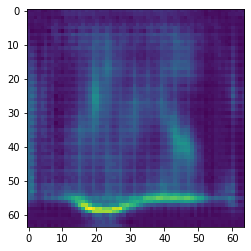

In [188]:
plt.imshow(np.array(img[0][0].detach()))